### experiments on real world data 

In [1]:
from sklearn import datasets 
import logging
import sys
import os
%cd ..
from bds.meel import approx_mc2, approx_mc2_core
from bds.rule import Rule
from bds.utils import bin_random , bin_array, randints, solutions_to_dict

#from bds.bb import BranchAndBoundNaive, BranchAndBoundV1, BranchAndBoundV0, BranchAndBoundV2
from logzero import logger
import gmpy2 as gmp
from gmpy2 import mpz , mpfr
from bds.sat.min_freq import construct_min_freq_program
from bds.sat.solver import construct_solver
from bds.gf2 import GF
from bds.rule import Rule
from bds.utils import mpz_set_bits
from tests.utils import assert_dict_allclose, assert_close_mpfr

#from bds.bounds_utils import find_equivalence_classes
import numpy as np 

#from bds.cbb_v2 import * 

logger.setLevel(logging.DEBUG)

num_pts = 500

show_progres = True
rand_seed = 1234



/u/50/ciaperm1/unix/sampling-rashomon-decision-set-code


In [2]:
import pandas as pd
import pickle 
def read_pickle(filepath_y): 
    objects = []
    with (open(filepath_y, "rb")) as openfile:
        while True:
            try:
                objects.append(pickle.load(openfile))
            except EOFError:
                break

    return objects

def filter_categorical_columns(df):
    # Filter out numerical columns
    numeric_columns = df.select_dtypes(include=['number']).columns

    # Filter out categorical columns with less than 10 categories
    categorical_columns = []
    for column in df.columns:
        if column not in numeric_columns:
            unique_categories = df[column].nunique()
            if unique_categories < 4:
                categorical_columns.append(column)

    # Create a new DataFrame with filtered columns
    filtered_df = df[numeric_columns.tolist() + categorical_columns]
    return filtered_df

In [3]:
# Load the CSV file using Pandas
dataset = "sfq"
data = pd.read_csv('data/sqf-2016.csv')

# Print the data
data.head()

/tmp/ipykernel_9863/1167166898.py:3: DtypeWarning: Columns (0,1,2,3,4,8,18,19,73,74,84,85,86,103,110,111) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/sqf-2016.csv')


year pct ser_num datestop timestop recstat inout trhsloc perobs   
0  2016  41      22  2072016      100       A     O       P    1.0  \
1  2016  10      22  2182016       30       1     O       P    8.0   
2  2016  66       1  1012016       30       1     I       P    2.0   
3  2016  47      18  1012016       40       1     O       H    1.0   
4  2016  79       1  1012016       50       1     O       P    3.0   

      crimsusp  ... zip addrpct sector beat post   xcoord   ycoord dettypCM   
0         BURG  ...          41      B    2       1013353   234000       CM  \
1  MISDEMEANOR  ...          10      D             983478   212373       CM   
2          FEL  ...          66      F             988340   172111       CM   
3          FEL  ...          47      C                                   CM   
4       D.W.I.  ...          79      G    4        998197   187413       CM   

  lineCM detailCM  
0      1       14  
1      1       28  
2      1        9  
3      1       20  
4      1      112  

[5 rows x 112 columns]

In [4]:
data_filtered = filter_categorical_columns(data)

In [5]:
data_filtered.columns

Index(['year', 'recstat', 'inout', 'explnstp', 'othpers', 'arstmade',
       'sumissue', 'compyear', 'comppct', 'offunif', 'officrid', 'frisked',
       'searched', 'contrabn', 'adtlrept', 'pistol', 'riflshot', 'asltweap',
       'knifcuti', 'machgun', 'othrweap', 'pf_hands', 'pf_wall', 'pf_grnd',
       'pf_drwep', 'pf_ptwep', 'pf_baton', 'pf_hcuff', 'pf_pepsp', 'pf_other',
       'radio', 'ac_rept', 'ac_inves', 'rf_vcrim', 'rf_othsw', 'ac_proxm',
       'rf_attir', 'cs_objcs', 'cs_descr', 'cs_casng', 'cs_lkout', 'rf_vcact',
       'cs_cloth', 'cs_drgtr', 'ac_evasv', 'ac_assoc', 'cs_furtv', 'rf_rfcmp',
       'ac_cgdir', 'rf_verbl', 'cs_vcrim', 'cs_bulge', 'cs_other', 'ac_incid',
       'ac_time', 'rf_knowl', 'ac_stsnd', 'ac_other', 'sb_hdobj', 'sb_outln',
       'sb_admis', 'sb_other', 'rf_furt', 'rf_bulg', 'offverb', 'offshld',
       'dob', 'addrtyp', 'rescode', 'premtype', 'aptnum', 'state', 'zip',
       'dettypCM', 'lineCM'],
      dtype='object')

In [6]:
y = [] 
indices_yes = []
for i in range(data_filtered.shape[0]): 
    
    if data_filtered["pistol"][i] != "N" or data_filtered["riflshot"][i]!="N" or data_filtered["asltweap"][i]!="N" or data_filtered["knifcuti"][i]!="N" or data_filtered["machgun"][i]!="N" or data_filtered["othrweap"][i]!="N": 
        y.append(1) 
        indices_yes.append(i)
    else: 
        y.append(0)
        
y = np.array(y, dtype = bool)

In [7]:
len(y)

12405

In [8]:
y.sum()

712

In [9]:
data_filtered = data_filtered.drop("pistol", axis = 1) 
data_filtered = data_filtered.drop("riflshot", axis = 1) 
data_filtered = data_filtered.drop("asltweap", axis = 1) 
data_filtered = data_filtered.drop("knifcuti", axis = 1) 
data_filtered = data_filtered.drop("machgun", axis = 1) 
data_filtered = data_filtered.drop("othrweap", axis = 1) 

In [10]:
data_filtered = pd.get_dummies(data_filtered)
data_filtered.shape

(12405, 188)

In [11]:
len(indices_yes)

712

In [12]:
random_indices = np.random.choice(data_filtered.index, size=700, replace=False)
len(random_indices)

700

In [13]:
random_indices2 = list(random_indices) + indices_yes


In [14]:
y.shape

(12405,)

In [15]:
data_filtered.shape

(12405, 188)

In [16]:
random_indices = np.random.choice(data_filtered.index, size=700, replace=False)
random_indices2 = list(random_indices) + indices_yes


# Step 2: Subsample DataFrame using random indices
subsampled_df = data_filtered.iloc[random_indices2]

# Step 3: Subsample 1D array using random indices
y = y[random_indices2]

In [17]:
X = subsampled_df.to_numpy().astype(int)

In [18]:
X

array([[1, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 1],
       [1, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 1, 0]])

In [19]:
X.shape

(1412, 188)

In [20]:
y

array([False, False, False, ...,  True,  True,  True])

##### read labels 

In [21]:
y = np.array(y, dtype = bool) 

In [22]:
assert len(y) == X.shape[0]

In [23]:
X = X[:,:50]

In [27]:
# now we need to extract rules 
from bds.fpgrowth import preprocess_transaction_list, build_fptree, fpgrowth_on_tree
from bds.bb import get_ground_truth_count
from bds.bbSampleTreeApproxCounting import BranchAndBoundNaive
import time 
import random
from bds.rule import Rule
from time import time
#from bds.bbSampleTree import BranchAndBoundNaive
import time 
import random
from bds.bbSampleTreeApproxCounting import BranchAndBoundNaive
import time 
import random

def compute_truthtable(X,itemset): 
    ''' poorly optimized function '''
    support_list = [] 
    for i in range(X.shape[0]): 
        if sum([X[i][j] for j in itemset]) == len(itemset): 
            support_list.append(i)
                
    truthtable = mpz_set_bits(mpz(), support_list)
    
    return truthtable


X_bag = [set([j for j, x in enumerate(row) if x]) for row in X]


all_n_rules = [] 
lmbd = 0.1 
ub = 0.5
rand_seed = 1234
n_reps = 1

delta = .8
eps = .8

show_progres = True

#for delta in [0.2, 0.4, 0.6, 0.8, 0.9]: 
#    for eps in [0.2, 0.4, 0.6, 0.8, 0.9]: 
for delta in [0.4, 0.8]: 
    for eps in [0.4, 0.8]:

        all_averages_times_MC = [] 
        all_averages_times_GT = [] 

        all_averages_counts_MC = [] 
        all_averages_counts_GT = []
        
        all_n_rules = []

        for min_support in [ 700, 750, 800 ]:
            
            print("min support " + str(min_support))

            ordered_input_data = preprocess_transaction_list(
                X_bag, min_support
            )
            print("a")
            tree = build_fptree(ordered_input_data)
            print("b")
            frequent_itemsets = set(fpgrowth_on_tree(tree, set(), min_support))

            all_n_rules.append(len(frequent_itemsets)) 
            
            print(len(frequent_itemsets))

            # Now create rules 
            rules = [] 
            for i,itemset in enumerate(frequent_itemsets):
                tt = compute_truthtable(X,itemset)
                this_Rule = Rule(id = i+1, name = "rule_" + str(i), cardinality=len(itemset), truthtable=tt)
                # we need the truthtable for this itemset 
                rules.append(this_Rule)

            pickle.dump(rules, open("rules/rules_" + dataset + "_" +  str(len(rules)), "wb" ))

            # approxMC
            all_times_MC = [] 
            all_counts_MC = [] 

            all_times_GT = [] 
            all_counts_GT = [] 

            
            for _ in range(n_reps):

                
                t = time.time() 
                test_cnt = approx_mc2(
                            rules, y, lmbd=lmbd, ub=ub,
                            delta=delta, eps=eps, rand_seed=rand_seed, show_progress=show_progres,
                            parallel=False, log_level=logging.WARN
                        )

                elapsed = time.time() - t 
                all_times_MC.append(elapsed) 
                all_counts_MC.append(test_cnt)


                # complete enumeration 
                ref_count = get_ground_truth_count(rules, y, lmbd, ub)
                all_times_GT.append(elapsed) 
                all_counts_GT.append(ref_count) 

            all_averages_times_MC.append(np.mean(all_times_MC))
            all_averages_times_GT.append(np.mean(all_times_GT))

            all_averages_counts_MC.append(np.mean(all_counts_MC))
            all_averages_counts_GT.append(np.mean(all_counts_GT))

            
        pickle.dump(all_averages_times_MC, open("all_averages_times_MC_" + dataset + "_" + str(len(rules)) + "_" + str(eps) + "_" + str(delta), "wb" ))
        pickle.dump(all_averages_times_GT, open("all_averages_times_GT_" + dataset + "_" + str(len(rules)) + "_" + str(eps) + "_" + str(delta) , "wb" ))

        pickle.dump(all_averages_counts_MC, open("all_averages_counts_MC_" + dataset + "_" + "_" + str(len(rules)) + "_" + str(eps) + "_" + str(delta) , "wb" ))
        pickle.dump(all_averages_counts_GT, open("all_averages_counts_GT_" + dataset + "_" + str(len(rules)) + "_" + str(eps) + "_" + str(delta), "wb" ))


min support 700
a
b
1661


[D 230712 03:41:57 meel:360] calling approx_mc2 with eps = 0.40 and delta=0.40
[D 230712 03:41:57 meel:363] thresh = 155.98
[D 230712 03:41:57 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230712 03:41:57 meel:374] BB solving (thresh=155) takes 0.02 secs
    and gave 155 solutions
[D 230712 03:41:57 meel:386] maximum number of calls to ApproxMC2Core: 49
  0%|                                                    | 0/49 [00:00<?, ?it/s][D 230712 03:41:57 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:41:57 meel:278] initial solving under 1660 constraints
[D 230712 03:41:57 cbb:160] setting up the parity constraint system
[D 230712 03:41:57 cbb:129] simplifying A x = t using rref
[D 230712 03:41:58 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:41:58 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:41:58 meel:281] solving takes 1.05 secs
[D 230712 03:41:58 meel:288] with |Y| 0 < 155, therefore call log_

rand_seed: 822569775


[D 230712 03:41:58 meel:149] search tree size: 1696
[D 230712 03:41:58 meel:150] number of prefix evaluations: 56531
[D 230712 03:41:58 meel:152] solving takes 0.16 secs
[D 230712 03:41:58 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:41:58 meel:137] ---- solve m = 3----
[D 230712 03:41:58 cbb:160] setting up the parity constraint system
[D 230712 03:41:58 cbb:129] simplifying A x = t using rref
[D 230712 03:41:58 cbb:136] density(A_rref) = 50.090% (from 50.0%)
[D 230712 03:42:00 meel:149] search tree size: 1748
[D 230712 03:42:00 meel:150] number of prefix evaluations: 1274394
[D 230712 03:42:00 meel:152] solving takes 2.12 secs
[D 230712 03:42:00 meel:196] |Y| < thresh (113 < 155)
[D 230712 03:42:00 meel:202] big_cell[2]=1, return 3
[D 230712 03:42:00 meel:410] running approx_mc2_core takes 3.41s
[D 230712 03:42:00 meel:413] num_cells: 8, num_sols: 113
  2%|▉                                           | 1/49 [00:03<02:43,  3.41s/it][D 230712 03:42:00 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.05717136099974596|
|2|0.16460613799972634|
|3|2.1169928349995644|


[D 230712 03:42:01 cbb:136] density(A_rref) = 0.092% (from 50.0%)
[D 230712 03:42:02 meel:281] solving takes 1.30 secs
[D 230712 03:42:02 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:42:02 meel:98] calling log_search with thresh=155
[D 230712 03:42:02 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:02 meel:137] ---- solve m = 1----
[D 230712 03:42:02 cbb:160] setting up the parity constraint system
[D 230712 03:42:02 cbb:129] simplifying A x = t using rref
[D 230712 03:42:02 cbb:136] density(A_rref) = 49.789% (from 49.8%)
[D 230712 03:42:02 meel:149] search tree size: 1180
[D 230712 03:42:02 meel:150] number of prefix evaluations: 5392
[D 230712 03:42:02 meel:152] solving takes 0.05 secs
[D 230712 03:42:02 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:42:02 meel:137] ---- solve m = 2----
[D 230712 03:42:02 cbb:160] setting up the parity constraint system
[D 230712 03:42:02 cbb:129] si

rand_seed: 2137449171


[D 230712 03:42:04 meel:149] search tree size: 1756
[D 230712 03:42:04 meel:150] number of prefix evaluations: 1258452
[D 230712 03:42:04 meel:152] solving takes 2.00 secs
[D 230712 03:42:04 meel:196] |Y| < thresh (121 < 155)
[D 230712 03:42:04 meel:202] big_cell[2]=1, return 3
[D 230712 03:42:04 meel:410] running approx_mc2_core takes 3.50s
[D 230712 03:42:04 meel:413] num_cells: 8, num_sols: 121
  4%|█▊                                          | 2/49 [00:06<02:42,  3.47s/it][D 230712 03:42:04 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:04 meel:278] initial solving under 1660 constraints
[D 230712 03:42:04 cbb:160] setting up the parity constraint system
[D 230712 03:42:04 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.050905029000205104|
|2|0.13099986599991098|
|3|2.0038348409998434|


[D 230712 03:42:05 cbb:136] density(A_rref) = 0.120% (from 50.0%)
[D 230712 03:42:05 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:42:05 meel:281] solving takes 1.27 secs
[D 230712 03:42:05 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:42:05 meel:98] calling log_search with thresh=155
[D 230712 03:42:05 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:05 meel:137] ---- solve m = 1----
[D 230712 03:42:05 cbb:160] setting up the parity constraint system
[D 230712 03:42:05 cbb:129] simplifying A x = t using rref
[D 230712 03:42:05 cbb:136] density(A_rref) = 48.886% (from 48.9%)
[D 230712 03:42:05 meel:149] search tree size: 1167
[D 230712 03:42:05 meel:150] number of prefix evaluations: 5111
[D 230712 03:42:05 meel:152] solving takes 0.05 secs
[D 230712 03:42:05 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:42:05 meel:137] ---- solve m = 2----
[D 230712 

rand_seed: 524453158


[D 230712 03:42:07 meel:149] search tree size: 1748
[D 230712 03:42:07 meel:150] number of prefix evaluations: 1243821
[D 230712 03:42:07 meel:152] solving takes 2.07 secs
[D 230712 03:42:07 meel:196] |Y| < thresh (115 < 155)
[D 230712 03:42:07 meel:202] big_cell[2]=1, return 3
[D 230712 03:42:07 meel:410] running approx_mc2_core takes 3.53s
[D 230712 03:42:07 meel:413] num_cells: 8, num_sols: 115
  6%|██▋                                         | 3/49 [00:10<02:40,  3.49s/it][D 230712 03:42:07 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:07 meel:278] initial solving under 1660 constraints
[D 230712 03:42:07 cbb:160] setting up the parity constraint system
[D 230712 03:42:07 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.04628650300037407|
|2|0.12337451300027169|
|3|2.0680667450001238|


[D 230712 03:42:08 cbb:136] density(A_rref) = 0.121% (from 50.0%)
[D 230712 03:42:08 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:42:08 meel:281] solving takes 1.07 secs
[D 230712 03:42:08 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:42:08 meel:98] calling log_search with thresh=155
[D 230712 03:42:08 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:08 meel:137] ---- solve m = 1----
[D 230712 03:42:08 cbb:160] setting up the parity constraint system
[D 230712 03:42:08 cbb:129] simplifying A x = t using rref
[D 230712 03:42:08 cbb:136] density(A_rref) = 50.753% (from 50.8%)
[D 230712 03:42:08 meel:149] search tree size: 1181
[D 230712 03:42:08 meel:150] number of prefix evaluations: 5703
[D 230712 03:42:08 meel:152] solving takes 0.05 secs
[D 230712 03:42:08 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:42:08 meel:137] ---- solve m = 2----
[D 230712 

rand_seed: 1365105717


[D 230712 03:42:09 meel:150] number of prefix evaluations: 54803
[D 230712 03:42:09 meel:152] solving takes 0.15 secs
[D 230712 03:42:09 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:42:09 meel:137] ---- solve m = 3----
[D 230712 03:42:09 cbb:160] setting up the parity constraint system
[D 230712 03:42:09 cbb:129] simplifying A x = t using rref
[D 230712 03:42:09 cbb:136] density(A_rref) = 49.910% (from 50.8%)
[D 230712 03:42:11 meel:149] search tree size: 1734
[D 230712 03:42:11 meel:150] number of prefix evaluations: 1272668
[D 230712 03:42:11 meel:152] solving takes 2.06 secs
[D 230712 03:42:11 meel:196] |Y| < thresh (94 < 155)
[D 230712 03:42:11 meel:202] big_cell[2]=1, return 3
[D 230712 03:42:11 meel:410] running approx_mc2_core takes 3.35s
[D 230712 03:42:11 meel:413] num_cells: 8, num_sols: 94
  8%|███▌                                        | 4/49 [00:13<02:34,  3.44s/it][D 230712 03:42:11 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:11 me

time_cost_info: 
|1|0.04715911599987521|
|2|0.15288188699969396|
|3|2.0622479040002872|


[D 230712 03:42:12 cbb:136] density(A_rref) = 0.092% (from 49.9%)
[D 230712 03:42:12 meel:281] solving takes 1.41 secs
[D 230712 03:42:12 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:42:12 meel:98] calling log_search with thresh=155
[D 230712 03:42:12 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:12 meel:137] ---- solve m = 1----
[D 230712 03:42:12 cbb:160] setting up the parity constraint system
[D 230712 03:42:12 cbb:129] simplifying A x = t using rref
[D 230712 03:42:12 cbb:136] density(A_rref) = 50.030% (from 50.0%)
[D 230712 03:42:12 meel:149] search tree size: 1187
[D 230712 03:42:12 meel:150] number of prefix evaluations: 5533
[D 230712 03:42:12 meel:152] solving takes 0.05 secs
[D 230712 03:42:12 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:42:12 meel:137] ---- solve m = 2----
[D 230712 03:42:12 cbb:160] setting up the parity constraint system
[D 230712 03:42:12 cbb:129] si

rand_seed: 1880026316


[D 230712 03:42:14 meel:149] search tree size: 1748
[D 230712 03:42:14 meel:150] number of prefix evaluations: 1253254
[D 230712 03:42:14 meel:152] solving takes 1.99 secs
[D 230712 03:42:14 meel:196] |Y| < thresh (115 < 155)
[D 230712 03:42:14 meel:202] big_cell[2]=1, return 3
[D 230712 03:42:14 meel:410] running approx_mc2_core takes 3.59s
[D 230712 03:42:14 meel:413] num_cells: 8, num_sols: 115
 10%|████▍                                       | 5/49 [00:17<02:33,  3.49s/it][D 230712 03:42:14 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:14 meel:278] initial solving under 1660 constraints
[D 230712 03:42:14 cbb:160] setting up the parity constraint system
[D 230712 03:42:14 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.050357995000013034|
|2|0.12427783800012548|
|3|1.990666641000189|


[D 230712 03:42:15 cbb:136] density(A_rref) = 0.089% (from 50.0%)
[D 230712 03:42:15 meel:281] solving takes 1.07 secs
[D 230712 03:42:15 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:42:15 meel:98] calling log_search with thresh=155
[D 230712 03:42:15 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:15 meel:137] ---- solve m = 1----
[D 230712 03:42:15 cbb:160] setting up the parity constraint system
[D 230712 03:42:15 cbb:129] simplifying A x = t using rref
[D 230712 03:42:15 cbb:136] density(A_rref) = 52.077% (from 52.1%)
[D 230712 03:42:15 meel:149] search tree size: 1175
[D 230712 03:42:15 meel:150] number of prefix evaluations: 5338
[D 230712 03:42:15 meel:152] solving takes 0.05 secs
[D 230712 03:42:15 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:42:15 meel:137] ---- solve m = 2----
[D 230712 03:42:15 cbb:160] setting up the parity constraint system
[D 230712 03:42:15 cbb:129] si

rand_seed: 481516916


[D 230712 03:42:17 meel:149] search tree size: 1745
[D 230712 03:42:17 meel:150] number of prefix evaluations: 1254649
[D 230712 03:42:17 meel:152] solving takes 1.98 secs
[D 230712 03:42:17 meel:196] |Y| < thresh (111 < 155)
[D 230712 03:42:17 meel:202] big_cell[2]=1, return 3
[D 230712 03:42:17 meel:410] running approx_mc2_core takes 3.24s
[D 230712 03:42:17 meel:413] num_cells: 8, num_sols: 111
 12%|█████▍                                      | 6/49 [00:20<02:26,  3.41s/it][D 230712 03:42:17 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:17 meel:278] initial solving under 1660 constraints
[D 230712 03:42:17 cbb:160] setting up the parity constraint system
[D 230712 03:42:17 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.04774793200022032|
|2|0.12294100200006142|
|3|1.9790799360002893|


[D 230712 03:42:19 cbb:136] density(A_rref) = 0.118% (from 50.0%)
[D 230712 03:42:19 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:42:19 meel:281] solving takes 1.13 secs
[D 230712 03:42:19 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:42:19 meel:98] calling log_search with thresh=155
[D 230712 03:42:19 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:19 meel:137] ---- solve m = 1----
[D 230712 03:42:19 cbb:160] setting up the parity constraint system
[D 230712 03:42:19 cbb:129] simplifying A x = t using rref
[D 230712 03:42:19 cbb:136] density(A_rref) = 51.776% (from 51.8%)
[D 230712 03:42:19 meel:149] search tree size: 1170
[D 230712 03:42:19 meel:150] number of prefix evaluations: 5081
[D 230712 03:42:19 meel:152] solving takes 0.04 secs
[D 230712 03:42:19 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:42:19 meel:137] ---- solve m = 2----
[D 230712 

rand_seed: 1225605784


[D 230712 03:42:21 meel:149] search tree size: 1755
[D 230712 03:42:21 meel:150] number of prefix evaluations: 1253295
[D 230712 03:42:21 meel:152] solving takes 2.08 secs
[D 230712 03:42:21 meel:196] |Y| < thresh (126 < 155)
[D 230712 03:42:21 meel:202] big_cell[2]=1, return 3
[D 230712 03:42:21 meel:410] running approx_mc2_core takes 3.40s
[D 230712 03:42:21 meel:413] num_cells: 8, num_sols: 126
 14%|██████▎                                     | 7/49 [00:24<02:23,  3.41s/it][D 230712 03:42:21 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:21 meel:278] initial solving under 1660 constraints
[D 230712 03:42:21 cbb:160] setting up the parity constraint system
[D 230712 03:42:21 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.04423120499996003|
|2|0.12553229500008456|
|3|2.080212470999868|


[D 230712 03:42:22 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:42:22 meel:281] solving takes 1.28 secs
[D 230712 03:42:22 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:42:22 meel:98] calling log_search with thresh=155
[D 230712 03:42:22 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:22 meel:137] ---- solve m = 1----
[D 230712 03:42:22 cbb:160] setting up the parity constraint system
[D 230712 03:42:22 cbb:129] simplifying A x = t using rref
[D 230712 03:42:22 cbb:136] density(A_rref) = 52.077% (from 52.1%)
[D 230712 03:42:22 meel:149] search tree size: 1180
[D 230712 03:42:22 meel:150] number of prefix evaluations: 5695
[D 230712 03:42:22 meel:152] solving takes 0.05 secs
[D 230712 03:42:22 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:42:22 meel:137] ---- solve m = 2----
[D 230712 03:42:22 cbb:160] setting up the parity constraint system
[D 230712 03:42:22 cbb:129] si

rand_seed: 1165481977


[D 230712 03:42:24 meel:149] search tree size: 1748
[D 230712 03:42:24 meel:150] number of prefix evaluations: 1253162
[D 230712 03:42:24 meel:152] solving takes 2.05 secs
[D 230712 03:42:24 meel:196] |Y| < thresh (117 < 155)
[D 230712 03:42:24 meel:202] big_cell[2]=1, return 3
[D 230712 03:42:24 meel:410] running approx_mc2_core takes 3.52s
[D 230712 03:42:24 meel:413] num_cells: 8, num_sols: 117
 16%|███████▏                                    | 8/49 [00:27<02:21,  3.44s/it][D 230712 03:42:24 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:24 meel:278] initial solving under 1660 constraints
[D 230712 03:42:24 cbb:160] setting up the parity constraint system
[D 230712 03:42:24 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.05002789699983623|
|2|0.12652988500030915|
|3|2.0458118759997888|


[D 230712 03:42:26 cbb:136] density(A_rref) = 0.121% (from 50.0%)
[D 230712 03:42:26 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:42:26 meel:281] solving takes 1.30 secs
[D 230712 03:42:26 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:42:26 meel:98] calling log_search with thresh=155
[D 230712 03:42:26 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:26 meel:137] ---- solve m = 1----
[D 230712 03:42:26 cbb:160] setting up the parity constraint system
[D 230712 03:42:26 cbb:129] simplifying A x = t using rref
[D 230712 03:42:26 cbb:136] density(A_rref) = 49.910% (from 49.9%)
[D 230712 03:42:26 meel:149] search tree size: 1173
[D 230712 03:42:26 meel:150] number of prefix evaluations: 5092
[D 230712 03:42:26 meel:152] solving takes 0.05 secs
[D 230712 03:42:26 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:42:26 meel:137] ---- solve m = 2----
[D 230712 

rand_seed: 1202486927


[D 230712 03:42:26 meel:150] number of prefix evaluations: 53186
[D 230712 03:42:26 meel:152] solving takes 0.15 secs
[D 230712 03:42:26 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:42:26 meel:137] ---- solve m = 3----
[D 230712 03:42:26 cbb:160] setting up the parity constraint system
[D 230712 03:42:26 cbb:129] simplifying A x = t using rref
[D 230712 03:42:26 cbb:136] density(A_rref) = 49.689% (from 50.2%)
[D 230712 03:42:28 meel:149] search tree size: 1747
[D 230712 03:42:28 meel:150] number of prefix evaluations: 1271052
[D 230712 03:42:28 meel:152] solving takes 2.08 secs
[D 230712 03:42:28 meel:196] |Y| < thresh (114 < 155)
[D 230712 03:42:28 meel:202] big_cell[2]=1, return 3
[D 230712 03:42:28 meel:410] running approx_mc2_core takes 3.59s
[D 230712 03:42:28 meel:413] num_cells: 8, num_sols: 114
 18%|████████                                    | 9/49 [00:31<02:19,  3.49s/it][D 230712 03:42:28 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:28 

time_cost_info: 
|1|0.04803005399980975|
|2|0.15319956600023943|
|3|2.077407470000253|


[D 230712 03:42:29 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:42:29 meel:281] solving takes 1.34 secs
[D 230712 03:42:29 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:42:29 meel:98] calling log_search with thresh=155
[D 230712 03:42:29 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:29 meel:137] ---- solve m = 1----
[D 230712 03:42:29 cbb:160] setting up the parity constraint system
[D 230712 03:42:29 cbb:129] simplifying A x = t using rref
[D 230712 03:42:29 cbb:136] density(A_rref) = 50.452% (from 50.5%)
[D 230712 03:42:29 meel:149] search tree size: 1165
[D 230712 03:42:29 meel:150] number of prefix evaluations: 5180
[D 230712 03:42:29 meel:152] solving takes 0.05 secs
[D 230712 03:42:29 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:42:29 meel:137] ---- solve m = 2----
[D 230712 03:42:29 cbb:160] setting up the parity constraint system
[D 230712 03:42:29 cbb:129] si

rand_seed: 1549064881


[D 230712 03:42:32 meel:149] search tree size: 1747
[D 230712 03:42:32 meel:150] number of prefix evaluations: 1245974
[D 230712 03:42:32 meel:152] solving takes 2.04 secs
[D 230712 03:42:32 meel:196] |Y| < thresh (124 < 155)
[D 230712 03:42:32 meel:202] big_cell[2]=1, return 3
[D 230712 03:42:32 meel:410] running approx_mc2_core takes 3.55s
[D 230712 03:42:32 meel:413] num_cells: 8, num_sols: 124
 20%|████████▊                                  | 10/49 [00:34<02:16,  3.51s/it][D 230712 03:42:32 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:32 meel:278] initial solving under 1660 constraints
[D 230712 03:42:32 cbb:160] setting up the parity constraint system
[D 230712 03:42:32 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.0457159910001792|
|2|0.10399916200003645|
|3|2.0365528229999654|


[D 230712 03:42:33 cbb:136] density(A_rref) = 0.089% (from 50.0%)
[D 230712 03:42:33 meel:281] solving takes 1.10 secs
[D 230712 03:42:33 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:42:33 meel:98] calling log_search with thresh=155
[D 230712 03:42:33 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:33 meel:137] ---- solve m = 1----
[D 230712 03:42:33 cbb:160] setting up the parity constraint system
[D 230712 03:42:33 cbb:129] simplifying A x = t using rref
[D 230712 03:42:33 cbb:136] density(A_rref) = 49.789% (from 49.8%)
[D 230712 03:42:33 meel:149] search tree size: 1172
[D 230712 03:42:33 meel:150] number of prefix evaluations: 5097
[D 230712 03:42:33 meel:152] solving takes 0.05 secs
[D 230712 03:42:33 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:42:33 meel:137] ---- solve m = 2----
[D 230712 03:42:33 cbb:160] setting up the parity constraint system
[D 230712 03:42:33 cbb:129] si

rand_seed: 1170776343


[D 230712 03:42:35 meel:149] search tree size: 1753
[D 230712 03:42:35 meel:150] number of prefix evaluations: 1248160
[D 230712 03:42:35 meel:152] solving takes 2.01 secs
[D 230712 03:42:35 meel:196] |Y| < thresh (113 < 155)
[D 230712 03:42:35 meel:202] big_cell[2]=1, return 3
[D 230712 03:42:35 meel:410] running approx_mc2_core takes 3.29s
[D 230712 03:42:35 meel:413] num_cells: 8, num_sols: 113
 22%|█████████▋                                 | 11/49 [00:37<02:10,  3.44s/it][D 230712 03:42:35 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:35 meel:278] initial solving under 1660 constraints
[D 230712 03:42:35 cbb:160] setting up the parity constraint system
[D 230712 03:42:35 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.048542556000029435|
|2|0.10847848100002011|
|3|2.013044615999661|


[D 230712 03:42:36 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:42:36 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:42:36 meel:281] solving takes 1.15 secs
[D 230712 03:42:36 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:42:36 meel:98] calling log_search with thresh=155
[D 230712 03:42:36 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:36 meel:137] ---- solve m = 1----
[D 230712 03:42:36 cbb:160] setting up the parity constraint system
[D 230712 03:42:36 cbb:129] simplifying A x = t using rref
[D 230712 03:42:36 cbb:136] density(A_rref) = 50.331% (from 50.3%)
[D 230712 03:42:36 meel:149] search tree size: 1185
[D 230712 03:42:36 meel:150] number of prefix evaluations: 5731
[D 230712 03:42:36 meel:152] solving takes 0.05 secs
[D 230712 03:42:36 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:42:36 meel:137] ---- solve m = 2----
[D 230712 

rand_seed: 646980841


[D 230712 03:42:38 meel:149] search tree size: 1774
[D 230712 03:42:38 meel:150] number of prefix evaluations: 1241709
[D 230712 03:42:38 meel:152] solving takes 1.99 secs
[D 230712 03:42:38 meel:196] |Y| < thresh (141 < 155)
[D 230712 03:42:38 meel:202] big_cell[2]=1, return 3
[D 230712 03:42:38 meel:410] running approx_mc2_core takes 3.31s
[D 230712 03:42:38 meel:413] num_cells: 8, num_sols: 141
 24%|██████████▌                                | 12/49 [00:41<02:05,  3.40s/it][D 230712 03:42:38 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:38 meel:278] initial solving under 1660 constraints
[D 230712 03:42:38 cbb:160] setting up the parity constraint system
[D 230712 03:42:38 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.054143395999744826|
|2|0.09534576499981995|
|3|1.9881697619998704|


[D 230712 03:42:39 cbb:136] density(A_rref) = 0.150% (from 50.0%)
[D 230712 03:42:40 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:42:40 meel:281] solving takes 1.39 secs
[D 230712 03:42:40 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:42:40 meel:98] calling log_search with thresh=155
[D 230712 03:42:40 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:40 meel:137] ---- solve m = 1----
[D 230712 03:42:40 cbb:160] setting up the parity constraint system
[D 230712 03:42:40 cbb:129] simplifying A x = t using rref
[D 230712 03:42:40 cbb:136] density(A_rref) = 49.548% (from 49.5%)
[D 230712 03:42:40 meel:149] search tree size: 1189
[D 230712 03:42:40 meel:150] number of prefix evaluations: 6002
[D 230712 03:42:40 meel:152] solving takes 0.06 secs
[D 230712 03:42:40 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:42:40 meel:137] ---- solve m = 2----
[D 230712 

rand_seed: 1187404954


[D 230712 03:42:40 meel:149] search tree size: 1578
[D 230712 03:42:40 meel:150] number of prefix evaluations: 38042
[D 230712 03:42:40 meel:152] solving takes 0.15 secs
[D 230712 03:42:40 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:42:40 meel:137] ---- solve m = 3----
[D 230712 03:42:40 cbb:160] setting up the parity constraint system
[D 230712 03:42:40 cbb:129] simplifying A x = t using rref
[D 230712 03:42:40 cbb:136] density(A_rref) = 50.612% (from 50.7%)
[D 230712 03:42:42 meel:149] search tree size: 1755
[D 230712 03:42:42 meel:150] number of prefix evaluations: 1255907
[D 230712 03:42:42 meel:152] solving takes 2.57 secs
[D 230712 03:42:42 meel:196] |Y| < thresh (120 < 155)
[D 230712 03:42:42 meel:202] big_cell[2]=1, return 3
[D 230712 03:42:42 meel:410] running approx_mc2_core takes 4.19s
[D 230712 03:42:42 meel:413] num_cells: 8, num_sols: 120
 27%|███████████▍                               | 13/49 [00:45<02:11,  3.64s/it][D 230712 03:42:42 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.06194750899976498|
|2|0.14608793299976242|
|3|2.5700988109997525|


[D 230712 03:42:44 cbb:136] density(A_rref) = 0.089% (from 50.0%)
[D 230712 03:42:44 meel:281] solving takes 1.31 secs
[D 230712 03:42:44 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:42:44 meel:98] calling log_search with thresh=155
[D 230712 03:42:44 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:44 meel:137] ---- solve m = 1----
[D 230712 03:42:44 cbb:160] setting up the parity constraint system
[D 230712 03:42:44 cbb:129] simplifying A x = t using rref
[D 230712 03:42:44 cbb:136] density(A_rref) = 50.211% (from 50.2%)
[D 230712 03:42:44 meel:149] search tree size: 1194
[D 230712 03:42:44 meel:150] number of prefix evaluations: 5920
[D 230712 03:42:44 meel:152] solving takes 0.05 secs
[D 230712 03:42:44 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:42:44 meel:137] ---- solve m = 2----
[D 230712 03:42:44 cbb:160] setting up the parity constraint system
[D 230712 03:42:44 cbb:129] si

rand_seed: 852631582


[D 230712 03:42:44 meel:149] search tree size: 1691
[D 230712 03:42:44 meel:150] number of prefix evaluations: 56990
[D 230712 03:42:44 meel:152] solving takes 0.19 secs
[D 230712 03:42:44 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:42:44 meel:137] ---- solve m = 3----
[D 230712 03:42:44 cbb:160] setting up the parity constraint system
[D 230712 03:42:44 cbb:129] simplifying A x = t using rref
[D 230712 03:42:44 cbb:136] density(A_rref) = 50.732% (from 51.2%)
[D 230712 03:42:46 meel:149] search tree size: 1738
[D 230712 03:42:46 meel:150] number of prefix evaluations: 1274853
[D 230712 03:42:46 meel:152] solving takes 2.18 secs
[D 230712 03:42:46 meel:196] |Y| < thresh (103 < 155)
[D 230712 03:42:46 meel:202] big_cell[2]=1, return 3
[D 230712 03:42:46 meel:410] running approx_mc2_core takes 3.75s
[D 230712 03:42:46 meel:413] num_cells: 8, num_sols: 103
 29%|████████████▎                              | 14/49 [00:49<02:08,  3.67s/it][D 230712 03:42:46 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.05071957900008783|
|2|0.18559488200025953|
|3|2.1835845740001787|


[D 230712 03:42:47 cbb:136] density(A_rref) = 0.121% (from 50.0%)
[D 230712 03:42:47 meel:281] solving takes 1.32 secs
[D 230712 03:42:47 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:42:47 meel:98] calling log_search with thresh=155
[D 230712 03:42:47 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:47 meel:137] ---- solve m = 1----
[D 230712 03:42:47 cbb:160] setting up the parity constraint system
[D 230712 03:42:47 cbb:129] simplifying A x = t using rref
[D 230712 03:42:47 cbb:136] density(A_rref) = 49.247% (from 49.2%)
[D 230712 03:42:47 meel:149] search tree size: 1170
[D 230712 03:42:47 meel:150] number of prefix evaluations: 5254
[D 230712 03:42:47 meel:152] solving takes 0.09 secs
[D 230712 03:42:47 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:42:47 meel:137] ---- solve m = 2----
[D 230712 03:42:47 cbb:160] setting up the parity constraint system
[D 230712 03:42:47 cbb:129] si

rand_seed: 1296531115


[D 230712 03:42:48 meel:149] search tree size: 1655
[D 230712 03:42:48 meel:150] number of prefix evaluations: 46718
[D 230712 03:42:48 meel:152] solving takes 0.25 secs
[D 230712 03:42:48 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:42:48 meel:137] ---- solve m = 3----
[D 230712 03:42:48 cbb:160] setting up the parity constraint system
[D 230712 03:42:48 cbb:129] simplifying A x = t using rref
[D 230712 03:42:48 cbb:136] density(A_rref) = 50.431% (from 49.9%)
[D 230712 03:42:50 meel:149] search tree size: 1750
[D 230712 03:42:50 meel:150] number of prefix evaluations: 1264582
[D 230712 03:42:50 meel:152] solving takes 2.55 secs
[D 230712 03:42:50 meel:196] |Y| < thresh (120 < 155)
[D 230712 03:42:50 meel:202] big_cell[2]=1, return 3
[D 230712 03:42:50 meel:410] running approx_mc2_core takes 4.23s
[D 230712 03:42:50 meel:413] num_cells: 8, num_sols: 120
 31%|█████████████▏                             | 15/49 [00:53<02:10,  3.84s/it][D 230712 03:42:50 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.0871346930002801|
|2|0.2543152499997632|
|3|2.5468464450000283|


[D 230712 03:42:51 cbb:136] density(A_rref) = 0.089% (from 50.0%)
[D 230712 03:42:52 meel:281] solving takes 1.21 secs
[D 230712 03:42:52 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:42:52 meel:98] calling log_search with thresh=155
[D 230712 03:42:52 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:52 meel:137] ---- solve m = 1----
[D 230712 03:42:52 cbb:160] setting up the parity constraint system
[D 230712 03:42:52 cbb:129] simplifying A x = t using rref
[D 230712 03:42:52 cbb:136] density(A_rref) = 51.415% (from 51.4%)
[D 230712 03:42:52 meel:149] search tree size: 1186
[D 230712 03:42:52 meel:150] number of prefix evaluations: 5667
[D 230712 03:42:52 meel:152] solving takes 0.06 secs
[D 230712 03:42:52 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:42:52 meel:137] ---- solve m = 2----
[D 230712 03:42:52 cbb:160] setting up the parity constraint system
[D 230712 03:42:52 cbb:129] si

rand_seed: 1353614494


[D 230712 03:42:52 meel:149] search tree size: 1686
[D 230712 03:42:52 meel:150] number of prefix evaluations: 54767
[D 230712 03:42:52 meel:152] solving takes 0.17 secs
[D 230712 03:42:52 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:42:52 meel:137] ---- solve m = 3----
[D 230712 03:42:52 cbb:160] setting up the parity constraint system
[D 230712 03:42:52 cbb:129] simplifying A x = t using rref
[D 230712 03:42:52 cbb:136] density(A_rref) = 50.632% (from 49.9%)
[D 230712 03:42:54 meel:149] search tree size: 1755
[D 230712 03:42:54 meel:150] number of prefix evaluations: 1272633
[D 230712 03:42:54 meel:152] solving takes 2.16 secs
[D 230712 03:42:54 meel:196] |Y| < thresh (119 < 155)
[D 230712 03:42:54 meel:202] big_cell[2]=1, return 3
[D 230712 03:42:54 meel:410] running approx_mc2_core takes 3.62s
[D 230712 03:42:54 meel:413] num_cells: 8, num_sols: 119
 33%|██████████████                             | 16/49 [00:57<02:04,  3.78s/it][D 230712 03:42:54 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.05652053399990109|
|2|0.1721103779996156|
|3|2.163089045000106|


[D 230712 03:42:55 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:42:56 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:42:56 meel:281] solving takes 1.58 secs
[D 230712 03:42:56 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:42:56 meel:98] calling log_search with thresh=155
[D 230712 03:42:56 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:56 meel:137] ---- solve m = 1----
[D 230712 03:42:56 cbb:160] setting up the parity constraint system
[D 230712 03:42:56 cbb:129] simplifying A x = t using rref
[D 230712 03:42:56 cbb:136] density(A_rref) = 49.970% (from 50.0%)
[D 230712 03:42:56 meel:149] search tree size: 1179
[D 230712 03:42:56 meel:150] number of prefix evaluations: 5496
[D 230712 03:42:56 meel:152] solving takes 0.06 secs
[D 230712 03:42:56 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:42:56 meel:137] ---- solve m = 2----
[D 230712 

rand_seed: 1967693548


[D 230712 03:42:56 meel:149] search tree size: 1660
[D 230712 03:42:56 meel:150] number of prefix evaluations: 46960
[D 230712 03:42:56 meel:152] solving takes 0.17 secs
[D 230712 03:42:56 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:42:56 meel:137] ---- solve m = 3----
[D 230712 03:42:56 cbb:160] setting up the parity constraint system
[D 230712 03:42:56 cbb:129] simplifying A x = t using rref
[D 230712 03:42:56 cbb:136] density(A_rref) = 49.247% (from 49.6%)
[D 230712 03:42:58 meel:149] search tree size: 1747
[D 230712 03:42:58 meel:150] number of prefix evaluations: 1264826
[D 230712 03:42:58 meel:152] solving takes 2.15 secs
[D 230712 03:42:58 meel:196] |Y| < thresh (119 < 155)
[D 230712 03:42:58 meel:202] big_cell[2]=1, return 3
[D 230712 03:42:58 meel:410] running approx_mc2_core takes 3.99s
[D 230712 03:42:58 meel:413] num_cells: 8, num_sols: 119
 35%|██████████████▉                            | 17/49 [01:01<02:02,  3.84s/it][D 230712 03:42:58 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.05563051599983737|
|2|0.17052102999969065|
|3|2.153322257999662|


[D 230712 03:42:59 cbb:136] density(A_rref) = 0.091% (from 50.0%)
[D 230712 03:42:59 meel:281] solving takes 1.35 secs
[D 230712 03:42:59 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:42:59 meel:98] calling log_search with thresh=155
[D 230712 03:42:59 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:42:59 meel:137] ---- solve m = 1----
[D 230712 03:42:59 cbb:160] setting up the parity constraint system
[D 230712 03:42:59 cbb:129] simplifying A x = t using rref
[D 230712 03:42:59 cbb:136] density(A_rref) = 51.836% (from 51.8%)
[D 230712 03:42:59 meel:149] search tree size: 1170
[D 230712 03:42:59 meel:150] number of prefix evaluations: 5752
[D 230712 03:42:59 meel:152] solving takes 0.05 secs
[D 230712 03:42:59 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:42:59 meel:137] ---- solve m = 2----
[D 230712 03:42:59 cbb:160] setting up the parity constraint system
[D 230712 03:42:59 cbb:129] si

rand_seed: 682106748


[D 230712 03:42:59 meel:150] number of prefix evaluations: 40946
[D 230712 03:42:59 meel:152] solving takes 0.15 secs
[D 230712 03:42:59 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:42:59 meel:137] ---- solve m = 3----
[D 230712 03:42:59 cbb:160] setting up the parity constraint system
[D 230712 03:42:59 cbb:129] simplifying A x = t using rref
[D 230712 03:42:59 cbb:136] density(A_rref) = 49.569% (from 51.4%)
[D 230712 03:43:02 meel:149] search tree size: 1750
[D 230712 03:43:02 meel:150] number of prefix evaluations: 1260468
[D 230712 03:43:02 meel:152] solving takes 2.30 secs
[D 230712 03:43:02 meel:196] |Y| < thresh (126 < 155)
[D 230712 03:43:02 meel:202] big_cell[2]=1, return 3
[D 230712 03:43:02 meel:410] running approx_mc2_core takes 3.87s
[D 230712 03:43:02 meel:413] num_cells: 8, num_sols: 126
 37%|███████████████▊                           | 18/49 [01:04<01:59,  3.85s/it][D 230712 03:43:02 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:02 

time_cost_info: 
|1|0.05143545400005678|
|2|0.1466348819999439|
|3|2.3009000460001516|


[D 230712 03:43:03 cbb:136] density(A_rref) = 0.089% (from 50.0%)
[D 230712 03:43:03 meel:281] solving takes 1.43 secs
[D 230712 03:43:03 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:43:03 meel:98] calling log_search with thresh=155
[D 230712 03:43:03 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:03 meel:137] ---- solve m = 1----
[D 230712 03:43:03 cbb:160] setting up the parity constraint system
[D 230712 03:43:03 cbb:129] simplifying A x = t using rref
[D 230712 03:43:03 cbb:136] density(A_rref) = 50.873% (from 50.9%)
[D 230712 03:43:03 meel:149] search tree size: 1175
[D 230712 03:43:03 meel:150] number of prefix evaluations: 5518
[D 230712 03:43:03 meel:152] solving takes 0.06 secs
[D 230712 03:43:03 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:43:03 meel:137] ---- solve m = 2----
[D 230712 03:43:03 cbb:160] setting up the parity constraint system
[D 230712 03:43:03 cbb:129] si

rand_seed: 1614618394


[D 230712 03:43:03 meel:149] search tree size: 1576
[D 230712 03:43:03 meel:150] number of prefix evaluations: 40712
[D 230712 03:43:03 meel:152] solving takes 0.16 secs
[D 230712 03:43:03 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:43:03 meel:137] ---- solve m = 3----
[D 230712 03:43:03 cbb:160] setting up the parity constraint system
[D 230712 03:43:03 cbb:129] simplifying A x = t using rref
[D 230712 03:43:03 cbb:136] density(A_rref) = 49.890% (from 50.9%)
[D 230712 03:43:06 meel:149] search tree size: 1751
[D 230712 03:43:06 meel:150] number of prefix evaluations: 1258578
[D 230712 03:43:06 meel:152] solving takes 2.09 secs
[D 230712 03:43:06 meel:196] |Y| < thresh (117 < 155)
[D 230712 03:43:06 meel:202] big_cell[2]=1, return 3
[D 230712 03:43:06 meel:410] running approx_mc2_core takes 3.75s
[D 230712 03:43:06 meel:413] num_cells: 8, num_sols: 117
 39%|████████████████▋                          | 19/49 [01:08<01:54,  3.82s/it][D 230712 03:43:06 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.05538657900024191|
|2|0.1579835920001642|
|3|2.090840895999918|


[D 230712 03:43:07 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:43:07 meel:281] solving takes 1.67 secs
[D 230712 03:43:07 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:43:07 meel:98] calling log_search with thresh=155
[D 230712 03:43:07 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:07 meel:137] ---- solve m = 1----
[D 230712 03:43:07 cbb:160] setting up the parity constraint system
[D 230712 03:43:07 cbb:129] simplifying A x = t using rref
[D 230712 03:43:07 cbb:136] density(A_rref) = 49.368% (from 49.4%)
[D 230712 03:43:07 meel:149] search tree size: 1169
[D 230712 03:43:07 meel:150] number of prefix evaluations: 5369
[D 230712 03:43:07 meel:152] solving takes 0.06 secs
[D 230712 03:43:07 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:43:07 meel:137] ---- solve m = 2----
[D 230712 03:43:07 cbb:160] setting up the parity constraint system
[D 230712 03:43:07 cbb:129] si

rand_seed: 498808182


[D 230712 03:43:10 meel:149] search tree size: 1771
[D 230712 03:43:10 meel:150] number of prefix evaluations: 1241512
[D 230712 03:43:10 meel:152] solving takes 2.13 secs
[D 230712 03:43:10 meel:196] |Y| < thresh (136 < 155)
[D 230712 03:43:10 meel:202] big_cell[2]=1, return 3
[D 230712 03:43:10 meel:410] running approx_mc2_core takes 3.97s
[D 230712 03:43:10 meel:413] num_cells: 8, num_sols: 136
 41%|█████████████████▌                         | 20/49 [01:12<01:52,  3.87s/it][D 230712 03:43:10 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:10 meel:278] initial solving under 1660 constraints
[D 230712 03:43:10 cbb:160] setting up the parity constraint system
[D 230712 03:43:10 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.05645616899982997|
|2|0.10278771100001904|
|3|2.1270412720000422|


[D 230712 03:43:11 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:43:11 meel:281] solving takes 1.19 secs
[D 230712 03:43:11 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:43:11 meel:98] calling log_search with thresh=155
[D 230712 03:43:11 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:11 meel:137] ---- solve m = 1----
[D 230712 03:43:11 cbb:160] setting up the parity constraint system
[D 230712 03:43:11 cbb:129] simplifying A x = t using rref
[D 230712 03:43:11 cbb:136] density(A_rref) = 50.211% (from 50.2%)
[D 230712 03:43:11 meel:149] search tree size: 1175
[D 230712 03:43:11 meel:150] number of prefix evaluations: 5287
[D 230712 03:43:11 meel:152] solving takes 0.05 secs
[D 230712 03:43:11 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:43:11 meel:137] ---- solve m = 2----
[D 230712 03:43:11 cbb:160] setting up the parity constraint system
[D 230712 03:43:11 cbb:129] si

rand_seed: 1536813498


[D 230712 03:43:13 meel:149] search tree size: 1754
[D 230712 03:43:13 meel:150] number of prefix evaluations: 1257844
[D 230712 03:43:13 meel:152] solving takes 2.07 secs
[D 230712 03:43:13 meel:196] |Y| < thresh (123 < 155)
[D 230712 03:43:13 meel:202] big_cell[2]=1, return 3
[D 230712 03:43:13 meel:410] running approx_mc2_core takes 3.47s
[D 230712 03:43:13 meel:413] num_cells: 8, num_sols: 123
 43%|██████████████████▍                        | 21/49 [01:16<01:45,  3.75s/it][D 230712 03:43:13 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:13 meel:278] initial solving under 1660 constraints
[D 230712 03:43:13 cbb:160] setting up the parity constraint system
[D 230712 03:43:13 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.04843249200030186|
|2|0.1432463920000373|
|3|2.0671161109999048|


[D 230712 03:43:14 cbb:136] density(A_rref) = 0.122% (from 49.9%)
[D 230712 03:43:14 meel:281] solving takes 1.18 secs
[D 230712 03:43:14 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:43:14 meel:98] calling log_search with thresh=155
[D 230712 03:43:14 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:14 meel:137] ---- solve m = 1----
[D 230712 03:43:14 cbb:160] setting up the parity constraint system
[D 230712 03:43:14 cbb:129] simplifying A x = t using rref
[D 230712 03:43:14 cbb:136] density(A_rref) = 48.886% (from 48.9%)
[D 230712 03:43:14 meel:149] search tree size: 1161
[D 230712 03:43:14 meel:150] number of prefix evaluations: 4815
[D 230712 03:43:14 meel:152] solving takes 0.05 secs
[D 230712 03:43:14 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:43:14 meel:137] ---- solve m = 2----
[D 230712 03:43:14 cbb:160] setting up the parity constraint system
[D 230712 03:43:14 cbb:129] si

rand_seed: 55437432


[D 230712 03:43:17 meel:149] search tree size: 1744
[D 230712 03:43:17 meel:150] number of prefix evaluations: 1252359
[D 230712 03:43:17 meel:152] solving takes 2.18 secs
[D 230712 03:43:17 meel:196] |Y| < thresh (115 < 155)
[D 230712 03:43:17 meel:202] big_cell[2]=1, return 3
[D 230712 03:43:17 meel:410] running approx_mc2_core takes 3.56s
[D 230712 03:43:17 meel:413] num_cells: 8, num_sols: 115
 45%|███████████████████▎                       | 22/49 [01:19<01:39,  3.69s/it][D 230712 03:43:17 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:17 meel:278] initial solving under 1660 constraints
[D 230712 03:43:17 cbb:160] setting up the parity constraint system
[D 230712 03:43:17 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.04808772400019734|
|2|0.1403253210000912|
|3|2.1755571339999733|


[D 230712 03:43:18 cbb:136] density(A_rref) = 0.118% (from 50.0%)
[D 230712 03:43:18 meel:281] solving takes 1.31 secs
[D 230712 03:43:18 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:43:18 meel:98] calling log_search with thresh=155
[D 230712 03:43:18 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:18 meel:137] ---- solve m = 1----
[D 230712 03:43:18 cbb:160] setting up the parity constraint system
[D 230712 03:43:18 cbb:129] simplifying A x = t using rref
[D 230712 03:43:18 cbb:136] density(A_rref) = 49.368% (from 49.4%)
[D 230712 03:43:18 meel:149] search tree size: 1182
[D 230712 03:43:18 meel:150] number of prefix evaluations: 5667
[D 230712 03:43:18 meel:152] solving takes 0.05 secs
[D 230712 03:43:18 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:43:18 meel:137] ---- solve m = 2----
[D 230712 03:43:18 cbb:160] setting up the parity constraint system
[D 230712 03:43:18 cbb:129] si

rand_seed: 4274032


[D 230712 03:43:20 meel:149] search tree size: 1739
[D 230712 03:43:20 meel:150] number of prefix evaluations: 1261118
[D 230712 03:43:20 meel:152] solving takes 1.99 secs
[D 230712 03:43:20 meel:196] |Y| < thresh (110 < 155)
[D 230712 03:43:20 meel:202] big_cell[2]=1, return 3
[D 230712 03:43:20 meel:410] running approx_mc2_core takes 3.52s
[D 230712 03:43:20 meel:413] num_cells: 8, num_sols: 110
 47%|████████████████████▏                      | 23/49 [01:23<01:34,  3.64s/it][D 230712 03:43:20 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:20 meel:278] initial solving under 1660 constraints
[D 230712 03:43:20 cbb:160] setting up the parity constraint system
[D 230712 03:43:20 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.048868898000364425|
|2|0.1449680749997242|
|3|1.992016078999768|


[D 230712 03:43:21 cbb:136] density(A_rref) = 0.092% (from 50.0%)
[D 230712 03:43:21 meel:281] solving takes 1.15 secs
[D 230712 03:43:21 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:43:21 meel:98] calling log_search with thresh=155
[D 230712 03:43:21 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:21 meel:137] ---- solve m = 1----
[D 230712 03:43:21 cbb:160] setting up the parity constraint system
[D 230712 03:43:21 cbb:129] simplifying A x = t using rref
[D 230712 03:43:21 cbb:136] density(A_rref) = 50.873% (from 50.9%)
[D 230712 03:43:21 meel:149] search tree size: 1182
[D 230712 03:43:21 meel:150] number of prefix evaluations: 5435
[D 230712 03:43:21 meel:152] solving takes 0.05 secs
[D 230712 03:43:21 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:43:21 meel:137] ---- solve m = 2----
[D 230712 03:43:21 cbb:160] setting up the parity constraint system
[D 230712 03:43:21 cbb:129] si

rand_seed: 2090933724


[D 230712 03:43:23 meel:149] search tree size: 1763
[D 230712 03:43:23 meel:150] number of prefix evaluations: 1257451
[D 230712 03:43:23 meel:152] solving takes 1.97 secs
[D 230712 03:43:23 meel:196] |Y| < thresh (132 < 155)
[D 230712 03:43:23 meel:202] big_cell[2]=1, return 3
[D 230712 03:43:23 meel:410] running approx_mc2_core takes 3.31s
[D 230712 03:43:23 meel:413] num_cells: 8, num_sols: 132
 49%|█████████████████████                      | 24/49 [01:26<01:28,  3.54s/it][D 230712 03:43:23 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:23 meel:278] initial solving under 1660 constraints
[D 230712 03:43:23 cbb:160] setting up the parity constraint system
[D 230712 03:43:23 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.04547316599973783|
|2|0.12812576699980127|
|3|1.9708159450001403|


[D 230712 03:43:24 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:43:24 meel:281] solving takes 1.10 secs
[D 230712 03:43:24 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:43:24 meel:98] calling log_search with thresh=155
[D 230712 03:43:24 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:25 meel:137] ---- solve m = 1----
[D 230712 03:43:25 cbb:160] setting up the parity constraint system
[D 230712 03:43:25 cbb:129] simplifying A x = t using rref
[D 230712 03:43:25 cbb:136] density(A_rref) = 50.632% (from 50.6%)
[D 230712 03:43:25 meel:149] search tree size: 1166
[D 230712 03:43:25 meel:150] number of prefix evaluations: 5201
[D 230712 03:43:25 meel:152] solving takes 0.05 secs
[D 230712 03:43:25 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:43:25 meel:137] ---- solve m = 2----
[D 230712 03:43:25 cbb:160] setting up the parity constraint system
[D 230712 03:43:25 cbb:129] si

rand_seed: 787967301


[D 230712 03:43:25 cbb:160] setting up the parity constraint system
[D 230712 03:43:25 cbb:129] simplifying A x = t using rref
[D 230712 03:43:25 cbb:136] density(A_rref) = 49.448% (from 48.8%)
[D 230712 03:43:27 meel:149] search tree size: 1716
[D 230712 03:43:27 meel:150] number of prefix evaluations: 1263359
[D 230712 03:43:27 meel:152] solving takes 1.96 secs
[D 230712 03:43:27 meel:196] |Y| < thresh (88 < 155)
[D 230712 03:43:27 meel:202] big_cell[2]=1, return 3
[D 230712 03:43:27 meel:410] running approx_mc2_core takes 3.28s
[D 230712 03:43:27 meel:413] num_cells: 8, num_sols: 88
 51%|█████████████████████▉                     | 25/49 [01:29<01:23,  3.46s/it][D 230712 03:43:27 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:27 meel:278] initial solving under 1660 constraints
[D 230712 03:43:27 cbb:160] setting up the parity constraint system
[D 230712 03:43:27 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.04667207500006043|
|2|0.14815136099969095|
|3|1.9610930309995638|


[D 230712 03:43:28 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:43:28 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:43:28 meel:281] solving takes 1.11 secs
[D 230712 03:43:28 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:43:28 meel:98] calling log_search with thresh=155
[D 230712 03:43:28 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:28 meel:137] ---- solve m = 1----
[D 230712 03:43:28 cbb:160] setting up the parity constraint system
[D 230712 03:43:28 cbb:129] simplifying A x = t using rref
[D 230712 03:43:28 cbb:136] density(A_rref) = 50.873% (from 50.9%)
[D 230712 03:43:28 meel:149] search tree size: 1178
[D 230712 03:43:28 meel:150] number of prefix evaluations: 5500
[D 230712 03:43:28 meel:152] solving takes 0.05 secs
[D 230712 03:43:28 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:43:28 meel:137] ---- solve m = 2----
[D 230712 

rand_seed: 1421700432


[D 230712 03:43:30 meel:149] search tree size: 1750
[D 230712 03:43:30 meel:150] number of prefix evaluations: 1255231
[D 230712 03:43:30 meel:152] solving takes 1.98 secs
[D 230712 03:43:30 meel:196] |Y| < thresh (113 < 155)
[D 230712 03:43:30 meel:202] big_cell[2]=1, return 3
[D 230712 03:43:30 meel:410] running approx_mc2_core takes 3.29s
[D 230712 03:43:30 meel:413] num_cells: 8, num_sols: 113
 53%|██████████████████████▊                    | 26/49 [01:33<01:18,  3.41s/it][D 230712 03:43:30 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:30 meel:278] initial solving under 1660 constraints
[D 230712 03:43:30 cbb:160] setting up the parity constraint system
[D 230712 03:43:30 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.05056246499998451|
|2|0.13111411799991401|
|3|1.980540259999998|


[D 230712 03:43:31 cbb:136] density(A_rref) = 0.121% (from 50.0%)
[D 230712 03:43:31 meel:281] solving takes 1.15 secs
[D 230712 03:43:31 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:43:31 meel:98] calling log_search with thresh=155
[D 230712 03:43:31 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:31 meel:137] ---- solve m = 1----
[D 230712 03:43:31 cbb:160] setting up the parity constraint system
[D 230712 03:43:31 cbb:129] simplifying A x = t using rref
[D 230712 03:43:31 cbb:136] density(A_rref) = 49.187% (from 49.2%)
[D 230712 03:43:31 meel:149] search tree size: 1187
[D 230712 03:43:31 meel:150] number of prefix evaluations: 5921
[D 230712 03:43:31 meel:152] solving takes 0.05 secs
[D 230712 03:43:31 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:43:31 meel:137] ---- solve m = 2----
[D 230712 03:43:31 cbb:160] setting up the parity constraint system
[D 230712 03:43:31 cbb:129] si

rand_seed: 913548233


[D 230712 03:43:33 meel:149] search tree size: 1757
[D 230712 03:43:33 meel:150] number of prefix evaluations: 1244511
[D 230712 03:43:33 meel:152] solving takes 1.97 secs
[D 230712 03:43:33 meel:196] |Y| < thresh (130 < 155)
[D 230712 03:43:33 meel:202] big_cell[2]=1, return 3
[D 230712 03:43:33 meel:410] running approx_mc2_core takes 3.28s
[D 230712 03:43:33 meel:413] num_cells: 8, num_sols: 130
 55%|███████████████████████▋                   | 27/49 [01:36<01:14,  3.37s/it][D 230712 03:43:33 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:33 meel:278] initial solving under 1660 constraints
[D 230712 03:43:33 cbb:160] setting up the parity constraint system
[D 230712 03:43:33 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.05059732400013672|
|2|0.09969508399990445|
|3|1.966873260000284|


[D 230712 03:43:34 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:43:34 meel:281] solving takes 1.11 secs
[D 230712 03:43:34 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:43:34 meel:98] calling log_search with thresh=155
[D 230712 03:43:34 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:34 meel:137] ---- solve m = 1----
[D 230712 03:43:34 cbb:160] setting up the parity constraint system
[D 230712 03:43:34 cbb:129] simplifying A x = t using rref
[D 230712 03:43:34 cbb:136] density(A_rref) = 50.512% (from 50.5%)
[D 230712 03:43:34 meel:149] search tree size: 1182
[D 230712 03:43:34 meel:150] number of prefix evaluations: 6070
[D 230712 03:43:34 meel:152] solving takes 0.06 secs
[D 230712 03:43:34 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:43:34 meel:137] ---- solve m = 2----
[D 230712 03:43:34 cbb:160] setting up the parity constraint system
[D 230712 03:43:34 cbb:129] si

rand_seed: 1299827071


[D 230712 03:43:37 meel:149] search tree size: 1772
[D 230712 03:43:37 meel:150] number of prefix evaluations: 1240558
[D 230712 03:43:37 meel:152] solving takes 2.02 secs
[D 230712 03:43:37 meel:196] |Y| < thresh (136 < 155)
[D 230712 03:43:37 meel:202] big_cell[2]=1, return 3
[D 230712 03:43:37 meel:410] running approx_mc2_core takes 3.29s
[D 230712 03:43:37 meel:413] num_cells: 8, num_sols: 136
 57%|████████████████████████▌                  | 28/49 [01:39<01:10,  3.35s/it][D 230712 03:43:37 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:37 meel:278] initial solving under 1660 constraints
[D 230712 03:43:37 cbb:160] setting up the parity constraint system
[D 230712 03:43:37 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.055983512999773666|
|2|0.08006040700001904|
|3|2.0160973269998976|


[D 230712 03:43:38 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:43:38 meel:281] solving takes 1.19 secs
[D 230712 03:43:38 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:43:38 meel:98] calling log_search with thresh=155
[D 230712 03:43:38 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:38 meel:137] ---- solve m = 1----
[D 230712 03:43:38 cbb:160] setting up the parity constraint system
[D 230712 03:43:38 cbb:129] simplifying A x = t using rref
[D 230712 03:43:38 cbb:136] density(A_rref) = 51.716% (from 51.7%)
[D 230712 03:43:38 meel:149] search tree size: 1169
[D 230712 03:43:38 meel:150] number of prefix evaluations: 5201
[D 230712 03:43:38 meel:152] solving takes 0.05 secs
[D 230712 03:43:38 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:43:38 meel:137] ---- solve m = 2----
[D 230712 03:43:38 cbb:160] setting up the parity constraint system
[D 230712 03:43:38 cbb:129] si

rand_seed: 1590214902


[D 230712 03:43:40 meel:149] search tree size: 1760
[D 230712 03:43:40 meel:150] number of prefix evaluations: 1242757
[D 230712 03:43:40 meel:152] solving takes 2.00 secs
[D 230712 03:43:40 meel:196] |Y| < thresh (129 < 155)
[D 230712 03:43:40 meel:202] big_cell[2]=1, return 3
[D 230712 03:43:40 meel:410] running approx_mc2_core takes 3.36s
[D 230712 03:43:40 meel:413] num_cells: 8, num_sols: 129
 59%|█████████████████████████▍                 | 29/49 [01:43<01:07,  3.35s/it][D 230712 03:43:40 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:40 meel:278] initial solving under 1660 constraints
[D 230712 03:43:40 cbb:160] setting up the parity constraint system
[D 230712 03:43:40 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.04781636100005926|
|2|0.09862562799980878|
|3|2.0019429960002526|


[D 230712 03:43:41 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:43:41 meel:281] solving takes 1.12 secs
[D 230712 03:43:41 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:43:41 meel:98] calling log_search with thresh=155
[D 230712 03:43:41 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:41 meel:137] ---- solve m = 1----
[D 230712 03:43:41 cbb:160] setting up the parity constraint system
[D 230712 03:43:41 cbb:129] simplifying A x = t using rref
[D 230712 03:43:41 cbb:136] density(A_rref) = 50.090% (from 50.1%)
[D 230712 03:43:41 meel:149] search tree size: 1181
[D 230712 03:43:41 meel:150] number of prefix evaluations: 5544
[D 230712 03:43:41 meel:152] solving takes 0.05 secs
[D 230712 03:43:41 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:43:41 meel:137] ---- solve m = 2----
[D 230712 03:43:41 cbb:160] setting up the parity constraint system
[D 230712 03:43:41 cbb:129] si

rand_seed: 421988862


[D 230712 03:43:43 meel:149] search tree size: 1753
[D 230712 03:43:43 meel:150] number of prefix evaluations: 1257563
[D 230712 03:43:43 meel:152] solving takes 2.08 secs
[D 230712 03:43:43 meel:196] |Y| < thresh (128 < 155)
[D 230712 03:43:43 meel:202] big_cell[2]=1, return 3
[D 230712 03:43:43 meel:410] running approx_mc2_core takes 3.41s
[D 230712 03:43:43 meel:413] num_cells: 8, num_sols: 128
 61%|██████████████████████████▎                | 30/49 [01:46<01:04,  3.37s/it][D 230712 03:43:43 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:43 meel:278] initial solving under 1660 constraints
[D 230712 03:43:43 cbb:160] setting up the parity constraint system
[D 230712 03:43:43 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.05095031100017877|
|2|0.1388221310003246|
|3|2.0784453080000276|


[D 230712 03:43:45 cbb:136] density(A_rref) = 0.091% (from 50.0%)
[D 230712 03:43:45 meel:281] solving takes 1.48 secs
[D 230712 03:43:45 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:43:45 meel:98] calling log_search with thresh=155
[D 230712 03:43:45 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:45 meel:137] ---- solve m = 1----
[D 230712 03:43:45 cbb:160] setting up the parity constraint system
[D 230712 03:43:45 cbb:129] simplifying A x = t using rref
[D 230712 03:43:45 cbb:136] density(A_rref) = 48.284% (from 48.3%)
[D 230712 03:43:45 meel:149] search tree size: 1177
[D 230712 03:43:45 meel:150] number of prefix evaluations: 5254
[D 230712 03:43:45 meel:152] solving takes 0.06 secs
[D 230712 03:43:45 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:43:45 meel:137] ---- solve m = 2----
[D 230712 03:43:45 cbb:160] setting up the parity constraint system
[D 230712 03:43:45 cbb:129] si

rand_seed: 262835631


[D 230712 03:43:45 meel:149] search tree size: 1676
[D 230712 03:43:45 meel:150] number of prefix evaluations: 52229
[D 230712 03:43:45 meel:152] solving takes 0.17 secs
[D 230712 03:43:45 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:43:45 meel:137] ---- solve m = 3----
[D 230712 03:43:45 cbb:160] setting up the parity constraint system
[D 230712 03:43:45 cbb:129] simplifying A x = t using rref
[D 230712 03:43:45 cbb:136] density(A_rref) = 49.669% (from 49.2%)
[D 230712 03:43:47 meel:149] search tree size: 1759
[D 230712 03:43:47 meel:150] number of prefix evaluations: 1270094
[D 230712 03:43:47 meel:152] solving takes 2.26 secs
[D 230712 03:43:47 meel:196] |Y| < thresh (121 < 155)
[D 230712 03:43:47 meel:202] big_cell[2]=1, return 3
[D 230712 03:43:47 meel:410] running approx_mc2_core takes 3.98s
[D 230712 03:43:47 meel:413] num_cells: 8, num_sols: 121
 63%|███████████████████████████▏               | 31/49 [01:50<01:03,  3.55s/it][D 230712 03:43:47 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.057740315000046394|
|2|0.16716954299999998|
|3|2.256988647000071|


[D 230712 03:43:49 cbb:136] density(A_rref) = 0.091% (from 50.0%)
[D 230712 03:43:49 meel:281] solving takes 1.57 secs
[D 230712 03:43:49 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:43:49 meel:98] calling log_search with thresh=155
[D 230712 03:43:49 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:49 meel:137] ---- solve m = 1----
[D 230712 03:43:49 cbb:160] setting up the parity constraint system
[D 230712 03:43:49 cbb:129] simplifying A x = t using rref
[D 230712 03:43:49 cbb:136] density(A_rref) = 49.609% (from 49.6%)
[D 230712 03:43:49 meel:149] search tree size: 1173
[D 230712 03:43:49 meel:150] number of prefix evaluations: 5564
[D 230712 03:43:49 meel:152] solving takes 0.05 secs
[D 230712 03:43:49 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:43:49 meel:137] ---- solve m = 2----
[D 230712 03:43:49 cbb:160] setting up the parity constraint system
[D 230712 03:43:49 cbb:129] si

rand_seed: 240490034


[D 230712 03:43:49 meel:149] search tree size: 1651
[D 230712 03:43:49 meel:150] number of prefix evaluations: 46779
[D 230712 03:43:49 meel:152] solving takes 0.18 secs
[D 230712 03:43:49 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:43:49 meel:137] ---- solve m = 3----
[D 230712 03:43:49 cbb:160] setting up the parity constraint system
[D 230712 03:43:49 cbb:129] simplifying A x = t using rref
[D 230712 03:43:49 cbb:136] density(A_rref) = 50.090% (from 49.2%)
[D 230712 03:43:51 meel:149] search tree size: 1740
[D 230712 03:43:51 meel:150] number of prefix evaluations: 1264645
[D 230712 03:43:51 meel:152] solving takes 2.16 secs
[D 230712 03:43:51 meel:196] |Y| < thresh (112 < 155)
[D 230712 03:43:51 meel:202] big_cell[2]=1, return 3
[D 230712 03:43:51 meel:410] running approx_mc2_core takes 3.98s
[D 230712 03:43:51 meel:413] num_cells: 8, num_sols: 112
 65%|████████████████████████████               | 32/49 [01:54<01:02,  3.68s/it][D 230712 03:43:51 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.053747064000162936|
|2|0.18387107899980037|
|3|2.1551201830002356|


[D 230712 03:43:52 cbb:136] density(A_rref) = 0.122% (from 50.0%)
[D 230712 03:43:53 meel:281] solving takes 1.28 secs
[D 230712 03:43:53 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:43:53 meel:98] calling log_search with thresh=155
[D 230712 03:43:53 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:53 meel:137] ---- solve m = 1----
[D 230712 03:43:53 cbb:160] setting up the parity constraint system
[D 230712 03:43:53 cbb:129] simplifying A x = t using rref
[D 230712 03:43:53 cbb:136] density(A_rref) = 50.753% (from 50.8%)
[D 230712 03:43:53 meel:149] search tree size: 1173
[D 230712 03:43:53 meel:150] number of prefix evaluations: 5564
[D 230712 03:43:53 meel:152] solving takes 0.06 secs
[D 230712 03:43:53 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:43:53 meel:137] ---- solve m = 2----
[D 230712 03:43:53 cbb:160] setting up the parity constraint system
[D 230712 03:43:53 cbb:129] si

rand_seed: 13242096


[D 230712 03:43:55 meel:149] search tree size: 1753
[D 230712 03:43:55 meel:150] number of prefix evaluations: 1250824
[D 230712 03:43:55 meel:152] solving takes 2.20 secs
[D 230712 03:43:55 meel:196] |Y| < thresh (123 < 155)
[D 230712 03:43:55 meel:202] big_cell[2]=1, return 3
[D 230712 03:43:55 meel:410] running approx_mc2_core takes 3.68s
[D 230712 03:43:55 meel:413] num_cells: 8, num_sols: 123
 67%|████████████████████████████▉              | 33/49 [01:58<00:58,  3.68s/it][D 230712 03:43:55 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:55 meel:278] initial solving under 1660 constraints
[D 230712 03:43:55 cbb:160] setting up the parity constraint system
[D 230712 03:43:55 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.05766524599994227|
|2|0.11856538400024874|
|3|2.1994470880003973|


[D 230712 03:43:57 cbb:136] density(A_rref) = 0.091% (from 50.0%)
[D 230712 03:43:57 meel:281] solving takes 1.67 secs
[D 230712 03:43:57 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:43:57 meel:98] calling log_search with thresh=155
[D 230712 03:43:57 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:43:57 meel:137] ---- solve m = 1----
[D 230712 03:43:57 cbb:160] setting up the parity constraint system
[D 230712 03:43:57 cbb:129] simplifying A x = t using rref
[D 230712 03:43:57 cbb:136] density(A_rref) = 50.211% (from 50.2%)
[D 230712 03:43:57 meel:149] search tree size: 1174
[D 230712 03:43:57 meel:150] number of prefix evaluations: 5392
[D 230712 03:43:57 meel:152] solving takes 0.06 secs
[D 230712 03:43:57 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:43:57 meel:137] ---- solve m = 2----
[D 230712 03:43:57 cbb:160] setting up the parity constraint system
[D 230712 03:43:57 cbb:129] si

rand_seed: 1901221627


[D 230712 03:43:57 meel:149] search tree size: 1598
[D 230712 03:43:57 meel:150] number of prefix evaluations: 41869
[D 230712 03:43:57 meel:152] solving takes 0.19 secs
[D 230712 03:43:57 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:43:57 meel:137] ---- solve m = 3----
[D 230712 03:43:57 cbb:160] setting up the parity constraint system
[D 230712 03:43:57 cbb:129] simplifying A x = t using rref
[D 230712 03:43:57 cbb:136] density(A_rref) = 50.291% (from 50.1%)
[D 230712 03:43:59 meel:149] search tree size: 1762
[D 230712 03:43:59 meel:150] number of prefix evaluations: 1259734
[D 230712 03:43:59 meel:152] solving takes 2.16 secs
[D 230712 03:43:59 meel:196] |Y| < thresh (130 < 155)
[D 230712 03:43:59 meel:202] big_cell[2]=1, return 3
[D 230712 03:43:59 meel:410] running approx_mc2_core takes 4.10s
[D 230712 03:43:59 meel:413] num_cells: 8, num_sols: 130
 69%|█████████████████████████████▊             | 34/49 [02:02<00:57,  3.81s/it][D 230712 03:43:59 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.061890328000117734|
|2|0.18742075199997998|
|3|2.16168533400014|


[D 230712 03:44:00 cbb:136] density(A_rref) = 0.091% (from 50.0%)
[D 230712 03:44:00 meel:281] solving takes 1.37 secs
[D 230712 03:44:00 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:44:00 meel:98] calling log_search with thresh=155
[D 230712 03:44:00 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:44:00 meel:137] ---- solve m = 1----
[D 230712 03:44:00 cbb:160] setting up the parity constraint system
[D 230712 03:44:00 cbb:129] simplifying A x = t using rref
[D 230712 03:44:00 cbb:136] density(A_rref) = 48.284% (from 48.3%)
[D 230712 03:44:01 meel:149] search tree size: 1164
[D 230712 03:44:01 meel:150] number of prefix evaluations: 5081
[D 230712 03:44:01 meel:152] solving takes 0.06 secs
[D 230712 03:44:01 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:44:01 meel:137] ---- solve m = 2----
[D 230712 03:44:01 cbb:160] setting up the parity constraint system
[D 230712 03:44:01 cbb:129] si

rand_seed: 59135052


[D 230712 03:44:03 meel:149] search tree size: 1754
[D 230712 03:44:03 meel:150] number of prefix evaluations: 1247653
[D 230712 03:44:03 meel:152] solving takes 2.03 secs
[D 230712 03:44:03 meel:196] |Y| < thresh (124 < 155)
[D 230712 03:44:03 meel:202] big_cell[2]=1, return 3
[D 230712 03:44:03 meel:410] running approx_mc2_core takes 3.60s
[D 230712 03:44:03 meel:413] num_cells: 8, num_sols: 124
 71%|██████████████████████████████▋            | 35/49 [02:05<00:52,  3.75s/it][D 230712 03:44:03 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:44:03 meel:278] initial solving under 1660 constraints
[D 230712 03:44:03 cbb:160] setting up the parity constraint system
[D 230712 03:44:03 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.06137757500027874|
|2|0.12109280699996816|
|3|2.0255058979996647|


[D 230712 03:44:04 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:44:04 meel:281] solving takes 1.33 secs
[D 230712 03:44:04 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:44:04 meel:98] calling log_search with thresh=155
[D 230712 03:44:04 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:44:04 meel:137] ---- solve m = 1----
[D 230712 03:44:04 cbb:160] setting up the parity constraint system
[D 230712 03:44:04 cbb:129] simplifying A x = t using rref
[D 230712 03:44:04 cbb:136] density(A_rref) = 51.174% (from 51.2%)
[D 230712 03:44:04 meel:149] search tree size: 1172
[D 230712 03:44:04 meel:150] number of prefix evaluations: 5365
[D 230712 03:44:04 meel:152] solving takes 0.05 secs
[D 230712 03:44:04 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:44:04 meel:137] ---- solve m = 2----
[D 230712 03:44:04 cbb:160] setting up the parity constraint system
[D 230712 03:44:04 cbb:129] si

rand_seed: 95107365


[D 230712 03:44:06 meel:149] search tree size: 1747
[D 230712 03:44:06 meel:150] number of prefix evaluations: 1253267
[D 230712 03:44:06 meel:152] solving takes 2.12 secs
[D 230712 03:44:06 meel:196] |Y| < thresh (116 < 155)
[D 230712 03:44:06 meel:202] big_cell[2]=1, return 3
[D 230712 03:44:06 meel:410] running approx_mc2_core takes 3.65s
[D 230712 03:44:06 meel:413] num_cells: 8, num_sols: 116
 73%|███████████████████████████████▌           | 36/49 [02:09<00:48,  3.72s/it][D 230712 03:44:06 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:44:06 meel:278] initial solving under 1660 constraints
[D 230712 03:44:06 cbb:160] setting up the parity constraint system
[D 230712 03:44:06 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.05272925400004169|
|2|0.1273522100000264|
|3|2.119040631000189|


[D 230712 03:44:07 cbb:136] density(A_rref) = 0.152% (from 50.0%)
[D 230712 03:44:07 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:44:07 meel:281] solving takes 1.14 secs
[D 230712 03:44:07 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:44:07 meel:98] calling log_search with thresh=155
[D 230712 03:44:07 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:44:07 meel:137] ---- solve m = 1----
[D 230712 03:44:07 cbb:160] setting up the parity constraint system
[D 230712 03:44:07 cbb:129] simplifying A x = t using rref
[D 230712 03:44:07 cbb:136] density(A_rref) = 51.054% (from 51.1%)
[D 230712 03:44:08 meel:149] search tree size: 1165
[D 230712 03:44:08 meel:150] number of prefix evaluations: 5500
[D 230712 03:44:08 meel:152] solving takes 0.05 secs
[D 230712 03:44:08 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:44:08 meel:137] ---- solve m = 2----
[D 230712 

rand_seed: 1171781410


[D 230712 03:44:08 meel:149] search tree size: 1672
[D 230712 03:44:08 meel:150] number of prefix evaluations: 52650
[D 230712 03:44:08 meel:152] solving takes 0.16 secs
[D 230712 03:44:08 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:44:08 meel:137] ---- solve m = 3----
[D 230712 03:44:08 cbb:160] setting up the parity constraint system
[D 230712 03:44:08 cbb:129] simplifying A x = t using rref
[D 230712 03:44:08 cbb:136] density(A_rref) = 49.689% (from 50.3%)
[D 230712 03:44:10 meel:149] search tree size: 1733
[D 230712 03:44:10 meel:150] number of prefix evaluations: 1268854
[D 230712 03:44:10 meel:152] solving takes 2.06 secs
[D 230712 03:44:10 meel:196] |Y| < thresh (100 < 155)
[D 230712 03:44:10 meel:202] big_cell[2]=1, return 3
[D 230712 03:44:10 meel:410] running approx_mc2_core takes 3.43s
[D 230712 03:44:10 meel:413] num_cells: 8, num_sols: 100
 76%|████████████████████████████████▍          | 37/49 [02:12<00:43,  3.63s/it][D 230712 03:44:10 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.04747782300000836|
|2|0.16410741800018513|
|3|2.059727525999733|


[D 230712 03:44:11 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:44:11 meel:281] solving takes 1.26 secs
[D 230712 03:44:11 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:44:11 meel:98] calling log_search with thresh=155
[D 230712 03:44:11 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:44:11 meel:137] ---- solve m = 1----
[D 230712 03:44:11 cbb:160] setting up the parity constraint system
[D 230712 03:44:11 cbb:129] simplifying A x = t using rref
[D 230712 03:44:11 cbb:136] density(A_rref) = 50.331% (from 50.3%)
[D 230712 03:44:11 meel:149] search tree size: 1176
[D 230712 03:44:11 meel:150] number of prefix evaluations: 5180
[D 230712 03:44:11 meel:152] solving takes 0.05 secs
[D 230712 03:44:11 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:44:11 meel:137] ---- solve m = 2----
[D 230712 03:44:11 cbb:160] setting up the parity constraint system
[D 230712 03:44:11 cbb:129] si

rand_seed: 1248669606


[D 230712 03:44:13 meel:149] search tree size: 1756
[D 230712 03:44:13 meel:150] number of prefix evaluations: 1253177
[D 230712 03:44:13 meel:152] solving takes 2.22 secs
[D 230712 03:44:13 meel:196] |Y| < thresh (123 < 155)
[D 230712 03:44:13 meel:202] big_cell[2]=1, return 3
[D 230712 03:44:13 meel:410] running approx_mc2_core takes 3.68s
[D 230712 03:44:13 meel:413] num_cells: 8, num_sols: 123
 78%|█████████████████████████████████▎         | 38/49 [02:16<00:40,  3.65s/it][D 230712 03:44:13 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:44:13 meel:278] initial solving under 1660 constraints
[D 230712 03:44:13 cbb:160] setting up the parity constraint system
[D 230712 03:44:13 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.047391349999998056|
|2|0.12890201300024273|
|3|2.2235965529998793|


[D 230712 03:44:15 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:44:15 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:44:15 meel:281] solving takes 1.55 secs
[D 230712 03:44:15 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:44:15 meel:98] calling log_search with thresh=155
[D 230712 03:44:15 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:44:15 meel:137] ---- solve m = 1----
[D 230712 03:44:15 cbb:160] setting up the parity constraint system
[D 230712 03:44:15 cbb:129] simplifying A x = t using rref
[D 230712 03:44:15 cbb:136] density(A_rref) = 52.318% (from 52.3%)
[D 230712 03:44:15 meel:149] search tree size: 1193
[D 230712 03:44:15 meel:150] number of prefix evaluations: 5990
[D 230712 03:44:15 meel:152] solving takes 0.05 secs
[D 230712 03:44:15 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:44:15 meel:137] ---- solve m = 2----
[D 230712 

rand_seed: 1643431418


[D 230712 03:44:17 meel:149] search tree size: 1754
[D 230712 03:44:17 meel:150] number of prefix evaluations: 1255641
[D 230712 03:44:17 meel:152] solving takes 2.04 secs
[D 230712 03:44:17 meel:196] |Y| < thresh (121 < 155)
[D 230712 03:44:17 meel:202] big_cell[2]=1, return 3
[D 230712 03:44:17 meel:410] running approx_mc2_core takes 3.80s
[D 230712 03:44:17 meel:413] num_cells: 8, num_sols: 121
 80%|██████████████████████████████████▏        | 39/49 [02:20<00:36,  3.69s/it][D 230712 03:44:17 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:44:17 meel:278] initial solving under 1660 constraints
[D 230712 03:44:17 cbb:160] setting up the parity constraint system
[D 230712 03:44:17 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.052258890999837604|
|2|0.13343992699992668|
|3|2.0372158069999386|


[D 230712 03:44:18 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:44:18 meel:281] solving takes 1.25 secs
[D 230712 03:44:18 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:44:18 meel:98] calling log_search with thresh=155
[D 230712 03:44:18 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:44:18 meel:137] ---- solve m = 1----
[D 230712 03:44:18 cbb:160] setting up the parity constraint system
[D 230712 03:44:18 cbb:129] simplifying A x = t using rref
[D 230712 03:44:18 cbb:136] density(A_rref) = 49.609% (from 49.6%)
[D 230712 03:44:19 meel:149] search tree size: 1168
[D 230712 03:44:19 meel:150] number of prefix evaluations: 5097
[D 230712 03:44:19 meel:152] solving takes 0.05 secs
[D 230712 03:44:19 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:44:19 meel:137] ---- solve m = 2----
[D 230712 03:44:19 cbb:160] setting up the parity constraint system
[D 230712 03:44:19 cbb:129] si

rand_seed: 1058256067


[D 230712 03:44:21 meel:149] search tree size: 1763
[D 230712 03:44:21 meel:150] number of prefix evaluations: 1253265
[D 230712 03:44:21 meel:152] solving takes 1.98 secs
[D 230712 03:44:21 meel:196] |Y| < thresh (131 < 155)
[D 230712 03:44:21 meel:202] big_cell[2]=1, return 3
[D 230712 03:44:21 meel:410] running approx_mc2_core takes 3.42s
[D 230712 03:44:21 meel:413] num_cells: 8, num_sols: 131
 82%|███████████████████████████████████        | 40/49 [02:23<00:32,  3.61s/it][D 230712 03:44:21 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:44:21 meel:278] initial solving under 1660 constraints
[D 230712 03:44:21 cbb:160] setting up the parity constraint system
[D 230712 03:44:21 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.050398955999753525|
|2|0.12673856299988984|
|3|1.9793160070003069|


[D 230712 03:44:22 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:44:22 meel:281] solving takes 1.12 secs
[D 230712 03:44:22 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:44:22 meel:98] calling log_search with thresh=155
[D 230712 03:44:22 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:44:22 meel:137] ---- solve m = 1----
[D 230712 03:44:22 cbb:160] setting up the parity constraint system
[D 230712 03:44:22 cbb:129] simplifying A x = t using rref
[D 230712 03:44:22 cbb:136] density(A_rref) = 50.452% (from 50.5%)
[D 230712 03:44:22 meel:149] search tree size: 1165
[D 230712 03:44:22 meel:150] number of prefix evaluations: 4935
[D 230712 03:44:22 meel:152] solving takes 0.05 secs
[D 230712 03:44:22 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:44:22 meel:137] ---- solve m = 2----
[D 230712 03:44:22 cbb:160] setting up the parity constraint system
[D 230712 03:44:22 cbb:129] si

rand_seed: 1567173351


[D 230712 03:44:22 meel:149] search tree size: 1682
[D 230712 03:44:22 meel:150] number of prefix evaluations: 54985
[D 230712 03:44:22 meel:152] solving takes 0.16 secs
[D 230712 03:44:22 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:44:22 meel:137] ---- solve m = 3----
[D 230712 03:44:22 cbb:160] setting up the parity constraint system
[D 230712 03:44:22 cbb:129] simplifying A x = t using rref
[D 230712 03:44:22 cbb:136] density(A_rref) = 49.669% (from 50.7%)
[D 230712 03:44:24 meel:149] search tree size: 1752
[D 230712 03:44:24 meel:150] number of prefix evaluations: 1272850
[D 230712 03:44:24 meel:152] solving takes 2.03 secs
[D 230712 03:44:24 meel:196] |Y| < thresh (121 < 155)
[D 230712 03:44:24 meel:202] big_cell[2]=1, return 3
[D 230712 03:44:24 meel:410] running approx_mc2_core takes 3.38s
[D 230712 03:44:24 meel:413] num_cells: 8, num_sols: 121
 84%|███████████████████████████████████▉       | 41/49 [02:27<00:28,  3.54s/it][D 230712 03:44:24 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.047585917999640515|
|2|0.16373919299985573|
|3|2.027886899999885|


[D 230712 03:44:25 cbb:136] density(A_rref) = 0.091% (from 50.0%)
[D 230712 03:44:25 meel:281] solving takes 1.11 secs
[D 230712 03:44:25 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:44:25 meel:98] calling log_search with thresh=155
[D 230712 03:44:25 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:44:25 meel:137] ---- solve m = 1----
[D 230712 03:44:25 cbb:160] setting up the parity constraint system
[D 230712 03:44:25 cbb:129] simplifying A x = t using rref
[D 230712 03:44:25 cbb:136] density(A_rref) = 49.187% (from 49.2%)
[D 230712 03:44:25 meel:149] search tree size: 1168
[D 230712 03:44:25 meel:150] number of prefix evaluations: 5193
[D 230712 03:44:25 meel:152] solving takes 0.05 secs
[D 230712 03:44:25 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:44:25 meel:137] ---- solve m = 2----
[D 230712 03:44:25 cbb:160] setting up the parity constraint system
[D 230712 03:44:25 cbb:129] si

rand_seed: 1023433867


[D 230712 03:44:25 meel:149] search tree size: 1687
[D 230712 03:44:25 meel:150] number of prefix evaluations: 56035
[D 230712 03:44:25 meel:152] solving takes 0.17 secs
[D 230712 03:44:25 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:44:25 meel:137] ---- solve m = 3----
[D 230712 03:44:25 cbb:160] setting up the parity constraint system
[D 230712 03:44:25 cbb:129] simplifying A x = t using rref
[D 230712 03:44:25 cbb:136] density(A_rref) = 50.050% (from 49.8%)
[D 230712 03:44:27 meel:149] search tree size: 1744
[D 230712 03:44:27 meel:150] number of prefix evaluations: 1273898
[D 230712 03:44:27 meel:152] solving takes 1.99 secs
[D 230712 03:44:27 meel:196] |Y| < thresh (111 < 155)
[D 230712 03:44:27 meel:202] big_cell[2]=1, return 3
[D 230712 03:44:27 meel:410] running approx_mc2_core takes 3.35s
[D 230712 03:44:27 meel:413] num_cells: 8, num_sols: 111
 86%|████████████████████████████████████▊      | 42/49 [02:30<00:24,  3.49s/it][D 230712 03:44:27 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.04952450700011468|
|2|0.16905216900022424|
|3|1.9949073099996895|


[D 230712 03:44:28 cbb:136] density(A_rref) = 0.091% (from 50.0%)
[D 230712 03:44:29 meel:281] solving takes 1.12 secs
[D 230712 03:44:29 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:44:29 meel:98] calling log_search with thresh=155
[D 230712 03:44:29 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:44:29 meel:137] ---- solve m = 1----
[D 230712 03:44:29 cbb:160] setting up the parity constraint system
[D 230712 03:44:29 cbb:129] simplifying A x = t using rref
[D 230712 03:44:29 cbb:136] density(A_rref) = 48.525% (from 48.5%)
[D 230712 03:44:29 meel:149] search tree size: 1169
[D 230712 03:44:29 meel:150] number of prefix evaluations: 5097
[D 230712 03:44:29 meel:152] solving takes 0.05 secs
[D 230712 03:44:29 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:44:29 meel:137] ---- solve m = 2----
[D 230712 03:44:29 cbb:160] setting up the parity constraint system
[D 230712 03:44:29 cbb:129] si

rand_seed: 495622784


[D 230712 03:44:29 meel:149] search tree size: 1654
[D 230712 03:44:29 meel:150] number of prefix evaluations: 46561
[D 230712 03:44:29 meel:152] solving takes 0.15 secs
[D 230712 03:44:29 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:44:29 meel:137] ---- solve m = 3----
[D 230712 03:44:29 cbb:160] setting up the parity constraint system
[D 230712 03:44:29 cbb:129] simplifying A x = t using rref
[D 230712 03:44:29 cbb:136] density(A_rref) = 51.455% (from 49.8%)
[D 230712 03:44:31 meel:149] search tree size: 1739
[D 230712 03:44:31 meel:150] number of prefix evaluations: 1264424
[D 230712 03:44:31 meel:152] solving takes 2.00 secs
[D 230712 03:44:31 meel:196] |Y| < thresh (111 < 155)
[D 230712 03:44:31 meel:202] big_cell[2]=1, return 3
[D 230712 03:44:31 meel:410] running approx_mc2_core takes 3.34s
[D 230712 03:44:31 meel:413] num_cells: 8, num_sols: 111
 88%|█████████████████████████████████████▋     | 43/49 [02:33<00:20,  3.44s/it][D 230712 03:44:31 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.05001892800009955|
|2|0.15377087200022288|
|3|2.003768852999656|


[D 230712 03:44:32 cbb:136] density(A_rref) = 0.091% (from 50.0%)
[D 230712 03:44:32 meel:281] solving takes 1.15 secs
[D 230712 03:44:32 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:44:32 meel:98] calling log_search with thresh=155
[D 230712 03:44:32 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:44:32 meel:137] ---- solve m = 1----
[D 230712 03:44:32 cbb:160] setting up the parity constraint system
[D 230712 03:44:32 cbb:129] simplifying A x = t using rref
[D 230712 03:44:32 cbb:136] density(A_rref) = 51.294% (from 51.3%)
[D 230712 03:44:32 meel:149] search tree size: 1171
[D 230712 03:44:32 meel:150] number of prefix evaluations: 5533
[D 230712 03:44:32 meel:152] solving takes 0.05 secs
[D 230712 03:44:32 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:44:32 meel:137] ---- solve m = 2----
[D 230712 03:44:32 cbb:160] setting up the parity constraint system
[D 230712 03:44:32 cbb:129] si

rand_seed: 1671713513


[D 230712 03:44:32 meel:149] search tree size: 1680
[D 230712 03:44:32 meel:150] number of prefix evaluations: 54181
[D 230712 03:44:32 meel:152] solving takes 0.16 secs
[D 230712 03:44:32 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:44:32 meel:137] ---- solve m = 3----
[D 230712 03:44:32 cbb:160] setting up the parity constraint system
[D 230712 03:44:32 cbb:129] simplifying A x = t using rref
[D 230712 03:44:32 cbb:136] density(A_rref) = 50.652% (from 50.2%)
[D 230712 03:44:34 meel:149] search tree size: 1729
[D 230712 03:44:34 meel:150] number of prefix evaluations: 1272046
[D 230712 03:44:34 meel:152] solving takes 2.00 secs
[D 230712 03:44:34 meel:196] |Y| < thresh (103 < 155)
[D 230712 03:44:34 meel:202] big_cell[2]=1, return 3
[D 230712 03:44:34 meel:410] running approx_mc2_core takes 3.38s
[D 230712 03:44:34 meel:413] num_cells: 8, num_sols: 103
 90%|██████████████████████████████████████▌    | 44/49 [02:37<00:17,  3.43s/it][D 230712 03:44:34 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.04980810099959854|
|2|0.1629393340003844|
|3|1.9999993149999682|


[D 230712 03:44:35 cbb:136] density(A_rref) = 0.118% (from 50.0%)
[D 230712 03:44:35 meel:281] solving takes 1.13 secs
[D 230712 03:44:35 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:44:35 meel:98] calling log_search with thresh=155
[D 230712 03:44:35 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:44:35 meel:137] ---- solve m = 1----
[D 230712 03:44:35 cbb:160] setting up the parity constraint system
[D 230712 03:44:35 cbb:129] simplifying A x = t using rref
[D 230712 03:44:35 cbb:136] density(A_rref) = 49.308% (from 49.3%)
[D 230712 03:44:35 meel:149] search tree size: 1175
[D 230712 03:44:35 meel:150] number of prefix evaluations: 5533
[D 230712 03:44:35 meel:152] solving takes 0.05 secs
[D 230712 03:44:35 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:44:35 meel:137] ---- solve m = 2----
[D 230712 03:44:35 cbb:160] setting up the parity constraint system
[D 230712 03:44:35 cbb:129] si

rand_seed: 323759947


[D 230712 03:44:35 meel:149] search tree size: 1666
[D 230712 03:44:35 meel:150] number of prefix evaluations: 50153
[D 230712 03:44:35 meel:152] solving takes 0.16 secs
[D 230712 03:44:35 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:44:35 meel:137] ---- solve m = 3----
[D 230712 03:44:35 cbb:160] setting up the parity constraint system
[D 230712 03:44:35 cbb:129] simplifying A x = t using rref
[D 230712 03:44:35 cbb:136] density(A_rref) = 50.030% (from 50.0%)
[D 230712 03:44:37 meel:149] search tree size: 1745
[D 230712 03:44:37 meel:150] number of prefix evaluations: 1268017
[D 230712 03:44:37 meel:152] solving takes 2.00 secs
[D 230712 03:44:37 meel:196] |Y| < thresh (118 < 155)
[D 230712 03:44:37 meel:202] big_cell[2]=1, return 3
[D 230712 03:44:37 meel:410] running approx_mc2_core takes 3.37s
[D 230712 03:44:37 meel:413] num_cells: 8, num_sols: 118
 92%|███████████████████████████████████████▍   | 45/49 [02:40<00:13,  3.41s/it][D 230712 03:44:37 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.05184376199986218|
|2|0.16145042300013301|
|3|2.0019959300002483|


[D 230712 03:44:39 cbb:136] density(A_rref) = 0.091% (from 50.0%)
[D 230712 03:44:39 meel:281] solving takes 1.12 secs
[D 230712 03:44:39 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:44:39 meel:98] calling log_search with thresh=155
[D 230712 03:44:39 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:44:39 meel:137] ---- solve m = 1----
[D 230712 03:44:39 cbb:160] setting up the parity constraint system
[D 230712 03:44:39 cbb:129] simplifying A x = t using rref
[D 230712 03:44:39 cbb:136] density(A_rref) = 51.174% (from 51.2%)
[D 230712 03:44:39 meel:149] search tree size: 1175
[D 230712 03:44:39 meel:150] number of prefix evaluations: 5605
[D 230712 03:44:39 meel:152] solving takes 0.05 secs
[D 230712 03:44:39 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:44:39 meel:137] ---- solve m = 2----
[D 230712 03:44:39 cbb:160] setting up the parity constraint system
[D 230712 03:44:39 cbb:129] si

rand_seed: 2092247376


[D 230712 03:44:39 meel:149] search tree size: 1735
[D 230712 03:44:39 meel:150] number of prefix evaluations: 65176
[D 230712 03:44:39 meel:152] solving takes 0.19 secs
[D 230712 03:44:39 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:44:39 meel:137] ---- solve m = 3----
[D 230712 03:44:39 cbb:160] setting up the parity constraint system
[D 230712 03:44:39 cbb:129] simplifying A x = t using rref
[D 230712 03:44:39 cbb:136] density(A_rref) = 48.706% (from 49.4%)
[D 230712 03:44:41 meel:149] search tree size: 1751
[D 230712 03:44:41 meel:150] number of prefix evaluations: 1283041
[D 230712 03:44:41 meel:152] solving takes 2.00 secs
[D 230712 03:44:41 meel:196] |Y| < thresh (119 < 155)
[D 230712 03:44:41 meel:202] big_cell[2]=1, return 3
[D 230712 03:44:41 meel:410] running approx_mc2_core takes 3.39s
[D 230712 03:44:41 meel:413] num_cells: 8, num_sols: 119
 94%|████████████████████████████████████████▎  | 46/49 [02:44<00:10,  3.40s/it][D 230712 03:44:41 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.05210588399995686|
|2|0.18928226299976814|
|3|2.0045867019998695|


[D 230712 03:44:42 cbb:136] density(A_rref) = 0.092% (from 50.0%)
[D 230712 03:44:42 meel:281] solving takes 1.12 secs
[D 230712 03:44:42 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:44:42 meel:98] calling log_search with thresh=155
[D 230712 03:44:42 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:44:42 meel:137] ---- solve m = 1----
[D 230712 03:44:42 cbb:160] setting up the parity constraint system
[D 230712 03:44:42 cbb:129] simplifying A x = t using rref
[D 230712 03:44:42 cbb:136] density(A_rref) = 48.525% (from 48.5%)
[D 230712 03:44:42 meel:149] search tree size: 1172
[D 230712 03:44:42 meel:150] number of prefix evaluations: 5426
[D 230712 03:44:42 meel:152] solving takes 0.05 secs
[D 230712 03:44:42 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:44:42 meel:137] ---- solve m = 2----
[D 230712 03:44:42 cbb:160] setting up the parity constraint system
[D 230712 03:44:42 cbb:129] si

rand_seed: 1584087043


[D 230712 03:44:44 meel:149] search tree size: 1756
[D 230712 03:44:44 meel:150] number of prefix evaluations: 1257443
[D 230712 03:44:44 meel:152] solving takes 2.00 secs
[D 230712 03:44:44 meel:196] |Y| < thresh (129 < 155)
[D 230712 03:44:44 meel:202] big_cell[2]=1, return 3
[D 230712 03:44:44 meel:410] running approx_mc2_core takes 3.32s
[D 230712 03:44:44 meel:413] num_cells: 8, num_sols: 129
 96%|█████████████████████████████████████████▏ | 47/49 [02:47<00:06,  3.38s/it][D 230712 03:44:44 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:44:44 meel:278] initial solving under 1660 constraints
[D 230712 03:44:44 cbb:160] setting up the parity constraint system
[D 230712 03:44:44 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.047933013000147184|
|2|0.13586116900023626|
|3|1.997044208999796|


[D 230712 03:44:45 cbb:136] density(A_rref) = 0.092% (from 50.0%)
[D 230712 03:44:45 meel:281] solving takes 1.12 secs
[D 230712 03:44:45 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:44:45 meel:98] calling log_search with thresh=155
[D 230712 03:44:45 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:44:45 meel:137] ---- solve m = 1----
[D 230712 03:44:45 cbb:160] setting up the parity constraint system
[D 230712 03:44:45 cbb:129] simplifying A x = t using rref
[D 230712 03:44:45 cbb:136] density(A_rref) = 49.548% (from 49.5%)
[D 230712 03:44:45 meel:149] search tree size: 1171
[D 230712 03:44:45 meel:150] number of prefix evaluations: 5287
[D 230712 03:44:45 meel:152] solving takes 0.05 secs
[D 230712 03:44:45 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:44:45 meel:137] ---- solve m = 2----
[D 230712 03:44:45 cbb:160] setting up the parity constraint system
[D 230712 03:44:45 cbb:129] si

rand_seed: 504415490


[D 230712 03:44:47 meel:149] search tree size: 1735
[D 230712 03:44:47 meel:150] number of prefix evaluations: 1243918
[D 230712 03:44:47 meel:152] solving takes 1.99 secs
[D 230712 03:44:47 meel:196] |Y| < thresh (102 < 155)
[D 230712 03:44:47 meel:202] big_cell[2]=1, return 3
[D 230712 03:44:47 meel:410] running approx_mc2_core takes 3.27s
[D 230712 03:44:47 meel:413] num_cells: 8, num_sols: 102
 98%|██████████████████████████████████████████ | 48/49 [02:50<00:03,  3.35s/it][D 230712 03:44:47 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:44:47 meel:278] initial solving under 1660 constraints
[D 230712 03:44:47 cbb:160] setting up the parity constraint system
[D 230712 03:44:47 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.04836301999966963|
|2|0.09663318799994158|
|3|1.9866723319996709|


[D 230712 03:44:48 cbb:136] density(A_rref) = 0.091% (from 49.9%)
[D 230712 03:44:49 meel:281] solving takes 1.11 secs
[D 230712 03:44:49 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:44:49 meel:98] calling log_search with thresh=155
[D 230712 03:44:49 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:44:49 meel:137] ---- solve m = 1----
[D 230712 03:44:49 cbb:160] setting up the parity constraint system
[D 230712 03:44:49 cbb:129] simplifying A x = t using rref
[D 230712 03:44:49 cbb:136] density(A_rref) = 50.452% (from 50.5%)
[D 230712 03:44:49 meel:149] search tree size: 1181
[D 230712 03:44:49 meel:150] number of prefix evaluations: 5605
[D 230712 03:44:49 meel:152] solving takes 0.05 secs
[D 230712 03:44:49 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:44:49 meel:137] ---- solve m = 2----
[D 230712 03:44:49 cbb:160] setting up the parity constraint system
[D 230712 03:44:49 cbb:129] si

rand_seed: 1860322579


[D 230712 03:44:49 meel:150] number of prefix evaluations: 45848
[D 230712 03:44:49 meel:152] solving takes 0.15 secs
[D 230712 03:44:49 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:44:49 meel:137] ---- solve m = 3----
[D 230712 03:44:49 cbb:160] setting up the parity constraint system
[D 230712 03:44:49 cbb:129] simplifying A x = t using rref
[D 230712 03:44:49 cbb:136] density(A_rref) = 50.291% (from 50.3%)
[D 230712 03:44:51 meel:149] search tree size: 1753
[D 230712 03:44:51 meel:150] number of prefix evaluations: 1263714
[D 230712 03:44:51 meel:152] solving takes 1.99 secs
[D 230712 03:44:51 meel:196] |Y| < thresh (120 < 155)
[D 230712 03:44:51 meel:202] big_cell[2]=1, return 3
[D 230712 03:44:51 meel:410] running approx_mc2_core takes 3.32s
[D 230712 03:44:51 meel:413] num_cells: 8, num_sols: 120
100%|███████████████████████████████████████████| 49/49 [02:53<00:00,  3.55s/it]
[D 230712 03:44:51 meel:487] final estimate: 952.0
[D 230712 03:44:51 bb:53] calling BranchAndBoundN

time_cost_info: 
|1|0.0489958260000094|
|2|0.15191462800021327|
|3|1.9900422069999877|
min support 750
a
b
1073


[D 230712 03:44:55 meel:360] calling approx_mc2 with eps = 0.40 and delta=0.40
[D 230712 03:44:55 meel:363] thresh = 155.98
[D 230712 03:44:55 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230712 03:44:56 meel:374] BB solving (thresh=155) takes 0.51 secs
    and gave 80 solutions
[D 230712 03:44:56 meel:379] exit since number of solutions 80 < 155
[D 230712 03:44:56 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1


min support 800
a
b
805


[D 230712 03:45:01 meel:360] calling approx_mc2 with eps = 0.40 and delta=0.40
[D 230712 03:45:01 meel:363] thresh = 155.98
[D 230712 03:45:01 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230712 03:45:01 meel:374] BB solving (thresh=155) takes 0.20 secs
    and gave 60 solutions
[D 230712 03:45:01 meel:379] exit since number of solutions 60 < 155
[D 230712 03:45:01 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1


min support 700
a
b
1661


[D 230712 03:45:05 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.40
[D 230712 03:45:05 meel:363] thresh = 72.95
[D 230712 03:45:05 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230712 03:45:05 meel:374] BB solving (thresh=72) takes 0.17 secs
    and gave 72 solutions
[D 230712 03:45:05 meel:386] maximum number of calls to ApproxMC2Core: 49
  0%|                                                    | 0/49 [00:00<?, ?it/s][D 230712 03:45:05 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:05 meel:278] initial solving under 1660 constraints
[D 230712 03:45:05 cbb:160] setting up the parity constraint system
[D 230712 03:45:05 cbb:129] simplifying A x = t using rref
[D 230712 03:45:06 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:45:06 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:45:06 meel:281] solving takes 1.23 secs
[D 230712 03:45:06 meel:288] with |Y| 0 < 72, therefore call log_sear

rand_seed: 822569775


[D 230712 03:45:06 meel:150] number of prefix evaluations: 37458
[D 230712 03:45:06 meel:152] solving takes 0.11 secs
[D 230712 03:45:06 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:45:06 meel:137] ---- solve m = 4----
[D 230712 03:45:06 cbb:160] setting up the parity constraint system
[D 230712 03:45:06 cbb:129] simplifying A x = t using rref
[D 230712 03:45:06 cbb:136] density(A_rref) = 50.211% (from 49.9%)
[D 230712 03:45:08 meel:149] search tree size: 1696
[D 230712 03:45:08 meel:150] number of prefix evaluations: 1253666
[D 230712 03:45:08 meel:152] solving takes 2.07 secs
[D 230712 03:45:08 meel:196] |Y| < thresh (55 < 72)
[D 230712 03:45:08 meel:202] big_cell[3]=1, return 4
[D 230712 03:45:08 meel:410] running approx_mc2_core takes 3.52s
[D 230712 03:45:08 meel:413] num_cells: 16, num_sols: 55
  2%|▉                                           | 1/49 [00:03<02:48,  3.52s/it][D 230712 03:45:08 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:08 meel

time_cost_info: 
|1|0.03822649499988984|
|2|0.0441030479996698|
|3|0.11433788900012587|
|4|2.069387599000038|


[D 230712 03:45:09 cbb:136] density(A_rref) = 0.092% (from 50.0%)
[D 230712 03:45:09 meel:281] solving takes 1.15 secs
[D 230712 03:45:09 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:45:09 meel:98] calling log_search with thresh=72
[D 230712 03:45:09 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:09 meel:137] ---- solve m = 1----
[D 230712 03:45:09 cbb:160] setting up the parity constraint system
[D 230712 03:45:09 cbb:129] simplifying A x = t using rref
[D 230712 03:45:09 cbb:136] density(A_rref) = 49.789% (from 49.8%)
[D 230712 03:45:09 meel:149] search tree size: 1091
[D 230712 03:45:09 meel:150] number of prefix evaluations: 2343
[D 230712 03:45:09 meel:152] solving takes 0.04 secs
[D 230712 03:45:09 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:45:09 meel:137] ---- solve m = 2----
[D 230712 03:45:09 cbb:160] setting up the parity constraint system
[D 230712 03:45:09 cbb:129] simpli

rand_seed: 2137449171


[D 230712 03:45:10 cbb:129] simplifying A x = t using rref
[D 230712 03:45:10 cbb:136] density(A_rref) = 51.505% (from 48.8%)
[D 230712 03:45:12 meel:149] search tree size: 1691
[D 230712 03:45:12 meel:150] number of prefix evaluations: 1249238
[D 230712 03:45:12 meel:152] solving takes 2.03 secs
[D 230712 03:45:12 meel:196] |Y| < thresh (50 < 72)
[D 230712 03:45:12 meel:202] big_cell[3]=1, return 4
[D 230712 03:45:12 meel:410] running approx_mc2_core takes 3.39s
[D 230712 03:45:12 meel:413] num_cells: 16, num_sols: 50
  4%|█▊                                          | 2/49 [00:06<02:41,  3.45s/it][D 230712 03:45:12 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:12 meel:278] initial solving under 1660 constraints
[D 230712 03:45:12 cbb:160] setting up the parity constraint system
[D 230712 03:45:12 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.03617000900021594|
|2|0.04875004199993782|
|3|0.10727584200003548|
|4|2.0258835340000587|


[D 230712 03:45:13 cbb:136] density(A_rref) = 0.120% (from 50.0%)
[D 230712 03:45:13 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:45:13 meel:281] solving takes 1.27 secs
[D 230712 03:45:13 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:45:13 meel:98] calling log_search with thresh=72
[D 230712 03:45:13 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:13 meel:137] ---- solve m = 1----
[D 230712 03:45:13 cbb:160] setting up the parity constraint system
[D 230712 03:45:13 cbb:129] simplifying A x = t using rref
[D 230712 03:45:13 cbb:136] density(A_rref) = 48.886% (from 48.9%)
[D 230712 03:45:13 meel:149] search tree size: 1081
[D 230712 03:45:13 meel:150] number of prefix evaluations: 2131
[D 230712 03:45:13 meel:152] solving takes 0.04 secs
[D 230712 03:45:13 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:45:13 meel:137] ---- solve m = 2----
[D 230712 03:4

rand_seed: 524453158


[D 230712 03:45:15 meel:149] search tree size: 1705
[D 230712 03:45:15 meel:150] number of prefix evaluations: 1241357
[D 230712 03:45:15 meel:152] solving takes 1.97 secs
[D 230712 03:45:15 meel:196] |Y| < thresh (62 < 72)
[D 230712 03:45:15 meel:202] big_cell[3]=1, return 4
[D 230712 03:45:15 meel:410] running approx_mc2_core takes 3.43s
[D 230712 03:45:15 meel:413] num_cells: 16, num_sols: 62
  6%|██▋                                         | 3/49 [00:10<02:38,  3.44s/it][D 230712 03:45:15 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:15 meel:278] initial solving under 1660 constraints
[D 230712 03:45:15 cbb:160] setting up the parity constraint system
[D 230712 03:45:15 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.037258153000038874|
|2|0.049786000000040076|
|3|0.08711325599961128|
|4|1.9706796120003673|


[D 230712 03:45:16 cbb:136] density(A_rref) = 0.121% (from 50.0%)
[D 230712 03:45:16 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:45:16 meel:281] solving takes 1.31 secs
[D 230712 03:45:16 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:45:16 meel:98] calling log_search with thresh=72
[D 230712 03:45:16 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:16 meel:137] ---- solve m = 1----
[D 230712 03:45:16 cbb:160] setting up the parity constraint system
[D 230712 03:45:16 cbb:129] simplifying A x = t using rref
[D 230712 03:45:16 cbb:136] density(A_rref) = 50.753% (from 50.8%)
[D 230712 03:45:16 meel:149] search tree size: 1092
[D 230712 03:45:16 meel:150] number of prefix evaluations: 2588
[D 230712 03:45:16 meel:152] solving takes 0.04 secs
[D 230712 03:45:16 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:45:16 meel:137] ---- solve m = 2----
[D 230712 03:4

rand_seed: 1365105717


[D 230712 03:45:17 meel:149] search tree size: 1691
[D 230712 03:45:17 meel:150] number of prefix evaluations: 69145
[D 230712 03:45:17 meel:152] solving takes 0.18 secs
[D 230712 03:45:17 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:45:17 meel:137] ---- solve m = 4----
[D 230712 03:45:17 cbb:160] setting up the parity constraint system
[D 230712 03:45:17 cbb:129] simplifying A x = t using rref
[D 230712 03:45:17 cbb:136] density(A_rref) = 49.925% (from 50.3%)
[D 230712 03:45:19 meel:149] search tree size: 1695
[D 230712 03:45:19 meel:150] number of prefix evaluations: 1287005
[D 230712 03:45:19 meel:152] solving takes 1.96 secs
[D 230712 03:45:19 meel:196] |Y| < thresh (46 < 72)
[D 230712 03:45:19 meel:202] big_cell[3]=1, return 4
[D 230712 03:45:19 meel:410] running approx_mc2_core takes 3.55s
[D 230712 03:45:19 meel:413] num_cells: 16, num_sols: 46
  8%|███▌                                        | 4/49 [00:13<02:36,  3.49s/it][D 230712 03:45:19 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.03772339799979818|
|2|0.05097403099989606|
|3|0.17771876999995584|
|4|1.9600977740001326|


[D 230712 03:45:20 cbb:136] density(A_rref) = 0.092% (from 49.9%)
[D 230712 03:45:20 meel:281] solving takes 1.26 secs
[D 230712 03:45:20 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:45:20 meel:98] calling log_search with thresh=72
[D 230712 03:45:20 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:20 meel:137] ---- solve m = 1----
[D 230712 03:45:20 cbb:160] setting up the parity constraint system
[D 230712 03:45:20 cbb:129] simplifying A x = t using rref
[D 230712 03:45:20 cbb:136] density(A_rref) = 50.030% (from 50.0%)
[D 230712 03:45:20 meel:149] search tree size: 1099
[D 230712 03:45:20 meel:150] number of prefix evaluations: 3123
[D 230712 03:45:20 meel:152] solving takes 0.05 secs
[D 230712 03:45:20 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:45:20 meel:137] ---- solve m = 2----
[D 230712 03:45:20 cbb:160] setting up the parity constraint system
[D 230712 03:45:20 cbb:129] simpli

rand_seed: 1880026316


[D 230712 03:45:20 meel:149] search tree size: 1495
[D 230712 03:45:20 meel:150] number of prefix evaluations: 39411
[D 230712 03:45:20 meel:152] solving takes 0.13 secs
[D 230712 03:45:20 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:45:20 meel:137] ---- solve m = 4----
[D 230712 03:45:20 cbb:160] setting up the parity constraint system
[D 230712 03:45:20 cbb:129] simplifying A x = t using rref
[D 230712 03:45:20 cbb:136] density(A_rref) = 49.443% (from 49.8%)
[D 230712 03:45:22 meel:149] search tree size: 1699
[D 230712 03:45:22 meel:150] number of prefix evaluations: 1257273
[D 230712 03:45:22 meel:152] solving takes 2.03 secs
[D 230712 03:45:22 meel:196] |Y| < thresh (52 < 72)
[D 230712 03:45:22 meel:202] big_cell[3]=1, return 4
[D 230712 03:45:22 meel:410] running approx_mc2_core takes 3.54s
[D 230712 03:45:22 meel:413] num_cells: 16, num_sols: 52
 10%|████▍                                       | 5/49 [00:17<02:34,  3.51s/it][D 230712 03:45:22 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.04555704099993818|
|2|0.059111650999966514|
|3|0.12669361100006427|
|4|2.030238699000165|


[D 230712 03:45:23 cbb:136] density(A_rref) = 0.089% (from 50.0%)
[D 230712 03:45:23 meel:281] solving takes 1.16 secs
[D 230712 03:45:23 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:45:23 meel:98] calling log_search with thresh=72
[D 230712 03:45:23 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:23 meel:137] ---- solve m = 1----
[D 230712 03:45:23 cbb:160] setting up the parity constraint system
[D 230712 03:45:23 cbb:129] simplifying A x = t using rref
[D 230712 03:45:23 cbb:136] density(A_rref) = 52.077% (from 52.1%)
[D 230712 03:45:23 meel:149] search tree size: 1085
[D 230712 03:45:23 meel:150] number of prefix evaluations: 2146
[D 230712 03:45:23 meel:152] solving takes 0.04 secs
[D 230712 03:45:23 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:45:23 meel:137] ---- solve m = 2----
[D 230712 03:45:23 cbb:160] setting up the parity constraint system
[D 230712 03:45:23 cbb:129] simpli

rand_seed: 481516916


[D 230712 03:45:26 meel:149] search tree size: 1701
[D 230712 03:45:26 meel:150] number of prefix evaluations: 1250297
[D 230712 03:45:26 meel:152] solving takes 1.98 secs
[D 230712 03:45:26 meel:196] |Y| < thresh (52 < 72)
[D 230712 03:45:26 meel:202] big_cell[3]=1, return 4
[D 230712 03:45:26 meel:410] running approx_mc2_core takes 3.35s
[D 230712 03:45:26 meel:413] num_cells: 16, num_sols: 52
 12%|█████▍                                      | 6/49 [00:20<02:28,  3.46s/it][D 230712 03:45:26 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:26 meel:278] initial solving under 1660 constraints
[D 230712 03:45:26 cbb:160] setting up the parity constraint system
[D 230712 03:45:26 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.03550374899987219|
|2|0.054821670000364975|
|3|0.09905556900002921|
|4|1.9814396450001368|


[D 230712 03:45:27 cbb:136] density(A_rref) = 0.118% (from 50.0%)
[D 230712 03:45:27 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:45:27 meel:281] solving takes 1.27 secs
[D 230712 03:45:27 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:45:27 meel:98] calling log_search with thresh=72
[D 230712 03:45:27 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:27 meel:137] ---- solve m = 1----
[D 230712 03:45:27 cbb:160] setting up the parity constraint system
[D 230712 03:45:27 cbb:129] simplifying A x = t using rref
[D 230712 03:45:27 cbb:136] density(A_rref) = 51.776% (from 51.8%)
[D 230712 03:45:27 meel:149] search tree size: 1082
[D 230712 03:45:27 meel:150] number of prefix evaluations: 1968
[D 230712 03:45:27 meel:152] solving takes 0.04 secs
[D 230712 03:45:27 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:45:27 meel:137] ---- solve m = 2----
[D 230712 03:4

rand_seed: 1225605784


[D 230712 03:45:27 meel:150] number of prefix evaluations: 35878
[D 230712 03:45:27 meel:152] solving takes 0.12 secs
[D 230712 03:45:27 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:45:27 meel:137] ---- solve m = 4----
[D 230712 03:45:27 cbb:160] setting up the parity constraint system
[D 230712 03:45:27 cbb:129] simplifying A x = t using rref
[D 230712 03:45:27 cbb:136] density(A_rref) = 50.090% (from 50.8%)
[D 230712 03:45:29 meel:149] search tree size: 1709
[D 230712 03:45:29 meel:150] number of prefix evaluations: 1253740
[D 230712 03:45:29 meel:152] solving takes 1.99 secs
[D 230712 03:45:29 meel:196] |Y| < thresh (68 < 72)
[D 230712 03:45:29 meel:202] big_cell[3]=1, return 4
[D 230712 03:45:29 meel:410] running approx_mc2_core takes 3.48s
[D 230712 03:45:29 meel:413] num_cells: 16, num_sols: 68
 14%|██████▎                                     | 7/49 [00:24<02:25,  3.46s/it][D 230712 03:45:29 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:29 meel

time_cost_info: 
|1|0.035534644999643206|
|2|0.04664334500012046|
|3|0.11749298400036423|
|4|1.9867219339998883|


[D 230712 03:45:30 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:45:30 meel:281] solving takes 1.25 secs
[D 230712 03:45:30 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:45:30 meel:98] calling log_search with thresh=72
[D 230712 03:45:30 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:30 meel:137] ---- solve m = 1----
[D 230712 03:45:30 cbb:160] setting up the parity constraint system
[D 230712 03:45:30 cbb:129] simplifying A x = t using rref
[D 230712 03:45:30 cbb:136] density(A_rref) = 52.077% (from 52.1%)
[D 230712 03:45:30 meel:149] search tree size: 1089
[D 230712 03:45:30 meel:150] number of prefix evaluations: 2243
[D 230712 03:45:30 meel:152] solving takes 0.04 secs
[D 230712 03:45:30 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:45:30 meel:137] ---- solve m = 2----
[D 230712 03:45:30 cbb:160] setting up the parity constraint system
[D 230712 03:45:30 cbb:129] simpli

rand_seed: 1165481977


[D 230712 03:45:32 meel:149] search tree size: 1703
[D 230712 03:45:32 meel:150] number of prefix evaluations: 1246743
[D 230712 03:45:32 meel:152] solving takes 2.00 secs
[D 230712 03:45:32 meel:196] |Y| < thresh (61 < 72)
[D 230712 03:45:32 meel:202] big_cell[3]=1, return 4
[D 230712 03:45:32 meel:410] running approx_mc2_core takes 3.44s
[D 230712 03:45:32 meel:413] num_cells: 16, num_sols: 61
 16%|███████▏                                    | 8/49 [00:27<02:21,  3.46s/it][D 230712 03:45:32 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:32 meel:278] initial solving under 1660 constraints
[D 230712 03:45:32 cbb:160] setting up the parity constraint system
[D 230712 03:45:32 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.03641079399994851|
|2|0.04664020500013066|
|3|0.09283404200004952|
|4|1.9955360469998595|


[D 230712 03:45:34 cbb:136] density(A_rref) = 0.121% (from 50.0%)
[D 230712 03:45:34 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:45:34 meel:281] solving takes 1.38 secs
[D 230712 03:45:34 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:45:34 meel:98] calling log_search with thresh=72
[D 230712 03:45:34 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:34 meel:137] ---- solve m = 1----
[D 230712 03:45:34 cbb:160] setting up the parity constraint system
[D 230712 03:45:34 cbb:129] simplifying A x = t using rref
[D 230712 03:45:34 cbb:136] density(A_rref) = 49.910% (from 49.9%)
[D 230712 03:45:34 meel:149] search tree size: 1085
[D 230712 03:45:34 meel:150] number of prefix evaluations: 2146
[D 230712 03:45:34 meel:152] solving takes 0.04 secs
[D 230712 03:45:34 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:45:34 meel:137] ---- solve m = 2----
[D 230712 03:4

rand_seed: 1202486927


[D 230712 03:45:34 meel:149] search tree size: 1517
[D 230712 03:45:34 meel:150] number of prefix evaluations: 41653
[D 230712 03:45:34 meel:152] solving takes 0.13 secs
[D 230712 03:45:34 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:45:34 meel:137] ---- solve m = 4----
[D 230712 03:45:34 cbb:160] setting up the parity constraint system
[D 230712 03:45:34 cbb:129] simplifying A x = t using rref
[D 230712 03:45:34 cbb:136] density(A_rref) = 49.548% (from 50.4%)
[D 230712 03:45:36 meel:149] search tree size: 1707
[D 230712 03:45:36 meel:150] number of prefix evaluations: 1259518
[D 230712 03:45:36 meel:152] solving takes 1.99 secs
[D 230712 03:45:36 meel:196] |Y| < thresh (60 < 72)
[D 230712 03:45:36 meel:202] big_cell[3]=1, return 4
[D 230712 03:45:36 meel:410] running approx_mc2_core takes 3.61s
[D 230712 03:45:36 meel:413] num_cells: 16, num_sols: 60
 18%|████████                                    | 9/49 [00:31<02:20,  3.51s/it][D 230712 03:45:36 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.03908533899993927|
|2|0.04788306399996145|
|3|0.12804091799989692|
|4|1.9927042160002202|


[D 230712 03:45:37 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:45:38 meel:281] solving takes 1.40 secs
[D 230712 03:45:38 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:45:38 meel:98] calling log_search with thresh=72
[D 230712 03:45:38 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:38 meel:137] ---- solve m = 1----
[D 230712 03:45:38 cbb:160] setting up the parity constraint system
[D 230712 03:45:38 cbb:129] simplifying A x = t using rref
[D 230712 03:45:38 cbb:136] density(A_rref) = 50.452% (from 50.5%)
[D 230712 03:45:38 meel:149] search tree size: 1081
[D 230712 03:45:38 meel:150] number of prefix evaluations: 1989
[D 230712 03:45:38 meel:152] solving takes 0.05 secs
[D 230712 03:45:38 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:45:38 meel:137] ---- solve m = 2----
[D 230712 03:45:38 cbb:160] setting up the parity constraint system
[D 230712 03:45:38 cbb:129] simpli

rand_seed: 1549064881


[D 230712 03:45:38 meel:149] search tree size: 1324
[D 230712 03:45:38 meel:150] number of prefix evaluations: 26075
[D 230712 03:45:38 meel:152] solving takes 0.12 secs
[D 230712 03:45:38 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:45:38 meel:137] ---- solve m = 4----
[D 230712 03:45:38 cbb:160] setting up the parity constraint system
[D 230712 03:45:38 cbb:129] simplifying A x = t using rref
[D 230712 03:45:38 cbb:136] density(A_rref) = 49.714% (from 50.5%)
[D 230712 03:45:40 meel:149] search tree size: 1693
[D 230712 03:45:40 meel:150] number of prefix evaluations: 1243938
[D 230712 03:45:40 meel:152] solving takes 1.97 secs
[D 230712 03:45:40 meel:196] |Y| < thresh (52 < 72)
[D 230712 03:45:40 meel:202] big_cell[3]=1, return 4
[D 230712 03:45:40 meel:410] running approx_mc2_core takes 3.62s
[D 230712 03:45:40 meel:413] num_cells: 16, num_sols: 52
 20%|████████▊                                  | 10/49 [00:34<02:18,  3.54s/it][D 230712 03:45:40 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.045054828000047564|
|2|0.059601382999971975|
|3|0.11815744399973482|
|4|1.9721801360001336|


[D 230712 03:45:41 cbb:136] density(A_rref) = 0.089% (from 50.0%)
[D 230712 03:45:41 meel:281] solving takes 1.17 secs
[D 230712 03:45:41 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:45:41 meel:98] calling log_search with thresh=72
[D 230712 03:45:41 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:41 meel:137] ---- solve m = 1----
[D 230712 03:45:41 cbb:160] setting up the parity constraint system
[D 230712 03:45:41 cbb:129] simplifying A x = t using rref
[D 230712 03:45:41 cbb:136] density(A_rref) = 49.789% (from 49.8%)
[D 230712 03:45:41 meel:149] search tree size: 1084
[D 230712 03:45:41 meel:150] number of prefix evaluations: 2371
[D 230712 03:45:41 meel:152] solving takes 0.04 secs
[D 230712 03:45:41 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:45:41 meel:137] ---- solve m = 2----
[D 230712 03:45:41 cbb:160] setting up the parity constraint system
[D 230712 03:45:41 cbb:129] simpli

rand_seed: 1170776343


[D 230712 03:45:43 meel:149] search tree size: 1702
[D 230712 03:45:43 meel:150] number of prefix evaluations: 1245834
[D 230712 03:45:43 meel:152] solving takes 1.99 secs
[D 230712 03:45:43 meel:196] |Y| < thresh (53 < 72)
[D 230712 03:45:43 meel:202] big_cell[3]=1, return 4
[D 230712 03:45:43 meel:410] running approx_mc2_core takes 3.35s
[D 230712 03:45:43 meel:413] num_cells: 16, num_sols: 53
 22%|█████████▋                                 | 11/49 [00:38<02:12,  3.48s/it][D 230712 03:45:43 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:43 meel:278] initial solving under 1660 constraints
[D 230712 03:45:43 cbb:160] setting up the parity constraint system
[D 230712 03:45:43 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.0394052050000937|
|2|0.04811224100012623|
|3|0.09102027399967483|
|4|1.986728554000365|


[D 230712 03:45:44 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:45:44 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:45:44 meel:281] solving takes 1.22 secs
[D 230712 03:45:44 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:45:44 meel:98] calling log_search with thresh=72
[D 230712 03:45:44 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:44 meel:137] ---- solve m = 1----
[D 230712 03:45:44 cbb:160] setting up the parity constraint system
[D 230712 03:45:44 cbb:129] simplifying A x = t using rref
[D 230712 03:45:44 cbb:136] density(A_rref) = 50.331% (from 50.3%)
[D 230712 03:45:44 meel:149] search tree size: 1091
[D 230712 03:45:44 meel:150] number of prefix evaluations: 2565
[D 230712 03:45:44 meel:152] solving takes 0.04 secs
[D 230712 03:45:44 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:45:44 meel:137] ---- solve m = 2----
[D 230712 03:4

rand_seed: 646980841


[D 230712 03:45:47 meel:149] search tree size: 1713
[D 230712 03:45:47 meel:150] number of prefix evaluations: 1231232
[D 230712 03:45:47 meel:152] solving takes 2.16 secs
[D 230712 03:45:47 meel:196] |Y| < thresh (69 < 72)
[D 230712 03:45:47 meel:202] big_cell[3]=1, return 4
[D 230712 03:45:47 meel:410] running approx_mc2_core takes 3.53s
[D 230712 03:45:47 meel:413] num_cells: 16, num_sols: 69
 24%|██████████▌                                | 12/49 [00:41<02:09,  3.50s/it][D 230712 03:45:47 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:47 meel:278] initial solving under 1660 constraints
[D 230712 03:45:47 cbb:160] setting up the parity constraint system
[D 230712 03:45:47 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.037478745000044|
|2|0.04560992799997621|
|3|0.05686817700006941|
|4|2.1586325050002415|


[D 230712 03:45:48 cbb:136] density(A_rref) = 0.150% (from 50.0%)
[D 230712 03:45:48 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:45:48 meel:281] solving takes 1.38 secs
[D 230712 03:45:48 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:45:48 meel:98] calling log_search with thresh=72
[D 230712 03:45:48 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:48 meel:137] ---- solve m = 1----
[D 230712 03:45:48 cbb:160] setting up the parity constraint system
[D 230712 03:45:48 cbb:129] simplifying A x = t using rref
[D 230712 03:45:48 cbb:136] density(A_rref) = 49.548% (from 49.5%)
[D 230712 03:45:48 meel:149] search tree size: 1098
[D 230712 03:45:48 meel:150] number of prefix evaluations: 2529
[D 230712 03:45:48 meel:152] solving takes 0.04 secs
[D 230712 03:45:48 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:45:48 meel:137] ---- solve m = 2----
[D 230712 03:4

rand_seed: 1187404954


[D 230712 03:45:50 meel:149] search tree size: 1697
[D 230712 03:45:50 meel:150] number of prefix evaluations: 1247171
[D 230712 03:45:50 meel:152] solving takes 1.99 secs
[D 230712 03:45:50 meel:196] |Y| < thresh (58 < 72)
[D 230712 03:45:50 meel:202] big_cell[3]=1, return 4
[D 230712 03:45:50 meel:410] running approx_mc2_core takes 3.56s
[D 230712 03:45:50 meel:413] num_cells: 16, num_sols: 58
 27%|███████████▍                               | 13/49 [00:45<02:06,  3.52s/it][D 230712 03:45:50 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:50 meel:278] initial solving under 1660 constraints
[D 230712 03:45:50 cbb:160] setting up the parity constraint system
[D 230712 03:45:50 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.038286547000097926|
|2|0.04752383999993981|
|3|0.09092709299966373|
|4|1.9910272189999887|


[D 230712 03:45:51 cbb:136] density(A_rref) = 0.089% (from 50.0%)
[D 230712 03:45:52 meel:281] solving takes 1.37 secs
[D 230712 03:45:52 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:45:52 meel:98] calling log_search with thresh=72
[D 230712 03:45:52 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:52 meel:137] ---- solve m = 1----
[D 230712 03:45:52 cbb:160] setting up the parity constraint system
[D 230712 03:45:52 cbb:129] simplifying A x = t using rref
[D 230712 03:45:52 cbb:136] density(A_rref) = 50.211% (from 50.2%)
[D 230712 03:45:52 meel:149] search tree size: 1105
[D 230712 03:45:52 meel:150] number of prefix evaluations: 2805
[D 230712 03:45:52 meel:152] solving takes 0.04 secs
[D 230712 03:45:52 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:45:52 meel:137] ---- solve m = 2----
[D 230712 03:45:52 cbb:160] setting up the parity constraint system
[D 230712 03:45:52 cbb:129] simpli

rand_seed: 852631582


[D 230712 03:45:52 meel:149] search tree size: 1612
[D 230712 03:45:52 meel:150] number of prefix evaluations: 56761
[D 230712 03:45:52 meel:152] solving takes 0.14 secs
[D 230712 03:45:52 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:45:52 meel:137] ---- solve m = 4----
[D 230712 03:45:52 cbb:160] setting up the parity constraint system
[D 230712 03:45:52 cbb:129] simplifying A x = t using rref
[D 230712 03:45:52 cbb:136] density(A_rref) = 50.512% (from 50.8%)
[D 230712 03:45:54 meel:149] search tree size: 1689
[D 230712 03:45:54 meel:150] number of prefix evaluations: 1274622
[D 230712 03:45:54 meel:152] solving takes 2.06 secs
[D 230712 03:45:54 meel:196] |Y| < thresh (43 < 72)
[D 230712 03:45:54 meel:202] big_cell[3]=1, return 4
[D 230712 03:45:54 meel:410] running approx_mc2_core takes 3.68s
[D 230712 03:45:54 meel:413] num_cells: 16, num_sols: 43
 29%|████████████▎                              | 14/49 [00:49<02:04,  3.57s/it][D 230712 03:45:54 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.037473654999757855|
|2|0.04851167800006806|
|3|0.1419734209998751|
|4|2.063985256000251|


[D 230712 03:45:55 cbb:136] density(A_rref) = 0.121% (from 50.0%)
[D 230712 03:45:55 meel:281] solving takes 1.22 secs
[D 230712 03:45:55 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:45:55 meel:98] calling log_search with thresh=72
[D 230712 03:45:55 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:55 meel:137] ---- solve m = 1----
[D 230712 03:45:55 cbb:160] setting up the parity constraint system
[D 230712 03:45:55 cbb:129] simplifying A x = t using rref
[D 230712 03:45:55 cbb:136] density(A_rref) = 49.247% (from 49.2%)
[D 230712 03:45:55 meel:149] search tree size: 1082
[D 230712 03:45:55 meel:150] number of prefix evaluations: 1968
[D 230712 03:45:55 meel:152] solving takes 0.04 secs
[D 230712 03:45:55 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:45:55 meel:137] ---- solve m = 2----
[D 230712 03:45:55 cbb:160] setting up the parity constraint system
[D 230712 03:45:55 cbb:129] simpli

rand_seed: 1296531115


[D 230712 03:45:55 meel:150] number of prefix evaluations: 36903
[D 230712 03:45:55 meel:152] solving takes 0.11 secs
[D 230712 03:45:55 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:45:55 meel:137] ---- solve m = 4----
[D 230712 03:45:55 cbb:160] setting up the parity constraint system
[D 230712 03:45:55 cbb:129] simplifying A x = t using rref
[D 230712 03:45:55 cbb:136] density(A_rref) = 50.000% (from 50.0%)
[D 230712 03:45:57 meel:149] search tree size: 1709
[D 230712 03:45:57 meel:150] number of prefix evaluations: 1254766
[D 230712 03:45:57 meel:152] solving takes 1.95 secs
[D 230712 03:45:57 meel:196] |Y| < thresh (70 < 72)
[D 230712 03:45:57 meel:202] big_cell[3]=1, return 4
[D 230712 03:45:57 meel:410] running approx_mc2_core takes 3.39s
[D 230712 03:45:57 meel:413] num_cells: 16, num_sols: 70
 31%|█████████████▏                             | 15/49 [00:52<01:59,  3.52s/it][D 230712 03:45:57 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:57 meel

time_cost_info: 
|1|0.03512300200009122|
|2|0.04749080100009451|
|3|0.11349561499991978|
|4|1.9547212450002007|


[D 230712 03:45:58 cbb:136] density(A_rref) = 0.089% (from 50.0%)
[D 230712 03:45:58 meel:281] solving takes 1.19 secs
[D 230712 03:45:58 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:45:58 meel:98] calling log_search with thresh=72
[D 230712 03:45:58 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:45:58 meel:137] ---- solve m = 1----
[D 230712 03:45:58 cbb:160] setting up the parity constraint system
[D 230712 03:45:58 cbb:129] simplifying A x = t using rref
[D 230712 03:45:58 cbb:136] density(A_rref) = 51.415% (from 51.4%)
[D 230712 03:45:58 meel:149] search tree size: 1096
[D 230712 03:45:58 meel:150] number of prefix evaluations: 2667
[D 230712 03:45:58 meel:152] solving takes 0.04 secs
[D 230712 03:45:58 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:45:58 meel:137] ---- solve m = 2----
[D 230712 03:45:58 cbb:160] setting up the parity constraint system
[D 230712 03:45:58 cbb:129] simpli

rand_seed: 1353614494


[D 230712 03:45:59 meel:149] search tree size: 1520
[D 230712 03:45:59 meel:150] number of prefix evaluations: 44385
[D 230712 03:45:59 meel:152] solving takes 0.12 secs
[D 230712 03:45:59 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:45:59 meel:137] ---- solve m = 4----
[D 230712 03:45:59 cbb:160] setting up the parity constraint system
[D 230712 03:45:59 cbb:129] simplifying A x = t using rref
[D 230712 03:45:59 cbb:136] density(A_rref) = 50.105% (from 50.1%)
[D 230712 03:46:01 meel:149] search tree size: 1705
[D 230712 03:46:01 meel:150] number of prefix evaluations: 1262247
[D 230712 03:46:01 meel:152] solving takes 1.98 secs
[D 230712 03:46:01 meel:196] |Y| < thresh (60 < 72)
[D 230712 03:46:01 meel:202] big_cell[3]=1, return 4
[D 230712 03:46:01 meel:410] running approx_mc2_core takes 3.40s
[D 230712 03:46:01 meel:413] num_cells: 16, num_sols: 60
 33%|██████████████                             | 16/49 [00:55<01:54,  3.48s/it][D 230712 03:46:01 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.03777269400006844|
|2|0.05094047300008242|
|3|0.1241206360000433|
|4|1.978219916999933|


[D 230712 03:46:02 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:46:02 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:46:02 meel:281] solving takes 1.16 secs
[D 230712 03:46:02 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:46:02 meel:98] calling log_search with thresh=72
[D 230712 03:46:02 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:46:02 meel:137] ---- solve m = 1----
[D 230712 03:46:02 cbb:160] setting up the parity constraint system
[D 230712 03:46:02 cbb:129] simplifying A x = t using rref
[D 230712 03:46:02 cbb:136] density(A_rref) = 49.970% (from 50.0%)
[D 230712 03:46:02 meel:149] search tree size: 1093
[D 230712 03:46:02 meel:150] number of prefix evaluations: 2427
[D 230712 03:46:02 meel:152] solving takes 0.04 secs
[D 230712 03:46:02 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:46:02 meel:137] ---- solve m = 2----
[D 230712 03:4

rand_seed: 1967693548


[D 230712 03:46:02 meel:149] search tree size: 1465
[D 230712 03:46:02 meel:150] number of prefix evaluations: 37429
[D 230712 03:46:02 meel:152] solving takes 0.11 secs
[D 230712 03:46:02 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:46:02 meel:137] ---- solve m = 4----
[D 230712 03:46:02 cbb:160] setting up the parity constraint system
[D 230712 03:46:02 cbb:129] simplifying A x = t using rref
[D 230712 03:46:02 cbb:136] density(A_rref) = 50.090% (from 50.2%)
[D 230712 03:46:02 meel:149] search tree size: 1706
[D 230712 03:46:02 meel:150] number of prefix evaluations: 118917
[D 230712 03:46:02 meel:152] solving takes 0.20 secs
[D 230712 03:46:02 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:46:02 meel:137] ---- solve m = 8----
[D 230712 03:46:02 cbb:160] setting up the parity constraint system
[D 230712 03:46:02 cbb:129] simplifying A x = t using rref
[D 230712 03:46:02 cbb:136] density(A_rref) = 49.308% (from 50.8%)
[D 230712 03:46:04 meel:149] search tree size: 1663
[D 230712 0

time_cost_info: 
|1|0.03955887099982647|
|2|0.049901858999874094|
|3|0.11318008899979759|
|4|0.2026198739999927|
|8|1.9300885409998045|
|6|1.9483011179995628|
|5|1.964944781000213|


[D 230712 03:46:09 cbb:136] density(A_rref) = 0.091% (from 50.0%)
[D 230712 03:46:09 meel:281] solving takes 1.19 secs
[D 230712 03:46:09 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:46:09 meel:98] calling log_search with thresh=72
[D 230712 03:46:09 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:46:09 meel:137] ---- solve m = 1----
[D 230712 03:46:09 cbb:160] setting up the parity constraint system
[D 230712 03:46:09 cbb:129] simplifying A x = t using rref
[D 230712 03:46:09 cbb:136] density(A_rref) = 51.836% (from 51.8%)
[D 230712 03:46:09 meel:149] search tree size: 1081
[D 230712 03:46:09 meel:150] number of prefix evaluations: 2179
[D 230712 03:46:09 meel:152] solving takes 0.04 secs
[D 230712 03:46:09 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:46:09 meel:137] ---- solve m = 2----
[D 230712 03:46:09 cbb:160] setting up the parity constraint system
[D 230712 03:46:09 cbb:129] simpli

rand_seed: 682106748


[D 230712 03:46:11 meel:149] search tree size: 1703
[D 230712 03:46:11 meel:150] number of prefix evaluations: 1235203
[D 230712 03:46:11 meel:152] solving takes 1.98 secs
[D 230712 03:46:11 meel:196] |Y| < thresh (62 < 72)
[D 230712 03:46:11 meel:202] big_cell[3]=1, return 4
[D 230712 03:46:11 meel:410] running approx_mc2_core takes 3.35s
[D 230712 03:46:11 meel:413] num_cells: 16, num_sols: 62
 37%|███████████████▊                           | 18/49 [01:06<02:12,  4.27s/it][D 230712 03:46:11 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:46:11 meel:278] initial solving under 1660 constraints
[D 230712 03:46:11 cbb:160] setting up the parity constraint system
[D 230712 03:46:11 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.04033028599997124|
|2|0.05089148399974874|
|3|0.06424181100010173|
|4|1.9846177099998386|


[D 230712 03:46:13 cbb:136] density(A_rref) = 0.089% (from 50.0%)
[D 230712 03:46:13 meel:281] solving takes 1.20 secs
[D 230712 03:46:13 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:46:13 meel:98] calling log_search with thresh=72
[D 230712 03:46:13 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:46:13 meel:137] ---- solve m = 1----
[D 230712 03:46:13 cbb:160] setting up the parity constraint system
[D 230712 03:46:13 cbb:129] simplifying A x = t using rref
[D 230712 03:46:13 cbb:136] density(A_rref) = 50.873% (from 50.9%)
[D 230712 03:46:13 meel:149] search tree size: 1087
[D 230712 03:46:13 meel:150] number of prefix evaluations: 2243
[D 230712 03:46:13 meel:152] solving takes 0.04 secs
[D 230712 03:46:13 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:46:13 meel:137] ---- solve m = 2----
[D 230712 03:46:13 cbb:160] setting up the parity constraint system
[D 230712 03:46:13 cbb:129] simpli

rand_seed: 1614618394


[D 230712 03:46:13 meel:150] number of prefix evaluations: 33796
[D 230712 03:46:13 meel:152] solving takes 0.11 secs
[D 230712 03:46:13 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:46:13 meel:137] ---- solve m = 4----
[D 230712 03:46:13 cbb:160] setting up the parity constraint system
[D 230712 03:46:13 cbb:129] simplifying A x = t using rref
[D 230712 03:46:13 cbb:136] density(A_rref) = 50.391% (from 50.6%)
[D 230712 03:46:15 meel:149] search tree size: 1705
[D 230712 03:46:15 meel:150] number of prefix evaluations: 1251660
[D 230712 03:46:15 meel:152] solving takes 1.97 secs
[D 230712 03:46:15 meel:196] |Y| < thresh (65 < 72)
[D 230712 03:46:15 meel:202] big_cell[3]=1, return 4
[D 230712 03:46:15 meel:410] running approx_mc2_core takes 3.39s
[D 230712 03:46:15 meel:413] num_cells: 16, num_sols: 65
 39%|████████████████▋                          | 19/49 [01:10<02:00,  4.01s/it][D 230712 03:46:15 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:46:15 meel

time_cost_info: 
|1|0.0374587880000945|
|2|0.05182565199993405|
|3|0.10806983799966474|
|4|1.969160068000292|


[D 230712 03:46:16 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:46:16 meel:281] solving takes 1.16 secs
[D 230712 03:46:16 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:46:16 meel:98] calling log_search with thresh=72
[D 230712 03:46:16 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:46:16 meel:137] ---- solve m = 1----
[D 230712 03:46:16 cbb:160] setting up the parity constraint system
[D 230712 03:46:16 cbb:129] simplifying A x = t using rref
[D 230712 03:46:16 cbb:136] density(A_rref) = 49.368% (from 49.4%)
[D 230712 03:46:16 meel:149] search tree size: 1075
[D 230712 03:46:16 meel:150] number of prefix evaluations: 1802
[D 230712 03:46:16 meel:152] solving takes 0.04 secs
[D 230712 03:46:16 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:46:16 meel:137] ---- solve m = 2----
[D 230712 03:46:16 cbb:160] setting up the parity constraint system
[D 230712 03:46:16 cbb:129] simpli

rand_seed: 498808182


[D 230712 03:46:16 meel:149] search tree size: 1716
[D 230712 03:46:16 meel:150] number of prefix evaluations: 112112
[D 230712 03:46:16 meel:152] solving takes 0.24 secs
[D 230712 03:46:16 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:46:16 meel:137] ---- solve m = 8----
[D 230712 03:46:16 cbb:160] setting up the parity constraint system
[D 230712 03:46:16 cbb:129] simplifying A x = t using rref
[D 230712 03:46:16 cbb:136] density(A_rref) = 49.556% (from 49.6%)
[D 230712 03:46:18 meel:149] search tree size: 1657
[D 230712 03:46:18 meel:150] number of prefix evaluations: 1329962
[D 230712 03:46:18 meel:152] solving takes 1.90 secs
[D 230712 03:46:18 meel:196] |Y| < thresh (4 < 72)
[D 230712 03:46:18 meel:137] ---- solve m = 6----
[D 230712 03:46:18 cbb:160] setting up the parity constraint system
[D 230712 03:46:18 cbb:129] simplifying A x = t using rref
[D 230712 03:46:18 cbb:136] density(A_rref) = 50.321% (from 49.7%)
[D 230712 03:46:20 meel:149] search tree size: 1667
[D 230712 03

time_cost_info: 
|1|0.03671402700001636|
|2|0.04769748700027776|
|3|0.06778783199979443|
|4|0.2358547910002926|
|8|1.9005852410000443|
|6|1.9164430400001038|
|5|1.9110682840000663|


[D 230712 03:46:23 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:46:23 meel:281] solving takes 1.32 secs
[D 230712 03:46:23 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:46:23 meel:98] calling log_search with thresh=72
[D 230712 03:46:23 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:46:23 meel:137] ---- solve m = 1----
[D 230712 03:46:23 cbb:160] setting up the parity constraint system
[D 230712 03:46:23 cbb:129] simplifying A x = t using rref
[D 230712 03:46:23 cbb:136] density(A_rref) = 50.211% (from 50.2%)
[D 230712 03:46:24 meel:149] search tree size: 1083
[D 230712 03:46:24 meel:150] number of prefix evaluations: 1987
[D 230712 03:46:24 meel:152] solving takes 0.04 secs
[D 230712 03:46:24 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:46:24 meel:137] ---- solve m = 2----
[D 230712 03:46:24 cbb:160] setting up the parity constraint system
[D 230712 03:46:24 cbb:129] simpli

rand_seed: 1536813498


[D 230712 03:46:26 meel:149] search tree size: 1708
[D 230712 03:46:26 meel:150] number of prefix evaluations: 1249660
[D 230712 03:46:26 meel:152] solving takes 2.19 secs
[D 230712 03:46:26 meel:196] |Y| < thresh (66 < 72)
[D 230712 03:46:26 meel:202] big_cell[3]=1, return 4
[D 230712 03:46:26 meel:410] running approx_mc2_core takes 3.72s
[D 230712 03:46:26 meel:413] num_cells: 16, num_sols: 66
 43%|██████████████████▍                        | 21/49 [01:21<02:09,  4.62s/it][D 230712 03:46:26 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:46:26 meel:278] initial solving under 1660 constraints
[D 230712 03:46:26 cbb:160] setting up the parity constraint system
[D 230712 03:46:26 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.038927492999846436|
|2|0.0458820740000192|
|3|0.10443851900026857|
|4|2.188734254999872|


[D 230712 03:46:27 cbb:136] density(A_rref) = 0.122% (from 49.9%)
[D 230712 03:46:27 meel:281] solving takes 1.61 secs
[D 230712 03:46:27 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:46:27 meel:98] calling log_search with thresh=72
[D 230712 03:46:27 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:46:28 meel:137] ---- solve m = 1----
[D 230712 03:46:28 cbb:160] setting up the parity constraint system
[D 230712 03:46:28 cbb:129] simplifying A x = t using rref
[D 230712 03:46:28 cbb:136] density(A_rref) = 48.886% (from 48.9%)
[D 230712 03:46:28 meel:149] search tree size: 1078
[D 230712 03:46:28 meel:150] number of prefix evaluations: 1926
[D 230712 03:46:28 meel:152] solving takes 0.04 secs
[D 230712 03:46:28 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:46:28 meel:137] ---- solve m = 2----
[D 230712 03:46:28 cbb:160] setting up the parity constraint system
[D 230712 03:46:28 cbb:129] simpli

rand_seed: 55437432


[D 230712 03:46:28 meel:150] number of prefix evaluations: 34282
[D 230712 03:46:28 meel:152] solving takes 0.11 secs
[D 230712 03:46:28 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:46:28 meel:137] ---- solve m = 4----
[D 230712 03:46:28 cbb:160] setting up the parity constraint system
[D 230712 03:46:28 cbb:129] simplifying A x = t using rref
[D 230712 03:46:28 cbb:136] density(A_rref) = 50.045% (from 49.1%)
[D 230712 03:46:30 meel:149] search tree size: 1698
[D 230712 03:46:30 meel:150] number of prefix evaluations: 1252144
[D 230712 03:46:30 meel:152] solving takes 1.97 secs
[D 230712 03:46:30 meel:196] |Y| < thresh (56 < 72)
[D 230712 03:46:30 meel:202] big_cell[3]=1, return 4
[D 230712 03:46:30 meel:410] running approx_mc2_core takes 3.80s
[D 230712 03:46:30 meel:413] num_cells: 16, num_sols: 56
 45%|███████████████████▎                       | 22/49 [01:24<01:58,  4.37s/it][D 230712 03:46:30 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:46:30 meel

time_cost_info: 
|1|0.03726353799993376|
|2|0.04633183099986127|
|3|0.11333307999984754|
|4|1.9672820529999626|


[D 230712 03:46:31 cbb:136] density(A_rref) = 0.118% (from 50.0%)
[D 230712 03:46:31 meel:281] solving takes 1.29 secs
[D 230712 03:46:31 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:46:31 meel:98] calling log_search with thresh=72
[D 230712 03:46:31 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:46:31 meel:137] ---- solve m = 1----
[D 230712 03:46:31 cbb:160] setting up the parity constraint system
[D 230712 03:46:31 cbb:129] simplifying A x = t using rref
[D 230712 03:46:31 cbb:136] density(A_rref) = 49.368% (from 49.4%)


rand_seed: 4274032


[D 230712 03:46:31 meel:149] search tree size: 1092
[D 230712 03:46:31 meel:150] number of prefix evaluations: 2441
[D 230712 03:46:31 meel:152] solving takes 0.21 secs
[D 230712 03:46:31 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:46:31 meel:137] ---- solve m = 2----
[D 230712 03:46:31 cbb:160] setting up the parity constraint system
[D 230712 03:46:31 cbb:129] simplifying A x = t using rref
[D 230712 03:46:31 cbb:136] density(A_rref) = 50.271% (from 50.3%)
[D 230712 03:46:31 meel:149] search tree size: 1119
[D 230712 03:46:31 meel:150] number of prefix evaluations: 6977
[D 230712 03:46:31 meel:152] solving takes 0.06 secs
[D 230712 03:46:31 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:46:31 meel:137] ---- solve m = 3----
[D 230712 03:46:31 cbb:160] setting up the parity constraint system
[D 230712 03:46:31 cbb:129] simplifying A x = t using rref
[D 230712 03:46:31 cbb:136] density(A_rref) = 49.769% (from 49.9%)
[D 230712 03:46:31 meel:149] search tree size: 1426
[D 230712 03:4

time_cost_info: 
|1|0.213123830999848|
|2|0.057032646000152454|
|3|0.1055036210000253|
|4|2.010894714999722|


[D 230712 03:46:35 cbb:136] density(A_rref) = 0.092% (from 50.0%)
[D 230712 03:46:35 meel:281] solving takes 1.61 secs
[D 230712 03:46:35 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:46:35 meel:98] calling log_search with thresh=72
[D 230712 03:46:35 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:46:35 meel:137] ---- solve m = 1----
[D 230712 03:46:35 cbb:160] setting up the parity constraint system
[D 230712 03:46:35 cbb:129] simplifying A x = t using rref
[D 230712 03:46:35 cbb:136] density(A_rref) = 50.873% (from 50.9%)
[D 230712 03:46:35 meel:149] search tree size: 1094
[D 230712 03:46:35 meel:150] number of prefix evaluations: 2243
[D 230712 03:46:35 meel:152] solving takes 0.04 secs
[D 230712 03:46:35 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:46:35 meel:137] ---- solve m = 2----
[D 230712 03:46:35 cbb:160] setting up the parity constraint system
[D 230712 03:46:35 cbb:129] simpli

rand_seed: 2090933724


[D 230712 03:46:35 meel:149] search tree size: 1718
[D 230712 03:46:35 meel:150] number of prefix evaluations: 120107
[D 230712 03:46:35 meel:152] solving takes 0.22 secs
[D 230712 03:46:35 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:46:35 meel:137] ---- solve m = 8----
[D 230712 03:46:35 cbb:160] setting up the parity constraint system
[D 230712 03:46:35 cbb:129] simplifying A x = t using rref
[D 230712 03:46:35 cbb:136] density(A_rref) = 49.564% (from 50.2%)
[D 230712 03:46:37 meel:149] search tree size: 1656
[D 230712 03:46:37 meel:150] number of prefix evaluations: 1334660
[D 230712 03:46:37 meel:152] solving takes 1.89 secs
[D 230712 03:46:37 meel:196] |Y| < thresh (3 < 72)
[D 230712 03:46:37 meel:137] ---- solve m = 6----
[D 230712 03:46:37 cbb:160] setting up the parity constraint system
[D 230712 03:46:37 cbb:129] simplifying A x = t using rref
[D 230712 03:46:37 cbb:136] density(A_rref) = 49.659% (from 50.2%)
[D 230712 03:46:39 meel:149] search tree size: 1666
[D 230712 03

time_cost_info: 
|1|0.040721069000028365|
|2|0.052879055999710545|
|3|0.07845446100009212|
|4|0.22115059199995812|
|8|1.8864408280001044|
|6|1.971814600000016|
|5|1.9532123809999575|


[D 230712 03:46:43 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:46:43 meel:281] solving takes 1.44 secs
[D 230712 03:46:43 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:46:43 meel:98] calling log_search with thresh=72
[D 230712 03:46:43 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:46:43 meel:137] ---- solve m = 1----
[D 230712 03:46:43 cbb:160] setting up the parity constraint system
[D 230712 03:46:43 cbb:129] simplifying A x = t using rref
[D 230712 03:46:43 cbb:136] density(A_rref) = 50.632% (from 50.6%)
[D 230712 03:46:43 meel:149] search tree size: 1079
[D 230712 03:46:43 meel:150] number of prefix evaluations: 1953
[D 230712 03:46:43 meel:152] solving takes 0.04 secs
[D 230712 03:46:43 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:46:43 meel:137] ---- solve m = 2----
[D 230712 03:46:43 cbb:160] setting up the parity constraint system
[D 230712 03:46:43 cbb:129] simpli

rand_seed: 787967301


[D 230712 03:46:43 meel:149] search tree size: 1694
[D 230712 03:46:43 meel:150] number of prefix evaluations: 70322
[D 230712 03:46:43 meel:152] solving takes 0.18 secs
[D 230712 03:46:43 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:46:43 meel:137] ---- solve m = 4----
[D 230712 03:46:43 cbb:160] setting up the parity constraint system
[D 230712 03:46:43 cbb:129] simplifying A x = t using rref
[D 230712 03:46:43 cbb:136] density(A_rref) = 51.264% (from 49.1%)
[D 230712 03:46:45 meel:149] search tree size: 1683
[D 230712 03:46:45 meel:150] number of prefix evaluations: 1288185
[D 230712 03:46:45 meel:152] solving takes 2.00 secs
[D 230712 03:46:45 meel:196] |Y| < thresh (41 < 72)
[D 230712 03:46:45 meel:202] big_cell[3]=1, return 4
[D 230712 03:46:45 meel:410] running approx_mc2_core takes 3.74s
[D 230712 03:46:45 meel:413] num_cells: 16, num_sols: 41
 51%|█████████████████████▉                     | 25/49 [01:40<01:55,  4.81s/it][D 230712 03:46:45 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.03643323000005694|
|2|0.05472323100002541|
|3|0.18334974900017187|
|4|1.9997665160003635|


[D 230712 03:46:46 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:46:46 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:46:46 meel:281] solving takes 1.22 secs
[D 230712 03:46:46 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:46:46 meel:98] calling log_search with thresh=72
[D 230712 03:46:46 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:46:46 meel:137] ---- solve m = 1----
[D 230712 03:46:46 cbb:160] setting up the parity constraint system
[D 230712 03:46:46 cbb:129] simplifying A x = t using rref
[D 230712 03:46:46 cbb:136] density(A_rref) = 50.873% (from 50.9%)
[D 230712 03:46:46 meel:149] search tree size: 1088
[D 230712 03:46:46 meel:150] number of prefix evaluations: 2182
[D 230712 03:46:46 meel:152] solving takes 0.03 secs
[D 230712 03:46:46 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:46:46 meel:137] ---- solve m = 2----
[D 230712 03:4

rand_seed: 1421700432


[D 230712 03:46:46 meel:149] search tree size: 1610
[D 230712 03:46:46 meel:150] number of prefix evaluations: 53830
[D 230712 03:46:46 meel:152] solving takes 0.14 secs
[D 230712 03:46:46 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:46:46 meel:137] ---- solve m = 4----
[D 230712 03:46:46 cbb:160] setting up the parity constraint system
[D 230712 03:46:46 cbb:129] simplifying A x = t using rref
[D 230712 03:46:46 cbb:136] density(A_rref) = 50.512% (from 50.8%)
[D 230712 03:46:48 meel:149] search tree size: 1699
[D 230712 03:46:48 meel:150] number of prefix evaluations: 1271692
[D 230712 03:46:48 meel:152] solving takes 1.98 secs
[D 230712 03:46:48 meel:196] |Y| < thresh (55 < 72)
[D 230712 03:46:48 meel:202] big_cell[3]=1, return 4
[D 230712 03:46:48 meel:410] running approx_mc2_core takes 3.45s
[D 230712 03:46:48 meel:413] num_cells: 16, num_sols: 55
 53%|██████████████████████▊                    | 26/49 [01:43<01:41,  4.40s/it][D 230712 03:46:48 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.03469377799956419|
|2|0.04991645900008734|
|3|0.14153479200012953|
|4|1.9802253610000662|


[D 230712 03:46:50 cbb:136] density(A_rref) = 0.121% (from 50.0%)
[D 230712 03:46:50 meel:281] solving takes 1.36 secs
[D 230712 03:46:50 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:46:50 meel:98] calling log_search with thresh=72
[D 230712 03:46:50 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:46:50 meel:137] ---- solve m = 1----
[D 230712 03:46:50 cbb:160] setting up the parity constraint system
[D 230712 03:46:50 cbb:129] simplifying A x = t using rref
[D 230712 03:46:50 cbb:136] density(A_rref) = 49.187% (from 49.2%)
[D 230712 03:46:50 meel:149] search tree size: 1096
[D 230712 03:46:50 meel:150] number of prefix evaluations: 2744
[D 230712 03:46:50 meel:152] solving takes 0.04 secs
[D 230712 03:46:50 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:46:50 meel:137] ---- solve m = 2----
[D 230712 03:46:50 cbb:160] setting up the parity constraint system
[D 230712 03:46:50 cbb:129] simpli

rand_seed: 913548233


[D 230712 03:46:52 meel:149] search tree size: 1705
[D 230712 03:46:52 meel:150] number of prefix evaluations: 1233617
[D 230712 03:46:52 meel:152] solving takes 2.03 secs
[D 230712 03:46:52 meel:196] |Y| < thresh (64 < 72)
[D 230712 03:46:52 meel:202] big_cell[3]=1, return 4
[D 230712 03:46:52 meel:410] running approx_mc2_core takes 3.58s
[D 230712 03:46:52 meel:413] num_cells: 16, num_sols: 64
 55%|███████████████████████▋                   | 27/49 [01:47<01:31,  4.16s/it][D 230712 03:46:52 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:46:52 meel:278] initial solving under 1660 constraints
[D 230712 03:46:52 cbb:160] setting up the parity constraint system
[D 230712 03:46:52 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.041111681000074896|
|2|0.0630869840001651|
|3|0.06898637199992663|
|4|2.0283413369998016|


[D 230712 03:46:53 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:46:53 meel:281] solving takes 1.31 secs
[D 230712 03:46:53 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:46:53 meel:98] calling log_search with thresh=72
[D 230712 03:46:53 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:46:53 meel:137] ---- solve m = 1----
[D 230712 03:46:53 cbb:160] setting up the parity constraint system
[D 230712 03:46:53 cbb:129] simplifying A x = t using rref
[D 230712 03:46:53 cbb:136] density(A_rref) = 50.512% (from 50.5%)
[D 230712 03:46:53 meel:149] search tree size: 1089
[D 230712 03:46:53 meel:150] number of prefix evaluations: 2248
[D 230712 03:46:53 meel:152] solving takes 0.04 secs
[D 230712 03:46:53 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:46:53 meel:137] ---- solve m = 2----
[D 230712 03:46:53 cbb:160] setting up the parity constraint system
[D 230712 03:46:53 cbb:129] simpli

rand_seed: 1299827071


[D 230712 03:46:55 meel:149] search tree size: 1710
[D 230712 03:46:55 meel:150] number of prefix evaluations: 1230429
[D 230712 03:46:55 meel:152] solving takes 2.01 secs
[D 230712 03:46:55 meel:196] |Y| < thresh (67 < 72)
[D 230712 03:46:55 meel:202] big_cell[3]=1, return 4
[D 230712 03:46:55 meel:410] running approx_mc2_core takes 3.48s
[D 230712 03:46:55 meel:413] num_cells: 16, num_sols: 67
 57%|████████████████████████▌                  | 28/49 [01:50<01:23,  3.95s/it][D 230712 03:46:55 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:46:55 meel:278] initial solving under 1660 constraints
[D 230712 03:46:55 cbb:160] setting up the parity constraint system
[D 230712 03:46:55 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.03743598300025042|
|2|0.04600566599992817|
|3|0.05278109799974118|
|4|2.0070498340000995|


[D 230712 03:46:57 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:46:57 meel:281] solving takes 1.26 secs
[D 230712 03:46:57 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:46:57 meel:98] calling log_search with thresh=72
[D 230712 03:46:57 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:46:57 meel:137] ---- solve m = 1----
[D 230712 03:46:57 cbb:160] setting up the parity constraint system
[D 230712 03:46:57 cbb:129] simplifying A x = t using rref
[D 230712 03:46:57 cbb:136] density(A_rref) = 51.716% (from 51.7%)
[D 230712 03:46:57 meel:149] search tree size: 1079
[D 230712 03:46:57 meel:150] number of prefix evaluations: 1901
[D 230712 03:46:57 meel:152] solving takes 0.03 secs
[D 230712 03:46:57 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:46:57 meel:137] ---- solve m = 2----
[D 230712 03:46:57 cbb:160] setting up the parity constraint system
[D 230712 03:46:57 cbb:129] simpli

rand_seed: 1590214902


[D 230712 03:46:59 meel:149] search tree size: 1701
[D 230712 03:46:59 meel:150] number of prefix evaluations: 1244721
[D 230712 03:46:59 meel:152] solving takes 1.94 secs
[D 230712 03:46:59 meel:196] |Y| < thresh (57 < 72)
[D 230712 03:46:59 meel:202] big_cell[3]=1, return 4
[D 230712 03:46:59 meel:410] running approx_mc2_core takes 3.39s
[D 230712 03:46:59 meel:413] num_cells: 16, num_sols: 57
 59%|█████████████████████████▍                 | 29/49 [01:54<01:15,  3.78s/it][D 230712 03:46:59 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:46:59 meel:278] initial solving under 1660 constraints
[D 230712 03:46:59 cbb:160] setting up the parity constraint system
[D 230712 03:46:59 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.03477550500019788|
|2|0.045262616999934835|
|3|0.09125007700004062|
|4|1.938432308999836|


[D 230712 03:47:00 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:47:00 meel:281] solving takes 1.30 secs
[D 230712 03:47:00 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:47:00 meel:98] calling log_search with thresh=72
[D 230712 03:47:00 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:47:00 meel:137] ---- solve m = 1----
[D 230712 03:47:00 cbb:160] setting up the parity constraint system
[D 230712 03:47:00 cbb:129] simplifying A x = t using rref
[D 230712 03:47:00 cbb:136] density(A_rref) = 50.090% (from 50.1%)
[D 230712 03:47:00 meel:149] search tree size: 1090
[D 230712 03:47:00 meel:150] number of prefix evaluations: 2427
[D 230712 03:47:00 meel:152] solving takes 0.04 secs
[D 230712 03:47:00 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:47:00 meel:137] ---- solve m = 2----
[D 230712 03:47:00 cbb:160] setting up the parity constraint system
[D 230712 03:47:00 cbb:129] simpli

rand_seed: 421988862


[D 230712 03:47:02 meel:149] search tree size: 1705
[D 230712 03:47:02 meel:150] number of prefix evaluations: 1233082
[D 230712 03:47:02 meel:152] solving takes 2.04 secs
[D 230712 03:47:02 meel:196] |Y| < thresh (66 < 72)
[D 230712 03:47:02 meel:202] big_cell[3]=1, return 4
[D 230712 03:47:02 meel:410] running approx_mc2_core takes 3.53s
[D 230712 03:47:02 meel:413] num_cells: 16, num_sols: 66
 61%|██████████████████████████▎                | 30/49 [01:57<01:10,  3.71s/it][D 230712 03:47:02 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:47:02 meel:278] initial solving under 1660 constraints
[D 230712 03:47:02 cbb:160] setting up the parity constraint system
[D 230712 03:47:02 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.03852026799995656|
|2|0.05051511000010578|
|3|0.07507824799995433|
|4|2.0448255019996395|


[D 230712 03:47:04 cbb:136] density(A_rref) = 0.091% (from 50.0%)
[D 230712 03:47:04 meel:281] solving takes 1.93 secs
[D 230712 03:47:04 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:47:04 meel:98] calling log_search with thresh=72
[D 230712 03:47:04 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:47:04 meel:137] ---- solve m = 1----
[D 230712 03:47:04 cbb:160] setting up the parity constraint system
[D 230712 03:47:04 cbb:129] simplifying A x = t using rref
[D 230712 03:47:04 cbb:136] density(A_rref) = 48.284% (from 48.3%)
[D 230712 03:47:04 meel:149] search tree size: 1086
[D 230712 03:47:04 meel:150] number of prefix evaluations: 2227
[D 230712 03:47:04 meel:152] solving takes 0.05 secs
[D 230712 03:47:04 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:47:04 meel:137] ---- solve m = 2----
[D 230712 03:47:04 cbb:160] setting up the parity constraint system
[D 230712 03:47:04 cbb:129] simpli

rand_seed: 262835631


[D 230712 03:47:05 meel:150] number of prefix evaluations: 28732
[D 230712 03:47:05 meel:152] solving takes 0.10 secs
[D 230712 03:47:05 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:47:05 meel:137] ---- solve m = 4----
[D 230712 03:47:05 cbb:160] setting up the parity constraint system
[D 230712 03:47:05 cbb:129] simplifying A x = t using rref
[D 230712 03:47:05 cbb:136] density(A_rref) = 49.473% (from 49.7%)
[D 230712 03:47:07 meel:149] search tree size: 1709
[D 230712 03:47:07 meel:150] number of prefix evaluations: 1246596
[D 230712 03:47:07 meel:152] solving takes 2.00 secs
[D 230712 03:47:07 meel:196] |Y| < thresh (63 < 72)
[D 230712 03:47:07 meel:202] big_cell[3]=1, return 4
[D 230712 03:47:07 meel:410] running approx_mc2_core takes 4.15s
[D 230712 03:47:07 meel:413] num_cells: 16, num_sols: 63
 63%|███████████████████████████▏               | 31/49 [02:01<01:09,  3.84s/it][D 230712 03:47:07 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:47:07 meel

time_cost_info: 
|1|0.046142891999807034|
|2|0.05459426600009465|
|3|0.09594226199988043|
|4|2.0006809559999965|


[D 230712 03:47:08 cbb:136] density(A_rref) = 0.091% (from 50.0%)
[D 230712 03:47:08 meel:281] solving takes 1.23 secs
[D 230712 03:47:08 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:47:08 meel:98] calling log_search with thresh=72
[D 230712 03:47:08 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:47:08 meel:137] ---- solve m = 1----
[D 230712 03:47:08 cbb:160] setting up the parity constraint system
[D 230712 03:47:08 cbb:129] simplifying A x = t using rref
[D 230712 03:47:08 cbb:136] density(A_rref) = 49.609% (from 49.6%)
[D 230712 03:47:08 meel:149] search tree size: 1086
[D 230712 03:47:08 meel:150] number of prefix evaluations: 2179
[D 230712 03:47:08 meel:152] solving takes 0.04 secs
[D 230712 03:47:08 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:47:08 meel:137] ---- solve m = 2----
[D 230712 03:47:08 cbb:160] setting up the parity constraint system
[D 230712 03:47:08 cbb:129] simpli

rand_seed: 240490034


[D 230712 03:47:08 meel:149] search tree size: 1409
[D 230712 03:47:08 meel:150] number of prefix evaluations: 32535
[D 230712 03:47:08 meel:152] solving takes 0.12 secs
[D 230712 03:47:08 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:47:08 meel:137] ---- solve m = 4----
[D 230712 03:47:08 cbb:160] setting up the parity constraint system
[D 230712 03:47:08 cbb:129] simplifying A x = t using rref
[D 230712 03:47:08 cbb:136] density(A_rref) = 49.819% (from 49.1%)
[D 230712 03:47:10 meel:149] search tree size: 1698
[D 230712 03:47:10 meel:150] number of prefix evaluations: 1250398
[D 230712 03:47:10 meel:152] solving takes 2.12 secs
[D 230712 03:47:10 meel:196] |Y| < thresh (59 < 72)
[D 230712 03:47:10 meel:202] big_cell[3]=1, return 4
[D 230712 03:47:10 meel:410] running approx_mc2_core takes 3.59s
[D 230712 03:47:10 meel:413] num_cells: 16, num_sols: 59
 65%|████████████████████████████               | 32/49 [02:05<01:04,  3.77s/it][D 230712 03:47:10 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.04034673300020586|
|2|0.054746933999922476|
|3|0.11944309999989855|
|4|2.1224681560001954|


[D 230712 03:47:11 cbb:136] density(A_rref) = 0.122% (from 50.0%)
[D 230712 03:47:11 meel:281] solving takes 1.32 secs
[D 230712 03:47:11 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:47:11 meel:98] calling log_search with thresh=72
[D 230712 03:47:11 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:47:11 meel:137] ---- solve m = 1----
[D 230712 03:47:11 cbb:160] setting up the parity constraint system
[D 230712 03:47:11 cbb:129] simplifying A x = t using rref
[D 230712 03:47:11 cbb:136] density(A_rref) = 50.753% (from 50.8%)
[D 230712 03:47:12 meel:149] search tree size: 1085
[D 230712 03:47:12 meel:150] number of prefix evaluations: 2143
[D 230712 03:47:12 meel:152] solving takes 0.04 secs
[D 230712 03:47:12 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:47:12 meel:137] ---- solve m = 2----
[D 230712 03:47:12 cbb:160] setting up the parity constraint system
[D 230712 03:47:12 cbb:129] simpli

rand_seed: 13242096


[D 230712 03:47:12 meel:149] search tree size: 1394
[D 230712 03:47:12 meel:150] number of prefix evaluations: 30853
[D 230712 03:47:12 meel:152] solving takes 0.12 secs
[D 230712 03:47:12 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:47:12 meel:137] ---- solve m = 4----
[D 230712 03:47:12 cbb:160] setting up the parity constraint system
[D 230712 03:47:12 cbb:129] simplifying A x = t using rref
[D 230712 03:47:12 cbb:136] density(A_rref) = 49.142% (from 50.5%)
[D 230712 03:47:14 meel:149] search tree size: 1700
[D 230712 03:47:14 meel:150] number of prefix evaluations: 1248717
[D 230712 03:47:14 meel:152] solving takes 2.21 secs
[D 230712 03:47:14 meel:196] |Y| < thresh (55 < 72)
[D 230712 03:47:14 meel:202] big_cell[3]=1, return 4
[D 230712 03:47:14 meel:410] running approx_mc2_core takes 3.78s
[D 230712 03:47:14 meel:413] num_cells: 16, num_sols: 55
 67%|████████████████████████████▉              | 33/49 [02:09<01:00,  3.77s/it][D 230712 03:47:14 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.0436635840001145|
|2|0.05582534099994518|
|3|0.11858646900009262|
|4|2.2147017840002263|


[D 230712 03:47:15 cbb:136] density(A_rref) = 0.091% (from 50.0%)
[D 230712 03:47:15 meel:281] solving takes 1.27 secs
[D 230712 03:47:15 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:47:15 meel:98] calling log_search with thresh=72
[D 230712 03:47:15 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:47:15 meel:137] ---- solve m = 1----
[D 230712 03:47:15 cbb:160] setting up the parity constraint system
[D 230712 03:47:15 cbb:129] simplifying A x = t using rref
[D 230712 03:47:15 cbb:136] density(A_rref) = 50.211% (from 50.2%)
[D 230712 03:47:15 meel:149] search tree size: 1084
[D 230712 03:47:15 meel:150] number of prefix evaluations: 2131
[D 230712 03:47:15 meel:152] solving takes 0.04 secs
[D 230712 03:47:15 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:47:15 meel:137] ---- solve m = 2----
[D 230712 03:47:15 cbb:160] setting up the parity constraint system
[D 230712 03:47:15 cbb:129] simpli

rand_seed: 1901221627


[D 230712 03:47:17 meel:149] search tree size: 1712
[D 230712 03:47:17 meel:150] number of prefix evaluations: 1239171
[D 230712 03:47:17 meel:152] solving takes 1.98 secs
[D 230712 03:47:17 meel:196] |Y| < thresh (64 < 72)
[D 230712 03:47:17 meel:202] big_cell[3]=1, return 4
[D 230712 03:47:17 meel:410] running approx_mc2_core takes 3.42s
[D 230712 03:47:17 meel:413] num_cells: 16, num_sols: 64
 69%|█████████████████████████████▊             | 34/49 [02:12<00:55,  3.67s/it][D 230712 03:47:17 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:47:17 meel:278] initial solving under 1660 constraints
[D 230712 03:47:17 cbb:160] setting up the parity constraint system
[D 230712 03:47:17 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.03603530400005184|
|2|0.04855065299989292|
|3|0.07373006899979373|
|4|1.975923413000146|


[D 230712 03:47:19 cbb:136] density(A_rref) = 0.091% (from 50.0%)
[D 230712 03:47:19 meel:281] solving takes 1.53 secs
[D 230712 03:47:19 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:47:19 meel:98] calling log_search with thresh=72
[D 230712 03:47:19 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:47:19 meel:137] ---- solve m = 1----
[D 230712 03:47:19 cbb:160] setting up the parity constraint system
[D 230712 03:47:19 cbb:129] simplifying A x = t using rref
[D 230712 03:47:19 cbb:136] density(A_rref) = 48.284% (from 48.3%)
[D 230712 03:47:19 meel:149] search tree size: 1073
[D 230712 03:47:19 meel:150] number of prefix evaluations: 1806
[D 230712 03:47:19 meel:152] solving takes 0.05 secs
[D 230712 03:47:19 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:47:19 meel:137] ---- solve m = 2----
[D 230712 03:47:19 cbb:160] setting up the parity constraint system
[D 230712 03:47:19 cbb:129] simpli

rand_seed: 59135052


[D 230712 03:47:19 cbb:160] setting up the parity constraint system
[D 230712 03:47:19 cbb:129] simplifying A x = t using rref
[D 230712 03:47:19 cbb:136] density(A_rref) = 50.467% (from 50.1%)
[D 230712 03:47:21 meel:149] search tree size: 1712
[D 230712 03:47:21 meel:150] number of prefix evaluations: 1239450
[D 230712 03:47:21 meel:152] solving takes 2.01 secs
[D 230712 03:47:21 meel:196] |Y| < thresh (66 < 72)
[D 230712 03:47:21 meel:202] big_cell[3]=1, return 4
[D 230712 03:47:21 meel:410] running approx_mc2_core takes 3.75s
[D 230712 03:47:21 meel:413] num_cells: 16, num_sols: 66
 71%|██████████████████████████████▋            | 35/49 [02:16<00:51,  3.69s/it][D 230712 03:47:21 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:47:21 meel:278] initial solving under 1660 constraints
[D 230712 03:47:21 cbb:160] setting up the parity constraint system
[D 230712 03:47:21 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.046371777999866026|
|2|0.05676077099997201|
|3|0.08851456499996857|
|4|2.0070939260003797|


[D 230712 03:47:23 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:47:23 meel:281] solving takes 2.17 secs
[D 230712 03:47:23 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:47:23 meel:98] calling log_search with thresh=72
[D 230712 03:47:23 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:47:23 meel:137] ---- solve m = 1----
[D 230712 03:47:23 cbb:160] setting up the parity constraint system
[D 230712 03:47:23 cbb:129] simplifying A x = t using rref
[D 230712 03:47:23 cbb:136] density(A_rref) = 51.174% (from 51.2%)


rand_seed: 95107365


[D 230712 03:47:24 meel:149] search tree size: 1084
[D 230712 03:47:24 meel:150] number of prefix evaluations: 2227
[D 230712 03:47:24 meel:152] solving takes 0.29 secs
[D 230712 03:47:24 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:47:24 meel:137] ---- solve m = 2----
[D 230712 03:47:24 cbb:160] setting up the parity constraint system
[D 230712 03:47:24 cbb:129] simplifying A x = t using rref
[D 230712 03:47:24 cbb:136] density(A_rref) = 49.729% (from 50.4%)
[D 230712 03:47:24 meel:149] search tree size: 1115
[D 230712 03:47:24 meel:150] number of prefix evaluations: 6697
[D 230712 03:47:24 meel:152] solving takes 0.12 secs
[D 230712 03:47:24 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:47:24 meel:137] ---- solve m = 3----
[D 230712 03:47:24 cbb:160] setting up the parity constraint system
[D 230712 03:47:24 cbb:129] simplifying A x = t using rref
[D 230712 03:47:24 cbb:136] density(A_rref) = 48.886% (from 49.8%)
[D 230712 03:47:24 meel:149] search tree size: 1329
[D 230712 03:4

time_cost_info: 
|1|0.2920868539999901|
|2|0.12408097299976362|
|3|0.13557309499992698|
|4|2.8218474750001405|


[D 230712 03:47:29 cbb:136] density(A_rref) = 0.152% (from 50.0%)
[D 230712 03:47:29 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:47:29 meel:281] solving takes 2.78 secs
[D 230712 03:47:29 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:47:29 meel:98] calling log_search with thresh=72
[D 230712 03:47:29 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:47:29 meel:137] ---- solve m = 1----
[D 230712 03:47:29 cbb:160] setting up the parity constraint system
[D 230712 03:47:29 cbb:129] simplifying A x = t using rref
[D 230712 03:47:29 cbb:136] density(A_rref) = 51.054% (from 51.1%)
[D 230712 03:47:30 meel:149] search tree size: 1078
[D 230712 03:47:30 meel:150] number of prefix evaluations: 1968
[D 230712 03:47:30 meel:152] solving takes 0.04 secs
[D 230712 03:47:30 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:47:30 meel:137] ---- solve m = 2----
[D 230712 03:4

rand_seed: 1171781410


[D 230712 03:47:30 meel:149] search tree size: 1609
[D 230712 03:47:30 meel:150] number of prefix evaluations: 55277
[D 230712 03:47:30 meel:152] solving takes 0.15 secs
[D 230712 03:47:30 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:47:30 meel:137] ---- solve m = 4----
[D 230712 03:47:30 cbb:160] setting up the parity constraint system
[D 230712 03:47:30 cbb:129] simplifying A x = t using rref
[D 230712 03:47:30 cbb:136] density(A_rref) = 50.391% (from 50.6%)
[D 230712 03:47:33 meel:149] search tree size: 1691
[D 230712 03:47:33 meel:150] number of prefix evaluations: 1271481
[D 230712 03:47:33 meel:152] solving takes 2.85 secs
[D 230712 03:47:33 meel:196] |Y| < thresh (45 < 72)
[D 230712 03:47:33 meel:202] big_cell[3]=1, return 4
[D 230712 03:47:33 meel:410] running approx_mc2_core takes 5.91s
[D 230712 03:47:33 meel:413] num_cells: 16, num_sols: 45
 76%|████████████████████████████████▍          | 37/49 [02:27<00:57,  4.76s/it][D 230712 03:47:33 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.0382067260002259|
|2|0.0635505820000617|
|3|0.15435275899972112|
|4|2.8483506919997126|


[D 230712 03:47:35 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:47:35 meel:281] solving takes 2.40 secs
[D 230712 03:47:35 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:47:35 meel:98] calling log_search with thresh=72
[D 230712 03:47:35 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:47:35 meel:137] ---- solve m = 1----
[D 230712 03:47:35 cbb:160] setting up the parity constraint system
[D 230712 03:47:35 cbb:129] simplifying A x = t using rref
[D 230712 03:47:35 cbb:136] density(A_rref) = 50.331% (from 50.3%)
[D 230712 03:47:35 meel:149] search tree size: 1089
[D 230712 03:47:35 meel:150] number of prefix evaluations: 2243
[D 230712 03:47:35 meel:152] solving takes 0.05 secs
[D 230712 03:47:35 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:47:35 meel:137] ---- solve m = 2----
[D 230712 03:47:35 cbb:160] setting up the parity constraint system
[D 230712 03:47:35 cbb:129] simpli

rand_seed: 1248669606


[D 230712 03:47:35 meel:149] search tree size: 1281
[D 230712 03:47:35 meel:150] number of prefix evaluations: 23407
[D 230712 03:47:35 meel:152] solving takes 0.11 secs
[D 230712 03:47:35 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:47:35 meel:137] ---- solve m = 4----
[D 230712 03:47:35 cbb:160] setting up the parity constraint system
[D 230712 03:47:35 cbb:129] simplifying A x = t using rref
[D 230712 03:47:35 cbb:136] density(A_rref) = 49.262% (from 49.6%)
[D 230712 03:47:38 meel:149] search tree size: 1709
[D 230712 03:47:38 meel:150] number of prefix evaluations: 1239616
[D 230712 03:47:38 meel:152] solving takes 2.53 secs
[D 230712 03:47:38 meel:196] |Y| < thresh (65 < 72)
[D 230712 03:47:38 meel:202] big_cell[3]=1, return 4
[D 230712 03:47:38 meel:410] running approx_mc2_core takes 5.18s
[D 230712 03:47:38 meel:413] num_cells: 16, num_sols: 65
 78%|█████████████████████████████████▎         | 38/49 [02:33<00:53,  4.88s/it][D 230712 03:47:38 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.0526726170000984|
|2|0.07018789699986883|
|3|0.10789163000026747|
|4|2.5268168170000536|


[D 230712 03:47:40 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:47:41 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:47:41 meel:281] solving takes 2.79 secs
[D 230712 03:47:41 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:47:41 meel:98] calling log_search with thresh=72
[D 230712 03:47:41 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:47:41 meel:137] ---- solve m = 1----
[D 230712 03:47:41 cbb:160] setting up the parity constraint system
[D 230712 03:47:41 cbb:129] simplifying A x = t using rref
[D 230712 03:47:41 cbb:136] density(A_rref) = 52.318% (from 52.3%)
[D 230712 03:47:41 meel:149] search tree size: 1102
[D 230712 03:47:41 meel:150] number of prefix evaluations: 2824
[D 230712 03:47:41 meel:152] solving takes 0.06 secs
[D 230712 03:47:41 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:47:41 meel:137] ---- solve m = 2----
[D 230712 03:4

rand_seed: 1643431418


[D 230712 03:47:41 meel:149] search tree size: 1343
[D 230712 03:47:41 meel:150] number of prefix evaluations: 28867
[D 230712 03:47:41 meel:152] solving takes 0.11 secs
[D 230712 03:47:41 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:47:41 meel:137] ---- solve m = 4----
[D 230712 03:47:41 cbb:160] setting up the parity constraint system
[D 230712 03:47:41 cbb:129] simplifying A x = t using rref
[D 230712 03:47:41 cbb:136] density(A_rref) = 50.286% (from 50.7%)
[D 230712 03:47:43 meel:149] search tree size: 1711
[D 230712 03:47:43 meel:150] number of prefix evaluations: 1246730
[D 230712 03:47:43 meel:152] solving takes 2.44 secs
[D 230712 03:47:43 meel:196] |Y| < thresh (68 < 72)
[D 230712 03:47:43 meel:202] big_cell[3]=1, return 4
[D 230712 03:47:43 meel:410] running approx_mc2_core takes 5.49s
[D 230712 03:47:43 meel:413] num_cells: 16, num_sols: 68
 80%|██████████████████████████████████▏        | 39/49 [02:38<00:50,  5.07s/it][D 230712 03:47:43 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.05621909199999209|
|2|0.06735875799995483|
|3|0.10737112400011029|
|4|2.441213162999702|


[D 230712 03:47:46 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:47:46 meel:281] solving takes 2.44 secs
[D 230712 03:47:46 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:47:46 meel:98] calling log_search with thresh=72
[D 230712 03:47:46 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:47:46 meel:137] ---- solve m = 1----
[D 230712 03:47:46 cbb:160] setting up the parity constraint system
[D 230712 03:47:46 cbb:129] simplifying A x = t using rref
[D 230712 03:47:46 cbb:136] density(A_rref) = 49.609% (from 49.6%)
[D 230712 03:47:46 meel:149] search tree size: 1077
[D 230712 03:47:46 meel:150] number of prefix evaluations: 1926
[D 230712 03:47:46 meel:152] solving takes 0.05 secs
[D 230712 03:47:46 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:47:46 meel:137] ---- solve m = 2----
[D 230712 03:47:46 cbb:160] setting up the parity constraint system
[D 230712 03:47:46 cbb:129] simpli

rand_seed: 1058256067


[D 230712 03:47:46 meel:149] search tree size: 1716
[D 230712 03:47:46 meel:150] number of prefix evaluations: 146011
[D 230712 03:47:46 meel:152] solving takes 0.31 secs
[D 230712 03:47:46 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:47:46 meel:137] ---- solve m = 8----
[D 230712 03:47:46 cbb:160] setting up the parity constraint system
[D 230712 03:47:46 cbb:129] simplifying A x = t using rref
[D 230712 03:47:46 cbb:136] density(A_rref) = 49.067% (from 50.4%)
[D 230712 03:47:49 meel:149] search tree size: 1658
[D 230712 03:47:49 meel:150] number of prefix evaluations: 1362216
[D 230712 03:47:49 meel:152] solving takes 2.44 secs
[D 230712 03:47:49 meel:196] |Y| < thresh (4 < 72)
[D 230712 03:47:49 meel:137] ---- solve m = 6----
[D 230712 03:47:49 cbb:160] setting up the parity constraint system
[D 230712 03:47:49 cbb:129] simplifying A x = t using rref
[D 230712 03:47:49 cbb:136] density(A_rref) = 49.870% (from 50.3%)
[D 230712 03:47:51 meel:149] search tree size: 1670
[D 230712 03

time_cost_info: 
|1|0.04988265199972375|
|2|0.056051275999834616|
|3|0.07811627099999896|
|4|0.3132678400002078|
|8|2.4416786120000324|
|6|2.3931712209996476|
|5|2.3091336560000855|


[D 230712 03:47:55 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:47:55 meel:281] solving takes 2.06 secs
[D 230712 03:47:55 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:47:55 meel:98] calling log_search with thresh=72
[D 230712 03:47:55 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:47:55 meel:137] ---- solve m = 1----
[D 230712 03:47:55 cbb:160] setting up the parity constraint system
[D 230712 03:47:55 cbb:129] simplifying A x = t using rref
[D 230712 03:47:55 cbb:136] density(A_rref) = 50.452% (from 50.5%)
[D 230712 03:47:55 meel:149] search tree size: 1079
[D 230712 03:47:55 meel:150] number of prefix evaluations: 1953
[D 230712 03:47:55 meel:152] solving takes 0.04 secs
[D 230712 03:47:55 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:47:55 meel:137] ---- solve m = 2----
[D 230712 03:47:55 cbb:160] setting up the parity constraint system
[D 230712 03:47:55 cbb:129] simpli

rand_seed: 1567173351


[D 230712 03:47:56 meel:149] search tree size: 1395
[D 230712 03:47:56 meel:150] number of prefix evaluations: 30874
[D 230712 03:47:56 meel:152] solving takes 0.11 secs
[D 230712 03:47:56 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:47:56 meel:137] ---- solve m = 4----
[D 230712 03:47:56 cbb:160] setting up the parity constraint system
[D 230712 03:47:56 cbb:129] simplifying A x = t using rref
[D 230712 03:47:56 cbb:136] density(A_rref) = 49.232% (from 50.3%)
[D 230712 03:47:58 meel:149] search tree size: 1701
[D 230712 03:47:58 meel:150] number of prefix evaluations: 1248738
[D 230712 03:47:58 meel:152] solving takes 2.35 secs
[D 230712 03:47:58 meel:196] |Y| < thresh (59 < 72)
[D 230712 03:47:58 meel:202] big_cell[3]=1, return 4
[D 230712 03:47:58 meel:410] running approx_mc2_core takes 4.64s
[D 230712 03:47:58 meel:413] num_cells: 16, num_sols: 59
 84%|███████████████████████████████████▉       | 41/49 [02:53<00:47,  6.00s/it][D 230712 03:47:58 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.04403474700029619|
|2|0.059963071000311174|
|3|0.10891000699984943|
|4|2.3486522990001504|


[D 230712 03:48:00 cbb:136] density(A_rref) = 0.091% (from 50.0%)
[D 230712 03:48:01 meel:281] solving takes 2.53 secs
[D 230712 03:48:01 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:48:01 meel:98] calling log_search with thresh=72
[D 230712 03:48:01 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:48:01 meel:137] ---- solve m = 1----
[D 230712 03:48:01 cbb:160] setting up the parity constraint system
[D 230712 03:48:01 cbb:129] simplifying A x = t using rref
[D 230712 03:48:01 cbb:136] density(A_rref) = 49.187% (from 49.2%)
[D 230712 03:48:01 meel:149] search tree size: 1082
[D 230712 03:48:01 meel:150] number of prefix evaluations: 2122
[D 230712 03:48:01 meel:152] solving takes 0.05 secs
[D 230712 03:48:01 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:01 meel:137] ---- solve m = 2----
[D 230712 03:48:01 cbb:160] setting up the parity constraint system
[D 230712 03:48:01 cbb:129] simpli

rand_seed: 1023433867


[D 230712 03:48:01 meel:149] search tree size: 1479
[D 230712 03:48:01 meel:150] number of prefix evaluations: 37981
[D 230712 03:48:01 meel:152] solving takes 0.13 secs
[D 230712 03:48:01 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:01 meel:137] ---- solve m = 4----
[D 230712 03:48:01 cbb:160] setting up the parity constraint system
[D 230712 03:48:01 cbb:129] simplifying A x = t using rref
[D 230712 03:48:01 cbb:136] density(A_rref) = 50.120% (from 49.7%)
[D 230712 03:48:03 meel:149] search tree size: 1702
[D 230712 03:48:03 meel:150] number of prefix evaluations: 1255843
[D 230712 03:48:03 meel:152] solving takes 2.35 secs
[D 230712 03:48:03 meel:196] |Y| < thresh (58 < 72)
[D 230712 03:48:03 meel:202] big_cell[3]=1, return 4
[D 230712 03:48:03 meel:410] running approx_mc2_core takes 5.16s
[D 230712 03:48:03 meel:413] num_cells: 16, num_sols: 58
 86%|████████████████████████████████████▊      | 42/49 [02:58<00:40,  5.75s/it][D 230712 03:48:03 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.05175595299988345|
|2|0.07462796900017565|
|3|0.13234837699974378|
|4|2.347127415000159|


[D 230712 03:48:05 cbb:136] density(A_rref) = 0.091% (from 50.0%)
[D 230712 03:48:06 meel:281] solving takes 2.31 secs
[D 230712 03:48:06 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:48:06 meel:98] calling log_search with thresh=72
[D 230712 03:48:06 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:48:06 meel:137] ---- solve m = 1----
[D 230712 03:48:06 cbb:160] setting up the parity constraint system
[D 230712 03:48:06 cbb:129] simplifying A x = t using rref
[D 230712 03:48:06 cbb:136] density(A_rref) = 48.525% (from 48.5%)
[D 230712 03:48:06 meel:149] search tree size: 1081
[D 230712 03:48:06 meel:150] number of prefix evaluations: 1987
[D 230712 03:48:06 meel:152] solving takes 0.04 secs
[D 230712 03:48:06 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:06 meel:137] ---- solve m = 2----
[D 230712 03:48:06 cbb:160] setting up the parity constraint system
[D 230712 03:48:06 cbb:129] simpli

rand_seed: 495622784


[D 230712 03:48:06 meel:149] search tree size: 1589
[D 230712 03:48:06 meel:150] number of prefix evaluations: 48264
[D 230712 03:48:06 meel:152] solving takes 0.17 secs
[D 230712 03:48:06 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:06 meel:137] ---- solve m = 4----
[D 230712 03:48:06 cbb:160] setting up the parity constraint system
[D 230712 03:48:06 cbb:129] simplifying A x = t using rref
[D 230712 03:48:06 cbb:136] density(A_rref) = 51.535% (from 49.8%)
[D 230712 03:48:08 meel:149] search tree size: 1697
[D 230712 03:48:08 meel:150] number of prefix evaluations: 1264469
[D 230712 03:48:08 meel:152] solving takes 2.29 secs
[D 230712 03:48:08 meel:196] |Y| < thresh (59 < 72)
[D 230712 03:48:08 meel:202] big_cell[3]=1, return 4
[D 230712 03:48:08 meel:410] running approx_mc2_core takes 4.89s
[D 230712 03:48:08 meel:413] num_cells: 16, num_sols: 59
 88%|█████████████████████████████████████▋     | 43/49 [03:03<00:32,  5.49s/it][D 230712 03:48:08 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.042787679999946704|
|2|0.055324916999779816|
|3|0.1670873120001488|
|4|2.28859003999969|


[D 230712 03:48:10 cbb:136] density(A_rref) = 0.091% (from 50.0%)
[D 230712 03:48:10 meel:281] solving takes 2.39 secs
[D 230712 03:48:10 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:48:10 meel:98] calling log_search with thresh=72
[D 230712 03:48:10 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:48:10 meel:137] ---- solve m = 1----
[D 230712 03:48:10 cbb:160] setting up the parity constraint system
[D 230712 03:48:10 cbb:129] simplifying A x = t using rref
[D 230712 03:48:10 cbb:136] density(A_rref) = 51.294% (from 51.3%)
[D 230712 03:48:11 meel:149] search tree size: 1083
[D 230712 03:48:11 meel:150] number of prefix evaluations: 2260
[D 230712 03:48:11 meel:152] solving takes 0.04 secs
[D 230712 03:48:11 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:11 meel:137] ---- solve m = 2----
[D 230712 03:48:11 cbb:160] setting up the parity constraint system
[D 230712 03:48:11 cbb:129] simpli

rand_seed: 1671713513


[D 230712 03:48:11 meel:149] search tree size: 1594
[D 230712 03:48:11 meel:150] number of prefix evaluations: 50608
[D 230712 03:48:11 meel:152] solving takes 0.19 secs
[D 230712 03:48:11 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:11 meel:137] ---- solve m = 4----
[D 230712 03:48:11 cbb:160] setting up the parity constraint system
[D 230712 03:48:11 cbb:129] simplifying A x = t using rref
[D 230712 03:48:11 cbb:136] density(A_rref) = 49.880% (from 50.3%)
[D 230712 03:48:13 meel:149] search tree size: 1695
[D 230712 03:48:13 meel:150] number of prefix evaluations: 1268472
[D 230712 03:48:13 meel:152] solving takes 2.29 secs
[D 230712 03:48:13 meel:196] |Y| < thresh (56 < 72)
[D 230712 03:48:13 meel:202] big_cell[3]=1, return 4
[D 230712 03:48:13 meel:410] running approx_mc2_core takes 5.00s
[D 230712 03:48:13 meel:413] num_cells: 16, num_sols: 56
 90%|██████████████████████████████████████▌    | 44/49 [03:08<00:26,  5.35s/it][D 230712 03:48:13 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.04453754099995422|
|2|0.0607005140000183|
|3|0.1904828860001544|
|4|2.289660016000198|


[D 230712 03:48:15 cbb:136] density(A_rref) = 0.118% (from 50.0%)
[D 230712 03:48:16 meel:281] solving takes 2.43 secs
[D 230712 03:48:16 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:48:16 meel:98] calling log_search with thresh=72
[D 230712 03:48:16 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:48:16 meel:137] ---- solve m = 1----
[D 230712 03:48:16 cbb:160] setting up the parity constraint system
[D 230712 03:48:16 cbb:129] simplifying A x = t using rref
[D 230712 03:48:16 cbb:136] density(A_rref) = 49.308% (from 49.3%)
[D 230712 03:48:16 meel:149] search tree size: 1084
[D 230712 03:48:16 meel:150] number of prefix evaluations: 2243
[D 230712 03:48:16 meel:152] solving takes 0.05 secs
[D 230712 03:48:16 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:16 meel:137] ---- solve m = 2----
[D 230712 03:48:16 cbb:160] setting up the parity constraint system
[D 230712 03:48:16 cbb:129] simpli

rand_seed: 323759947


[D 230712 03:48:16 meel:149] search tree size: 1458
[D 230712 03:48:16 meel:150] number of prefix evaluations: 36949
[D 230712 03:48:16 meel:152] solving takes 0.14 secs
[D 230712 03:48:16 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:16 meel:137] ---- solve m = 4----
[D 230712 03:48:16 cbb:160] setting up the parity constraint system
[D 230712 03:48:16 cbb:129] simplifying A x = t using rref
[D 230712 03:48:16 cbb:136] density(A_rref) = 49.699% (from 50.5%)
[D 230712 03:48:18 meel:149] search tree size: 1697
[D 230712 03:48:18 meel:150] number of prefix evaluations: 1254812
[D 230712 03:48:18 meel:152] solving takes 2.40 secs
[D 230712 03:48:18 meel:196] |Y| < thresh (55 < 72)
[D 230712 03:48:18 meel:202] big_cell[3]=1, return 4
[D 230712 03:48:18 meel:410] running approx_mc2_core takes 5.10s
[D 230712 03:48:18 meel:413] num_cells: 16, num_sols: 55
 92%|███████████████████████████████████████▍   | 45/49 [03:13<00:21,  5.27s/it][D 230712 03:48:18 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.05149918600000092|
|2|0.05719191000025603|
|3|0.140396346000216|
|4|2.401465344999906|


[D 230712 03:48:20 cbb:136] density(A_rref) = 0.091% (from 50.0%)
[D 230712 03:48:20 meel:281] solving takes 2.20 secs
[D 230712 03:48:20 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:48:20 meel:98] calling log_search with thresh=72
[D 230712 03:48:20 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:48:20 meel:137] ---- solve m = 1----
[D 230712 03:48:20 cbb:160] setting up the parity constraint system
[D 230712 03:48:20 cbb:129] simplifying A x = t using rref
[D 230712 03:48:20 cbb:136] density(A_rref) = 51.174% (from 51.2%)
[D 230712 03:48:20 meel:149] search tree size: 1086
[D 230712 03:48:20 meel:150] number of prefix evaluations: 2248
[D 230712 03:48:20 meel:152] solving takes 0.05 secs
[D 230712 03:48:20 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:20 meel:137] ---- solve m = 2----
[D 230712 03:48:20 cbb:160] setting up the parity constraint system
[D 230712 03:48:20 cbb:129] simpli

rand_seed: 2092247376


[D 230712 03:48:21 meel:149] search tree size: 1432
[D 230712 03:48:21 meel:150] number of prefix evaluations: 34499
[D 230712 03:48:21 meel:152] solving takes 0.13 secs
[D 230712 03:48:21 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:21 meel:137] ---- solve m = 4----
[D 230712 03:48:21 cbb:160] setting up the parity constraint system
[D 230712 03:48:21 cbb:129] simplifying A x = t using rref
[D 230712 03:48:21 cbb:136] density(A_rref) = 49.533% (from 49.6%)
[D 230712 03:48:23 meel:149] search tree size: 1699
[D 230712 03:48:23 meel:150] number of prefix evaluations: 1252363
[D 230712 03:48:23 meel:152] solving takes 2.42 secs
[D 230712 03:48:23 meel:196] |Y| < thresh (59 < 72)
[D 230712 03:48:23 meel:202] big_cell[3]=1, return 4
[D 230712 03:48:23 meel:410] running approx_mc2_core takes 4.88s
[D 230712 03:48:23 meel:413] num_cells: 16, num_sols: 59
 94%|████████████████████████████████████████▎  | 46/49 [03:18<00:15,  5.16s/it][D 230712 03:48:23 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.04621846600002755|
|2|0.06352758200000608|
|3|0.1264554770000359|
|4|2.4184828349998497|


[D 230712 03:48:25 cbb:136] density(A_rref) = 0.092% (from 50.0%)
[D 230712 03:48:25 meel:281] solving takes 2.21 secs
[D 230712 03:48:25 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:48:25 meel:98] calling log_search with thresh=72
[D 230712 03:48:25 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:48:25 meel:137] ---- solve m = 1----
[D 230712 03:48:25 cbb:160] setting up the parity constraint system
[D 230712 03:48:25 cbb:129] simplifying A x = t using rref
[D 230712 03:48:25 cbb:136] density(A_rref) = 48.525% (from 48.5%)


rand_seed: 1584087043


[D 230712 03:48:26 meel:149] search tree size: 1081
[D 230712 03:48:26 meel:150] number of prefix evaluations: 1987
[D 230712 03:48:26 meel:152] solving takes 0.24 secs
[D 230712 03:48:26 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:26 meel:137] ---- solve m = 2----
[D 230712 03:48:26 cbb:160] setting up the parity constraint system
[D 230712 03:48:26 cbb:129] simplifying A x = t using rref
[D 230712 03:48:26 cbb:136] density(A_rref) = 50.181% (from 49.9%)
[D 230712 03:48:26 meel:149] search tree size: 1124
[D 230712 03:48:26 meel:150] number of prefix evaluations: 7322
[D 230712 03:48:26 meel:152] solving takes 0.06 secs
[D 230712 03:48:26 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:26 meel:137] ---- solve m = 3----
[D 230712 03:48:26 cbb:160] setting up the parity constraint system
[D 230712 03:48:26 cbb:129] simplifying A x = t using rref
[D 230712 03:48:26 cbb:136] density(A_rref) = 51.194% (from 50.7%)
[D 230712 03:48:26 meel:149] search tree size: 1280
[D 230712 03:4

time_cost_info: 
|1|0.23887549900018712|
|2|0.06106112399993435|
|3|0.08966198100006295|
|4|2.2574569690000317|


[D 230712 03:48:30 cbb:136] density(A_rref) = 0.092% (from 50.0%)
[D 230712 03:48:30 meel:281] solving takes 2.30 secs
[D 230712 03:48:30 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:48:30 meel:98] calling log_search with thresh=72
[D 230712 03:48:30 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:48:30 meel:137] ---- solve m = 1----
[D 230712 03:48:30 cbb:160] setting up the parity constraint system
[D 230712 03:48:30 cbb:129] simplifying A x = t using rref
[D 230712 03:48:30 cbb:136] density(A_rref) = 49.548% (from 49.5%)
[D 230712 03:48:30 meel:149] search tree size: 1084
[D 230712 03:48:30 meel:150] number of prefix evaluations: 2182
[D 230712 03:48:30 meel:152] solving takes 0.05 secs
[D 230712 03:48:30 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:30 meel:137] ---- solve m = 2----
[D 230712 03:48:30 cbb:160] setting up the parity constraint system
[D 230712 03:48:30 cbb:129] simpli

rand_seed: 504415490


[D 230712 03:48:31 meel:149] search tree size: 1645
[D 230712 03:48:31 meel:150] number of prefix evaluations: 60548
[D 230712 03:48:31 meel:152] solving takes 0.18 secs
[D 230712 03:48:31 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:31 meel:137] ---- solve m = 4----
[D 230712 03:48:31 cbb:160] setting up the parity constraint system
[D 230712 03:48:31 cbb:129] simplifying A x = t using rref
[D 230712 03:48:31 cbb:136] density(A_rref) = 50.452% (from 49.9%)
[D 230712 03:48:33 meel:149] search tree size: 1693
[D 230712 03:48:33 meel:150] number of prefix evaluations: 1278411
[D 230712 03:48:33 meel:152] solving takes 2.17 secs
[D 230712 03:48:33 meel:196] |Y| < thresh (50 < 72)
[D 230712 03:48:33 meel:202] big_cell[3]=1, return 4
[D 230712 03:48:33 meel:410] running approx_mc2_core takes 4.78s
[D 230712 03:48:33 meel:413] num_cells: 16, num_sols: 50
 98%|██████████████████████████████████████████ | 48/49 [03:27<00:04,  4.99s/it][D 230712 03:48:33 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.04603667999981553|
|2|0.05192537100037953|
|3|0.17946413799973016|
|4|2.173735907000264|


[D 230712 03:48:35 cbb:136] density(A_rref) = 0.091% (from 49.9%)
[D 230712 03:48:35 meel:281] solving takes 2.48 secs
[D 230712 03:48:35 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:48:35 meel:98] calling log_search with thresh=72
[D 230712 03:48:35 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:48:35 meel:137] ---- solve m = 1----
[D 230712 03:48:35 cbb:160] setting up the parity constraint system
[D 230712 03:48:35 cbb:129] simplifying A x = t using rref
[D 230712 03:48:35 cbb:136] density(A_rref) = 50.452% (from 50.5%)
[D 230712 03:48:35 meel:149] search tree size: 1089
[D 230712 03:48:35 meel:150] number of prefix evaluations: 2260
[D 230712 03:48:35 meel:152] solving takes 0.06 secs
[D 230712 03:48:35 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:35 meel:137] ---- solve m = 2----
[D 230712 03:48:35 cbb:160] setting up the parity constraint system
[D 230712 03:48:35 cbb:129] simpli

rand_seed: 1860322579


[D 230712 03:48:35 meel:149] search tree size: 1420
[D 230712 03:48:35 meel:150] number of prefix evaluations: 32729
[D 230712 03:48:35 meel:152] solving takes 0.13 secs
[D 230712 03:48:35 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:35 meel:137] ---- solve m = 4----
[D 230712 03:48:35 cbb:160] setting up the parity constraint system
[D 230712 03:48:35 cbb:129] simplifying A x = t using rref
[D 230712 03:48:35 cbb:136] density(A_rref) = 50.452% (from 50.4%)
[D 230712 03:48:38 meel:149] search tree size: 1711
[D 230712 03:48:38 meel:150] number of prefix evaluations: 1250593
[D 230712 03:48:38 meel:152] solving takes 2.47 secs
[D 230712 03:48:38 meel:196] |Y| < thresh (64 < 72)
[D 230712 03:48:38 meel:202] big_cell[3]=1, return 4
[D 230712 03:48:38 meel:410] running approx_mc2_core takes 5.22s
[D 230712 03:48:38 meel:413] num_cells: 16, num_sols: 64
100%|███████████████████████████████████████████| 49/49 [03:33<00:00,  4.35s/it]
[D 230712 03:48:38 meel:487] final estimate: 944.0
[

time_cost_info: 
|1|0.05844788800004608|
|2|0.058419845000116766|
|3|0.1256743059998371|
|4|2.4696170450001773|
min support 750
a
b
1073


[D 230712 03:48:43 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.40
[D 230712 03:48:43 meel:363] thresh = 72.95
[D 230712 03:48:43 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230712 03:48:43 meel:374] BB solving (thresh=72) takes 0.01 secs
    and gave 72 solutions
[D 230712 03:48:43 meel:386] maximum number of calls to ApproxMC2Core: 49
  0%|                                                    | 0/49 [00:00<?, ?it/s][D 230712 03:48:43 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:48:43 meel:278] initial solving under 1072 constraints
[D 230712 03:48:43 cbb:160] setting up the parity constraint system
[D 230712 03:48:43 cbb:129] simplifying A x = t using rref
[D 230712 03:48:44 cbb:136] density(A_rref) = 0.139% (from 50.0%)
[D 230712 03:48:44 meel:281] solving takes 0.75 secs
[D 230712 03:48:44 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:48:44 meel:98] calling log

rand_seed: 822569775


[D 230712 03:48:45 meel:149] search tree size: 550
[D 230712 03:48:45 meel:150] number of prefix evaluations: 288090
[D 230712 03:48:45 meel:152] solving takes 0.63 secs
[D 230712 03:48:45 meel:196] |Y| < thresh (39 < 72)
[D 230712 03:48:45 meel:137] ---- solve m = 0----
[D 230712 03:48:45 cbb:160] setting up the parity constraint system
[D 230712 03:48:45 cbb:129] simplifying A x = t using rref
/u/50/ciaperm1/unix/sampling-rashomon-decision-set-code/bds/cbb.py:138: RuntimeWarning: invalid value encountered in scalar divide
  bin_array(A_rref).sum() / n_total_entries, A.sum() / n_total_entries
[D 230712 03:48:45 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:48:45 meel:149] search tree size: 458
[D 230712 03:48:45 meel:150] number of prefix evaluations: 289037
[D 230712 03:48:45 meel:152] solving takes 0.06 secs
[D 230712 03:48:45 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:45 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:48:45 meel:410] running approx_mc2_core 

time_cost_info: 
|1|0.6321089449997999|
|0|0.061318322000261105|


[D 230712 03:48:45 cbb:136] density(A_rref) = 0.184% (from 50.0%)
[D 230712 03:48:45 meel:281] solving takes 0.64 secs
[D 230712 03:48:45 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:48:45 meel:98] calling log_search with thresh=72
[D 230712 03:48:45 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:48:45 meel:137] ---- solve m = 1----
[D 230712 03:48:45 cbb:160] setting up the parity constraint system
[D 230712 03:48:45 cbb:129] simplifying A x = t using rref
[D 230712 03:48:45 cbb:136] density(A_rref) = 51.258% (from 51.3%)


rand_seed: 2137449171


[D 230712 03:48:46 meel:149] search tree size: 550
[D 230712 03:48:46 meel:150] number of prefix evaluations: 287023
[D 230712 03:48:46 meel:152] solving takes 0.61 secs
[D 230712 03:48:46 meel:196] |Y| < thresh (41 < 72)
[D 230712 03:48:46 meel:137] ---- solve m = 0----
[D 230712 03:48:46 cbb:160] setting up the parity constraint system
[D 230712 03:48:46 cbb:129] simplifying A x = t using rref
[D 230712 03:48:46 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:48:46 meel:149] search tree size: 458
[D 230712 03:48:46 meel:150] number of prefix evaluations: 287970
[D 230712 03:48:46 meel:152] solving takes 0.03 secs
[D 230712 03:48:46 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:46 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:48:46 meel:410] running approx_mc2_core takes 1.30s
[D 230712 03:48:46 meel:413] num_cells: 1, num_sols: 72
  4%|█▊                                          | 2/49 [00:02<01:04,  1.37s/it][D 230712 03:48:46 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6144850829996358|
|0|0.027193532999717718|


[D 230712 03:48:47 cbb:136] density(A_rref) = 0.139% (from 50.0%)
[D 230712 03:48:47 meel:281] solving takes 0.57 secs
[D 230712 03:48:47 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:48:47 meel:98] calling log_search with thresh=72
[D 230712 03:48:47 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:48:47 meel:137] ---- solve m = 1----
[D 230712 03:48:47 cbb:160] setting up the parity constraint system
[D 230712 03:48:47 cbb:129] simplifying A x = t using rref
[D 230712 03:48:47 cbb:136] density(A_rref) = 48.462% (from 48.5%)


rand_seed: 524453158


[D 230712 03:48:47 meel:149] search tree size: 550
[D 230712 03:48:47 meel:150] number of prefix evaluations: 287023
[D 230712 03:48:47 meel:152] solving takes 0.64 secs
[D 230712 03:48:47 meel:196] |Y| < thresh (43 < 72)
[D 230712 03:48:47 meel:137] ---- solve m = 0----
[D 230712 03:48:47 cbb:160] setting up the parity constraint system
[D 230712 03:48:47 cbb:129] simplifying A x = t using rref
[D 230712 03:48:47 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:48:47 meel:149] search tree size: 458
[D 230712 03:48:47 meel:150] number of prefix evaluations: 287970
[D 230712 03:48:47 meel:152] solving takes 0.04 secs
[D 230712 03:48:47 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:47 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:48:47 meel:410] running approx_mc2_core takes 1.26s
[D 230712 03:48:47 meel:413] num_cells: 1, num_sols: 72
  6%|██▋                                         | 3/49 [00:04<01:00,  1.32s/it][D 230712 03:48:47 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6371157759999733|
|0|0.03569876999972621|


[D 230712 03:48:48 cbb:136] density(A_rref) = 0.137% (from 50.0%)
[D 230712 03:48:48 meel:281] solving takes 0.58 secs
[D 230712 03:48:48 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:48:48 meel:98] calling log_search with thresh=72
[D 230712 03:48:48 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:48:48 meel:137] ---- solve m = 1----
[D 230712 03:48:48 cbb:160] setting up the parity constraint system
[D 230712 03:48:48 cbb:129] simplifying A x = t using rref
[D 230712 03:48:48 cbb:136] density(A_rref) = 52.842% (from 52.8%)


rand_seed: 1365105717


[D 230712 03:48:49 meel:149] search tree size: 549
[D 230712 03:48:49 meel:150] number of prefix evaluations: 287020
[D 230712 03:48:49 meel:152] solving takes 0.62 secs
[D 230712 03:48:49 meel:196] |Y| < thresh (26 < 72)
[D 230712 03:48:49 meel:137] ---- solve m = 0----
[D 230712 03:48:49 cbb:160] setting up the parity constraint system
[D 230712 03:48:49 cbb:129] simplifying A x = t using rref
[D 230712 03:48:49 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:48:49 meel:149] search tree size: 458
[D 230712 03:48:49 meel:150] number of prefix evaluations: 287967
[D 230712 03:48:49 meel:152] solving takes 0.03 secs
[D 230712 03:48:49 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:49 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:48:49 meel:410] running approx_mc2_core takes 1.25s
[D 230712 03:48:49 meel:413] num_cells: 1, num_sols: 72
  8%|███▌                                        | 4/49 [00:05<00:58,  1.29s/it][D 230712 03:48:49 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6238657089998014|
|0|0.030257888000051025|


[D 230712 03:48:49 cbb:136] density(A_rref) = 0.140% (from 49.9%)
[D 230712 03:48:49 meel:281] solving takes 0.63 secs
[D 230712 03:48:49 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:48:49 meel:98] calling log_search with thresh=72
[D 230712 03:48:49 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:48:49 meel:137] ---- solve m = 1----
[D 230712 03:48:49 cbb:160] setting up the parity constraint system
[D 230712 03:48:49 cbb:129] simplifying A x = t using rref
[D 230712 03:48:49 cbb:136] density(A_rref) = 49.487% (from 49.5%)


rand_seed: 1880026316


[D 230712 03:48:50 meel:149] search tree size: 550
[D 230712 03:48:50 meel:150] number of prefix evaluations: 287023
[D 230712 03:48:50 meel:152] solving takes 0.62 secs
[D 230712 03:48:50 meel:196] |Y| < thresh (38 < 72)
[D 230712 03:48:50 meel:137] ---- solve m = 0----
[D 230712 03:48:50 cbb:160] setting up the parity constraint system
[D 230712 03:48:50 cbb:129] simplifying A x = t using rref
[D 230712 03:48:50 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:48:50 meel:149] search tree size: 458
[D 230712 03:48:50 meel:150] number of prefix evaluations: 287970
[D 230712 03:48:50 meel:152] solving takes 0.03 secs
[D 230712 03:48:50 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:50 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:48:50 meel:410] running approx_mc2_core takes 1.31s
[D 230712 03:48:50 meel:413] num_cells: 1, num_sols: 72
 10%|████▍                                       | 5/49 [00:06<00:57,  1.30s/it][D 230712 03:48:50 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6216626770001312|
|0|0.030203888999949413|


[D 230712 03:48:50 cbb:136] density(A_rref) = 0.140% (from 50.1%)
[D 230712 03:48:50 meel:281] solving takes 0.62 secs
[D 230712 03:48:50 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:48:50 meel:98] calling log_search with thresh=72
[D 230712 03:48:50 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:48:50 meel:137] ---- solve m = 1----
[D 230712 03:48:50 cbb:160] setting up the parity constraint system
[D 230712 03:48:50 cbb:129] simplifying A x = t using rref
[D 230712 03:48:51 cbb:136] density(A_rref) = 51.258% (from 51.3%)


rand_seed: 481516916


[D 230712 03:48:51 meel:149] search tree size: 550
[D 230712 03:48:51 meel:150] number of prefix evaluations: 287023
[D 230712 03:48:51 meel:152] solving takes 0.64 secs
[D 230712 03:48:51 meel:196] |Y| < thresh (45 < 72)
[D 230712 03:48:51 meel:137] ---- solve m = 0----
[D 230712 03:48:51 cbb:160] setting up the parity constraint system
[D 230712 03:48:51 cbb:129] simplifying A x = t using rref
[D 230712 03:48:51 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:48:51 meel:149] search tree size: 458
[D 230712 03:48:51 meel:150] number of prefix evaluations: 287970
[D 230712 03:48:51 meel:152] solving takes 0.03 secs
[D 230712 03:48:51 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:51 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:48:51 meel:410] running approx_mc2_core takes 1.31s
[D 230712 03:48:51 meel:413] num_cells: 1, num_sols: 72
 12%|█████▍                                      | 6/49 [00:07<00:56,  1.30s/it][D 230712 03:48:51 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6391476329999932|
|0|0.029297377999682794|


[D 230712 03:48:52 cbb:136] density(A_rref) = 0.137% (from 50.0%)
[D 230712 03:48:52 meel:281] solving takes 0.67 secs
[D 230712 03:48:52 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:48:52 meel:98] calling log_search with thresh=72
[D 230712 03:48:52 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:48:52 meel:137] ---- solve m = 1----
[D 230712 03:48:52 cbb:160] setting up the parity constraint system
[D 230712 03:48:52 cbb:129] simplifying A x = t using rref
[D 230712 03:48:52 cbb:136] density(A_rref) = 51.631% (from 51.6%)


rand_seed: 1225605784


[D 230712 03:48:52 meel:149] search tree size: 550
[D 230712 03:48:52 meel:150] number of prefix evaluations: 287023
[D 230712 03:48:52 meel:152] solving takes 0.62 secs
[D 230712 03:48:52 meel:196] |Y| < thresh (39 < 72)
[D 230712 03:48:52 meel:137] ---- solve m = 0----
[D 230712 03:48:52 cbb:160] setting up the parity constraint system
[D 230712 03:48:52 cbb:129] simplifying A x = t using rref
[D 230712 03:48:52 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:48:53 meel:149] search tree size: 458
[D 230712 03:48:53 meel:150] number of prefix evaluations: 287970
[D 230712 03:48:53 meel:152] solving takes 0.04 secs
[D 230712 03:48:53 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:53 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:48:53 meel:410] running approx_mc2_core takes 1.35s
[D 230712 03:48:53 meel:413] num_cells: 1, num_sols: 72
 14%|██████▎                                     | 7/49 [00:09<00:55,  1.32s/it][D 230712 03:48:53 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6242516059996888|
|0|0.03800305100003243|


[D 230712 03:48:53 cbb:136] density(A_rref) = 0.189% (from 50.0%)
[D 230712 03:48:53 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:48:53 meel:281] solving takes 0.64 secs
[D 230712 03:48:53 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:48:53 meel:98] calling log_search with thresh=72
[D 230712 03:48:53 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:48:53 meel:137] ---- solve m = 1----
[D 230712 03:48:53 cbb:160] setting up the parity constraint system
[D 230712 03:48:53 cbb:129] simplifying A x = t using rref
[D 230712 03:48:53 cbb:136] density(A_rref) = 50.419% (from 50.4%)


rand_seed: 1165481977


[D 230712 03:48:54 meel:149] search tree size: 550
[D 230712 03:48:54 meel:150] number of prefix evaluations: 287023
[D 230712 03:48:54 meel:152] solving takes 0.65 secs
[D 230712 03:48:54 meel:196] |Y| < thresh (35 < 72)
[D 230712 03:48:54 meel:137] ---- solve m = 0----
[D 230712 03:48:54 cbb:160] setting up the parity constraint system
[D 230712 03:48:54 cbb:129] simplifying A x = t using rref
[D 230712 03:48:54 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:48:54 meel:149] search tree size: 458
[D 230712 03:48:54 meel:150] number of prefix evaluations: 287970
[D 230712 03:48:54 meel:152] solving takes 0.03 secs
[D 230712 03:48:54 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:54 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:48:54 meel:410] running approx_mc2_core takes 1.33s
[D 230712 03:48:54 meel:413] num_cells: 1, num_sols: 72
 16%|███████▏                                    | 8/49 [00:10<00:54,  1.33s/it][D 230712 03:48:54 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6512049030002345|
|0|0.029539892000229884|


[D 230712 03:48:54 cbb:136] density(A_rref) = 0.140% (from 50.0%)
[D 230712 03:48:54 meel:281] solving takes 0.54 secs
[D 230712 03:48:54 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:48:54 meel:98] calling log_search with thresh=72
[D 230712 03:48:54 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:48:54 meel:137] ---- solve m = 1----
[D 230712 03:48:54 cbb:160] setting up the parity constraint system
[D 230712 03:48:54 cbb:129] simplifying A x = t using rref
[D 230712 03:48:54 cbb:136] density(A_rref) = 50.513% (from 50.5%)


rand_seed: 1202486927


[D 230712 03:48:55 meel:149] search tree size: 550
[D 230712 03:48:55 meel:150] number of prefix evaluations: 288089
[D 230712 03:48:55 meel:152] solving takes 0.62 secs
[D 230712 03:48:55 meel:196] |Y| < thresh (39 < 72)
[D 230712 03:48:55 meel:137] ---- solve m = 0----
[D 230712 03:48:55 cbb:160] setting up the parity constraint system
[D 230712 03:48:55 cbb:129] simplifying A x = t using rref
[D 230712 03:48:55 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:48:55 meel:149] search tree size: 458
[D 230712 03:48:55 meel:150] number of prefix evaluations: 289036
[D 230712 03:48:55 meel:152] solving takes 0.03 secs
[D 230712 03:48:55 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:55 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:48:55 meel:410] running approx_mc2_core takes 1.20s
[D 230712 03:48:55 meel:413] num_cells: 1, num_sols: 72
 18%|████████                                    | 9/49 [00:11<00:51,  1.29s/it][D 230712 03:48:55 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6176294970000527|
|0|0.027782463999756146|


[D 230712 03:48:56 cbb:136] density(A_rref) = 0.140% (from 50.1%)
[D 230712 03:48:56 meel:281] solving takes 0.56 secs
[D 230712 03:48:56 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:48:56 meel:98] calling log_search with thresh=72
[D 230712 03:48:56 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:48:56 meel:137] ---- solve m = 1----
[D 230712 03:48:56 cbb:160] setting up the parity constraint system
[D 230712 03:48:56 cbb:129] simplifying A x = t using rref
[D 230712 03:48:56 cbb:136] density(A_rref) = 50.140% (from 50.1%)


rand_seed: 1549064881


[D 230712 03:48:56 meel:149] search tree size: 550
[D 230712 03:48:56 meel:150] number of prefix evaluations: 287023
[D 230712 03:48:56 meel:152] solving takes 0.60 secs
[D 230712 03:48:56 meel:196] |Y| < thresh (34 < 72)
[D 230712 03:48:56 meel:137] ---- solve m = 0----
[D 230712 03:48:56 cbb:160] setting up the parity constraint system
[D 230712 03:48:56 cbb:129] simplifying A x = t using rref
[D 230712 03:48:56 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:48:56 meel:149] search tree size: 458
[D 230712 03:48:56 meel:150] number of prefix evaluations: 287970
[D 230712 03:48:56 meel:152] solving takes 0.04 secs
[D 230712 03:48:56 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:56 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:48:56 meel:410] running approx_mc2_core takes 1.22s
[D 230712 03:48:56 meel:413] num_cells: 1, num_sols: 72
 20%|████████▊                                  | 10/49 [00:13<00:49,  1.27s/it][D 230712 03:48:56 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6018002190003244|
|0|0.042231249999986176|


[D 230712 03:48:57 cbb:136] density(A_rref) = 0.142% (from 50.0%)
[D 230712 03:48:57 meel:281] solving takes 0.67 secs
[D 230712 03:48:57 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:48:57 meel:98] calling log_search with thresh=72
[D 230712 03:48:57 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:48:57 meel:137] ---- solve m = 1----
[D 230712 03:48:57 cbb:160] setting up the parity constraint system
[D 230712 03:48:57 cbb:129] simplifying A x = t using rref
[D 230712 03:48:57 cbb:136] density(A_rref) = 50.233% (from 50.2%)


rand_seed: 1170776343


[D 230712 03:48:58 meel:149] search tree size: 550
[D 230712 03:48:58 meel:150] number of prefix evaluations: 287023
[D 230712 03:48:58 meel:152] solving takes 0.60 secs
[D 230712 03:48:58 meel:196] |Y| < thresh (34 < 72)
[D 230712 03:48:58 meel:137] ---- solve m = 0----
[D 230712 03:48:58 cbb:160] setting up the parity constraint system
[D 230712 03:48:58 cbb:129] simplifying A x = t using rref
[D 230712 03:48:58 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:48:58 meel:149] search tree size: 458
[D 230712 03:48:58 meel:150] number of prefix evaluations: 287970
[D 230712 03:48:58 meel:152] solving takes 0.03 secs
[D 230712 03:48:58 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:58 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:48:58 meel:410] running approx_mc2_core takes 1.32s
[D 230712 03:48:58 meel:413] num_cells: 1, num_sols: 72
 22%|█████████▋                                 | 11/49 [00:14<00:48,  1.28s/it][D 230712 03:48:58 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6039698060003502|
|0|0.02632122899967726|


[D 230712 03:48:58 cbb:136] density(A_rref) = 0.186% (from 50.0%)
[D 230712 03:48:58 meel:281] solving takes 0.65 secs
[D 230712 03:48:58 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:48:58 meel:98] calling log_search with thresh=72
[D 230712 03:48:58 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:48:58 meel:137] ---- solve m = 1----
[D 230712 03:48:58 cbb:160] setting up the parity constraint system
[D 230712 03:48:58 cbb:129] simplifying A x = t using rref
[D 230712 03:48:58 cbb:136] density(A_rref) = 50.699% (from 50.7%)


rand_seed: 646980841


[D 230712 03:48:59 meel:149] search tree size: 550
[D 230712 03:48:59 meel:150] number of prefix evaluations: 287023
[D 230712 03:48:59 meel:152] solving takes 0.63 secs
[D 230712 03:48:59 meel:196] |Y| < thresh (43 < 72)
[D 230712 03:48:59 meel:137] ---- solve m = 0----
[D 230712 03:48:59 cbb:160] setting up the parity constraint system
[D 230712 03:48:59 cbb:129] simplifying A x = t using rref
[D 230712 03:48:59 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:48:59 meel:149] search tree size: 458
[D 230712 03:48:59 meel:150] number of prefix evaluations: 287970
[D 230712 03:48:59 meel:152] solving takes 0.03 secs
[D 230712 03:48:59 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:48:59 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:48:59 meel:410] running approx_mc2_core takes 1.32s
[D 230712 03:48:59 meel:413] num_cells: 1, num_sols: 72
 24%|██████████▌                                | 12/49 [00:15<00:47,  1.30s/it][D 230712 03:48:59 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6259117839999817|
|0|0.0312681620002877|


[D 230712 03:49:00 cbb:136] density(A_rref) = 0.141% (from 49.9%)
[D 230712 03:49:00 meel:281] solving takes 0.67 secs
[D 230712 03:49:00 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:00 meel:98] calling log_search with thresh=72
[D 230712 03:49:00 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:00 meel:137] ---- solve m = 1----
[D 230712 03:49:00 cbb:160] setting up the parity constraint system
[D 230712 03:49:00 cbb:129] simplifying A x = t using rref
[D 230712 03:49:00 cbb:136] density(A_rref) = 49.021% (from 49.0%)


rand_seed: 1187404954


[D 230712 03:49:00 meel:149] search tree size: 550
[D 230712 03:49:00 meel:150] number of prefix evaluations: 287023
[D 230712 03:49:00 meel:152] solving takes 0.61 secs
[D 230712 03:49:00 meel:196] |Y| < thresh (35 < 72)
[D 230712 03:49:00 meel:137] ---- solve m = 0----
[D 230712 03:49:00 cbb:160] setting up the parity constraint system
[D 230712 03:49:00 cbb:129] simplifying A x = t using rref
[D 230712 03:49:00 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:00 meel:149] search tree size: 458
[D 230712 03:49:00 meel:150] number of prefix evaluations: 287970
[D 230712 03:49:00 meel:152] solving takes 0.03 secs
[D 230712 03:49:00 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:00 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:00 meel:410] running approx_mc2_core takes 1.33s
[D 230712 03:49:00 meel:413] num_cells: 1, num_sols: 72
 27%|███████████▍                               | 13/49 [00:16<00:47,  1.31s/it][D 230712 03:49:00 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6094921019998765|
|0|0.03210265100005927|


[D 230712 03:49:01 cbb:136] density(A_rref) = 0.185% (from 50.0%)
[D 230712 03:49:01 meel:281] solving takes 0.71 secs
[D 230712 03:49:01 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:01 meel:98] calling log_search with thresh=72
[D 230712 03:49:01 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:01 meel:137] ---- solve m = 1----
[D 230712 03:49:01 cbb:160] setting up the parity constraint system
[D 230712 03:49:01 cbb:129] simplifying A x = t using rref
[D 230712 03:49:01 cbb:136] density(A_rref) = 49.953% (from 50.0%)


rand_seed: 852631582


[D 230712 03:49:02 meel:149] search tree size: 550
[D 230712 03:49:02 meel:150] number of prefix evaluations: 287023
[D 230712 03:49:02 meel:152] solving takes 0.58 secs
[D 230712 03:49:02 meel:196] |Y| < thresh (39 < 72)
[D 230712 03:49:02 meel:137] ---- solve m = 0----
[D 230712 03:49:02 cbb:160] setting up the parity constraint system
[D 230712 03:49:02 cbb:129] simplifying A x = t using rref
[D 230712 03:49:02 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:02 meel:149] search tree size: 458
[D 230712 03:49:02 meel:150] number of prefix evaluations: 287970
[D 230712 03:49:02 meel:152] solving takes 0.03 secs
[D 230712 03:49:02 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:02 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:02 meel:410] running approx_mc2_core takes 1.34s
[D 230712 03:49:02 meel:413] num_cells: 1, num_sols: 72
 29%|████████████▎                              | 14/49 [00:18<00:46,  1.32s/it][D 230712 03:49:02 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5840712100002747|
|0|0.029487432000223635|


[D 230712 03:49:02 cbb:136] density(A_rref) = 0.185% (from 50.0%)
[D 230712 03:49:02 meel:281] solving takes 0.52 secs
[D 230712 03:49:02 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:02 meel:98] calling log_search with thresh=72
[D 230712 03:49:02 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:02 meel:137] ---- solve m = 1----
[D 230712 03:49:02 cbb:160] setting up the parity constraint system
[D 230712 03:49:02 cbb:129] simplifying A x = t using rref
[D 230712 03:49:02 cbb:136] density(A_rref) = 48.835% (from 48.8%)


rand_seed: 1296531115


[D 230712 03:49:03 meel:149] search tree size: 550
[D 230712 03:49:03 meel:150] number of prefix evaluations: 287023
[D 230712 03:49:03 meel:152] solving takes 0.65 secs
[D 230712 03:49:03 meel:196] |Y| < thresh (41 < 72)
[D 230712 03:49:03 meel:137] ---- solve m = 0----
[D 230712 03:49:03 cbb:160] setting up the parity constraint system
[D 230712 03:49:03 cbb:129] simplifying A x = t using rref
[D 230712 03:49:03 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:03 meel:149] search tree size: 458
[D 230712 03:49:03 meel:150] number of prefix evaluations: 287970
[D 230712 03:49:03 meel:152] solving takes 0.04 secs
[D 230712 03:49:03 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:03 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:03 meel:410] running approx_mc2_core takes 1.23s
[D 230712 03:49:03 meel:413] num_cells: 1, num_sols: 72
 31%|█████████████▏                             | 15/49 [00:19<00:43,  1.29s/it][D 230712 03:49:03 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6519390510002268|
|0|0.03621005500008323|


[D 230712 03:49:03 cbb:136] density(A_rref) = 0.140% (from 50.1%)
[D 230712 03:49:03 meel:281] solving takes 0.61 secs
[D 230712 03:49:03 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:03 meel:98] calling log_search with thresh=72
[D 230712 03:49:03 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:03 meel:137] ---- solve m = 1----
[D 230712 03:49:03 cbb:160] setting up the parity constraint system
[D 230712 03:49:03 cbb:129] simplifying A x = t using rref
[D 230712 03:49:03 cbb:136] density(A_rref) = 51.445% (from 51.4%)


rand_seed: 1353614494


[D 230712 03:49:04 meel:149] search tree size: 550
[D 230712 03:49:04 meel:150] number of prefix evaluations: 288088
[D 230712 03:49:04 meel:152] solving takes 0.65 secs
[D 230712 03:49:04 meel:196] |Y| < thresh (37 < 72)
[D 230712 03:49:04 meel:137] ---- solve m = 0----
[D 230712 03:49:04 cbb:160] setting up the parity constraint system
[D 230712 03:49:04 cbb:129] simplifying A x = t using rref
[D 230712 03:49:04 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:04 meel:149] search tree size: 458
[D 230712 03:49:04 meel:150] number of prefix evaluations: 289035
[D 230712 03:49:04 meel:152] solving takes 0.04 secs
[D 230712 03:49:04 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:04 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:04 meel:410] running approx_mc2_core takes 1.31s
[D 230712 03:49:04 meel:413] num_cells: 1, num_sols: 72
 33%|██████████████                             | 16/49 [00:20<00:42,  1.30s/it][D 230712 03:49:04 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6491853610000362|
|0|0.035490111999934015|


[D 230712 03:49:05 cbb:136] density(A_rref) = 0.140% (from 50.0%)
[D 230712 03:49:05 meel:281] solving takes 0.61 secs
[D 230712 03:49:05 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:05 meel:98] calling log_search with thresh=72
[D 230712 03:49:05 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:05 meel:137] ---- solve m = 1----
[D 230712 03:49:05 cbb:160] setting up the parity constraint system
[D 230712 03:49:05 cbb:129] simplifying A x = t using rref
[D 230712 03:49:05 cbb:136] density(A_rref) = 49.953% (from 50.0%)


rand_seed: 1967693548


[D 230712 03:49:05 meel:149] search tree size: 550
[D 230712 03:49:05 meel:150] number of prefix evaluations: 287023
[D 230712 03:49:05 meel:152] solving takes 0.60 secs
[D 230712 03:49:05 meel:196] |Y| < thresh (40 < 72)
[D 230712 03:49:05 meel:137] ---- solve m = 0----
[D 230712 03:49:05 cbb:160] setting up the parity constraint system
[D 230712 03:49:05 cbb:129] simplifying A x = t using rref
[D 230712 03:49:05 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:05 meel:149] search tree size: 458
[D 230712 03:49:05 meel:150] number of prefix evaluations: 287970
[D 230712 03:49:05 meel:152] solving takes 0.03 secs
[D 230712 03:49:05 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:05 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:05 meel:410] running approx_mc2_core takes 1.25s
[D 230712 03:49:05 meel:413] num_cells: 1, num_sols: 72
 35%|██████████████▉                            | 17/49 [00:22<00:41,  1.29s/it][D 230712 03:49:05 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5952572159999363|
|0|0.029902511999807757|


[D 230712 03:49:06 cbb:136] density(A_rref) = 0.186% (from 50.0%)
[D 230712 03:49:06 meel:281] solving takes 0.65 secs
[D 230712 03:49:06 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:06 meel:98] calling log_search with thresh=72
[D 230712 03:49:06 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:06 meel:137] ---- solve m = 1----
[D 230712 03:49:06 cbb:160] setting up the parity constraint system
[D 230712 03:49:06 cbb:129] simplifying A x = t using rref
[D 230712 03:49:06 cbb:136] density(A_rref) = 50.699% (from 50.7%)


rand_seed: 682106748


[D 230712 03:49:07 meel:149] search tree size: 550
[D 230712 03:49:07 meel:150] number of prefix evaluations: 287023
[D 230712 03:49:07 meel:152] solving takes 0.63 secs
[D 230712 03:49:07 meel:196] |Y| < thresh (44 < 72)
[D 230712 03:49:07 meel:137] ---- solve m = 0----
[D 230712 03:49:07 cbb:160] setting up the parity constraint system
[D 230712 03:49:07 cbb:129] simplifying A x = t using rref
[D 230712 03:49:07 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:07 meel:149] search tree size: 458
[D 230712 03:49:07 meel:150] number of prefix evaluations: 287970
[D 230712 03:49:07 meel:152] solving takes 0.03 secs
[D 230712 03:49:07 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:07 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:07 meel:410] running approx_mc2_core takes 1.33s
[D 230712 03:49:07 meel:413] num_cells: 1, num_sols: 72
 37%|███████████████▊                           | 18/49 [00:23<00:40,  1.30s/it][D 230712 03:49:07 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6281693279997853|
|0|0.02988445299979503|


[D 230712 03:49:07 cbb:136] density(A_rref) = 0.184% (from 50.0%)
[D 230712 03:49:07 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:49:07 meel:281] solving takes 0.59 secs
[D 230712 03:49:07 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:07 meel:98] calling log_search with thresh=72
[D 230712 03:49:07 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:07 meel:137] ---- solve m = 1----
[D 230712 03:49:07 cbb:160] setting up the parity constraint system
[D 230712 03:49:07 cbb:129] simplifying A x = t using rref
[D 230712 03:49:07 cbb:136] density(A_rref) = 49.301% (from 49.3%)


rand_seed: 1614618394


[D 230712 03:49:08 meel:149] search tree size: 550
[D 230712 03:49:08 meel:150] number of prefix evaluations: 288092
[D 230712 03:49:08 meel:152] solving takes 0.60 secs
[D 230712 03:49:08 meel:196] |Y| < thresh (47 < 72)
[D 230712 03:49:08 meel:137] ---- solve m = 0----
[D 230712 03:49:08 cbb:160] setting up the parity constraint system
[D 230712 03:49:08 cbb:129] simplifying A x = t using rref
[D 230712 03:49:08 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:08 meel:149] search tree size: 458
[D 230712 03:49:08 meel:150] number of prefix evaluations: 289039
[D 230712 03:49:08 meel:152] solving takes 0.03 secs
[D 230712 03:49:08 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:08 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:08 meel:410] running approx_mc2_core takes 1.24s
[D 230712 03:49:08 meel:413] num_cells: 1, num_sols: 72
 39%|████████████████▋                          | 19/49 [00:24<00:38,  1.28s/it][D 230712 03:49:08 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6018288250002115|
|0|0.028188688000227557|


[D 230712 03:49:09 cbb:136] density(A_rref) = 0.189% (from 50.0%)
[D 230712 03:49:09 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:49:09 meel:281] solving takes 0.71 secs
[D 230712 03:49:09 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:09 meel:98] calling log_search with thresh=72
[D 230712 03:49:09 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:09 meel:137] ---- solve m = 1----
[D 230712 03:49:09 cbb:160] setting up the parity constraint system
[D 230712 03:49:09 cbb:129] simplifying A x = t using rref
[D 230712 03:49:09 cbb:136] density(A_rref) = 49.115% (from 49.1%)


rand_seed: 498808182


[D 230712 03:49:09 meel:149] search tree size: 549
[D 230712 03:49:09 meel:150] number of prefix evaluations: 287021
[D 230712 03:49:09 meel:152] solving takes 0.60 secs
[D 230712 03:49:09 meel:196] |Y| < thresh (41 < 72)
[D 230712 03:49:09 meel:137] ---- solve m = 0----
[D 230712 03:49:09 cbb:160] setting up the parity constraint system
[D 230712 03:49:09 cbb:129] simplifying A x = t using rref
[D 230712 03:49:09 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:09 meel:149] search tree size: 458
[D 230712 03:49:09 meel:150] number of prefix evaluations: 287968
[D 230712 03:49:09 meel:152] solving takes 0.03 secs
[D 230712 03:49:09 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:09 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:09 meel:410] running approx_mc2_core takes 1.36s
[D 230712 03:49:09 meel:413] num_cells: 1, num_sols: 72
 41%|█████████████████▌                         | 20/49 [00:26<00:37,  1.31s/it][D 230712 03:49:09 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6042591969999194|
|0|0.029361283000071126|


[D 230712 03:49:10 cbb:136] density(A_rref) = 0.184% (from 50.0%)
[D 230712 03:49:10 meel:281] solving takes 0.60 secs
[D 230712 03:49:10 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:10 meel:98] calling log_search with thresh=72
[D 230712 03:49:10 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:10 meel:137] ---- solve m = 1----
[D 230712 03:49:10 cbb:160] setting up the parity constraint system
[D 230712 03:49:10 cbb:129] simplifying A x = t using rref
[D 230712 03:49:10 cbb:136] density(A_rref) = 49.394% (from 49.4%)


rand_seed: 1536813498


[D 230712 03:49:11 meel:149] search tree size: 550
[D 230712 03:49:11 meel:150] number of prefix evaluations: 287023
[D 230712 03:49:11 meel:152] solving takes 0.62 secs
[D 230712 03:49:11 meel:196] |Y| < thresh (43 < 72)
[D 230712 03:49:11 meel:137] ---- solve m = 0----
[D 230712 03:49:11 cbb:160] setting up the parity constraint system
[D 230712 03:49:11 cbb:129] simplifying A x = t using rref
[D 230712 03:49:11 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:11 meel:149] search tree size: 458
[D 230712 03:49:11 meel:150] number of prefix evaluations: 287970
[D 230712 03:49:11 meel:152] solving takes 0.03 secs
[D 230712 03:49:11 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:11 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:11 meel:410] running approx_mc2_core takes 1.27s
[D 230712 03:49:11 meel:413] num_cells: 1, num_sols: 72
 43%|██████████████████▍                        | 21/49 [00:27<00:36,  1.30s/it][D 230712 03:49:11 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6195200749998548|
|0|0.02663607200020124|


[D 230712 03:49:11 cbb:136] density(A_rref) = 0.140% (from 49.9%)
[D 230712 03:49:11 meel:281] solving takes 0.56 secs
[D 230712 03:49:11 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:11 meel:98] calling log_search with thresh=72
[D 230712 03:49:11 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:11 meel:137] ---- solve m = 1----
[D 230712 03:49:11 cbb:160] setting up the parity constraint system
[D 230712 03:49:11 cbb:129] simplifying A x = t using rref
[D 230712 03:49:11 cbb:136] density(A_rref) = 48.742% (from 48.7%)


rand_seed: 55437432


[D 230712 03:49:12 meel:149] search tree size: 550
[D 230712 03:49:12 meel:150] number of prefix evaluations: 287023
[D 230712 03:49:12 meel:152] solving takes 0.65 secs
[D 230712 03:49:12 meel:196] |Y| < thresh (41 < 72)
[D 230712 03:49:12 meel:137] ---- solve m = 0----
[D 230712 03:49:12 cbb:160] setting up the parity constraint system
[D 230712 03:49:12 cbb:129] simplifying A x = t using rref
[D 230712 03:49:12 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:12 meel:149] search tree size: 458
[D 230712 03:49:12 meel:150] number of prefix evaluations: 287970
[D 230712 03:49:12 meel:152] solving takes 0.03 secs
[D 230712 03:49:12 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:12 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:12 meel:410] running approx_mc2_core takes 1.25s
[D 230712 03:49:12 meel:413] num_cells: 1, num_sols: 72
 45%|███████████████████▎                       | 22/49 [00:28<00:34,  1.28s/it][D 230712 03:49:12 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6466984109997611|
|0|0.028140380999957415|


[D 230712 03:49:12 cbb:136] density(A_rref) = 0.136% (from 50.0%)
[D 230712 03:49:12 meel:281] solving takes 0.55 secs
[D 230712 03:49:12 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:12 meel:98] calling log_search with thresh=72
[D 230712 03:49:12 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:12 meel:137] ---- solve m = 1----
[D 230712 03:49:12 cbb:160] setting up the parity constraint system
[D 230712 03:49:12 cbb:129] simplifying A x = t using rref
[D 230712 03:49:12 cbb:136] density(A_rref) = 49.208% (from 49.2%)


rand_seed: 4274032


[D 230712 03:49:13 meel:149] search tree size: 550
[D 230712 03:49:13 meel:150] number of prefix evaluations: 288091
[D 230712 03:49:13 meel:152] solving takes 0.63 secs
[D 230712 03:49:13 meel:196] |Y| < thresh (38 < 72)
[D 230712 03:49:13 meel:137] ---- solve m = 0----
[D 230712 03:49:13 cbb:160] setting up the parity constraint system
[D 230712 03:49:13 cbb:129] simplifying A x = t using rref
[D 230712 03:49:13 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:13 meel:149] search tree size: 458
[D 230712 03:49:13 meel:150] number of prefix evaluations: 289038
[D 230712 03:49:13 meel:152] solving takes 0.03 secs
[D 230712 03:49:13 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:13 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:13 meel:410] running approx_mc2_core takes 1.22s
[D 230712 03:49:13 meel:413] num_cells: 1, num_sols: 72
 47%|████████████████████▏                      | 23/49 [00:29<00:32,  1.27s/it][D 230712 03:49:13 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6269652760001918|
|0|0.027464843999950972|


[D 230712 03:49:14 cbb:136] density(A_rref) = 0.185% (from 50.0%)
[D 230712 03:49:14 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:49:14 meel:281] solving takes 0.61 secs
[D 230712 03:49:14 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:14 meel:98] calling log_search with thresh=72
[D 230712 03:49:14 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:14 meel:137] ---- solve m = 1----
[D 230712 03:49:14 cbb:160] setting up the parity constraint system
[D 230712 03:49:14 cbb:129] simplifying A x = t using rref
[D 230712 03:49:14 cbb:136] density(A_rref) = 51.445% (from 51.4%)


rand_seed: 2090933724


[D 230712 03:49:14 meel:149] search tree size: 549
[D 230712 03:49:14 meel:150] number of prefix evaluations: 287021
[D 230712 03:49:14 meel:152] solving takes 0.61 secs
[D 230712 03:49:14 meel:196] |Y| < thresh (43 < 72)
[D 230712 03:49:14 meel:137] ---- solve m = 0----
[D 230712 03:49:14 cbb:160] setting up the parity constraint system
[D 230712 03:49:14 cbb:129] simplifying A x = t using rref
[D 230712 03:49:14 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:14 meel:149] search tree size: 458
[D 230712 03:49:14 meel:150] number of prefix evaluations: 287968
[D 230712 03:49:14 meel:152] solving takes 0.03 secs
[D 230712 03:49:14 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:14 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:14 meel:410] running approx_mc2_core takes 1.27s
[D 230712 03:49:14 meel:413] num_cells: 1, num_sols: 72
 49%|█████████████████████                      | 24/49 [00:31<00:31,  1.27s/it][D 230712 03:49:14 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.610021319000225|
|0|0.029016453999702208|


[D 230712 03:49:15 cbb:136] density(A_rref) = 0.142% (from 50.0%)
[D 230712 03:49:15 meel:281] solving takes 0.59 secs
[D 230712 03:49:15 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:15 meel:98] calling log_search with thresh=72
[D 230712 03:49:15 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:15 meel:137] ---- solve m = 1----
[D 230712 03:49:15 cbb:160] setting up the parity constraint system
[D 230712 03:49:15 cbb:129] simplifying A x = t using rref
[D 230712 03:49:15 cbb:136] density(A_rref) = 49.301% (from 49.3%)


rand_seed: 787967301


[D 230712 03:49:16 meel:149] search tree size: 550
[D 230712 03:49:16 meel:150] number of prefix evaluations: 287023
[D 230712 03:49:16 meel:152] solving takes 0.65 secs
[D 230712 03:49:16 meel:196] |Y| < thresh (37 < 72)
[D 230712 03:49:16 meel:137] ---- solve m = 0----
[D 230712 03:49:16 cbb:160] setting up the parity constraint system
[D 230712 03:49:16 cbb:129] simplifying A x = t using rref
[D 230712 03:49:16 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:16 meel:149] search tree size: 458
[D 230712 03:49:16 meel:150] number of prefix evaluations: 287970
[D 230712 03:49:16 meel:152] solving takes 0.03 secs
[D 230712 03:49:16 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:16 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:16 meel:410] running approx_mc2_core takes 1.28s
[D 230712 03:49:16 meel:413] num_cells: 1, num_sols: 72
 51%|█████████████████████▉                     | 25/49 [00:32<00:30,  1.27s/it][D 230712 03:49:16 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6454249949997575|
|0|0.028646661000038875|


[D 230712 03:49:16 cbb:136] density(A_rref) = 0.142% (from 50.0%)
[D 230712 03:49:16 meel:281] solving takes 0.56 secs
[D 230712 03:49:16 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:16 meel:98] calling log_search with thresh=72
[D 230712 03:49:16 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:16 meel:137] ---- solve m = 1----
[D 230712 03:49:16 cbb:160] setting up the parity constraint system
[D 230712 03:49:16 cbb:129] simplifying A x = t using rref
[D 230712 03:49:16 cbb:136] density(A_rref) = 49.767% (from 49.8%)


rand_seed: 1421700432


[D 230712 03:49:17 meel:149] search tree size: 550
[D 230712 03:49:17 meel:150] number of prefix evaluations: 287023
[D 230712 03:49:17 meel:152] solving takes 0.65 secs
[D 230712 03:49:17 meel:196] |Y| < thresh (43 < 72)
[D 230712 03:49:17 meel:137] ---- solve m = 0----
[D 230712 03:49:17 cbb:160] setting up the parity constraint system
[D 230712 03:49:17 cbb:129] simplifying A x = t using rref
[D 230712 03:49:17 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:17 meel:149] search tree size: 458
[D 230712 03:49:17 meel:150] number of prefix evaluations: 287970
[D 230712 03:49:17 meel:152] solving takes 0.04 secs
[D 230712 03:49:17 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:17 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:17 meel:410] running approx_mc2_core takes 1.27s
[D 230712 03:49:17 meel:413] num_cells: 1, num_sols: 72
 53%|██████████████████████▊                    | 26/49 [00:33<00:29,  1.27s/it][D 230712 03:49:17 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6526306129999284|
|0|0.03549454900030469|


[D 230712 03:49:17 cbb:136] density(A_rref) = 0.138% (from 50.1%)
[D 230712 03:49:18 meel:281] solving takes 0.58 secs
[D 230712 03:49:18 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:18 meel:98] calling log_search with thresh=72
[D 230712 03:49:18 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:18 meel:137] ---- solve m = 1----
[D 230712 03:49:18 cbb:160] setting up the parity constraint system
[D 230712 03:49:18 cbb:129] simplifying A x = t using rref
[D 230712 03:49:18 cbb:136] density(A_rref) = 48.649% (from 48.6%)


rand_seed: 913548233


[D 230712 03:49:19 meel:149] search tree size: 550
[D 230712 03:49:19 meel:150] number of prefix evaluations: 287023
[D 230712 03:49:19 meel:152] solving takes 1.00 secs
[D 230712 03:49:19 meel:196] |Y| < thresh (40 < 72)
[D 230712 03:49:19 meel:137] ---- solve m = 0----
[D 230712 03:49:19 cbb:160] setting up the parity constraint system
[D 230712 03:49:19 cbb:129] simplifying A x = t using rref
[D 230712 03:49:19 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:19 meel:149] search tree size: 458
[D 230712 03:49:19 meel:150] number of prefix evaluations: 287970
[D 230712 03:49:19 meel:152] solving takes 0.03 secs
[D 230712 03:49:19 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:19 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:19 meel:410] running approx_mc2_core takes 1.63s
[D 230712 03:49:19 meel:413] num_cells: 1, num_sols: 72
 55%|███████████████████████▋                   | 27/49 [00:35<00:30,  1.38s/it][D 230712 03:49:19 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.9959868930000084|
|0|0.029189668000071833|


[D 230712 03:49:19 cbb:136] density(A_rref) = 0.139% (from 50.0%)
[D 230712 03:49:19 meel:281] solving takes 0.75 secs
[D 230712 03:49:19 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:19 meel:98] calling log_search with thresh=72
[D 230712 03:49:19 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:19 meel:137] ---- solve m = 1----
[D 230712 03:49:19 cbb:160] setting up the parity constraint system
[D 230712 03:49:19 cbb:129] simplifying A x = t using rref
[D 230712 03:49:19 cbb:136] density(A_rref) = 49.953% (from 50.0%)


rand_seed: 1299827071


[D 230712 03:49:20 meel:149] search tree size: 550
[D 230712 03:49:20 meel:150] number of prefix evaluations: 287023
[D 230712 03:49:20 meel:152] solving takes 0.75 secs
[D 230712 03:49:20 meel:196] |Y| < thresh (39 < 72)
[D 230712 03:49:20 meel:137] ---- solve m = 0----
[D 230712 03:49:20 cbb:160] setting up the parity constraint system
[D 230712 03:49:20 cbb:129] simplifying A x = t using rref
[D 230712 03:49:20 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:20 meel:149] search tree size: 458
[D 230712 03:49:20 meel:150] number of prefix evaluations: 287970
[D 230712 03:49:20 meel:152] solving takes 0.03 secs
[D 230712 03:49:20 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:20 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:20 meel:410] running approx_mc2_core takes 1.55s
[D 230712 03:49:20 meel:413] num_cells: 1, num_sols: 72
 57%|████████████████████████▌                  | 28/49 [00:36<00:30,  1.43s/it][D 230712 03:49:20 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.7456016109999837|
|0|0.03244240499998341|


[D 230712 03:49:21 cbb:136] density(A_rref) = 0.185% (from 50.0%)
[D 230712 03:49:21 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:49:21 meel:281] solving takes 0.99 secs
[D 230712 03:49:21 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:21 meel:98] calling log_search with thresh=72
[D 230712 03:49:21 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:21 meel:137] ---- solve m = 1----
[D 230712 03:49:21 cbb:160] setting up the parity constraint system
[D 230712 03:49:21 cbb:129] simplifying A x = t using rref
[D 230712 03:49:21 cbb:136] density(A_rref) = 51.258% (from 51.3%)


rand_seed: 1590214902


[D 230712 03:49:22 meel:149] search tree size: 550
[D 230712 03:49:22 meel:150] number of prefix evaluations: 287023
[D 230712 03:49:22 meel:152] solving takes 0.62 secs
[D 230712 03:49:22 meel:196] |Y| < thresh (42 < 72)
[D 230712 03:49:22 meel:137] ---- solve m = 0----
[D 230712 03:49:22 cbb:160] setting up the parity constraint system
[D 230712 03:49:22 cbb:129] simplifying A x = t using rref
[D 230712 03:49:22 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:22 meel:149] search tree size: 458
[D 230712 03:49:22 meel:150] number of prefix evaluations: 287970
[D 230712 03:49:22 meel:152] solving takes 0.03 secs
[D 230712 03:49:22 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:22 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:22 meel:410] running approx_mc2_core takes 1.66s
[D 230712 03:49:22 meel:413] num_cells: 1, num_sols: 72
 59%|█████████████████████████▍                 | 29/49 [00:38<00:29,  1.50s/it][D 230712 03:49:22 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.620302934999927|
|0|0.03410728500011828|


[D 230712 03:49:22 cbb:136] density(A_rref) = 0.138% (from 50.0%)
[D 230712 03:49:22 meel:281] solving takes 0.72 secs
[D 230712 03:49:22 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:22 meel:98] calling log_search with thresh=72
[D 230712 03:49:22 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:22 meel:137] ---- solve m = 1----
[D 230712 03:49:22 cbb:160] setting up the parity constraint system
[D 230712 03:49:22 cbb:129] simplifying A x = t using rref
[D 230712 03:49:22 cbb:136] density(A_rref) = 50.885% (from 50.9%)


rand_seed: 421988862


[D 230712 03:49:23 meel:149] search tree size: 550
[D 230712 03:49:23 meel:150] number of prefix evaluations: 287023
[D 230712 03:49:23 meel:152] solving takes 0.64 secs
[D 230712 03:49:23 meel:196] |Y| < thresh (44 < 72)
[D 230712 03:49:23 meel:137] ---- solve m = 0----
[D 230712 03:49:23 cbb:160] setting up the parity constraint system
[D 230712 03:49:23 cbb:129] simplifying A x = t using rref
[D 230712 03:49:23 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:23 meel:149] search tree size: 458
[D 230712 03:49:23 meel:150] number of prefix evaluations: 287970
[D 230712 03:49:23 meel:152] solving takes 0.03 secs
[D 230712 03:49:23 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:23 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:23 meel:410] running approx_mc2_core takes 1.41s
[D 230712 03:49:23 meel:413] num_cells: 1, num_sols: 72
 61%|██████████████████████████▎                | 30/49 [00:39<00:27,  1.47s/it][D 230712 03:49:23 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6438737679995938|
|0|0.02848739499995645|


[D 230712 03:49:24 cbb:136] density(A_rref) = 0.139% (from 50.1%)
[D 230712 03:49:24 meel:281] solving takes 0.64 secs
[D 230712 03:49:24 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:24 meel:98] calling log_search with thresh=72
[D 230712 03:49:24 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:24 meel:137] ---- solve m = 1----
[D 230712 03:49:24 cbb:160] setting up the parity constraint system
[D 230712 03:49:24 cbb:129] simplifying A x = t using rref
[D 230712 03:49:24 cbb:136] density(A_rref) = 47.437% (from 47.4%)


rand_seed: 262835631


[D 230712 03:49:24 meel:149] search tree size: 550
[D 230712 03:49:24 meel:150] number of prefix evaluations: 287023
[D 230712 03:49:24 meel:152] solving takes 0.64 secs
[D 230712 03:49:24 meel:196] |Y| < thresh (42 < 72)
[D 230712 03:49:24 meel:137] ---- solve m = 0----
[D 230712 03:49:24 cbb:160] setting up the parity constraint system
[D 230712 03:49:24 cbb:129] simplifying A x = t using rref
[D 230712 03:49:24 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:24 meel:149] search tree size: 458
[D 230712 03:49:24 meel:150] number of prefix evaluations: 287970
[D 230712 03:49:24 meel:152] solving takes 0.03 secs
[D 230712 03:49:24 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:24 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:24 meel:410] running approx_mc2_core takes 1.33s
[D 230712 03:49:25 meel:413] num_cells: 1, num_sols: 72
 63%|███████████████████████████▏               | 31/49 [00:41<00:25,  1.43s/it][D 230712 03:49:25 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6374112820003575|
|0|0.029670847000033973|


[D 230712 03:49:25 cbb:136] density(A_rref) = 0.232% (from 49.9%)
[D 230712 03:49:25 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:49:25 meel:281] solving takes 0.58 secs
[D 230712 03:49:25 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:25 meel:98] calling log_search with thresh=72
[D 230712 03:49:25 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:25 meel:137] ---- solve m = 1----
[D 230712 03:49:25 cbb:160] setting up the parity constraint system
[D 230712 03:49:25 cbb:129] simplifying A x = t using rref
[D 230712 03:49:25 cbb:136] density(A_rref) = 49.581% (from 49.6%)


rand_seed: 240490034


[D 230712 03:49:26 meel:149] search tree size: 549
[D 230712 03:49:26 meel:150] number of prefix evaluations: 287018
[D 230712 03:49:26 meel:152] solving takes 0.61 secs
[D 230712 03:49:26 meel:196] |Y| < thresh (43 < 72)
[D 230712 03:49:26 meel:137] ---- solve m = 0----
[D 230712 03:49:26 cbb:160] setting up the parity constraint system
[D 230712 03:49:26 cbb:129] simplifying A x = t using rref
[D 230712 03:49:26 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:26 meel:149] search tree size: 458
[D 230712 03:49:26 meel:150] number of prefix evaluations: 287965
[D 230712 03:49:26 meel:152] solving takes 0.03 secs
[D 230712 03:49:26 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:26 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:26 meel:410] running approx_mc2_core takes 1.23s
[D 230712 03:49:26 meel:413] num_cells: 1, num_sols: 72
 65%|████████████████████████████               | 32/49 [00:42<00:23,  1.37s/it][D 230712 03:49:26 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6074600269998882|
|0|0.026168006000261812|


[D 230712 03:49:26 cbb:136] density(A_rref) = 0.187% (from 50.0%)
[D 230712 03:49:26 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:49:26 meel:281] solving takes 0.56 secs
[D 230712 03:49:26 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:26 meel:98] calling log_search with thresh=72
[D 230712 03:49:26 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:26 meel:137] ---- solve m = 1----
[D 230712 03:49:26 cbb:160] setting up the parity constraint system
[D 230712 03:49:26 cbb:129] simplifying A x = t using rref
[D 230712 03:49:26 cbb:136] density(A_rref) = 51.165% (from 51.2%)


rand_seed: 13242096


[D 230712 03:49:27 meel:149] search tree size: 549
[D 230712 03:49:27 meel:150] number of prefix evaluations: 287020
[D 230712 03:49:27 meel:152] solving takes 0.69 secs
[D 230712 03:49:27 meel:196] |Y| < thresh (38 < 72)
[D 230712 03:49:27 meel:137] ---- solve m = 0----
[D 230712 03:49:27 cbb:160] setting up the parity constraint system
[D 230712 03:49:27 cbb:129] simplifying A x = t using rref
[D 230712 03:49:27 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:27 meel:149] search tree size: 458
[D 230712 03:49:27 meel:150] number of prefix evaluations: 287967
[D 230712 03:49:27 meel:152] solving takes 0.03 secs
[D 230712 03:49:27 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:27 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:27 meel:410] running approx_mc2_core takes 1.29s
[D 230712 03:49:27 meel:413] num_cells: 1, num_sols: 72
 67%|████████████████████████████▉              | 33/49 [00:43<00:21,  1.35s/it][D 230712 03:49:27 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6886546700002327|
|0|0.030448229999819887|


[D 230712 03:49:28 cbb:136] density(A_rref) = 0.139% (from 50.0%)
[D 230712 03:49:28 meel:281] solving takes 0.67 secs
[D 230712 03:49:28 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:28 meel:98] calling log_search with thresh=72
[D 230712 03:49:28 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:28 meel:137] ---- solve m = 1----
[D 230712 03:49:28 cbb:160] setting up the parity constraint system
[D 230712 03:49:28 cbb:129] simplifying A x = t using rref
[D 230712 03:49:28 cbb:136] density(A_rref) = 50.699% (from 50.7%)


rand_seed: 1901221627


[D 230712 03:49:28 meel:149] search tree size: 550
[D 230712 03:49:28 meel:150] number of prefix evaluations: 288092
[D 230712 03:49:28 meel:152] solving takes 0.66 secs
[D 230712 03:49:28 meel:196] |Y| < thresh (37 < 72)
[D 230712 03:49:28 meel:137] ---- solve m = 0----
[D 230712 03:49:28 cbb:160] setting up the parity constraint system
[D 230712 03:49:28 cbb:129] simplifying A x = t using rref
[D 230712 03:49:28 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:28 meel:149] search tree size: 458
[D 230712 03:49:28 meel:150] number of prefix evaluations: 289039
[D 230712 03:49:28 meel:152] solving takes 0.03 secs
[D 230712 03:49:28 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:28 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:28 meel:410] running approx_mc2_core takes 1.38s
[D 230712 03:49:28 meel:413] num_cells: 1, num_sols: 72
 69%|█████████████████████████████▊             | 34/49 [00:45<00:20,  1.36s/it][D 230712 03:49:28 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6625542150000001|
|0|0.027972482000222954|


[D 230712 03:49:29 cbb:136] density(A_rref) = 0.140% (from 49.9%)
[D 230712 03:49:29 meel:281] solving takes 0.64 secs
[D 230712 03:49:29 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:29 meel:98] calling log_search with thresh=72
[D 230712 03:49:29 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:29 meel:137] ---- solve m = 1----
[D 230712 03:49:29 cbb:160] setting up the parity constraint system
[D 230712 03:49:29 cbb:129] simplifying A x = t using rref
[D 230712 03:49:29 cbb:136] density(A_rref) = 48.462% (from 48.5%)


rand_seed: 59135052


[D 230712 03:49:30 meel:149] search tree size: 550
[D 230712 03:49:30 meel:150] number of prefix evaluations: 287023
[D 230712 03:49:30 meel:152] solving takes 0.56 secs
[D 230712 03:49:30 meel:196] |Y| < thresh (41 < 72)
[D 230712 03:49:30 meel:137] ---- solve m = 0----
[D 230712 03:49:30 cbb:160] setting up the parity constraint system
[D 230712 03:49:30 cbb:129] simplifying A x = t using rref
[D 230712 03:49:30 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:30 meel:149] search tree size: 458
[D 230712 03:49:30 meel:150] number of prefix evaluations: 287970
[D 230712 03:49:30 meel:152] solving takes 0.03 secs
[D 230712 03:49:30 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:30 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:30 meel:410] running approx_mc2_core takes 1.24s
[D 230712 03:49:30 meel:413] num_cells: 1, num_sols: 72
 71%|██████████████████████████████▋            | 35/49 [00:46<00:18,  1.32s/it][D 230712 03:49:30 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5615881590001663|
|0|0.025607707999824925|


[D 230712 03:49:30 cbb:136] density(A_rref) = 0.186% (from 50.0%)
[D 230712 03:49:30 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:49:30 meel:281] solving takes 0.56 secs
[D 230712 03:49:30 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:30 meel:98] calling log_search with thresh=72
[D 230712 03:49:30 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:30 meel:137] ---- solve m = 1----
[D 230712 03:49:30 cbb:160] setting up the parity constraint system
[D 230712 03:49:30 cbb:129] simplifying A x = t using rref
[D 230712 03:49:30 cbb:136] density(A_rref) = 51.631% (from 51.6%)


rand_seed: 95107365


[D 230712 03:49:31 meel:149] search tree size: 550
[D 230712 03:49:31 meel:150] number of prefix evaluations: 287023
[D 230712 03:49:31 meel:152] solving takes 0.59 secs
[D 230712 03:49:31 meel:196] |Y| < thresh (37 < 72)
[D 230712 03:49:31 meel:137] ---- solve m = 0----
[D 230712 03:49:31 cbb:160] setting up the parity constraint system
[D 230712 03:49:31 cbb:129] simplifying A x = t using rref
[D 230712 03:49:31 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:31 meel:149] search tree size: 458
[D 230712 03:49:31 meel:150] number of prefix evaluations: 287970
[D 230712 03:49:31 meel:152] solving takes 0.03 secs
[D 230712 03:49:31 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:31 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:31 meel:410] running approx_mc2_core takes 1.19s
[D 230712 03:49:31 meel:413] num_cells: 1, num_sols: 72
 73%|███████████████████████████████▌           | 36/49 [00:47<00:16,  1.28s/it][D 230712 03:49:31 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5929956709996986|
|0|0.025592039999992267|


[D 230712 03:49:31 cbb:136] density(A_rref) = 0.186% (from 50.0%)
[D 230712 03:49:31 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:49:31 meel:281] solving takes 0.54 secs
[D 230712 03:49:31 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:31 meel:98] calling log_search with thresh=72
[D 230712 03:49:31 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:31 meel:137] ---- solve m = 1----
[D 230712 03:49:31 cbb:160] setting up the parity constraint system
[D 230712 03:49:31 cbb:129] simplifying A x = t using rref
[D 230712 03:49:31 cbb:136] density(A_rref) = 50.699% (from 50.7%)


rand_seed: 1171781410


[D 230712 03:49:32 meel:149] search tree size: 550
[D 230712 03:49:32 meel:150] number of prefix evaluations: 288088
[D 230712 03:49:32 meel:152] solving takes 0.57 secs
[D 230712 03:49:32 meel:196] |Y| < thresh (39 < 72)
[D 230712 03:49:32 meel:137] ---- solve m = 0----
[D 230712 03:49:32 cbb:160] setting up the parity constraint system
[D 230712 03:49:32 cbb:129] simplifying A x = t using rref
[D 230712 03:49:32 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:32 meel:149] search tree size: 458
[D 230712 03:49:32 meel:150] number of prefix evaluations: 289035
[D 230712 03:49:32 meel:152] solving takes 0.02 secs
[D 230712 03:49:32 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:32 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:32 meel:410] running approx_mc2_core takes 1.15s
[D 230712 03:49:32 meel:413] num_cells: 1, num_sols: 72
 76%|████████████████████████████████▍          | 37/49 [00:48<00:14,  1.24s/it][D 230712 03:49:32 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5700096990003658|
|0|0.02496370000017123|


[D 230712 03:49:32 cbb:136] density(A_rref) = 0.140% (from 50.0%)
[D 230712 03:49:32 meel:281] solving takes 0.49 secs
[D 230712 03:49:32 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:32 meel:98] calling log_search with thresh=72
[D 230712 03:49:32 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:32 meel:137] ---- solve m = 1----
[D 230712 03:49:32 cbb:160] setting up the parity constraint system
[D 230712 03:49:32 cbb:129] simplifying A x = t using rref
[D 230712 03:49:32 cbb:136] density(A_rref) = 50.699% (from 50.7%)


rand_seed: 1248669606


[D 230712 03:49:33 meel:149] search tree size: 550
[D 230712 03:49:33 meel:150] number of prefix evaluations: 287023
[D 230712 03:49:33 meel:152] solving takes 0.61 secs
[D 230712 03:49:33 meel:196] |Y| < thresh (32 < 72)
[D 230712 03:49:33 meel:137] ---- solve m = 0----
[D 230712 03:49:33 cbb:160] setting up the parity constraint system
[D 230712 03:49:33 cbb:129] simplifying A x = t using rref
[D 230712 03:49:33 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:33 meel:149] search tree size: 458
[D 230712 03:49:33 meel:150] number of prefix evaluations: 287970
[D 230712 03:49:33 meel:152] solving takes 0.03 secs
[D 230712 03:49:33 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:33 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:33 meel:410] running approx_mc2_core takes 1.15s
[D 230712 03:49:33 meel:413] num_cells: 1, num_sols: 72
 78%|█████████████████████████████████▎         | 38/49 [00:49<00:13,  1.21s/it][D 230712 03:49:33 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6116296620002686|
|0|0.03150108299996646|


[D 230712 03:49:34 cbb:136] density(A_rref) = 0.139% (from 50.0%)
[D 230712 03:49:34 meel:281] solving takes 0.77 secs
[D 230712 03:49:34 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:34 meel:98] calling log_search with thresh=72
[D 230712 03:49:34 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:34 meel:137] ---- solve m = 1----
[D 230712 03:49:34 cbb:160] setting up the parity constraint system
[D 230712 03:49:34 cbb:129] simplifying A x = t using rref
[D 230712 03:49:34 cbb:136] density(A_rref) = 51.817% (from 51.8%)


rand_seed: 1643431418


[D 230712 03:49:35 meel:149] search tree size: 550
[D 230712 03:49:35 meel:150] number of prefix evaluations: 287023
[D 230712 03:49:35 meel:152] solving takes 0.61 secs
[D 230712 03:49:35 meel:196] |Y| < thresh (40 < 72)
[D 230712 03:49:35 meel:137] ---- solve m = 0----
[D 230712 03:49:35 cbb:160] setting up the parity constraint system
[D 230712 03:49:35 cbb:129] simplifying A x = t using rref
[D 230712 03:49:35 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:35 meel:149] search tree size: 458
[D 230712 03:49:35 meel:150] number of prefix evaluations: 287970
[D 230712 03:49:35 meel:152] solving takes 0.03 secs
[D 230712 03:49:35 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:35 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:35 meel:410] running approx_mc2_core takes 1.42s
[D 230712 03:49:35 meel:413] num_cells: 1, num_sols: 72
 80%|██████████████████████████████████▏        | 39/49 [00:51<00:12,  1.28s/it][D 230712 03:49:35 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6084160360001079|
|0|0.028413716000159184|


[D 230712 03:49:35 cbb:136] density(A_rref) = 0.184% (from 49.9%)
[D 230712 03:49:35 meel:281] solving takes 0.66 secs
[D 230712 03:49:35 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:35 meel:98] calling log_search with thresh=72
[D 230712 03:49:35 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:35 meel:137] ---- solve m = 1----
[D 230712 03:49:35 cbb:160] setting up the parity constraint system
[D 230712 03:49:35 cbb:129] simplifying A x = t using rref
[D 230712 03:49:35 cbb:136] density(A_rref) = 50.606% (from 50.6%)


rand_seed: 1058256067


[D 230712 03:49:36 meel:149] search tree size: 550
[D 230712 03:49:36 meel:150] number of prefix evaluations: 287023
[D 230712 03:49:36 meel:152] solving takes 0.58 secs
[D 230712 03:49:36 meel:196] |Y| < thresh (45 < 72)
[D 230712 03:49:36 meel:137] ---- solve m = 0----
[D 230712 03:49:36 cbb:160] setting up the parity constraint system
[D 230712 03:49:36 cbb:129] simplifying A x = t using rref
[D 230712 03:49:36 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:36 meel:149] search tree size: 458
[D 230712 03:49:36 meel:150] number of prefix evaluations: 287970
[D 230712 03:49:36 meel:152] solving takes 0.03 secs
[D 230712 03:49:36 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:36 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:36 meel:410] running approx_mc2_core takes 1.28s
[D 230712 03:49:36 meel:413] num_cells: 1, num_sols: 72
 82%|███████████████████████████████████        | 40/49 [00:52<00:11,  1.28s/it][D 230712 03:49:36 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5808360050000374|
|0|0.025613606999741023|


[D 230712 03:49:36 cbb:136] density(A_rref) = 0.188% (from 50.0%)
[D 230712 03:49:36 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:49:36 meel:281] solving takes 0.52 secs
[D 230712 03:49:36 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:36 meel:98] calling log_search with thresh=72
[D 230712 03:49:36 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:36 meel:137] ---- solve m = 1----
[D 230712 03:49:36 cbb:160] setting up the parity constraint system
[D 230712 03:49:36 cbb:129] simplifying A x = t using rref
[D 230712 03:49:36 cbb:136] density(A_rref) = 50.699% (from 50.7%)


rand_seed: 1567173351


[D 230712 03:49:37 meel:149] search tree size: 550
[D 230712 03:49:37 meel:150] number of prefix evaluations: 287023
[D 230712 03:49:37 meel:152] solving takes 0.56 secs
[D 230712 03:49:37 meel:196] |Y| < thresh (38 < 72)
[D 230712 03:49:37 meel:137] ---- solve m = 0----
[D 230712 03:49:37 cbb:160] setting up the parity constraint system
[D 230712 03:49:37 cbb:129] simplifying A x = t using rref
[D 230712 03:49:37 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:37 meel:149] search tree size: 458
[D 230712 03:49:37 meel:150] number of prefix evaluations: 287970
[D 230712 03:49:37 meel:152] solving takes 0.03 secs
[D 230712 03:49:37 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:37 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:37 meel:410] running approx_mc2_core takes 1.12s
[D 230712 03:49:37 meel:413] num_cells: 1, num_sols: 72
 84%|███████████████████████████████████▉       | 41/49 [00:53<00:09,  1.23s/it][D 230712 03:49:37 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5607116050000513|
|0|0.02535019899960389|


[D 230712 03:49:37 cbb:136] density(A_rref) = 0.138% (from 50.1%)
[D 230712 03:49:37 meel:281] solving takes 0.46 secs
[D 230712 03:49:37 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:37 meel:98] calling log_search with thresh=72
[D 230712 03:49:37 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:37 meel:137] ---- solve m = 1----
[D 230712 03:49:37 cbb:160] setting up the parity constraint system
[D 230712 03:49:37 cbb:129] simplifying A x = t using rref
[D 230712 03:49:37 cbb:136] density(A_rref) = 50.419% (from 50.4%)


rand_seed: 1023433867


[D 230712 03:49:38 meel:149] search tree size: 550
[D 230712 03:49:38 meel:150] number of prefix evaluations: 287023
[D 230712 03:49:38 meel:152] solving takes 0.54 secs
[D 230712 03:49:38 meel:196] |Y| < thresh (50 < 72)
[D 230712 03:49:38 meel:137] ---- solve m = 0----
[D 230712 03:49:38 cbb:160] setting up the parity constraint system
[D 230712 03:49:38 cbb:129] simplifying A x = t using rref
[D 230712 03:49:38 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:38 meel:149] search tree size: 458
[D 230712 03:49:38 meel:150] number of prefix evaluations: 287970
[D 230712 03:49:38 meel:152] solving takes 0.03 secs
[D 230712 03:49:38 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:38 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:38 meel:410] running approx_mc2_core takes 1.03s
[D 230712 03:49:38 meel:413] num_cells: 1, num_sols: 72
 86%|████████████████████████████████████▊      | 42/49 [00:54<00:08,  1.17s/it][D 230712 03:49:38 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5359989829998995|
|0|0.025799265999921772|


[D 230712 03:49:38 cbb:136] density(A_rref) = 0.139% (from 50.1%)
[D 230712 03:49:38 meel:281] solving takes 0.43 secs
[D 230712 03:49:38 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:38 meel:98] calling log_search with thresh=72
[D 230712 03:49:38 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:38 meel:137] ---- solve m = 1----
[D 230712 03:49:38 cbb:160] setting up the parity constraint system
[D 230712 03:49:38 cbb:129] simplifying A x = t using rref
[D 230712 03:49:38 cbb:136] density(A_rref) = 50.419% (from 50.4%)


rand_seed: 495622784


[D 230712 03:49:39 meel:149] search tree size: 550
[D 230712 03:49:39 meel:150] number of prefix evaluations: 287023
[D 230712 03:49:39 meel:152] solving takes 0.53 secs
[D 230712 03:49:39 meel:196] |Y| < thresh (41 < 72)
[D 230712 03:49:39 meel:137] ---- solve m = 0----
[D 230712 03:49:39 cbb:160] setting up the parity constraint system
[D 230712 03:49:39 cbb:129] simplifying A x = t using rref
[D 230712 03:49:39 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:39 meel:149] search tree size: 458
[D 230712 03:49:39 meel:150] number of prefix evaluations: 287970
[D 230712 03:49:39 meel:152] solving takes 0.03 secs
[D 230712 03:49:39 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:39 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:39 meel:410] running approx_mc2_core takes 1.00s
[D 230712 03:49:39 meel:413] num_cells: 1, num_sols: 72
 88%|█████████████████████████████████████▋     | 43/49 [00:55<00:06,  1.12s/it][D 230712 03:49:39 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5263637089997246|
|0|0.025956466000025102|


[D 230712 03:49:39 cbb:136] density(A_rref) = 0.141% (from 49.9%)
[D 230712 03:49:39 meel:281] solving takes 0.43 secs
[D 230712 03:49:39 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:39 meel:98] calling log_search with thresh=72
[D 230712 03:49:39 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:39 meel:137] ---- solve m = 1----
[D 230712 03:49:39 cbb:160] setting up the parity constraint system
[D 230712 03:49:39 cbb:129] simplifying A x = t using rref
[D 230712 03:49:39 cbb:136] density(A_rref) = 50.419% (from 50.4%)


rand_seed: 1671713513


[D 230712 03:49:40 meel:149] search tree size: 550
[D 230712 03:49:40 meel:150] number of prefix evaluations: 287023
[D 230712 03:49:40 meel:152] solving takes 0.53 secs
[D 230712 03:49:40 meel:196] |Y| < thresh (38 < 72)
[D 230712 03:49:40 meel:137] ---- solve m = 0----
[D 230712 03:49:40 cbb:160] setting up the parity constraint system
[D 230712 03:49:40 cbb:129] simplifying A x = t using rref
[D 230712 03:49:40 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:40 meel:149] search tree size: 458
[D 230712 03:49:40 meel:150] number of prefix evaluations: 287970
[D 230712 03:49:40 meel:152] solving takes 0.02 secs
[D 230712 03:49:40 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:40 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:40 meel:410] running approx_mc2_core takes 1.00s
[D 230712 03:49:40 meel:413] num_cells: 1, num_sols: 72
 90%|██████████████████████████████████████▌    | 44/49 [00:56<00:05,  1.09s/it][D 230712 03:49:40 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5303993589996026|
|0|0.02383139099993059|


[D 230712 03:49:40 cbb:136] density(A_rref) = 0.185% (from 50.0%)
[D 230712 03:49:41 meel:281] solving takes 0.49 secs
[D 230712 03:49:41 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:41 meel:98] calling log_search with thresh=72
[D 230712 03:49:41 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:41 meel:137] ---- solve m = 1----
[D 230712 03:49:41 cbb:160] setting up the parity constraint system
[D 230712 03:49:41 cbb:129] simplifying A x = t using rref
[D 230712 03:49:41 cbb:136] density(A_rref) = 50.047% (from 50.0%)


rand_seed: 323759947


[D 230712 03:49:41 meel:149] search tree size: 549
[D 230712 03:49:41 meel:150] number of prefix evaluations: 287027
[D 230712 03:49:41 meel:152] solving takes 0.52 secs
[D 230712 03:49:41 meel:196] |Y| < thresh (30 < 72)
[D 230712 03:49:41 meel:137] ---- solve m = 0----
[D 230712 03:49:41 cbb:160] setting up the parity constraint system
[D 230712 03:49:41 cbb:129] simplifying A x = t using rref
[D 230712 03:49:41 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:41 meel:149] search tree size: 458
[D 230712 03:49:41 meel:150] number of prefix evaluations: 287974
[D 230712 03:49:41 meel:152] solving takes 0.03 secs
[D 230712 03:49:41 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:41 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:41 meel:410] running approx_mc2_core takes 1.06s
[D 230712 03:49:41 meel:413] num_cells: 1, num_sols: 72
 92%|███████████████████████████████████████▍   | 45/49 [00:57<00:04,  1.08s/it][D 230712 03:49:41 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5248992130000261|
|0|0.02752354499989451|


[D 230712 03:49:41 cbb:136] density(A_rref) = 0.185% (from 50.0%)
[D 230712 03:49:41 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:49:41 meel:281] solving takes 0.43 secs
[D 230712 03:49:41 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:41 meel:98] calling log_search with thresh=72
[D 230712 03:49:41 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:41 meel:137] ---- solve m = 1----
[D 230712 03:49:41 cbb:160] setting up the parity constraint system
[D 230712 03:49:41 cbb:129] simplifying A x = t using rref
[D 230712 03:49:41 cbb:136] density(A_rref) = 50.792% (from 50.8%)


rand_seed: 2092247376


[D 230712 03:49:42 meel:149] search tree size: 550
[D 230712 03:49:42 meel:150] number of prefix evaluations: 287023
[D 230712 03:49:42 meel:152] solving takes 0.53 secs
[D 230712 03:49:42 meel:196] |Y| < thresh (29 < 72)
[D 230712 03:49:42 meel:137] ---- solve m = 0----
[D 230712 03:49:42 cbb:160] setting up the parity constraint system
[D 230712 03:49:42 cbb:129] simplifying A x = t using rref
[D 230712 03:49:42 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:42 meel:149] search tree size: 458
[D 230712 03:49:42 meel:150] number of prefix evaluations: 287970
[D 230712 03:49:42 meel:152] solving takes 0.03 secs
[D 230712 03:49:42 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:42 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:42 meel:410] running approx_mc2_core takes 0.99s
[D 230712 03:49:42 meel:413] num_cells: 1, num_sols: 72
 94%|████████████████████████████████████████▎  | 46/49 [00:58<00:03,  1.05s/it][D 230712 03:49:42 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.52539565699999|
|0|0.027752590000091004|


[D 230712 03:49:42 cbb:136] density(A_rref) = 0.183% (from 50.0%)
[D 230712 03:49:42 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:49:42 meel:281] solving takes 0.44 secs
[D 230712 03:49:42 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:43 meel:98] calling log_search with thresh=72
[D 230712 03:49:43 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:43 meel:137] ---- solve m = 1----
[D 230712 03:49:43 cbb:160] setting up the parity constraint system
[D 230712 03:49:43 cbb:129] simplifying A x = t using rref
[D 230712 03:49:43 cbb:136] density(A_rref) = 47.437% (from 47.4%)


rand_seed: 1584087043


[D 230712 03:49:43 meel:149] search tree size: 549
[D 230712 03:49:43 meel:150] number of prefix evaluations: 287021
[D 230712 03:49:43 meel:152] solving takes 0.55 secs
[D 230712 03:49:43 meel:196] |Y| < thresh (47 < 72)
[D 230712 03:49:43 meel:137] ---- solve m = 0----
[D 230712 03:49:43 cbb:160] setting up the parity constraint system
[D 230712 03:49:43 cbb:129] simplifying A x = t using rref
[D 230712 03:49:43 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:43 meel:149] search tree size: 458
[D 230712 03:49:43 meel:150] number of prefix evaluations: 287968
[D 230712 03:49:43 meel:152] solving takes 0.03 secs
[D 230712 03:49:43 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:43 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:43 meel:410] running approx_mc2_core takes 1.03s
[D 230712 03:49:43 meel:413] num_cells: 1, num_sols: 72
 96%|█████████████████████████████████████████▏ | 47/49 [00:59<00:02,  1.05s/it][D 230712 03:49:43 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5513079510001262|
|0|0.030308868999782135|


[D 230712 03:49:43 cbb:136] density(A_rref) = 0.140% (from 49.9%)
[D 230712 03:49:44 meel:281] solving takes 0.43 secs
[D 230712 03:49:44 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:44 meel:98] calling log_search with thresh=72
[D 230712 03:49:44 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:44 meel:137] ---- solve m = 1----
[D 230712 03:49:44 cbb:160] setting up the parity constraint system
[D 230712 03:49:44 cbb:129] simplifying A x = t using rref
[D 230712 03:49:44 cbb:136] density(A_rref) = 48.089% (from 48.1%)


rand_seed: 504415490


[D 230712 03:49:44 meel:149] search tree size: 550
[D 230712 03:49:44 meel:150] number of prefix evaluations: 287023
[D 230712 03:49:44 meel:152] solving takes 0.54 secs
[D 230712 03:49:44 meel:196] |Y| < thresh (42 < 72)
[D 230712 03:49:44 meel:137] ---- solve m = 0----
[D 230712 03:49:44 cbb:160] setting up the parity constraint system
[D 230712 03:49:44 cbb:129] simplifying A x = t using rref
[D 230712 03:49:44 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:44 meel:149] search tree size: 458
[D 230712 03:49:44 meel:150] number of prefix evaluations: 287970
[D 230712 03:49:44 meel:152] solving takes 0.03 secs
[D 230712 03:49:44 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:44 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:44 meel:410] running approx_mc2_core takes 1.01s
[D 230712 03:49:44 meel:413] num_cells: 1, num_sols: 72
 98%|██████████████████████████████████████████ | 48/49 [01:00<00:01,  1.04s/it][D 230712 03:49:44 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5416599000000133|
|0|0.025219806999757566|


[D 230712 03:49:45 cbb:136] density(A_rref) = 0.139% (from 50.0%)
[D 230712 03:49:45 meel:281] solving takes 0.44 secs
[D 230712 03:49:45 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:45 meel:98] calling log_search with thresh=72
[D 230712 03:49:45 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:45 meel:137] ---- solve m = 1----
[D 230712 03:49:45 cbb:160] setting up the parity constraint system
[D 230712 03:49:45 cbb:129] simplifying A x = t using rref
[D 230712 03:49:45 cbb:136] density(A_rref) = 50.233% (from 50.2%)


rand_seed: 1860322579


[D 230712 03:49:45 meel:149] search tree size: 549
[D 230712 03:49:45 meel:150] number of prefix evaluations: 287021
[D 230712 03:49:45 meel:152] solving takes 0.54 secs
[D 230712 03:49:45 meel:196] |Y| < thresh (30 < 72)
[D 230712 03:49:45 meel:137] ---- solve m = 0----
[D 230712 03:49:45 cbb:160] setting up the parity constraint system
[D 230712 03:49:45 cbb:129] simplifying A x = t using rref
[D 230712 03:49:45 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:49:45 meel:149] search tree size: 458
[D 230712 03:49:45 meel:150] number of prefix evaluations: 287968
[D 230712 03:49:45 meel:152] solving takes 0.03 secs
[D 230712 03:49:45 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:49:45 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:49:45 meel:410] running approx_mc2_core takes 1.02s
[D 230712 03:49:45 meel:413] num_cells: 1, num_sols: 72
100%|███████████████████████████████████████████| 49/49 [01:01<00:00,  1.26s/it]
[D 230712 03:49:45 meel:487] final estimate: 72.0
[D 

time_cost_info: 
|1|0.5401572240002679|
|0|0.027595178999945347|
min support 800
a
b
805


[D 230712 03:49:47 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.40
[D 230712 03:49:47 meel:363] thresh = 72.95
[D 230712 03:49:47 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230712 03:49:48 meel:374] BB solving (thresh=72) takes 0.36 secs
    and gave 60 solutions
[D 230712 03:49:48 meel:379] exit since number of solutions 60 < 72
[D 230712 03:49:48 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1


min support 700
a
b
1661


[D 230712 03:49:51 meel:360] calling approx_mc2 with eps = 0.40 and delta=0.80
[D 230712 03:49:51 meel:363] thresh = 155.98
[D 230712 03:49:51 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230712 03:49:51 meel:374] BB solving (thresh=155) takes 0.01 secs
    and gave 155 solutions
[D 230712 03:49:51 meel:386] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230712 03:49:51 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:51 meel:278] initial solving under 1660 constraints
[D 230712 03:49:51 cbb:160] setting up the parity constraint system
[D 230712 03:49:51 cbb:129] simplifying A x = t using rref
[D 230712 03:49:53 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:49:53 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:49:53 meel:281] solving takes 1.49 secs
[D 230712 03:49:53 meel:288] with |Y| 0 < 155, therefore call log_

rand_seed: 822569775


[D 230712 03:49:53 meel:149] search tree size: 1696
[D 230712 03:49:53 meel:150] number of prefix evaluations: 56531
[D 230712 03:49:53 meel:152] solving takes 0.16 secs
[D 230712 03:49:53 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:49:53 meel:137] ---- solve m = 3----
[D 230712 03:49:53 cbb:160] setting up the parity constraint system
[D 230712 03:49:53 cbb:129] simplifying A x = t using rref
[D 230712 03:49:53 cbb:136] density(A_rref) = 50.090% (from 50.0%)
[D 230712 03:49:55 meel:149] search tree size: 1748
[D 230712 03:49:55 meel:150] number of prefix evaluations: 1274394
[D 230712 03:49:55 meel:152] solving takes 2.06 secs
[D 230712 03:49:55 meel:196] |Y| < thresh (113 < 155)
[D 230712 03:49:55 meel:202] big_cell[2]=1, return 3
[D 230712 03:49:55 meel:410] running approx_mc2_core takes 3.77s
[D 230712 03:49:55 meel:413] num_cells: 8, num_sols: 113
  3%|█▍                                          | 1/32 [00:03<01:57,  3.78s/it][D 230712 03:49:55 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.04635144899975785|
|2|0.15736241200011136|
|3|2.062035552999987|


[D 230712 03:49:56 cbb:136] density(A_rref) = 0.092% (from 50.0%)
[D 230712 03:49:57 meel:281] solving takes 1.57 secs
[D 230712 03:49:57 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:49:57 meel:98] calling log_search with thresh=155
[D 230712 03:49:57 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:57 meel:137] ---- solve m = 1----
[D 230712 03:49:57 cbb:160] setting up the parity constraint system
[D 230712 03:49:57 cbb:129] simplifying A x = t using rref
[D 230712 03:49:57 cbb:136] density(A_rref) = 49.789% (from 49.8%)
[D 230712 03:49:57 meel:149] search tree size: 1180
[D 230712 03:49:57 meel:150] number of prefix evaluations: 5392
[D 230712 03:49:57 meel:152] solving takes 0.05 secs
[D 230712 03:49:57 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:49:57 meel:137] ---- solve m = 2----
[D 230712 03:49:57 cbb:160] setting up the parity constraint system
[D 230712 03:49:57 cbb:129] si

rand_seed: 2137449171


[D 230712 03:49:59 meel:149] search tree size: 1756
[D 230712 03:49:59 meel:150] number of prefix evaluations: 1258452
[D 230712 03:49:59 meel:152] solving takes 2.03 secs
[D 230712 03:49:59 meel:196] |Y| < thresh (121 < 155)
[D 230712 03:49:59 meel:202] big_cell[2]=1, return 3
[D 230712 03:49:59 meel:410] running approx_mc2_core takes 3.79s
[D 230712 03:49:59 meel:413] num_cells: 8, num_sols: 121
  6%|██▊                                         | 2/32 [00:07<01:53,  3.78s/it][D 230712 03:49:59 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:49:59 meel:278] initial solving under 1660 constraints
[D 230712 03:49:59 cbb:160] setting up the parity constraint system
[D 230712 03:49:59 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.04968580500008102|
|2|0.12983268800007863|
|3|2.0269057130003603|


[D 230712 03:50:00 cbb:136] density(A_rref) = 0.120% (from 50.0%)
[D 230712 03:50:00 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:50:00 meel:281] solving takes 1.24 secs
[D 230712 03:50:00 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:50:00 meel:98] calling log_search with thresh=155
[D 230712 03:50:00 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:50:00 meel:137] ---- solve m = 1----
[D 230712 03:50:00 cbb:160] setting up the parity constraint system
[D 230712 03:50:00 cbb:129] simplifying A x = t using rref
[D 230712 03:50:00 cbb:136] density(A_rref) = 48.886% (from 48.9%)
[D 230712 03:50:00 meel:149] search tree size: 1167
[D 230712 03:50:00 meel:150] number of prefix evaluations: 5111
[D 230712 03:50:00 meel:152] solving takes 0.05 secs
[D 230712 03:50:00 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:00 meel:137] ---- solve m = 2----
[D 230712 

rand_seed: 524453158


[D 230712 03:50:02 meel:149] search tree size: 1748
[D 230712 03:50:02 meel:150] number of prefix evaluations: 1243821
[D 230712 03:50:02 meel:152] solving takes 1.96 secs
[D 230712 03:50:02 meel:196] |Y| < thresh (115 < 155)
[D 230712 03:50:02 meel:202] big_cell[2]=1, return 3
[D 230712 03:50:02 meel:410] running approx_mc2_core takes 3.36s
[D 230712 03:50:02 meel:413] num_cells: 8, num_sols: 115
  9%|████▏                                       | 3/32 [00:10<01:44,  3.59s/it][D 230712 03:50:02 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:50:02 meel:278] initial solving under 1660 constraints
[D 230712 03:50:02 cbb:160] setting up the parity constraint system
[D 230712 03:50:02 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.04618874100015091|
|2|0.09868305800000599|
|3|1.9634077129999241|


[D 230712 03:50:03 cbb:136] density(A_rref) = 0.121% (from 50.0%)
[D 230712 03:50:03 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:50:03 meel:281] solving takes 1.32 secs
[D 230712 03:50:03 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:50:03 meel:98] calling log_search with thresh=155
[D 230712 03:50:03 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:50:03 meel:137] ---- solve m = 1----
[D 230712 03:50:03 cbb:160] setting up the parity constraint system
[D 230712 03:50:03 cbb:129] simplifying A x = t using rref
[D 230712 03:50:03 cbb:136] density(A_rref) = 50.753% (from 50.8%)
[D 230712 03:50:03 meel:149] search tree size: 1181
[D 230712 03:50:03 meel:150] number of prefix evaluations: 5703
[D 230712 03:50:03 meel:152] solving takes 0.05 secs
[D 230712 03:50:03 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:03 meel:137] ---- solve m = 2----
[D 230712 

rand_seed: 1365105717


[D 230712 03:50:04 meel:149] search tree size: 1683
[D 230712 03:50:04 meel:150] number of prefix evaluations: 54803
[D 230712 03:50:04 meel:152] solving takes 0.16 secs
[D 230712 03:50:04 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:04 meel:137] ---- solve m = 3----
[D 230712 03:50:04 cbb:160] setting up the parity constraint system
[D 230712 03:50:04 cbb:129] simplifying A x = t using rref
[D 230712 03:50:04 cbb:136] density(A_rref) = 49.910% (from 50.8%)
[D 230712 03:50:06 meel:149] search tree size: 1734
[D 230712 03:50:06 meel:150] number of prefix evaluations: 1272668
[D 230712 03:50:06 meel:152] solving takes 2.32 secs
[D 230712 03:50:06 meel:196] |Y| < thresh (94 < 155)
[D 230712 03:50:06 meel:202] big_cell[2]=1, return 3
[D 230712 03:50:06 meel:410] running approx_mc2_core takes 3.88s
[D 230712 03:50:06 meel:413] num_cells: 8, num_sols: 94
 12%|█████▌                                      | 4/32 [00:14<01:43,  3.71s/it][D 230712 03:50:06 bb:53] calling ConstrainedBranch

time_cost_info: 
|1|0.05078440599982059|
|2|0.16475623999986055|
|3|2.3218171539997456|


[D 230712 03:50:07 cbb:136] density(A_rref) = 0.092% (from 49.9%)
[D 230712 03:50:07 meel:281] solving takes 1.17 secs
[D 230712 03:50:07 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:50:07 meel:98] calling log_search with thresh=155
[D 230712 03:50:07 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:50:07 meel:137] ---- solve m = 1----
[D 230712 03:50:07 cbb:160] setting up the parity constraint system
[D 230712 03:50:07 cbb:129] simplifying A x = t using rref
[D 230712 03:50:07 cbb:136] density(A_rref) = 50.030% (from 50.0%)
[D 230712 03:50:07 meel:149] search tree size: 1187
[D 230712 03:50:07 meel:150] number of prefix evaluations: 5533
[D 230712 03:50:07 meel:152] solving takes 0.05 secs
[D 230712 03:50:07 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:07 meel:137] ---- solve m = 2----
[D 230712 03:50:07 cbb:160] setting up the parity constraint system
[D 230712 03:50:07 cbb:129] si

rand_seed: 1880026316


[D 230712 03:50:10 meel:149] search tree size: 1748
[D 230712 03:50:10 meel:150] number of prefix evaluations: 1253254
[D 230712 03:50:10 meel:152] solving takes 2.24 secs
[D 230712 03:50:10 meel:196] |Y| < thresh (115 < 155)
[D 230712 03:50:10 meel:202] big_cell[2]=1, return 3
[D 230712 03:50:10 meel:410] running approx_mc2_core takes 3.61s
[D 230712 03:50:10 meel:413] num_cells: 8, num_sols: 115
 16%|██████▉                                     | 5/32 [00:18<01:39,  3.67s/it][D 230712 03:50:10 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:50:10 meel:278] initial solving under 1660 constraints
[D 230712 03:50:10 cbb:160] setting up the parity constraint system
[D 230712 03:50:10 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.049836459999824|
|2|0.12807091500008028|
|3|2.240787738000108|


[D 230712 03:50:12 cbb:136] density(A_rref) = 0.089% (from 50.0%)
[D 230712 03:50:12 meel:281] solving takes 2.12 secs
[D 230712 03:50:12 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:50:12 meel:98] calling log_search with thresh=155
[D 230712 03:50:12 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:50:12 meel:137] ---- solve m = 1----
[D 230712 03:50:12 cbb:160] setting up the parity constraint system
[D 230712 03:50:12 cbb:129] simplifying A x = t using rref
[D 230712 03:50:12 cbb:136] density(A_rref) = 52.077% (from 52.1%)
[D 230712 03:50:12 meel:149] search tree size: 1175
[D 230712 03:50:12 meel:150] number of prefix evaluations: 5338
[D 230712 03:50:12 meel:152] solving takes 0.05 secs
[D 230712 03:50:12 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:12 meel:137] ---- solve m = 2----
[D 230712 03:50:12 cbb:160] setting up the parity constraint system
[D 230712 03:50:12 cbb:129] si

rand_seed: 481516916


[D 230712 03:50:12 meel:149] search tree size: 1563
[D 230712 03:50:12 meel:150] number of prefix evaluations: 36785
[D 230712 03:50:12 meel:152] solving takes 0.16 secs
[D 230712 03:50:12 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:12 meel:137] ---- solve m = 3----
[D 230712 03:50:12 cbb:160] setting up the parity constraint system
[D 230712 03:50:12 cbb:129] simplifying A x = t using rref
[D 230712 03:50:12 cbb:136] density(A_rref) = 49.268% (from 50.1%)
[D 230712 03:50:14 meel:149] search tree size: 1745
[D 230712 03:50:14 meel:150] number of prefix evaluations: 1254649
[D 230712 03:50:14 meel:152] solving takes 2.08 secs
[D 230712 03:50:14 meel:196] |Y| < thresh (111 < 155)
[D 230712 03:50:14 meel:202] big_cell[2]=1, return 3
[D 230712 03:50:14 meel:410] running approx_mc2_core takes 4.43s
[D 230712 03:50:14 meel:413] num_cells: 8, num_sols: 111
 19%|████████▎                                   | 6/32 [00:22<01:42,  3.93s/it][D 230712 03:50:14 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.05192917700014732|
|2|0.15732841800036113|
|3|2.0784410249998473|


[D 230712 03:50:15 cbb:136] density(A_rref) = 0.118% (from 50.0%)
[D 230712 03:50:15 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:50:15 meel:281] solving takes 1.30 secs
[D 230712 03:50:15 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:50:15 meel:98] calling log_search with thresh=155
[D 230712 03:50:15 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:50:15 meel:137] ---- solve m = 1----
[D 230712 03:50:15 cbb:160] setting up the parity constraint system
[D 230712 03:50:15 cbb:129] simplifying A x = t using rref
[D 230712 03:50:15 cbb:136] density(A_rref) = 51.776% (from 51.8%)


rand_seed: 1225605784


[D 230712 03:50:16 meel:149] search tree size: 1170
[D 230712 03:50:16 meel:150] number of prefix evaluations: 5081
[D 230712 03:50:16 meel:152] solving takes 0.21 secs
[D 230712 03:50:16 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:16 meel:137] ---- solve m = 2----
[D 230712 03:50:16 cbb:160] setting up the parity constraint system
[D 230712 03:50:16 cbb:129] simplifying A x = t using rref
[D 230712 03:50:16 cbb:136] density(A_rref) = 50.903% (from 50.5%)
[D 230712 03:50:16 meel:149] search tree size: 1538
[D 230712 03:50:16 meel:150] number of prefix evaluations: 35432
[D 230712 03:50:16 meel:152] solving takes 0.13 secs
[D 230712 03:50:16 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:16 meel:137] ---- solve m = 3----
[D 230712 03:50:16 cbb:160] setting up the parity constraint system
[D 230712 03:50:16 cbb:129] simplifying A x = t using rref
[D 230712 03:50:16 cbb:136] density(A_rref) = 50.291% (from 51.0%)
[D 230712 03:50:18 meel:149] search tree size: 1755
[D 230712

time_cost_info: 
|1|0.21030652299987196|
|2|0.12733914399996138|
|3|2.0512832029999117|


[D 230712 03:50:19 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:50:19 meel:281] solving takes 1.38 secs
[D 230712 03:50:19 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:50:19 meel:98] calling log_search with thresh=155
[D 230712 03:50:19 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:50:19 meel:137] ---- solve m = 1----
[D 230712 03:50:19 cbb:160] setting up the parity constraint system
[D 230712 03:50:19 cbb:129] simplifying A x = t using rref
[D 230712 03:50:19 cbb:136] density(A_rref) = 52.077% (from 52.1%)
[D 230712 03:50:19 meel:149] search tree size: 1180
[D 230712 03:50:19 meel:150] number of prefix evaluations: 5695
[D 230712 03:50:19 meel:152] solving takes 0.05 secs
[D 230712 03:50:19 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:19 meel:137] ---- solve m = 2----
[D 230712 03:50:19 cbb:160] setting up the parity constraint system
[D 230712 03:50:19 cbb:129] si

rand_seed: 1165481977


[D 230712 03:50:22 meel:149] search tree size: 1748
[D 230712 03:50:22 meel:150] number of prefix evaluations: 1253162
[D 230712 03:50:22 meel:152] solving takes 2.21 secs
[D 230712 03:50:22 meel:196] |Y| < thresh (117 < 155)
[D 230712 03:50:22 meel:202] big_cell[2]=1, return 3
[D 230712 03:50:22 meel:410] running approx_mc2_core takes 3.79s
[D 230712 03:50:22 meel:413] num_cells: 8, num_sols: 117
 25%|███████████                                 | 8/32 [00:30<01:32,  3.84s/it][D 230712 03:50:22 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:50:22 meel:278] initial solving under 1660 constraints
[D 230712 03:50:22 cbb:160] setting up the parity constraint system
[D 230712 03:50:22 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.053241320999859454|
|2|0.12795476900009817|
|3|2.2067970880002576|


[D 230712 03:50:23 cbb:136] density(A_rref) = 0.121% (from 50.0%)
[D 230712 03:50:23 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:50:23 meel:281] solving takes 1.50 secs
[D 230712 03:50:23 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:50:23 meel:98] calling log_search with thresh=155
[D 230712 03:50:23 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:50:23 meel:137] ---- solve m = 1----
[D 230712 03:50:23 cbb:160] setting up the parity constraint system
[D 230712 03:50:23 cbb:129] simplifying A x = t using rref
[D 230712 03:50:23 cbb:136] density(A_rref) = 49.910% (from 49.9%)
[D 230712 03:50:23 meel:149] search tree size: 1173
[D 230712 03:50:23 meel:150] number of prefix evaluations: 5092
[D 230712 03:50:23 meel:152] solving takes 0.05 secs
[D 230712 03:50:23 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:23 meel:137] ---- solve m = 2----
[D 230712 

rand_seed: 1202486927


[D 230712 03:50:23 meel:149] search tree size: 1673
[D 230712 03:50:23 meel:150] number of prefix evaluations: 53186
[D 230712 03:50:23 meel:152] solving takes 0.18 secs
[D 230712 03:50:23 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:23 meel:137] ---- solve m = 3----
[D 230712 03:50:23 cbb:160] setting up the parity constraint system
[D 230712 03:50:23 cbb:129] simplifying A x = t using rref
[D 230712 03:50:23 cbb:136] density(A_rref) = 49.689% (from 50.2%)
[D 230712 03:50:25 meel:149] search tree size: 1747
[D 230712 03:50:25 meel:150] number of prefix evaluations: 1271052
[D 230712 03:50:25 meel:152] solving takes 1.99 secs
[D 230712 03:50:25 meel:196] |Y| < thresh (114 < 155)
[D 230712 03:50:25 meel:202] big_cell[2]=1, return 3
[D 230712 03:50:25 meel:410] running approx_mc2_core takes 3.74s
[D 230712 03:50:25 meel:413] num_cells: 8, num_sols: 114
 28%|████████████▍                               | 9/32 [00:34<01:27,  3.81s/it][D 230712 03:50:25 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.04875246600022365|
|2|0.1840190689999872|
|3|1.9871689869996771|


[D 230712 03:50:26 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:50:26 meel:281] solving takes 1.15 secs
[D 230712 03:50:26 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:50:26 meel:98] calling log_search with thresh=155
[D 230712 03:50:26 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:50:26 meel:137] ---- solve m = 1----
[D 230712 03:50:26 cbb:160] setting up the parity constraint system
[D 230712 03:50:26 cbb:129] simplifying A x = t using rref
[D 230712 03:50:26 cbb:136] density(A_rref) = 50.452% (from 50.5%)
[D 230712 03:50:26 meel:149] search tree size: 1165
[D 230712 03:50:26 meel:150] number of prefix evaluations: 5180
[D 230712 03:50:26 meel:152] solving takes 0.05 secs
[D 230712 03:50:26 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:26 meel:137] ---- solve m = 2----
[D 230712 03:50:26 cbb:160] setting up the parity constraint system
[D 230712 03:50:26 cbb:129] si

rand_seed: 1549064881


[D 230712 03:50:29 meel:149] search tree size: 1747
[D 230712 03:50:29 meel:150] number of prefix evaluations: 1245974
[D 230712 03:50:29 meel:152] solving takes 2.00 secs
[D 230712 03:50:29 meel:196] |Y| < thresh (124 < 155)
[D 230712 03:50:29 meel:202] big_cell[2]=1, return 3
[D 230712 03:50:29 meel:410] running approx_mc2_core takes 3.32s
[D 230712 03:50:29 meel:413] num_cells: 8, num_sols: 124
 31%|█████████████▍                             | 10/32 [00:37<01:20,  3.66s/it][D 230712 03:50:29 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:50:29 meel:278] initial solving under 1660 constraints
[D 230712 03:50:29 cbb:160] setting up the parity constraint system
[D 230712 03:50:29 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.05043374200022299|
|2|0.10486243200011813|
|3|1.9986264210001536|


[D 230712 03:50:30 cbb:136] density(A_rref) = 0.089% (from 50.0%)
[D 230712 03:50:30 meel:281] solving takes 1.13 secs
[D 230712 03:50:30 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:50:30 meel:98] calling log_search with thresh=155
[D 230712 03:50:30 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:50:30 meel:137] ---- solve m = 1----
[D 230712 03:50:30 cbb:160] setting up the parity constraint system
[D 230712 03:50:30 cbb:129] simplifying A x = t using rref
[D 230712 03:50:30 cbb:136] density(A_rref) = 49.789% (from 49.8%)
[D 230712 03:50:30 meel:149] search tree size: 1172
[D 230712 03:50:30 meel:150] number of prefix evaluations: 5097
[D 230712 03:50:30 meel:152] solving takes 0.05 secs
[D 230712 03:50:30 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:30 meel:137] ---- solve m = 2----
[D 230712 03:50:30 cbb:160] setting up the parity constraint system
[D 230712 03:50:30 cbb:129] si

rand_seed: 1170776343


[D 230712 03:50:32 meel:149] search tree size: 1753
[D 230712 03:50:32 meel:150] number of prefix evaluations: 1248160
[D 230712 03:50:32 meel:152] solving takes 2.25 secs
[D 230712 03:50:32 meel:196] |Y| < thresh (113 < 155)
[D 230712 03:50:32 meel:202] big_cell[2]=1, return 3
[D 230712 03:50:32 meel:410] running approx_mc2_core takes 3.58s
[D 230712 03:50:32 meel:413] num_cells: 8, num_sols: 113
 34%|██████████████▊                            | 11/32 [00:41<01:16,  3.63s/it][D 230712 03:50:32 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:50:32 meel:278] initial solving under 1660 constraints
[D 230712 03:50:32 cbb:160] setting up the parity constraint system
[D 230712 03:50:32 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.04770985400000427|
|2|0.13006359700011672|
|3|2.2547284509996643|


[D 230712 03:50:34 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:50:34 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:50:34 meel:281] solving takes 1.54 secs
[D 230712 03:50:34 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:50:34 meel:98] calling log_search with thresh=155
[D 230712 03:50:34 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:50:34 meel:137] ---- solve m = 1----
[D 230712 03:50:34 cbb:160] setting up the parity constraint system
[D 230712 03:50:34 cbb:129] simplifying A x = t using rref
[D 230712 03:50:34 cbb:136] density(A_rref) = 50.331% (from 50.3%)
[D 230712 03:50:34 meel:149] search tree size: 1185
[D 230712 03:50:34 meel:150] number of prefix evaluations: 5731
[D 230712 03:50:34 meel:152] solving takes 0.08 secs
[D 230712 03:50:34 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:34 meel:137] ---- solve m = 2----
[D 230712 

rand_seed: 646980841


[D 230712 03:50:36 meel:149] search tree size: 1774
[D 230712 03:50:36 meel:150] number of prefix evaluations: 1241709
[D 230712 03:50:36 meel:152] solving takes 2.14 secs
[D 230712 03:50:36 meel:196] |Y| < thresh (141 < 155)
[D 230712 03:50:36 meel:202] big_cell[2]=1, return 3
[D 230712 03:50:36 meel:410] running approx_mc2_core takes 3.89s
[D 230712 03:50:36 meel:413] num_cells: 8, num_sols: 141
 38%|████████████████▏                          | 12/32 [00:44<01:14,  3.71s/it][D 230712 03:50:36 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:50:36 meel:278] initial solving under 1660 constraints
[D 230712 03:50:36 cbb:160] setting up the parity constraint system
[D 230712 03:50:36 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.07649943299975348|
|2|0.11069131299973378|
|3|2.140645129999939|


[D 230712 03:50:38 cbb:136] density(A_rref) = 0.150% (from 50.0%)
[D 230712 03:50:38 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:50:38 meel:281] solving takes 1.53 secs
[D 230712 03:50:38 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:50:38 meel:98] calling log_search with thresh=155
[D 230712 03:50:38 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:50:38 meel:137] ---- solve m = 1----
[D 230712 03:50:38 cbb:160] setting up the parity constraint system
[D 230712 03:50:38 cbb:129] simplifying A x = t using rref
[D 230712 03:50:38 cbb:136] density(A_rref) = 49.548% (from 49.5%)
[D 230712 03:50:38 meel:149] search tree size: 1189
[D 230712 03:50:38 meel:150] number of prefix evaluations: 6002
[D 230712 03:50:38 meel:152] solving takes 0.06 secs
[D 230712 03:50:38 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:38 meel:137] ---- solve m = 2----
[D 230712 

rand_seed: 1187404954


[D 230712 03:50:38 meel:150] number of prefix evaluations: 38042
[D 230712 03:50:38 meel:152] solving takes 0.14 secs
[D 230712 03:50:38 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:38 meel:137] ---- solve m = 3----
[D 230712 03:50:38 cbb:160] setting up the parity constraint system
[D 230712 03:50:38 cbb:129] simplifying A x = t using rref
[D 230712 03:50:38 cbb:136] density(A_rref) = 50.612% (from 50.7%)
[D 230712 03:50:40 meel:149] search tree size: 1755
[D 230712 03:50:40 meel:150] number of prefix evaluations: 1255907
[D 230712 03:50:40 meel:152] solving takes 2.11 secs
[D 230712 03:50:40 meel:196] |Y| < thresh (120 < 155)
[D 230712 03:50:40 meel:202] big_cell[2]=1, return 3
[D 230712 03:50:40 meel:410] running approx_mc2_core takes 3.86s
[D 230712 03:50:40 meel:413] num_cells: 8, num_sols: 120
 41%|█████████████████▍                         | 13/32 [00:48<01:11,  3.76s/it][D 230712 03:50:40 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:50:40 

time_cost_info: 
|1|0.05736640499981149|
|2|0.14343524600008095|
|3|2.108941715000128|


[D 230712 03:50:41 cbb:136] density(A_rref) = 0.089% (from 50.0%)
[D 230712 03:50:41 meel:281] solving takes 1.22 secs
[D 230712 03:50:41 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:50:41 meel:98] calling log_search with thresh=155
[D 230712 03:50:41 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:50:41 meel:137] ---- solve m = 1----
[D 230712 03:50:41 cbb:160] setting up the parity constraint system
[D 230712 03:50:41 cbb:129] simplifying A x = t using rref
[D 230712 03:50:41 cbb:136] density(A_rref) = 50.211% (from 50.2%)
[D 230712 03:50:41 meel:149] search tree size: 1194
[D 230712 03:50:41 meel:150] number of prefix evaluations: 5920
[D 230712 03:50:41 meel:152] solving takes 0.05 secs
[D 230712 03:50:41 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:41 meel:137] ---- solve m = 2----
[D 230712 03:50:41 cbb:160] setting up the parity constraint system
[D 230712 03:50:41 cbb:129] si

rand_seed: 852631582


[D 230712 03:50:41 meel:149] search tree size: 1691
[D 230712 03:50:41 meel:150] number of prefix evaluations: 56990
[D 230712 03:50:41 meel:152] solving takes 0.16 secs
[D 230712 03:50:41 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:41 meel:137] ---- solve m = 3----
[D 230712 03:50:41 cbb:160] setting up the parity constraint system
[D 230712 03:50:41 cbb:129] simplifying A x = t using rref
[D 230712 03:50:41 cbb:136] density(A_rref) = 50.732% (from 51.2%)
[D 230712 03:50:44 meel:149] search tree size: 1738
[D 230712 03:50:44 meel:150] number of prefix evaluations: 1274853
[D 230712 03:50:44 meel:152] solving takes 2.13 secs
[D 230712 03:50:44 meel:196] |Y| < thresh (103 < 155)
[D 230712 03:50:44 meel:202] big_cell[2]=1, return 3
[D 230712 03:50:44 meel:410] running approx_mc2_core takes 3.59s
[D 230712 03:50:44 meel:413] num_cells: 8, num_sols: 103
 44%|██████████████████▊                        | 14/32 [00:52<01:06,  3.71s/it][D 230712 03:50:44 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.051198750000367|
|2|0.16476379200003066|
|3|2.1346420999998372|


[D 230712 03:50:45 cbb:136] density(A_rref) = 0.121% (from 50.0%)
[D 230712 03:50:45 meel:281] solving takes 1.51 secs
[D 230712 03:50:45 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:50:45 meel:98] calling log_search with thresh=155
[D 230712 03:50:45 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:50:45 meel:137] ---- solve m = 1----
[D 230712 03:50:45 cbb:160] setting up the parity constraint system
[D 230712 03:50:45 cbb:129] simplifying A x = t using rref
[D 230712 03:50:45 cbb:136] density(A_rref) = 49.247% (from 49.2%)
[D 230712 03:50:45 meel:149] search tree size: 1170
[D 230712 03:50:45 meel:150] number of prefix evaluations: 5254
[D 230712 03:50:45 meel:152] solving takes 0.05 secs
[D 230712 03:50:45 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:45 meel:137] ---- solve m = 2----
[D 230712 03:50:45 cbb:160] setting up the parity constraint system
[D 230712 03:50:45 cbb:129] si

rand_seed: 1296531115


[D 230712 03:50:45 meel:149] search tree size: 1655
[D 230712 03:50:45 meel:150] number of prefix evaluations: 46718
[D 230712 03:50:45 meel:152] solving takes 0.18 secs
[D 230712 03:50:45 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:45 meel:137] ---- solve m = 3----
[D 230712 03:50:45 cbb:160] setting up the parity constraint system
[D 230712 03:50:45 cbb:129] simplifying A x = t using rref
[D 230712 03:50:45 cbb:136] density(A_rref) = 50.431% (from 49.9%)
[D 230712 03:50:48 meel:149] search tree size: 1750
[D 230712 03:50:48 meel:150] number of prefix evaluations: 1264582
[D 230712 03:50:48 meel:152] solving takes 2.26 secs
[D 230712 03:50:48 meel:196] |Y| < thresh (120 < 155)
[D 230712 03:50:48 meel:202] big_cell[2]=1, return 3
[D 230712 03:50:48 meel:410] running approx_mc2_core takes 4.02s
[D 230712 03:50:48 meel:413] num_cells: 8, num_sols: 120
 47%|████████████████████▏                      | 15/32 [00:56<01:04,  3.80s/it][D 230712 03:50:48 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.05089081000005535|
|2|0.179436676000023|
|3|2.2647086809997745|


[D 230712 03:50:49 cbb:136] density(A_rref) = 0.089% (from 50.0%)
[D 230712 03:50:49 meel:281] solving takes 1.21 secs
[D 230712 03:50:49 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:50:49 meel:98] calling log_search with thresh=155
[D 230712 03:50:49 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:50:49 meel:137] ---- solve m = 1----
[D 230712 03:50:49 cbb:160] setting up the parity constraint system
[D 230712 03:50:49 cbb:129] simplifying A x = t using rref
[D 230712 03:50:49 cbb:136] density(A_rref) = 51.415% (from 51.4%)
[D 230712 03:50:49 meel:149] search tree size: 1186
[D 230712 03:50:49 meel:150] number of prefix evaluations: 5667
[D 230712 03:50:49 meel:152] solving takes 0.05 secs
[D 230712 03:50:49 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:49 meel:137] ---- solve m = 2----
[D 230712 03:50:49 cbb:160] setting up the parity constraint system
[D 230712 03:50:49 cbb:129] si

rand_seed: 1353614494


[D 230712 03:50:49 meel:149] search tree size: 1686
[D 230712 03:50:49 meel:150] number of prefix evaluations: 54767
[D 230712 03:50:49 meel:152] solving takes 0.17 secs
[D 230712 03:50:49 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:49 meel:137] ---- solve m = 3----
[D 230712 03:50:49 cbb:160] setting up the parity constraint system
[D 230712 03:50:49 cbb:129] simplifying A x = t using rref
[D 230712 03:50:49 cbb:136] density(A_rref) = 50.632% (from 49.9%)
[D 230712 03:50:51 meel:149] search tree size: 1755
[D 230712 03:50:51 meel:150] number of prefix evaluations: 1272633
[D 230712 03:50:51 meel:152] solving takes 2.04 secs
[D 230712 03:50:51 meel:196] |Y| < thresh (119 < 155)
[D 230712 03:50:51 meel:202] big_cell[2]=1, return 3
[D 230712 03:50:51 meel:410] running approx_mc2_core takes 3.49s
[D 230712 03:50:51 meel:413] num_cells: 8, num_sols: 119
 50%|█████████████████████▌                     | 16/32 [00:59<00:59,  3.71s/it][D 230712 03:50:51 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.05203381899991655|
|2|0.1651044649997857|
|3|2.0424979449999228|


[D 230712 03:50:52 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:50:52 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:50:52 meel:281] solving takes 1.18 secs
[D 230712 03:50:52 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:50:52 meel:98] calling log_search with thresh=155
[D 230712 03:50:52 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:50:52 meel:137] ---- solve m = 1----
[D 230712 03:50:52 cbb:160] setting up the parity constraint system
[D 230712 03:50:52 cbb:129] simplifying A x = t using rref
[D 230712 03:50:52 cbb:136] density(A_rref) = 49.970% (from 50.0%)
[D 230712 03:50:52 meel:149] search tree size: 1179
[D 230712 03:50:52 meel:150] number of prefix evaluations: 5496
[D 230712 03:50:52 meel:152] solving takes 0.05 secs
[D 230712 03:50:52 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:52 meel:137] ---- solve m = 2----
[D 230712 

rand_seed: 1967693548


[D 230712 03:50:52 meel:149] search tree size: 1660
[D 230712 03:50:52 meel:150] number of prefix evaluations: 46960
[D 230712 03:50:52 meel:152] solving takes 0.15 secs
[D 230712 03:50:52 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:52 meel:137] ---- solve m = 3----
[D 230712 03:50:52 cbb:160] setting up the parity constraint system
[D 230712 03:50:52 cbb:129] simplifying A x = t using rref
[D 230712 03:50:52 cbb:136] density(A_rref) = 49.247% (from 49.6%)
[D 230712 03:50:54 meel:149] search tree size: 1747
[D 230712 03:50:54 meel:150] number of prefix evaluations: 1264826
[D 230712 03:50:54 meel:152] solving takes 2.03 secs
[D 230712 03:50:54 meel:196] |Y| < thresh (119 < 155)
[D 230712 03:50:54 meel:202] big_cell[2]=1, return 3
[D 230712 03:50:54 meel:410] running approx_mc2_core takes 3.43s
[D 230712 03:50:54 meel:413] num_cells: 8, num_sols: 119
 53%|██████████████████████▊                    | 17/32 [01:03<00:54,  3.63s/it][D 230712 03:50:54 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.04856973999994807|
|2|0.1528044689998751|
|3|2.0270239989999936|


[D 230712 03:50:55 cbb:136] density(A_rref) = 0.091% (from 50.0%)
[D 230712 03:50:56 meel:281] solving takes 1.10 secs
[D 230712 03:50:56 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:50:56 meel:98] calling log_search with thresh=155
[D 230712 03:50:56 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:50:56 meel:137] ---- solve m = 1----
[D 230712 03:50:56 cbb:160] setting up the parity constraint system
[D 230712 03:50:56 cbb:129] simplifying A x = t using rref
[D 230712 03:50:56 cbb:136] density(A_rref) = 51.836% (from 51.8%)
[D 230712 03:50:56 meel:149] search tree size: 1170
[D 230712 03:50:56 meel:150] number of prefix evaluations: 5752
[D 230712 03:50:56 meel:152] solving takes 0.05 secs
[D 230712 03:50:56 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:56 meel:137] ---- solve m = 2----
[D 230712 03:50:56 cbb:160] setting up the parity constraint system
[D 230712 03:50:56 cbb:129] si

rand_seed: 682106748


[D 230712 03:50:58 meel:149] search tree size: 1750
[D 230712 03:50:58 meel:150] number of prefix evaluations: 1260468
[D 230712 03:50:58 meel:152] solving takes 2.05 secs
[D 230712 03:50:58 meel:196] |Y| < thresh (126 < 155)
[D 230712 03:50:58 meel:202] big_cell[2]=1, return 3
[D 230712 03:50:58 meel:410] running approx_mc2_core takes 3.34s
[D 230712 03:50:58 meel:413] num_cells: 8, num_sols: 126
 56%|████████████████████████▏                  | 18/32 [01:06<00:49,  3.54s/it][D 230712 03:50:58 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:50:58 meel:278] initial solving under 1660 constraints
[D 230712 03:50:58 cbb:160] setting up the parity constraint system
[D 230712 03:50:58 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.05084615300029327|
|2|0.12599678800006586|
|3|2.0497310759997163|


[D 230712 03:50:59 cbb:136] density(A_rref) = 0.089% (from 50.0%)
[D 230712 03:50:59 meel:281] solving takes 1.25 secs
[D 230712 03:50:59 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:50:59 meel:98] calling log_search with thresh=155
[D 230712 03:50:59 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:50:59 meel:137] ---- solve m = 1----
[D 230712 03:50:59 cbb:160] setting up the parity constraint system
[D 230712 03:50:59 cbb:129] simplifying A x = t using rref
[D 230712 03:50:59 cbb:136] density(A_rref) = 50.873% (from 50.9%)
[D 230712 03:50:59 meel:149] search tree size: 1175
[D 230712 03:50:59 meel:150] number of prefix evaluations: 5518
[D 230712 03:50:59 meel:152] solving takes 0.05 secs
[D 230712 03:50:59 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:50:59 meel:137] ---- solve m = 2----
[D 230712 03:50:59 cbb:160] setting up the parity constraint system
[D 230712 03:50:59 cbb:129] si

rand_seed: 1614618394


[D 230712 03:51:01 meel:149] search tree size: 1751
[D 230712 03:51:01 meel:150] number of prefix evaluations: 1258578
[D 230712 03:51:01 meel:152] solving takes 2.06 secs
[D 230712 03:51:01 meel:196] |Y| < thresh (117 < 155)
[D 230712 03:51:01 meel:202] big_cell[2]=1, return 3
[D 230712 03:51:01 meel:410] running approx_mc2_core takes 3.52s
[D 230712 03:51:01 meel:413] num_cells: 8, num_sols: 117
 59%|█████████████████████████▌                 | 19/32 [01:10<00:45,  3.53s/it][D 230712 03:51:01 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:51:01 meel:278] initial solving under 1660 constraints
[D 230712 03:51:01 cbb:160] setting up the parity constraint system
[D 230712 03:51:01 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.04751553199957925|
|2|0.14089436299991576|
|3|2.058473319999848|


[D 230712 03:51:03 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:51:03 meel:281] solving takes 1.52 secs
[D 230712 03:51:03 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:51:03 meel:98] calling log_search with thresh=155
[D 230712 03:51:03 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:51:03 meel:137] ---- solve m = 1----
[D 230712 03:51:03 cbb:160] setting up the parity constraint system
[D 230712 03:51:03 cbb:129] simplifying A x = t using rref
[D 230712 03:51:03 cbb:136] density(A_rref) = 49.368% (from 49.4%)


rand_seed: 498808182


[D 230712 03:51:03 meel:149] search tree size: 1169
[D 230712 03:51:03 meel:150] number of prefix evaluations: 5369
[D 230712 03:51:03 meel:152] solving takes 0.24 secs
[D 230712 03:51:03 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:51:03 meel:137] ---- solve m = 2----
[D 230712 03:51:03 cbb:160] setting up the parity constraint system
[D 230712 03:51:03 cbb:129] simplifying A x = t using rref
[D 230712 03:51:03 cbb:136] density(A_rref) = 51.836% (from 50.2%)
[D 230712 03:51:03 meel:149] search tree size: 1346
[D 230712 03:51:03 meel:150] number of prefix evaluations: 21991
[D 230712 03:51:03 meel:152] solving takes 0.10 secs
[D 230712 03:51:03 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:51:03 meel:137] ---- solve m = 3----
[D 230712 03:51:03 cbb:160] setting up the parity constraint system
[D 230712 03:51:03 cbb:129] simplifying A x = t using rref
[D 230712 03:51:03 cbb:136] density(A_rref) = 50.853% (from 49.3%)
[D 230712 03:51:05 meel:149] search tree size: 1771
[D 230712

time_cost_info: 
|1|0.2376917660003528|
|2|0.1021432789998471|
|3|2.1479547839999213|


[D 230712 03:51:07 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:51:07 meel:281] solving takes 1.54 secs
[D 230712 03:51:07 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:51:07 meel:98] calling log_search with thresh=155
[D 230712 03:51:07 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:51:07 meel:137] ---- solve m = 1----
[D 230712 03:51:07 cbb:160] setting up the parity constraint system
[D 230712 03:51:07 cbb:129] simplifying A x = t using rref
[D 230712 03:51:07 cbb:136] density(A_rref) = 50.211% (from 50.2%)
[D 230712 03:51:07 meel:149] search tree size: 1175
[D 230712 03:51:07 meel:150] number of prefix evaluations: 5287
[D 230712 03:51:07 meel:152] solving takes 0.06 secs
[D 230712 03:51:07 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:51:07 meel:137] ---- solve m = 2----
[D 230712 03:51:07 cbb:160] setting up the parity constraint system
[D 230712 03:51:07 cbb:129] si

rand_seed: 1536813498


[D 230712 03:51:07 meel:149] search tree size: 1576
[D 230712 03:51:07 meel:150] number of prefix evaluations: 38322
[D 230712 03:51:07 meel:152] solving takes 0.15 secs
[D 230712 03:51:07 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:51:07 meel:137] ---- solve m = 3----
[D 230712 03:51:07 cbb:160] setting up the parity constraint system
[D 230712 03:51:07 cbb:129] simplifying A x = t using rref
[D 230712 03:51:07 cbb:136] density(A_rref) = 50.411% (from 50.0%)
[D 230712 03:51:09 meel:149] search tree size: 1754
[D 230712 03:51:09 meel:150] number of prefix evaluations: 1257844
[D 230712 03:51:09 meel:152] solving takes 2.15 secs
[D 230712 03:51:09 meel:196] |Y| < thresh (123 < 155)
[D 230712 03:51:09 meel:202] big_cell[2]=1, return 3
[D 230712 03:51:09 meel:410] running approx_mc2_core takes 3.92s
[D 230712 03:51:09 meel:413] num_cells: 8, num_sols: 123
 66%|████████████████████████████▏              | 21/32 [01:18<00:41,  3.75s/it][D 230712 03:51:09 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.058164131000012276|
|2|0.14753547000009348|
|3|2.1501806789997318|


[D 230712 03:51:11 cbb:136] density(A_rref) = 0.122% (from 49.9%)
[D 230712 03:51:11 meel:281] solving takes 1.86 secs
[D 230712 03:51:11 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:51:11 meel:98] calling log_search with thresh=155
[D 230712 03:51:11 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:51:11 meel:137] ---- solve m = 1----
[D 230712 03:51:11 cbb:160] setting up the parity constraint system
[D 230712 03:51:11 cbb:129] simplifying A x = t using rref
[D 230712 03:51:11 cbb:136] density(A_rref) = 48.886% (from 48.9%)
[D 230712 03:51:11 meel:149] search tree size: 1161
[D 230712 03:51:11 meel:150] number of prefix evaluations: 4815
[D 230712 03:51:11 meel:152] solving takes 0.06 secs
[D 230712 03:51:11 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:51:11 meel:137] ---- solve m = 2----
[D 230712 03:51:11 cbb:160] setting up the parity constraint system
[D 230712 03:51:11 cbb:129] si

rand_seed: 55437432


[D 230712 03:51:11 meel:150] number of prefix evaluations: 34496
[D 230712 03:51:11 meel:152] solving takes 0.14 secs
[D 230712 03:51:11 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:51:11 meel:137] ---- solve m = 3----
[D 230712 03:51:11 cbb:160] setting up the parity constraint system
[D 230712 03:51:11 cbb:129] simplifying A x = t using rref
[D 230712 03:51:11 cbb:136] density(A_rref) = 50.070% (from 49.4%)
[D 230712 03:51:14 meel:149] search tree size: 1744
[D 230712 03:51:14 meel:150] number of prefix evaluations: 1252359
[D 230712 03:51:14 meel:152] solving takes 2.59 secs
[D 230712 03:51:14 meel:196] |Y| < thresh (115 < 155)
[D 230712 03:51:14 meel:202] big_cell[2]=1, return 3
[D 230712 03:51:14 meel:410] running approx_mc2_core takes 4.67s
[D 230712 03:51:14 meel:413] num_cells: 8, num_sols: 115
 69%|█████████████████████████████▌             | 22/32 [01:22<00:40,  4.03s/it][D 230712 03:51:14 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:51:14 

time_cost_info: 
|1|0.05598133900002722|
|2|0.14195141299978786|
|3|2.5875142750001032|


[D 230712 03:51:16 cbb:136] density(A_rref) = 0.118% (from 50.0%)
[D 230712 03:51:17 meel:281] solving takes 2.60 secs
[D 230712 03:51:17 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:51:17 meel:98] calling log_search with thresh=155
[D 230712 03:51:17 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:51:17 meel:137] ---- solve m = 1----
[D 230712 03:51:17 cbb:160] setting up the parity constraint system
[D 230712 03:51:17 cbb:129] simplifying A x = t using rref
[D 230712 03:51:17 cbb:136] density(A_rref) = 49.368% (from 49.4%)
[D 230712 03:51:17 meel:149] search tree size: 1182
[D 230712 03:51:17 meel:150] number of prefix evaluations: 5667
[D 230712 03:51:17 meel:152] solving takes 0.09 secs
[D 230712 03:51:17 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:51:17 meel:137] ---- solve m = 2----
[D 230712 03:51:17 cbb:160] setting up the parity constraint system
[D 230712 03:51:17 cbb:129] si

rand_seed: 4274032


[D 230712 03:51:17 meel:149] search tree size: 1609
[D 230712 03:51:17 meel:150] number of prefix evaluations: 43254
[D 230712 03:51:17 meel:152] solving takes 0.17 secs
[D 230712 03:51:17 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:51:17 meel:137] ---- solve m = 3----
[D 230712 03:51:17 cbb:160] setting up the parity constraint system
[D 230712 03:51:17 cbb:129] simplifying A x = t using rref
[D 230712 03:51:17 cbb:136] density(A_rref) = 49.769% (from 49.9%)
[D 230712 03:51:20 meel:149] search tree size: 1739
[D 230712 03:51:20 meel:150] number of prefix evaluations: 1261118
[D 230712 03:51:20 meel:152] solving takes 2.72 secs
[D 230712 03:51:20 meel:196] |Y| < thresh (110 < 155)
[D 230712 03:51:20 meel:202] big_cell[2]=1, return 3
[D 230712 03:51:20 meel:410] running approx_mc2_core takes 5.60s
[D 230712 03:51:20 meel:413] num_cells: 8, num_sols: 110
 72%|██████████████████████████████▉            | 23/32 [01:28<00:40,  4.50s/it][D 230712 03:51:20 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.08745779399987441|
|2|0.1671576769999774|
|3|2.7166324250001708|


[D 230712 03:51:23 cbb:136] density(A_rref) = 0.092% (from 50.0%)
[D 230712 03:51:23 meel:281] solving takes 3.14 secs
[D 230712 03:51:23 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:51:23 meel:98] calling log_search with thresh=155
[D 230712 03:51:23 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:51:23 meel:137] ---- solve m = 1----
[D 230712 03:51:23 cbb:160] setting up the parity constraint system
[D 230712 03:51:23 cbb:129] simplifying A x = t using rref
[D 230712 03:51:23 cbb:136] density(A_rref) = 50.873% (from 50.9%)
[D 230712 03:51:23 meel:149] search tree size: 1182
[D 230712 03:51:23 meel:150] number of prefix evaluations: 5435
[D 230712 03:51:23 meel:152] solving takes 0.06 secs
[D 230712 03:51:23 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:51:23 meel:137] ---- solve m = 2----
[D 230712 03:51:23 cbb:160] setting up the parity constraint system
[D 230712 03:51:23 cbb:129] si

rand_seed: 2090933724


[D 230712 03:51:23 meel:149] search tree size: 1581
[D 230712 03:51:23 meel:150] number of prefix evaluations: 39589
[D 230712 03:51:23 meel:152] solving takes 0.16 secs
[D 230712 03:51:23 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:51:23 meel:137] ---- solve m = 3----
[D 230712 03:51:23 cbb:160] setting up the parity constraint system
[D 230712 03:51:23 cbb:129] simplifying A x = t using rref
[D 230712 03:51:23 cbb:136] density(A_rref) = 50.251% (from 50.5%)
[D 230712 03:51:25 meel:149] search tree size: 1763
[D 230712 03:51:25 meel:150] number of prefix evaluations: 1257451
[D 230712 03:51:25 meel:152] solving takes 2.43 secs
[D 230712 03:51:25 meel:196] |Y| < thresh (132 < 155)
[D 230712 03:51:25 meel:202] big_cell[2]=1, return 3
[D 230712 03:51:25 meel:410] running approx_mc2_core takes 5.81s
[D 230712 03:51:25 meel:413] num_cells: 8, num_sols: 132
 75%|████████████████████████████████▎          | 24/32 [01:34<00:39,  4.89s/it][D 230712 03:51:25 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.06393763899995974|
|2|0.15908405099980882|
|3|2.425927576000049|


[D 230712 03:51:28 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:51:28 meel:281] solving takes 2.26 secs
[D 230712 03:51:28 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:51:28 meel:98] calling log_search with thresh=155
[D 230712 03:51:28 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:51:28 meel:137] ---- solve m = 1----
[D 230712 03:51:28 cbb:160] setting up the parity constraint system
[D 230712 03:51:28 cbb:129] simplifying A x = t using rref
[D 230712 03:51:28 cbb:136] density(A_rref) = 50.632% (from 50.6%)
[D 230712 03:51:28 meel:149] search tree size: 1166
[D 230712 03:51:28 meel:150] number of prefix evaluations: 5201
[D 230712 03:51:28 meel:152] solving takes 0.08 secs
[D 230712 03:51:28 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:51:28 meel:137] ---- solve m = 2----
[D 230712 03:51:28 cbb:160] setting up the parity constraint system
[D 230712 03:51:28 cbb:129] si

rand_seed: 787967301


[D 230712 03:51:28 meel:149] search tree size: 1635
[D 230712 03:51:28 meel:150] number of prefix evaluations: 45495
[D 230712 03:51:28 meel:152] solving takes 0.19 secs
[D 230712 03:51:28 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:51:28 meel:137] ---- solve m = 3----
[D 230712 03:51:28 cbb:160] setting up the parity constraint system
[D 230712 03:51:28 cbb:129] simplifying A x = t using rref
[D 230712 03:51:28 cbb:136] density(A_rref) = 49.448% (from 48.8%)
[D 230712 03:51:30 meel:149] search tree size: 1716
[D 230712 03:51:30 meel:150] number of prefix evaluations: 1263359
[D 230712 03:51:30 meel:152] solving takes 2.37 secs
[D 230712 03:51:30 meel:196] |Y| < thresh (88 < 155)
[D 230712 03:51:30 meel:202] big_cell[2]=1, return 3
[D 230712 03:51:30 meel:410] running approx_mc2_core takes 4.92s
[D 230712 03:51:30 meel:413] num_cells: 8, num_sols: 88
 78%|█████████████████████████████████▌         | 25/32 [01:39<00:34,  4.90s/it][D 230712 03:51:30 bb:53] calling ConstrainedBranch

time_cost_info: 
|1|0.08297477499991146|
|2|0.18810813000027338|
|3|2.370225947999643|


[D 230712 03:51:32 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:51:32 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:51:32 meel:281] solving takes 2.02 secs
[D 230712 03:51:32 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:51:32 meel:98] calling log_search with thresh=155
[D 230712 03:51:32 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:51:32 meel:137] ---- solve m = 1----
[D 230712 03:51:32 cbb:160] setting up the parity constraint system
[D 230712 03:51:32 cbb:129] simplifying A x = t using rref
[D 230712 03:51:32 cbb:136] density(A_rref) = 50.873% (from 50.9%)
[D 230712 03:51:32 meel:149] search tree size: 1178
[D 230712 03:51:32 meel:150] number of prefix evaluations: 5500
[D 230712 03:51:32 meel:152] solving takes 0.07 secs
[D 230712 03:51:32 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:51:32 meel:137] ---- solve m = 2----
[D 230712 

rand_seed: 1421700432


[D 230712 03:51:33 meel:149] search tree size: 1572
[D 230712 03:51:33 meel:150] number of prefix evaluations: 37365
[D 230712 03:51:33 meel:152] solving takes 0.17 secs
[D 230712 03:51:33 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:51:33 meel:137] ---- solve m = 3----
[D 230712 03:51:33 cbb:160] setting up the parity constraint system
[D 230712 03:51:33 cbb:129] simplifying A x = t using rref
[D 230712 03:51:33 cbb:136] density(A_rref) = 49.950% (from 50.6%)
[D 230712 03:51:35 meel:149] search tree size: 1750
[D 230712 03:51:35 meel:150] number of prefix evaluations: 1255231
[D 230712 03:51:35 meel:152] solving takes 2.38 secs
[D 230712 03:51:35 meel:196] |Y| < thresh (113 < 155)
[D 230712 03:51:35 meel:202] big_cell[2]=1, return 3
[D 230712 03:51:35 meel:410] running approx_mc2_core takes 4.66s
[D 230712 03:51:35 meel:413] num_cells: 8, num_sols: 113
 81%|██████████████████████████████████▉        | 26/32 [01:43<00:28,  4.83s/it][D 230712 03:51:35 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.06731241300030888|
|2|0.1695459780003148|
|3|2.3810862730001645|


[D 230712 03:51:37 cbb:136] density(A_rref) = 0.121% (from 50.0%)
[D 230712 03:51:37 meel:281] solving takes 1.85 secs
[D 230712 03:51:37 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:51:37 meel:98] calling log_search with thresh=155
[D 230712 03:51:37 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:51:37 meel:137] ---- solve m = 1----
[D 230712 03:51:37 cbb:160] setting up the parity constraint system
[D 230712 03:51:37 cbb:129] simplifying A x = t using rref
[D 230712 03:51:37 cbb:136] density(A_rref) = 49.187% (from 49.2%)
[D 230712 03:51:37 meel:149] search tree size: 1187
[D 230712 03:51:37 meel:150] number of prefix evaluations: 5921
[D 230712 03:51:37 meel:152] solving takes 0.10 secs
[D 230712 03:51:37 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:51:37 meel:137] ---- solve m = 2----
[D 230712 03:51:37 cbb:160] setting up the parity constraint system
[D 230712 03:51:37 cbb:129] si

rand_seed: 913548233


[D 230712 03:51:37 meel:149] search tree size: 1406
[D 230712 03:51:37 meel:150] number of prefix evaluations: 26645
[D 230712 03:51:37 meel:152] solving takes 0.13 secs
[D 230712 03:51:37 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:51:37 meel:137] ---- solve m = 3----
[D 230712 03:51:37 cbb:160] setting up the parity constraint system
[D 230712 03:51:37 cbb:129] simplifying A x = t using rref
[D 230712 03:51:37 cbb:136] density(A_rref) = 50.231% (from 49.4%)
[D 230712 03:51:39 meel:149] search tree size: 1757
[D 230712 03:51:39 meel:150] number of prefix evaluations: 1244511
[D 230712 03:51:39 meel:152] solving takes 2.31 secs
[D 230712 03:51:39 meel:196] |Y| < thresh (130 < 155)
[D 230712 03:51:39 meel:202] big_cell[2]=1, return 3
[D 230712 03:51:39 meel:410] running approx_mc2_core takes 4.42s
[D 230712 03:51:39 meel:413] num_cells: 8, num_sols: 130
 84%|████████████████████████████████████▎      | 27/32 [01:48<00:23,  4.71s/it][D 230712 03:51:39 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.09819954800013875|
|2|0.1252633050003169|
|3|2.313166404000185|


[D 230712 03:51:41 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:51:41 meel:281] solving takes 1.80 secs
[D 230712 03:51:41 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:51:41 meel:98] calling log_search with thresh=155
[D 230712 03:51:41 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:51:41 meel:137] ---- solve m = 1----
[D 230712 03:51:41 cbb:160] setting up the parity constraint system
[D 230712 03:51:41 cbb:129] simplifying A x = t using rref
[D 230712 03:51:41 cbb:136] density(A_rref) = 50.512% (from 50.5%)
[D 230712 03:51:41 meel:149] search tree size: 1182
[D 230712 03:51:41 meel:150] number of prefix evaluations: 6070
[D 230712 03:51:41 meel:152] solving takes 0.06 secs
[D 230712 03:51:41 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:51:41 meel:137] ---- solve m = 2----
[D 230712 03:51:41 cbb:160] setting up the parity constraint system
[D 230712 03:51:41 cbb:129] si

rand_seed: 1299827071


[D 230712 03:51:44 meel:149] search tree size: 1772
[D 230712 03:51:44 meel:150] number of prefix evaluations: 1240558
[D 230712 03:51:44 meel:152] solving takes 2.39 secs
[D 230712 03:51:44 meel:196] |Y| < thresh (136 < 155)
[D 230712 03:51:44 meel:202] big_cell[2]=1, return 3
[D 230712 03:51:44 meel:410] running approx_mc2_core takes 4.37s
[D 230712 03:51:44 meel:413] num_cells: 8, num_sols: 136
 88%|█████████████████████████████████████▋     | 28/32 [01:52<00:18,  4.61s/it][D 230712 03:51:44 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:51:44 meel:278] initial solving under 1660 constraints
[D 230712 03:51:44 cbb:160] setting up the parity constraint system
[D 230712 03:51:44 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.06199939300040569|
|2|0.09827742300012687|
|3|2.387586115999966|


[D 230712 03:51:47 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:51:47 meel:281] solving takes 2.87 secs
[D 230712 03:51:47 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:51:47 meel:98] calling log_search with thresh=155
[D 230712 03:51:47 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:51:47 meel:137] ---- solve m = 1----
[D 230712 03:51:47 cbb:160] setting up the parity constraint system
[D 230712 03:51:47 cbb:129] simplifying A x = t using rref
[D 230712 03:51:47 cbb:136] density(A_rref) = 51.716% (from 51.7%)
[D 230712 03:51:47 meel:149] search tree size: 1169
[D 230712 03:51:47 meel:150] number of prefix evaluations: 5201
[D 230712 03:51:47 meel:152] solving takes 0.06 secs
[D 230712 03:51:47 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:51:47 meel:137] ---- solve m = 2----
[D 230712 03:51:47 cbb:160] setting up the parity constraint system
[D 230712 03:51:47 cbb:129] si

rand_seed: 1590214902


[D 230712 03:51:49 meel:149] search tree size: 1760
[D 230712 03:51:49 meel:150] number of prefix evaluations: 1242757
[D 230712 03:51:49 meel:152] solving takes 2.35 secs
[D 230712 03:51:49 meel:196] |Y| < thresh (129 < 155)
[D 230712 03:51:49 meel:202] big_cell[2]=1, return 3
[D 230712 03:51:49 meel:410] running approx_mc2_core takes 5.41s
[D 230712 03:51:49 meel:413] num_cells: 8, num_sols: 129
 91%|██████████████████████████████████████▉    | 29/32 [01:57<00:14,  4.85s/it][D 230712 03:51:49 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:51:49 meel:278] initial solving under 1660 constraints
[D 230712 03:51:49 cbb:160] setting up the parity constraint system
[D 230712 03:51:49 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.056751019000330416|
|2|0.11213988999998037|
|3|2.349058510999839|


[D 230712 03:51:51 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:51:51 meel:281] solving takes 2.00 secs
[D 230712 03:51:51 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:51:51 meel:98] calling log_search with thresh=155
[D 230712 03:51:51 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:51:51 meel:137] ---- solve m = 1----
[D 230712 03:51:51 cbb:160] setting up the parity constraint system
[D 230712 03:51:51 cbb:129] simplifying A x = t using rref
[D 230712 03:51:51 cbb:136] density(A_rref) = 50.090% (from 50.1%)
[D 230712 03:51:51 meel:149] search tree size: 1181
[D 230712 03:51:51 meel:150] number of prefix evaluations: 5544
[D 230712 03:51:51 meel:152] solving takes 0.06 secs
[D 230712 03:51:51 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:51:51 meel:137] ---- solve m = 2----
[D 230712 03:51:51 cbb:160] setting up the parity constraint system
[D 230712 03:51:51 cbb:129] si

rand_seed: 421988862


[D 230712 03:51:51 meel:149] search tree size: 1575
[D 230712 03:51:51 meel:150] number of prefix evaluations: 39698
[D 230712 03:51:51 meel:152] solving takes 0.15 secs
[D 230712 03:51:51 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:51:51 meel:137] ---- solve m = 3----
[D 230712 03:51:51 cbb:160] setting up the parity constraint system
[D 230712 03:51:51 cbb:129] simplifying A x = t using rref
[D 230712 03:51:51 cbb:136] density(A_rref) = 50.251% (from 49.6%)
[D 230712 03:51:54 meel:149] search tree size: 1753
[D 230712 03:51:54 meel:150] number of prefix evaluations: 1257563
[D 230712 03:51:54 meel:152] solving takes 2.37 secs
[D 230712 03:51:54 meel:196] |Y| < thresh (128 < 155)
[D 230712 03:51:54 meel:202] big_cell[2]=1, return 3
[D 230712 03:51:54 meel:410] running approx_mc2_core takes 4.61s
[D 230712 03:51:54 meel:413] num_cells: 8, num_sols: 128
 94%|████████████████████████████████████████▎  | 30/32 [02:02<00:09,  4.78s/it][D 230712 03:51:54 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.06359280599963313|
|2|0.15282389700041676|
|3|2.369873738000024|


[D 230712 03:51:56 cbb:136] density(A_rref) = 0.091% (from 50.0%)
[D 230712 03:51:56 meel:281] solving takes 2.12 secs
[D 230712 03:51:56 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:51:56 meel:98] calling log_search with thresh=155
[D 230712 03:51:56 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:51:56 meel:137] ---- solve m = 1----
[D 230712 03:51:56 cbb:160] setting up the parity constraint system
[D 230712 03:51:56 cbb:129] simplifying A x = t using rref
[D 230712 03:51:56 cbb:136] density(A_rref) = 48.284% (from 48.3%)
[D 230712 03:51:56 meel:149] search tree size: 1177
[D 230712 03:51:56 meel:150] number of prefix evaluations: 5254
[D 230712 03:51:56 meel:152] solving takes 0.06 secs
[D 230712 03:51:56 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:51:56 meel:137] ---- solve m = 2----
[D 230712 03:51:56 cbb:160] setting up the parity constraint system
[D 230712 03:51:56 cbb:129] si

rand_seed: 262835631


[D 230712 03:51:56 meel:149] search tree size: 1676
[D 230712 03:51:56 meel:150] number of prefix evaluations: 52229
[D 230712 03:51:56 meel:152] solving takes 0.18 secs
[D 230712 03:51:56 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:51:56 meel:137] ---- solve m = 3----
[D 230712 03:51:56 cbb:160] setting up the parity constraint system
[D 230712 03:51:56 cbb:129] simplifying A x = t using rref
[D 230712 03:51:56 cbb:136] density(A_rref) = 49.669% (from 49.2%)
[D 230712 03:51:59 meel:149] search tree size: 1759
[D 230712 03:51:59 meel:150] number of prefix evaluations: 1270094
[D 230712 03:51:59 meel:152] solving takes 2.50 secs
[D 230712 03:51:59 meel:196] |Y| < thresh (121 < 155)
[D 230712 03:51:59 meel:202] big_cell[2]=1, return 3
[D 230712 03:51:59 meel:410] running approx_mc2_core takes 4.89s
[D 230712 03:51:59 meel:413] num_cells: 8, num_sols: 121
 97%|█████████████████████████████████████████▋ | 31/32 [02:07<00:04,  4.81s/it][D 230712 03:51:59 bb:53] calling ConstrainedBran

time_cost_info: 
|1|0.05813523799997711|
|2|0.18439209799998935|
|3|2.503306452999823|


[D 230712 03:52:01 cbb:136] density(A_rref) = 0.091% (from 50.0%)
[D 230712 03:52:01 meel:281] solving takes 2.28 secs
[D 230712 03:52:01 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230712 03:52:01 meel:98] calling log_search with thresh=155
[D 230712 03:52:01 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:52:01 meel:137] ---- solve m = 1----
[D 230712 03:52:01 cbb:160] setting up the parity constraint system
[D 230712 03:52:01 cbb:129] simplifying A x = t using rref
[D 230712 03:52:01 cbb:136] density(A_rref) = 49.609% (from 49.6%)
[D 230712 03:52:01 meel:149] search tree size: 1173
[D 230712 03:52:01 meel:150] number of prefix evaluations: 5564
[D 230712 03:52:01 meel:152] solving takes 0.06 secs
[D 230712 03:52:01 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:52:01 meel:137] ---- solve m = 2----
[D 230712 03:52:01 cbb:160] setting up the parity constraint system
[D 230712 03:52:01 cbb:129] si

rand_seed: 240490034


[D 230712 03:52:01 meel:149] search tree size: 1651
[D 230712 03:52:01 meel:150] number of prefix evaluations: 46779
[D 230712 03:52:01 meel:152] solving takes 0.19 secs
[D 230712 03:52:01 meel:161] |Y| >= thresh (155 >= 155)
[D 230712 03:52:01 meel:137] ---- solve m = 3----
[D 230712 03:52:01 cbb:160] setting up the parity constraint system
[D 230712 03:52:01 cbb:129] simplifying A x = t using rref
[D 230712 03:52:01 cbb:136] density(A_rref) = 50.090% (from 49.2%)
[D 230712 03:52:04 meel:149] search tree size: 1740
[D 230712 03:52:04 meel:150] number of prefix evaluations: 1264645
[D 230712 03:52:04 meel:152] solving takes 2.66 secs
[D 230712 03:52:04 meel:196] |Y| < thresh (112 < 155)
[D 230712 03:52:04 meel:202] big_cell[2]=1, return 3
[D 230712 03:52:04 meel:410] running approx_mc2_core takes 5.22s
[D 230712 03:52:04 meel:413] num_cells: 8, num_sols: 112
100%|███████████████████████████████████████████| 32/32 [02:12<00:00,  4.15s/it]
[D 230712 03:52:04 meel:487] final estimate: 952

time_cost_info: 
|1|0.059833901000274636|
|2|0.18519524299972545|
|3|2.6624293320001016|
min support 750
a
b
1073


[D 230712 03:52:09 meel:360] calling approx_mc2 with eps = 0.40 and delta=0.80
[D 230712 03:52:09 meel:363] thresh = 155.98
[D 230712 03:52:09 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230712 03:52:10 meel:374] BB solving (thresh=155) takes 0.53 secs
    and gave 80 solutions
[D 230712 03:52:10 meel:379] exit since number of solutions 80 < 155
[D 230712 03:52:10 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1


min support 800
a
b
805


[D 230712 03:52:12 meel:360] calling approx_mc2 with eps = 0.40 and delta=0.80
[D 230712 03:52:12 meel:363] thresh = 155.98
[D 230712 03:52:12 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230712 03:52:12 meel:374] BB solving (thresh=155) takes 0.31 secs
    and gave 60 solutions
[D 230712 03:52:12 meel:379] exit since number of solutions 60 < 155
[D 230712 03:52:12 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1


min support 700
a
b
1661


[D 230712 03:52:16 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.80
[D 230712 03:52:16 meel:363] thresh = 72.95
[D 230712 03:52:16 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230712 03:52:16 meel:374] BB solving (thresh=72) takes 0.01 secs
    and gave 72 solutions
[D 230712 03:52:16 meel:386] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230712 03:52:16 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:52:16 meel:278] initial solving under 1660 constraints
[D 230712 03:52:16 cbb:160] setting up the parity constraint system
[D 230712 03:52:16 cbb:129] simplifying A x = t using rref
[D 230712 03:52:18 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:52:18 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:52:18 meel:281] solving takes 1.36 secs
[D 230712 03:52:18 meel:288] with |Y| 0 < 72, therefore call log_sear

rand_seed: 822569775


[D 230712 03:52:18 cbb:136] density(A_rref) = 50.211% (from 49.9%)
[D 230712 03:52:20 meel:149] search tree size: 1696
[D 230712 03:52:20 meel:150] number of prefix evaluations: 1253666
[D 230712 03:52:20 meel:152] solving takes 1.89 secs
[D 230712 03:52:20 meel:196] |Y| < thresh (55 < 72)
[D 230712 03:52:20 meel:202] big_cell[3]=1, return 4
[D 230712 03:52:20 meel:410] running approx_mc2_core takes 3.47s
[D 230712 03:52:20 meel:413] num_cells: 16, num_sols: 55
  3%|█▍                                          | 1/32 [00:03<01:47,  3.47s/it][D 230712 03:52:20 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:52:20 meel:278] initial solving under 1660 constraints
[D 230712 03:52:20 cbb:160] setting up the parity constraint system
[D 230712 03:52:20 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.03533369100023265|
|2|0.04671404100008658|
|3|0.11056153099980293|
|4|1.8944540659999802|


[D 230712 03:52:21 cbb:136] density(A_rref) = 0.092% (from 50.0%)
[D 230712 03:52:21 meel:281] solving takes 1.14 secs
[D 230712 03:52:21 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:52:21 meel:98] calling log_search with thresh=72
[D 230712 03:52:21 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:52:21 meel:137] ---- solve m = 1----
[D 230712 03:52:21 cbb:160] setting up the parity constraint system
[D 230712 03:52:21 cbb:129] simplifying A x = t using rref
[D 230712 03:52:21 cbb:136] density(A_rref) = 49.789% (from 49.8%)
[D 230712 03:52:21 meel:149] search tree size: 1091
[D 230712 03:52:21 meel:150] number of prefix evaluations: 2343
[D 230712 03:52:21 meel:152] solving takes 0.04 secs
[D 230712 03:52:21 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:52:21 meel:137] ---- solve m = 2----
[D 230712 03:52:21 cbb:160] setting up the parity constraint system
[D 230712 03:52:21 cbb:129] simpli

rand_seed: 2137449171


[D 230712 03:52:21 meel:149] search tree size: 1400
[D 230712 03:52:21 meel:150] number of prefix evaluations: 31374
[D 230712 03:52:21 meel:152] solving takes 0.11 secs
[D 230712 03:52:21 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:52:21 meel:137] ---- solve m = 4----
[D 230712 03:52:21 cbb:160] setting up the parity constraint system
[D 230712 03:52:21 cbb:129] simplifying A x = t using rref
[D 230712 03:52:21 cbb:136] density(A_rref) = 51.505% (from 48.8%)
[D 230712 03:52:23 meel:149] search tree size: 1691
[D 230712 03:52:23 meel:150] number of prefix evaluations: 1249238
[D 230712 03:52:23 meel:152] solving takes 2.11 secs
[D 230712 03:52:23 meel:196] |Y| < thresh (50 < 72)
[D 230712 03:52:23 meel:202] big_cell[3]=1, return 4
[D 230712 03:52:23 meel:410] running approx_mc2_core takes 3.48s
[D 230712 03:52:23 meel:413] num_cells: 16, num_sols: 50
  6%|██▊                                         | 2/32 [00:06<01:44,  3.48s/it][D 230712 03:52:23 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.037154140999973606|
|2|0.05586125900026673|
|3|0.11278609100008907|
|4|2.112298417999682|


[D 230712 03:52:24 cbb:136] density(A_rref) = 0.120% (from 50.0%)
[D 230712 03:52:24 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:52:24 meel:281] solving takes 1.22 secs
[D 230712 03:52:24 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:52:24 meel:98] calling log_search with thresh=72
[D 230712 03:52:24 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:52:24 meel:137] ---- solve m = 1----
[D 230712 03:52:24 cbb:160] setting up the parity constraint system
[D 230712 03:52:24 cbb:129] simplifying A x = t using rref
[D 230712 03:52:24 cbb:136] density(A_rref) = 48.886% (from 48.9%)
[D 230712 03:52:25 meel:149] search tree size: 1081
[D 230712 03:52:25 meel:150] number of prefix evaluations: 2131
[D 230712 03:52:25 meel:152] solving takes 0.04 secs
[D 230712 03:52:25 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:52:25 meel:137] ---- solve m = 2----
[D 230712 03:5

rand_seed: 524453158


[D 230712 03:52:27 meel:149] search tree size: 1705
[D 230712 03:52:27 meel:150] number of prefix evaluations: 1241357
[D 230712 03:52:27 meel:152] solving takes 2.15 secs
[D 230712 03:52:27 meel:196] |Y| < thresh (62 < 72)
[D 230712 03:52:27 meel:202] big_cell[3]=1, return 4
[D 230712 03:52:27 meel:410] running approx_mc2_core takes 3.56s
[D 230712 03:52:27 meel:413] num_cells: 16, num_sols: 62
  9%|████▏                                       | 3/32 [00:10<01:41,  3.51s/it][D 230712 03:52:27 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:52:27 meel:278] initial solving under 1660 constraints
[D 230712 03:52:27 cbb:160] setting up the parity constraint system
[D 230712 03:52:27 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.035023456999624614|
|2|0.042744196000057855|
|3|0.08268725800007815|
|4|2.150376393999977|


[D 230712 03:52:28 cbb:136] density(A_rref) = 0.121% (from 50.0%)
[D 230712 03:52:28 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:52:28 meel:281] solving takes 1.28 secs
[D 230712 03:52:28 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:52:28 meel:98] calling log_search with thresh=72
[D 230712 03:52:28 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:52:28 meel:137] ---- solve m = 1----
[D 230712 03:52:28 cbb:160] setting up the parity constraint system
[D 230712 03:52:28 cbb:129] simplifying A x = t using rref
[D 230712 03:52:28 cbb:136] density(A_rref) = 50.753% (from 50.8%)
[D 230712 03:52:28 meel:149] search tree size: 1092
[D 230712 03:52:28 meel:150] number of prefix evaluations: 2588
[D 230712 03:52:28 meel:152] solving takes 0.04 secs
[D 230712 03:52:28 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:52:28 meel:137] ---- solve m = 2----
[D 230712 03:5

rand_seed: 1365105717


[D 230712 03:52:28 meel:149] search tree size: 1691
[D 230712 03:52:28 meel:150] number of prefix evaluations: 69145
[D 230712 03:52:28 meel:152] solving takes 0.18 secs
[D 230712 03:52:28 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:52:28 meel:137] ---- solve m = 4----
[D 230712 03:52:28 cbb:160] setting up the parity constraint system
[D 230712 03:52:28 cbb:129] simplifying A x = t using rref
[D 230712 03:52:28 cbb:136] density(A_rref) = 49.925% (from 50.3%)
[D 230712 03:52:31 meel:149] search tree size: 1695
[D 230712 03:52:31 meel:150] number of prefix evaluations: 1287005
[D 230712 03:52:31 meel:152] solving takes 2.25 secs
[D 230712 03:52:31 meel:196] |Y| < thresh (46 < 72)
[D 230712 03:52:31 meel:202] big_cell[3]=1, return 4
[D 230712 03:52:31 meel:410] running approx_mc2_core takes 3.82s
[D 230712 03:52:31 meel:413] num_cells: 16, num_sols: 46
 12%|█████▌                                      | 4/32 [00:14<01:41,  3.63s/it][D 230712 03:52:31 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.03820237099989754|
|2|0.04931719000023804|
|3|0.17820944100003544|
|4|2.2537156019998292|


[D 230712 03:52:32 cbb:136] density(A_rref) = 0.092% (from 49.9%)
[D 230712 03:52:32 meel:281] solving takes 1.35 secs
[D 230712 03:52:32 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:52:32 meel:98] calling log_search with thresh=72
[D 230712 03:52:32 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:52:32 meel:137] ---- solve m = 1----
[D 230712 03:52:32 cbb:160] setting up the parity constraint system
[D 230712 03:52:32 cbb:129] simplifying A x = t using rref
[D 230712 03:52:32 cbb:136] density(A_rref) = 50.030% (from 50.0%)
[D 230712 03:52:32 meel:149] search tree size: 1099
[D 230712 03:52:32 meel:150] number of prefix evaluations: 3123
[D 230712 03:52:32 meel:152] solving takes 0.05 secs
[D 230712 03:52:32 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:52:32 meel:137] ---- solve m = 2----
[D 230712 03:52:32 cbb:160] setting up the parity constraint system
[D 230712 03:52:32 cbb:129] simpli

rand_seed: 1880026316


[D 230712 03:52:32 meel:149] search tree size: 1495
[D 230712 03:52:32 meel:150] number of prefix evaluations: 39411
[D 230712 03:52:32 meel:152] solving takes 0.13 secs
[D 230712 03:52:32 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:52:32 meel:137] ---- solve m = 4----
[D 230712 03:52:32 cbb:160] setting up the parity constraint system
[D 230712 03:52:32 cbb:129] simplifying A x = t using rref
[D 230712 03:52:32 cbb:136] density(A_rref) = 49.443% (from 49.8%)
[D 230712 03:52:34 meel:149] search tree size: 1699
[D 230712 03:52:34 meel:150] number of prefix evaluations: 1257273
[D 230712 03:52:34 meel:152] solving takes 2.15 secs
[D 230712 03:52:34 meel:196] |Y| < thresh (52 < 72)
[D 230712 03:52:34 meel:202] big_cell[3]=1, return 4
[D 230712 03:52:34 meel:410] running approx_mc2_core takes 3.76s
[D 230712 03:52:34 meel:413] num_cells: 16, num_sols: 52
 16%|██████▉                                     | 5/32 [00:18<01:39,  3.68s/it][D 230712 03:52:34 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.047834887000135495|
|2|0.05340221599999495|
|3|0.13480506300038542|
|4|2.148285646000204|


[D 230712 03:52:36 cbb:136] density(A_rref) = 0.089% (from 50.0%)
[D 230712 03:52:36 meel:281] solving takes 1.42 secs
[D 230712 03:52:36 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:52:36 meel:98] calling log_search with thresh=72
[D 230712 03:52:36 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:52:36 meel:137] ---- solve m = 1----
[D 230712 03:52:36 cbb:160] setting up the parity constraint system
[D 230712 03:52:36 cbb:129] simplifying A x = t using rref
[D 230712 03:52:36 cbb:136] density(A_rref) = 52.077% (from 52.1%)
[D 230712 03:52:36 meel:149] search tree size: 1085
[D 230712 03:52:36 meel:150] number of prefix evaluations: 2146
[D 230712 03:52:36 meel:152] solving takes 0.04 secs
[D 230712 03:52:36 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:52:36 meel:137] ---- solve m = 2----
[D 230712 03:52:36 cbb:160] setting up the parity constraint system
[D 230712 03:52:36 cbb:129] simpli

rand_seed: 481516916


[D 230712 03:52:36 meel:149] search tree size: 1420
[D 230712 03:52:36 meel:150] number of prefix evaluations: 32436
[D 230712 03:52:36 meel:152] solving takes 0.11 secs
[D 230712 03:52:36 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:52:36 meel:137] ---- solve m = 4----
[D 230712 03:52:36 cbb:160] setting up the parity constraint system
[D 230712 03:52:36 cbb:129] simplifying A x = t using rref
[D 230712 03:52:36 cbb:136] density(A_rref) = 49.383% (from 50.0%)
[D 230712 03:52:38 meel:149] search tree size: 1701
[D 230712 03:52:38 meel:150] number of prefix evaluations: 1250297
[D 230712 03:52:38 meel:152] solving takes 2.40 secs
[D 230712 03:52:38 meel:196] |Y| < thresh (52 < 72)
[D 230712 03:52:38 meel:202] big_cell[3]=1, return 4
[D 230712 03:52:38 meel:410] running approx_mc2_core takes 4.06s
[D 230712 03:52:38 meel:413] num_cells: 16, num_sols: 52
 19%|████████▎                                   | 6/32 [00:22<01:39,  3.81s/it][D 230712 03:52:38 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.044651259999682225|
|2|0.05685312099967632|
|3|0.11332156800017401|
|4|2.402144923999913|


[D 230712 03:52:40 cbb:136] density(A_rref) = 0.118% (from 50.0%)
[D 230712 03:52:40 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:52:40 meel:281] solving takes 1.31 secs
[D 230712 03:52:40 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:52:40 meel:98] calling log_search with thresh=72
[D 230712 03:52:40 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:52:40 meel:137] ---- solve m = 1----
[D 230712 03:52:40 cbb:160] setting up the parity constraint system
[D 230712 03:52:40 cbb:129] simplifying A x = t using rref
[D 230712 03:52:40 cbb:136] density(A_rref) = 51.776% (from 51.8%)
[D 230712 03:52:40 meel:149] search tree size: 1082
[D 230712 03:52:40 meel:150] number of prefix evaluations: 1968
[D 230712 03:52:40 meel:152] solving takes 0.04 secs
[D 230712 03:52:40 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:52:40 meel:137] ---- solve m = 2----
[D 230712 03:5

rand_seed: 1225605784


[D 230712 03:52:40 meel:150] number of prefix evaluations: 35878
[D 230712 03:52:40 meel:152] solving takes 0.11 secs
[D 230712 03:52:40 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:52:40 meel:137] ---- solve m = 4----
[D 230712 03:52:40 cbb:160] setting up the parity constraint system
[D 230712 03:52:40 cbb:129] simplifying A x = t using rref
[D 230712 03:52:40 cbb:136] density(A_rref) = 50.090% (from 50.8%)
[D 230712 03:52:42 meel:149] search tree size: 1709
[D 230712 03:52:42 meel:150] number of prefix evaluations: 1253740
[D 230712 03:52:42 meel:152] solving takes 2.14 secs
[D 230712 03:52:42 meel:196] |Y| < thresh (68 < 72)
[D 230712 03:52:42 meel:202] big_cell[3]=1, return 4
[D 230712 03:52:42 meel:410] running approx_mc2_core takes 3.67s
[D 230712 03:52:42 meel:413] num_cells: 16, num_sols: 68
 22%|█████████▋                                  | 7/32 [00:25<01:34,  3.76s/it][D 230712 03:52:42 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:52:42 meel

time_cost_info: 
|1|0.03900889299984556|
|2|0.04564182200010691|
|3|0.11401352299981227|
|4|2.138734586999817|


[D 230712 03:52:43 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:52:43 meel:281] solving takes 1.14 secs
[D 230712 03:52:43 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:52:43 meel:98] calling log_search with thresh=72
[D 230712 03:52:43 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:52:43 meel:137] ---- solve m = 1----
[D 230712 03:52:43 cbb:160] setting up the parity constraint system
[D 230712 03:52:43 cbb:129] simplifying A x = t using rref
[D 230712 03:52:43 cbb:136] density(A_rref) = 52.077% (from 52.1%)
[D 230712 03:52:43 meel:149] search tree size: 1089
[D 230712 03:52:43 meel:150] number of prefix evaluations: 2243
[D 230712 03:52:43 meel:152] solving takes 0.19 secs
[D 230712 03:52:43 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:52:43 meel:137] ---- solve m = 2----
[D 230712 03:52:43 cbb:160] setting up the parity constraint system
[D 230712 03:52:43 cbb:129] simpli

rand_seed: 1165481977


[D 230712 03:52:44 meel:149] search tree size: 1122
[D 230712 03:52:44 meel:150] number of prefix evaluations: 7742
[D 230712 03:52:44 meel:152] solving takes 0.06 secs
[D 230712 03:52:44 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:52:44 meel:137] ---- solve m = 3----
[D 230712 03:52:44 cbb:160] setting up the parity constraint system
[D 230712 03:52:44 cbb:129] simplifying A x = t using rref
[D 230712 03:52:44 cbb:136] density(A_rref) = 49.548% (from 50.9%)
[D 230712 03:52:44 meel:149] search tree size: 1352
[D 230712 03:52:44 meel:150] number of prefix evaluations: 28879
[D 230712 03:52:44 meel:152] solving takes 0.09 secs
[D 230712 03:52:44 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:52:44 meel:137] ---- solve m = 4----
[D 230712 03:52:44 cbb:160] setting up the parity constraint system
[D 230712 03:52:44 cbb:129] simplifying A x = t using rref
[D 230712 03:52:44 cbb:136] density(A_rref) = 49.925% (from 51.0%)
[D 230712 03:52:46 meel:149] search tree size: 1703
[D 230712 03:

time_cost_info: 
|1|0.18880485099998623|
|2|0.0648066009998729|
|3|0.09324951500002499|
|4|2.0313760359999833|


[D 230712 03:52:47 cbb:136] density(A_rref) = 0.121% (from 50.0%)
[D 230712 03:52:47 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:52:47 meel:281] solving takes 1.52 secs
[D 230712 03:52:47 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:52:47 meel:98] calling log_search with thresh=72
[D 230712 03:52:47 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:52:47 meel:137] ---- solve m = 1----
[D 230712 03:52:47 cbb:160] setting up the parity constraint system
[D 230712 03:52:47 cbb:129] simplifying A x = t using rref
[D 230712 03:52:47 cbb:136] density(A_rref) = 49.910% (from 49.9%)
[D 230712 03:52:47 meel:149] search tree size: 1085
[D 230712 03:52:47 meel:150] number of prefix evaluations: 2146
[D 230712 03:52:47 meel:152] solving takes 0.04 secs
[D 230712 03:52:47 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:52:47 meel:137] ---- solve m = 2----
[D 230712 03:5

rand_seed: 1202486927


[D 230712 03:52:47 meel:149] search tree size: 1517
[D 230712 03:52:47 meel:150] number of prefix evaluations: 41653
[D 230712 03:52:47 meel:152] solving takes 0.13 secs
[D 230712 03:52:47 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:52:47 meel:137] ---- solve m = 4----
[D 230712 03:52:47 cbb:160] setting up the parity constraint system
[D 230712 03:52:47 cbb:129] simplifying A x = t using rref
[D 230712 03:52:47 cbb:136] density(A_rref) = 49.548% (from 50.4%)
[D 230712 03:52:50 meel:149] search tree size: 1707
[D 230712 03:52:50 meel:150] number of prefix evaluations: 1259518
[D 230712 03:52:50 meel:152] solving takes 2.17 secs
[D 230712 03:52:50 meel:196] |Y| < thresh (60 < 72)
[D 230712 03:52:50 meel:202] big_cell[3]=1, return 4
[D 230712 03:52:50 meel:410] running approx_mc2_core takes 3.92s
[D 230712 03:52:50 meel:413] num_cells: 16, num_sols: 60
 28%|████████████▍                               | 9/32 [00:33<01:26,  3.77s/it][D 230712 03:52:50 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.041872103000059724|
|2|0.04873955799985197|
|3|0.1272970989998612|
|4|2.167443344000276|


[D 230712 03:52:51 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:52:51 meel:281] solving takes 1.55 secs
[D 230712 03:52:51 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:52:51 meel:98] calling log_search with thresh=72
[D 230712 03:52:51 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:52:51 meel:137] ---- solve m = 1----
[D 230712 03:52:51 cbb:160] setting up the parity constraint system
[D 230712 03:52:51 cbb:129] simplifying A x = t using rref
[D 230712 03:52:51 cbb:136] density(A_rref) = 50.452% (from 50.5%)
[D 230712 03:52:51 meel:149] search tree size: 1081
[D 230712 03:52:51 meel:150] number of prefix evaluations: 1989
[D 230712 03:52:51 meel:152] solving takes 0.04 secs
[D 230712 03:52:51 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:52:51 meel:137] ---- solve m = 2----
[D 230712 03:52:51 cbb:160] setting up the parity constraint system
[D 230712 03:52:51 cbb:129] simpli

rand_seed: 1549064881


[D 230712 03:52:53 meel:149] search tree size: 1693
[D 230712 03:52:53 meel:150] number of prefix evaluations: 1243938
[D 230712 03:52:53 meel:152] solving takes 2.09 secs
[D 230712 03:52:53 meel:196] |Y| < thresh (52 < 72)
[D 230712 03:52:53 meel:202] big_cell[3]=1, return 4
[D 230712 03:52:53 meel:410] running approx_mc2_core takes 3.84s
[D 230712 03:52:53 meel:413] num_cells: 16, num_sols: 52
 31%|█████████████▍                             | 10/32 [00:37<01:23,  3.79s/it][D 230712 03:52:53 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:52:53 meel:278] initial solving under 1660 constraints
[D 230712 03:52:53 cbb:160] setting up the parity constraint system
[D 230712 03:52:53 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.043138248000104795|
|2|0.045232728999963|
|3|0.0904338129998905|
|4|2.0884602050000467|


[D 230712 03:52:55 cbb:136] density(A_rref) = 0.089% (from 50.0%)
[D 230712 03:52:55 meel:281] solving takes 1.22 secs
[D 230712 03:52:55 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:52:55 meel:98] calling log_search with thresh=72
[D 230712 03:52:55 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:52:55 meel:137] ---- solve m = 1----
[D 230712 03:52:55 cbb:160] setting up the parity constraint system
[D 230712 03:52:55 cbb:129] simplifying A x = t using rref
[D 230712 03:52:55 cbb:136] density(A_rref) = 49.789% (from 49.8%)
[D 230712 03:52:55 meel:149] search tree size: 1084
[D 230712 03:52:55 meel:150] number of prefix evaluations: 2371
[D 230712 03:52:55 meel:152] solving takes 0.04 secs
[D 230712 03:52:55 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:52:55 meel:137] ---- solve m = 2----
[D 230712 03:52:55 cbb:160] setting up the parity constraint system
[D 230712 03:52:55 cbb:129] simpli

rand_seed: 1170776343


[D 230712 03:52:55 cbb:136] density(A_rref) = 49.232% (from 49.4%)
[D 230712 03:52:57 meel:149] search tree size: 1702
[D 230712 03:52:57 meel:150] number of prefix evaluations: 1245834
[D 230712 03:52:57 meel:152] solving takes 2.06 secs
[D 230712 03:52:57 meel:196] |Y| < thresh (53 < 72)
[D 230712 03:52:57 meel:202] big_cell[3]=1, return 4
[D 230712 03:52:57 meel:410] running approx_mc2_core takes 3.49s
[D 230712 03:52:57 meel:413] num_cells: 16, num_sols: 53
 34%|██████████████▊                            | 11/32 [00:40<01:17,  3.70s/it][D 230712 03:52:57 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:52:57 meel:278] initial solving under 1660 constraints
[D 230712 03:52:57 cbb:160] setting up the parity constraint system
[D 230712 03:52:57 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.03956592800022918|
|2|0.0519287910001367|
|3|0.09995085999980802|
|4|2.055528122999931|


[D 230712 03:52:59 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:52:59 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:52:59 meel:281] solving takes 1.98 secs
[D 230712 03:52:59 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:52:59 meel:98] calling log_search with thresh=72
[D 230712 03:52:59 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:52:59 meel:137] ---- solve m = 1----
[D 230712 03:52:59 cbb:160] setting up the parity constraint system
[D 230712 03:52:59 cbb:129] simplifying A x = t using rref
[D 230712 03:52:59 cbb:136] density(A_rref) = 50.331% (from 50.3%)
[D 230712 03:52:59 meel:149] search tree size: 1091
[D 230712 03:52:59 meel:150] number of prefix evaluations: 2565
[D 230712 03:52:59 meel:152] solving takes 0.04 secs
[D 230712 03:52:59 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:52:59 meel:137] ---- solve m = 2----
[D 230712 03:5

rand_seed: 646980841


[D 230712 03:53:01 meel:149] search tree size: 1713
[D 230712 03:53:01 meel:150] number of prefix evaluations: 1231232
[D 230712 03:53:01 meel:152] solving takes 2.44 secs
[D 230712 03:53:01 meel:196] |Y| < thresh (69 < 72)
[D 230712 03:53:01 meel:202] big_cell[3]=1, return 4
[D 230712 03:53:01 meel:410] running approx_mc2_core takes 4.59s
[D 230712 03:53:02 meel:413] num_cells: 16, num_sols: 69
 38%|████████████████▏                          | 12/32 [00:45<01:19,  3.97s/it][D 230712 03:53:02 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:53:02 meel:278] initial solving under 1660 constraints
[D 230712 03:53:02 cbb:160] setting up the parity constraint system
[D 230712 03:53:02 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.03921212400018703|
|2|0.047878323000077216|
|3|0.06927738099966518|
|4|2.4368303379997087|


[D 230712 03:53:03 cbb:136] density(A_rref) = 0.150% (from 50.0%)
[D 230712 03:53:03 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:53:03 meel:281] solving takes 1.50 secs
[D 230712 03:53:03 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:53:03 meel:98] calling log_search with thresh=72
[D 230712 03:53:03 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:53:03 meel:137] ---- solve m = 1----
[D 230712 03:53:03 cbb:160] setting up the parity constraint system
[D 230712 03:53:03 cbb:129] simplifying A x = t using rref
[D 230712 03:53:03 cbb:136] density(A_rref) = 49.548% (from 49.5%)
[D 230712 03:53:03 meel:149] search tree size: 1098
[D 230712 03:53:03 meel:150] number of prefix evaluations: 2529
[D 230712 03:53:03 meel:152] solving takes 0.04 secs
[D 230712 03:53:03 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:53:03 meel:137] ---- solve m = 2----
[D 230712 03:5

rand_seed: 1187404954


[D 230712 03:53:03 cbb:129] simplifying A x = t using rref
[D 230712 03:53:03 cbb:136] density(A_rref) = 50.181% (from 50.2%)
[D 230712 03:53:05 meel:149] search tree size: 1697
[D 230712 03:53:05 meel:150] number of prefix evaluations: 1247171
[D 230712 03:53:05 meel:152] solving takes 2.17 secs
[D 230712 03:53:05 meel:196] |Y| < thresh (58 < 72)
[D 230712 03:53:05 meel:202] big_cell[3]=1, return 4
[D 230712 03:53:05 meel:410] running approx_mc2_core takes 3.88s
[D 230712 03:53:05 meel:413] num_cells: 16, num_sols: 58
 41%|█████████████████▍                         | 13/32 [00:49<01:14,  3.94s/it][D 230712 03:53:05 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:53:05 meel:278] initial solving under 1660 constraints
[D 230712 03:53:05 cbb:160] setting up the parity constraint system
[D 230712 03:53:05 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.04222295599993231|
|2|0.048312208999959694|
|3|0.10276583299992126|
|4|2.16941611700031|


[D 230712 03:53:07 cbb:136] density(A_rref) = 0.089% (from 50.0%)
[D 230712 03:53:07 meel:281] solving takes 1.34 secs
[D 230712 03:53:07 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:53:07 meel:98] calling log_search with thresh=72
[D 230712 03:53:07 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:53:07 meel:137] ---- solve m = 1----
[D 230712 03:53:07 cbb:160] setting up the parity constraint system
[D 230712 03:53:07 cbb:129] simplifying A x = t using rref
[D 230712 03:53:07 cbb:136] density(A_rref) = 50.211% (from 50.2%)
[D 230712 03:53:07 meel:149] search tree size: 1105
[D 230712 03:53:07 meel:150] number of prefix evaluations: 2805
[D 230712 03:53:07 meel:152] solving takes 0.04 secs
[D 230712 03:53:07 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:53:07 meel:137] ---- solve m = 2----
[D 230712 03:53:07 cbb:160] setting up the parity constraint system
[D 230712 03:53:07 cbb:129] simpli

rand_seed: 852631582


[D 230712 03:53:07 meel:149] search tree size: 1612
[D 230712 03:53:07 meel:150] number of prefix evaluations: 56761
[D 230712 03:53:07 meel:152] solving takes 0.21 secs
[D 230712 03:53:07 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:53:07 meel:137] ---- solve m = 4----
[D 230712 03:53:07 cbb:160] setting up the parity constraint system
[D 230712 03:53:07 cbb:129] simplifying A x = t using rref
[D 230712 03:53:07 cbb:136] density(A_rref) = 50.512% (from 50.8%)
[D 230712 03:53:10 meel:149] search tree size: 1689
[D 230712 03:53:10 meel:150] number of prefix evaluations: 1274622
[D 230712 03:53:10 meel:152] solving takes 2.60 secs
[D 230712 03:53:10 meel:196] |Y| < thresh (43 < 72)
[D 230712 03:53:10 meel:202] big_cell[3]=1, return 4
[D 230712 03:53:10 meel:410] running approx_mc2_core takes 4.30s
[D 230712 03:53:10 meel:413] num_cells: 16, num_sols: 43
 44%|██████████████████▊                        | 14/32 [00:53<01:12,  4.05s/it][D 230712 03:53:10 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.038301498999771866|
|2|0.06131837600014478|
|3|0.2143959840000207|
|4|2.597625578000134|


[D 230712 03:53:11 cbb:136] density(A_rref) = 0.121% (from 50.0%)
[D 230712 03:53:11 meel:281] solving takes 1.38 secs
[D 230712 03:53:11 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:53:11 meel:98] calling log_search with thresh=72
[D 230712 03:53:11 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:53:11 meel:137] ---- solve m = 1----
[D 230712 03:53:11 cbb:160] setting up the parity constraint system
[D 230712 03:53:11 cbb:129] simplifying A x = t using rref
[D 230712 03:53:11 cbb:136] density(A_rref) = 49.247% (from 49.2%)
[D 230712 03:53:11 meel:149] search tree size: 1082
[D 230712 03:53:11 meel:150] number of prefix evaluations: 1968
[D 230712 03:53:11 meel:152] solving takes 0.04 secs
[D 230712 03:53:11 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:53:11 meel:137] ---- solve m = 2----
[D 230712 03:53:11 cbb:160] setting up the parity constraint system
[D 230712 03:53:11 cbb:129] simpli

rand_seed: 1296531115


[D 230712 03:53:11 meel:149] search tree size: 1467
[D 230712 03:53:11 meel:150] number of prefix evaluations: 36903
[D 230712 03:53:11 meel:152] solving takes 0.13 secs
[D 230712 03:53:11 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:53:11 meel:137] ---- solve m = 4----
[D 230712 03:53:11 cbb:160] setting up the parity constraint system
[D 230712 03:53:11 cbb:129] simplifying A x = t using rref
[D 230712 03:53:11 cbb:136] density(A_rref) = 50.000% (from 50.0%)
[D 230712 03:53:14 meel:149] search tree size: 1709
[D 230712 03:53:14 meel:150] number of prefix evaluations: 1254766
[D 230712 03:53:14 meel:152] solving takes 2.24 secs
[D 230712 03:53:14 meel:196] |Y| < thresh (70 < 72)
[D 230712 03:53:14 meel:202] big_cell[3]=1, return 4
[D 230712 03:53:14 meel:410] running approx_mc2_core takes 3.88s
[D 230712 03:53:14 meel:413] num_cells: 16, num_sols: 70
 47%|████████████████████▏                      | 15/32 [00:57<01:08,  4.00s/it][D 230712 03:53:14 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.037419062000026315|
|2|0.05201460699981908|
|3|0.1292120690000047|
|4|2.242873518000124|


[D 230712 03:53:15 cbb:136] density(A_rref) = 0.089% (from 50.0%)
[D 230712 03:53:15 meel:281] solving takes 1.19 secs
[D 230712 03:53:15 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:53:15 meel:98] calling log_search with thresh=72
[D 230712 03:53:15 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:53:15 meel:137] ---- solve m = 1----
[D 230712 03:53:15 cbb:160] setting up the parity constraint system
[D 230712 03:53:15 cbb:129] simplifying A x = t using rref
[D 230712 03:53:15 cbb:136] density(A_rref) = 51.415% (from 51.4%)
[D 230712 03:53:15 meel:149] search tree size: 1096
[D 230712 03:53:15 meel:150] number of prefix evaluations: 2667
[D 230712 03:53:15 meel:152] solving takes 0.04 secs
[D 230712 03:53:15 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:53:15 meel:137] ---- solve m = 2----
[D 230712 03:53:15 cbb:160] setting up the parity constraint system
[D 230712 03:53:15 cbb:129] simpli

rand_seed: 1353614494


[D 230712 03:53:15 meel:149] search tree size: 1520
[D 230712 03:53:15 meel:150] number of prefix evaluations: 44385
[D 230712 03:53:15 meel:152] solving takes 0.16 secs
[D 230712 03:53:15 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:53:15 meel:137] ---- solve m = 4----
[D 230712 03:53:15 cbb:160] setting up the parity constraint system
[D 230712 03:53:15 cbb:129] simplifying A x = t using rref
[D 230712 03:53:15 cbb:136] density(A_rref) = 50.105% (from 50.1%)
[D 230712 03:53:17 meel:149] search tree size: 1705
[D 230712 03:53:17 meel:150] number of prefix evaluations: 1262247
[D 230712 03:53:17 meel:152] solving takes 2.43 secs
[D 230712 03:53:17 meel:196] |Y| < thresh (60 < 72)
[D 230712 03:53:17 meel:202] big_cell[3]=1, return 4
[D 230712 03:53:17 meel:410] running approx_mc2_core takes 3.89s
[D 230712 03:53:17 meel:413] num_cells: 16, num_sols: 60
 50%|█████████████████████▌                     | 16/32 [01:01<01:03,  3.97s/it][D 230712 03:53:17 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.041638278999926115|
|2|0.053664664999814704|
|3|0.15758272199991552|
|4|2.433468732000165|


[D 230712 03:53:19 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:53:19 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:53:19 meel:281] solving takes 1.38 secs
[D 230712 03:53:19 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:53:19 meel:98] calling log_search with thresh=72
[D 230712 03:53:19 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:53:19 meel:137] ---- solve m = 1----
[D 230712 03:53:19 cbb:160] setting up the parity constraint system
[D 230712 03:53:19 cbb:129] simplifying A x = t using rref
[D 230712 03:53:19 cbb:136] density(A_rref) = 49.970% (from 50.0%)
[D 230712 03:53:19 meel:149] search tree size: 1093
[D 230712 03:53:19 meel:150] number of prefix evaluations: 2427
[D 230712 03:53:19 meel:152] solving takes 0.04 secs
[D 230712 03:53:19 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:53:19 meel:137] ---- solve m = 2----
[D 230712 03:5

rand_seed: 1967693548


[D 230712 03:53:19 meel:149] search tree size: 1465
[D 230712 03:53:19 meel:150] number of prefix evaluations: 37429
[D 230712 03:53:19 meel:152] solving takes 0.12 secs
[D 230712 03:53:19 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:53:19 meel:137] ---- solve m = 4----
[D 230712 03:53:19 cbb:160] setting up the parity constraint system
[D 230712 03:53:19 cbb:129] simplifying A x = t using rref
[D 230712 03:53:19 cbb:136] density(A_rref) = 50.090% (from 50.2%)
[D 230712 03:53:19 meel:149] search tree size: 1706
[D 230712 03:53:19 meel:150] number of prefix evaluations: 118917
[D 230712 03:53:19 meel:152] solving takes 0.21 secs
[D 230712 03:53:19 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:53:19 meel:137] ---- solve m = 8----
[D 230712 03:53:19 cbb:160] setting up the parity constraint system
[D 230712 03:53:19 cbb:129] simplifying A x = t using rref
[D 230712 03:53:19 cbb:136] density(A_rref) = 49.308% (from 50.8%)
[D 230712 03:53:21 meel:149] search tree size: 1663
[D 230712 0

time_cost_info: 
|1|0.03930395799989128|
|2|0.04901688000018112|
|3|0.1164166319999822|
|4|0.20576559800019822|
|8|1.9194844120002017|
|6|2.155367656999715|
|5|2.093818881000061|


[D 230712 03:53:27 cbb:136] density(A_rref) = 0.091% (from 50.0%)
[D 230712 03:53:27 meel:281] solving takes 1.19 secs
[D 230712 03:53:27 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:53:27 meel:98] calling log_search with thresh=72
[D 230712 03:53:27 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:53:27 meel:137] ---- solve m = 1----
[D 230712 03:53:27 cbb:160] setting up the parity constraint system
[D 230712 03:53:27 cbb:129] simplifying A x = t using rref
[D 230712 03:53:27 cbb:136] density(A_rref) = 51.836% (from 51.8%)
[D 230712 03:53:27 meel:149] search tree size: 1081
[D 230712 03:53:27 meel:150] number of prefix evaluations: 2179
[D 230712 03:53:27 meel:152] solving takes 0.04 secs
[D 230712 03:53:27 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:53:27 meel:137] ---- solve m = 2----
[D 230712 03:53:27 cbb:160] setting up the parity constraint system
[D 230712 03:53:27 cbb:129] simpli

rand_seed: 682106748


[D 230712 03:53:29 meel:149] search tree size: 1703
[D 230712 03:53:29 meel:150] number of prefix evaluations: 1235203
[D 230712 03:53:29 meel:152] solving takes 2.02 secs
[D 230712 03:53:29 meel:196] |Y| < thresh (62 < 72)
[D 230712 03:53:29 meel:202] big_cell[3]=1, return 4
[D 230712 03:53:29 meel:410] running approx_mc2_core takes 3.40s
[D 230712 03:53:29 meel:413] num_cells: 16, num_sols: 62
 56%|████████████████████████▏                  | 18/32 [01:12<01:04,  4.64s/it][D 230712 03:53:29 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:53:29 meel:278] initial solving under 1660 constraints
[D 230712 03:53:29 cbb:160] setting up the parity constraint system
[D 230712 03:53:29 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.04071160399962537|
|2|0.050404440999955114|
|3|0.06460309600015535|
|4|2.0240675700001702|


[D 230712 03:53:30 cbb:136] density(A_rref) = 0.089% (from 50.0%)
[D 230712 03:53:30 meel:281] solving takes 1.46 secs
[D 230712 03:53:30 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:53:30 meel:98] calling log_search with thresh=72
[D 230712 03:53:30 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:53:30 meel:137] ---- solve m = 1----
[D 230712 03:53:30 cbb:160] setting up the parity constraint system
[D 230712 03:53:30 cbb:129] simplifying A x = t using rref
[D 230712 03:53:30 cbb:136] density(A_rref) = 50.873% (from 50.9%)
[D 230712 03:53:30 meel:149] search tree size: 1087
[D 230712 03:53:30 meel:150] number of prefix evaluations: 2243
[D 230712 03:53:30 meel:152] solving takes 0.05 secs
[D 230712 03:53:30 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:53:30 meel:137] ---- solve m = 2----
[D 230712 03:53:30 cbb:160] setting up the parity constraint system
[D 230712 03:53:30 cbb:129] simpli

rand_seed: 1614618394


[D 230712 03:53:31 meel:149] search tree size: 1436
[D 230712 03:53:31 meel:150] number of prefix evaluations: 33796
[D 230712 03:53:31 meel:152] solving takes 0.12 secs
[D 230712 03:53:31 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:53:31 meel:137] ---- solve m = 4----
[D 230712 03:53:31 cbb:160] setting up the parity constraint system
[D 230712 03:53:31 cbb:129] simplifying A x = t using rref
[D 230712 03:53:31 cbb:136] density(A_rref) = 50.391% (from 50.6%)
[D 230712 03:53:33 meel:149] search tree size: 1705
[D 230712 03:53:33 meel:150] number of prefix evaluations: 1251660
[D 230712 03:53:33 meel:152] solving takes 2.23 secs
[D 230712 03:53:33 meel:196] |Y| < thresh (65 < 72)
[D 230712 03:53:33 meel:202] big_cell[3]=1, return 4
[D 230712 03:53:33 meel:410] running approx_mc2_core takes 3.93s
[D 230712 03:53:33 meel:413] num_cells: 16, num_sols: 65
 59%|█████████████████████████▌                 | 19/32 [01:16<00:57,  4.43s/it][D 230712 03:53:33 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.045096200999978464|
|2|0.058761344000231475|
|3|0.12037201900011496|
|4|2.2285356380002668|


[D 230712 03:53:35 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:53:35 meel:281] solving takes 2.36 secs
[D 230712 03:53:35 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:53:35 meel:98] calling log_search with thresh=72
[D 230712 03:53:35 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:53:35 meel:137] ---- solve m = 1----
[D 230712 03:53:35 cbb:160] setting up the parity constraint system
[D 230712 03:53:35 cbb:129] simplifying A x = t using rref
[D 230712 03:53:35 cbb:136] density(A_rref) = 49.368% (from 49.4%)
[D 230712 03:53:35 meel:149] search tree size: 1075
[D 230712 03:53:35 meel:150] number of prefix evaluations: 1802
[D 230712 03:53:35 meel:152] solving takes 0.04 secs
[D 230712 03:53:35 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:53:35 meel:137] ---- solve m = 2----
[D 230712 03:53:35 cbb:160] setting up the parity constraint system
[D 230712 03:53:35 cbb:129] simpli

rand_seed: 498808182


[D 230712 03:53:36 meel:149] search tree size: 1716
[D 230712 03:53:36 meel:150] number of prefix evaluations: 112112
[D 230712 03:53:36 meel:152] solving takes 0.28 secs
[D 230712 03:53:36 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:53:36 meel:137] ---- solve m = 8----
[D 230712 03:53:36 cbb:160] setting up the parity constraint system
[D 230712 03:53:36 cbb:129] simplifying A x = t using rref
[D 230712 03:53:36 cbb:136] density(A_rref) = 49.556% (from 49.6%)
[D 230712 03:53:38 meel:149] search tree size: 1657
[D 230712 03:53:38 meel:150] number of prefix evaluations: 1329962
[D 230712 03:53:38 meel:152] solving takes 2.31 secs
[D 230712 03:53:38 meel:196] |Y| < thresh (4 < 72)
[D 230712 03:53:38 meel:137] ---- solve m = 6----
[D 230712 03:53:38 cbb:160] setting up the parity constraint system
[D 230712 03:53:38 cbb:129] simplifying A x = t using rref
[D 230712 03:53:38 cbb:136] density(A_rref) = 50.321% (from 49.7%)
[D 230712 03:53:40 meel:149] search tree size: 1667
[D 230712 03

time_cost_info: 
|1|0.04493768100019224|
|2|0.055664308999894274|
|3|0.07448848199965141|
|4|0.28485430000000633|
|8|2.3068625410001005|
|6|2.0075063670001327|
|5|1.903512347999822|


[D 230712 03:53:43 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:53:43 meel:281] solving takes 1.19 secs
[D 230712 03:53:43 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:53:43 meel:98] calling log_search with thresh=72
[D 230712 03:53:43 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:53:43 meel:137] ---- solve m = 1----
[D 230712 03:53:43 cbb:160] setting up the parity constraint system
[D 230712 03:53:43 cbb:129] simplifying A x = t using rref
[D 230712 03:53:43 cbb:136] density(A_rref) = 50.211% (from 50.2%)
[D 230712 03:53:43 meel:149] search tree size: 1083
[D 230712 03:53:43 meel:150] number of prefix evaluations: 1987
[D 230712 03:53:43 meel:152] solving takes 0.04 secs
[D 230712 03:53:43 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:53:43 meel:137] ---- solve m = 2----
[D 230712 03:53:43 cbb:160] setting up the parity constraint system
[D 230712 03:53:43 cbb:129] simpli

rand_seed: 1536813498


[D 230712 03:53:45 meel:149] search tree size: 1708
[D 230712 03:53:45 meel:150] number of prefix evaluations: 1249660
[D 230712 03:53:45 meel:152] solving takes 1.97 secs
[D 230712 03:53:45 meel:196] |Y| < thresh (66 < 72)
[D 230712 03:53:45 meel:202] big_cell[3]=1, return 4
[D 230712 03:53:45 meel:410] running approx_mc2_core takes 3.37s
[D 230712 03:53:45 meel:413] num_cells: 16, num_sols: 66
 66%|████████████████████████████▏              | 21/32 [01:28<00:55,  5.09s/it][D 230712 03:53:45 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:53:45 meel:278] initial solving under 1660 constraints
[D 230712 03:53:45 cbb:160] setting up the parity constraint system
[D 230712 03:53:45 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.03778636200013352|
|2|0.0456676490002792|
|3|0.10284670100008952|
|4|1.9674240509998526|


[D 230712 03:53:46 cbb:136] density(A_rref) = 0.122% (from 49.9%)
[D 230712 03:53:46 meel:281] solving takes 1.17 secs
[D 230712 03:53:46 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:53:46 meel:98] calling log_search with thresh=72
[D 230712 03:53:46 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:53:46 meel:137] ---- solve m = 1----
[D 230712 03:53:46 cbb:160] setting up the parity constraint system
[D 230712 03:53:46 cbb:129] simplifying A x = t using rref
[D 230712 03:53:46 cbb:136] density(A_rref) = 48.886% (from 48.9%)
[D 230712 03:53:46 meel:149] search tree size: 1078
[D 230712 03:53:46 meel:150] number of prefix evaluations: 1926
[D 230712 03:53:46 meel:152] solving takes 0.04 secs
[D 230712 03:53:46 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:53:46 meel:137] ---- solve m = 2----
[D 230712 03:53:46 cbb:160] setting up the parity constraint system
[D 230712 03:53:46 cbb:129] simpli

rand_seed: 55437432


[D 230712 03:53:47 cbb:129] simplifying A x = t using rref
[D 230712 03:53:47 cbb:136] density(A_rref) = 50.045% (from 49.1%)
[D 230712 03:53:49 meel:149] search tree size: 1698
[D 230712 03:53:49 meel:150] number of prefix evaluations: 1252144
[D 230712 03:53:49 meel:152] solving takes 1.96 secs
[D 230712 03:53:49 meel:196] |Y| < thresh (56 < 72)
[D 230712 03:53:49 meel:202] big_cell[3]=1, return 4
[D 230712 03:53:49 meel:410] running approx_mc2_core takes 3.34s
[D 230712 03:53:49 meel:413] num_cells: 16, num_sols: 56
 69%|█████████████████████████████▌             | 22/32 [01:32<00:45,  4.56s/it][D 230712 03:53:49 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:53:49 meel:278] initial solving under 1660 constraints
[D 230712 03:53:49 cbb:160] setting up the parity constraint system
[D 230712 03:53:49 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.03735418299993398|
|2|0.046363721000034275|
|3|0.10848729300005289|
|4|1.9629490389997954|


[D 230712 03:53:50 cbb:136] density(A_rref) = 0.118% (from 50.0%)
[D 230712 03:53:50 meel:281] solving takes 1.22 secs
[D 230712 03:53:50 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:53:50 meel:98] calling log_search with thresh=72
[D 230712 03:53:50 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:53:50 meel:137] ---- solve m = 1----
[D 230712 03:53:50 cbb:160] setting up the parity constraint system
[D 230712 03:53:50 cbb:129] simplifying A x = t using rref
[D 230712 03:53:50 cbb:136] density(A_rref) = 49.368% (from 49.4%)
[D 230712 03:53:50 meel:149] search tree size: 1092
[D 230712 03:53:50 meel:150] number of prefix evaluations: 2441
[D 230712 03:53:50 meel:152] solving takes 0.04 secs
[D 230712 03:53:50 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:53:50 meel:137] ---- solve m = 2----
[D 230712 03:53:50 cbb:160] setting up the parity constraint system
[D 230712 03:53:50 cbb:129] simpli

rand_seed: 4274032


[D 230712 03:53:50 meel:149] search tree size: 1426
[D 230712 03:53:50 meel:150] number of prefix evaluations: 33259
[D 230712 03:53:50 meel:152] solving takes 0.11 secs
[D 230712 03:53:50 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:53:50 meel:137] ---- solve m = 4----
[D 230712 03:53:50 cbb:160] setting up the parity constraint system
[D 230712 03:53:50 cbb:129] simplifying A x = t using rref
[D 230712 03:53:50 cbb:136] density(A_rref) = 50.166% (from 50.0%)
[D 230712 03:53:52 meel:149] search tree size: 1695
[D 230712 03:53:52 meel:150] number of prefix evaluations: 1249468
[D 230712 03:53:52 meel:152] solving takes 2.04 secs
[D 230712 03:53:52 meel:196] |Y| < thresh (55 < 72)
[D 230712 03:53:52 meel:202] big_cell[3]=1, return 4
[D 230712 03:53:52 meel:410] running approx_mc2_core takes 3.48s
[D 230712 03:53:52 meel:413] num_cells: 16, num_sols: 55
 72%|██████████████████████████████▉            | 23/32 [01:35<00:38,  4.24s/it][D 230712 03:53:52 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.04013176700027543|
|2|0.05121493800015742|
|3|0.11358713499976147|
|4|2.0351102949998676|


[D 230712 03:53:54 cbb:136] density(A_rref) = 0.092% (from 50.0%)
[D 230712 03:53:54 meel:281] solving takes 1.71 secs
[D 230712 03:53:54 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:53:54 meel:98] calling log_search with thresh=72
[D 230712 03:53:54 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:53:54 meel:137] ---- solve m = 1----
[D 230712 03:53:54 cbb:160] setting up the parity constraint system
[D 230712 03:53:54 cbb:129] simplifying A x = t using rref
[D 230712 03:53:54 cbb:136] density(A_rref) = 50.873% (from 50.9%)
[D 230712 03:53:54 meel:149] search tree size: 1094
[D 230712 03:53:54 meel:150] number of prefix evaluations: 2243
[D 230712 03:53:54 meel:152] solving takes 0.04 secs
[D 230712 03:53:54 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:53:54 meel:137] ---- solve m = 2----
[D 230712 03:53:54 cbb:160] setting up the parity constraint system
[D 230712 03:53:54 cbb:129] simpli

rand_seed: 2090933724


[D 230712 03:53:54 meel:149] search tree size: 1718
[D 230712 03:53:54 meel:150] number of prefix evaluations: 120107
[D 230712 03:53:54 meel:152] solving takes 0.25 secs
[D 230712 03:53:54 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:53:54 meel:137] ---- solve m = 8----
[D 230712 03:53:54 cbb:160] setting up the parity constraint system
[D 230712 03:53:54 cbb:129] simplifying A x = t using rref
[D 230712 03:53:54 cbb:136] density(A_rref) = 49.564% (from 50.2%)
[D 230712 03:53:57 meel:149] search tree size: 1656
[D 230712 03:53:57 meel:150] number of prefix evaluations: 1334660
[D 230712 03:53:57 meel:152] solving takes 2.34 secs
[D 230712 03:53:57 meel:196] |Y| < thresh (3 < 72)
[D 230712 03:53:57 meel:137] ---- solve m = 6----
[D 230712 03:53:57 cbb:160] setting up the parity constraint system
[D 230712 03:53:57 cbb:129] simplifying A x = t using rref
[D 230712 03:53:57 cbb:136] density(A_rref) = 49.659% (from 50.2%)
[D 230712 03:53:59 meel:149] search tree size: 1666
[D 230712 03

time_cost_info: 
|1|0.03946100099983596|
|2|0.05324744500012457|
|3|0.07808778100024938|
|4|0.24557224199998018|
|8|2.3435983609997493|
|6|2.035212926999975|
|5|2.1695088439996653|


[D 230712 03:54:02 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:54:02 meel:281] solving takes 1.29 secs
[D 230712 03:54:02 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:02 meel:98] calling log_search with thresh=72
[D 230712 03:54:02 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:02 meel:137] ---- solve m = 1----
[D 230712 03:54:02 cbb:160] setting up the parity constraint system
[D 230712 03:54:02 cbb:129] simplifying A x = t using rref
[D 230712 03:54:02 cbb:136] density(A_rref) = 50.632% (from 50.6%)
[D 230712 03:54:02 meel:149] search tree size: 1079
[D 230712 03:54:02 meel:150] number of prefix evaluations: 1953
[D 230712 03:54:02 meel:152] solving takes 0.04 secs
[D 230712 03:54:02 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:02 meel:137] ---- solve m = 2----
[D 230712 03:54:02 cbb:160] setting up the parity constraint system
[D 230712 03:54:02 cbb:129] simpli

rand_seed: 787967301


[D 230712 03:54:02 meel:149] search tree size: 1694
[D 230712 03:54:02 meel:150] number of prefix evaluations: 70322
[D 230712 03:54:02 meel:152] solving takes 0.20 secs
[D 230712 03:54:02 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:02 meel:137] ---- solve m = 4----
[D 230712 03:54:02 cbb:160] setting up the parity constraint system
[D 230712 03:54:02 cbb:129] simplifying A x = t using rref
[D 230712 03:54:02 cbb:136] density(A_rref) = 51.264% (from 49.1%)
[D 230712 03:54:05 meel:149] search tree size: 1683
[D 230712 03:54:05 meel:150] number of prefix evaluations: 1288185
[D 230712 03:54:05 meel:152] solving takes 2.17 secs
[D 230712 03:54:05 meel:196] |Y| < thresh (41 < 72)
[D 230712 03:54:05 meel:202] big_cell[3]=1, return 4
[D 230712 03:54:05 meel:410] running approx_mc2_core takes 3.77s
[D 230712 03:54:05 meel:413] num_cells: 16, num_sols: 41
 78%|█████████████████████████████████▌         | 25/32 [01:48<00:35,  5.04s/it][D 230712 03:54:05 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.041184672999861505|
|2|0.04575815199996214|
|3|0.20493971099995179|
|4|2.1687702130002435|


[D 230712 03:54:06 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:54:06 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:54:06 meel:281] solving takes 1.31 secs
[D 230712 03:54:06 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:06 meel:98] calling log_search with thresh=72
[D 230712 03:54:06 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:06 meel:137] ---- solve m = 1----
[D 230712 03:54:06 cbb:160] setting up the parity constraint system
[D 230712 03:54:06 cbb:129] simplifying A x = t using rref
[D 230712 03:54:06 cbb:136] density(A_rref) = 50.873% (from 50.9%)
[D 230712 03:54:06 meel:149] search tree size: 1088
[D 230712 03:54:06 meel:150] number of prefix evaluations: 2182
[D 230712 03:54:06 meel:152] solving takes 0.04 secs
[D 230712 03:54:06 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:06 meel:137] ---- solve m = 2----
[D 230712 03:5

rand_seed: 1421700432


[D 230712 03:54:06 meel:149] search tree size: 1610
[D 230712 03:54:06 meel:150] number of prefix evaluations: 53830
[D 230712 03:54:06 meel:152] solving takes 0.15 secs
[D 230712 03:54:06 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:06 meel:137] ---- solve m = 4----
[D 230712 03:54:06 cbb:160] setting up the parity constraint system
[D 230712 03:54:06 cbb:129] simplifying A x = t using rref
[D 230712 03:54:06 cbb:136] density(A_rref) = 50.512% (from 50.8%)
[D 230712 03:54:08 meel:149] search tree size: 1699
[D 230712 03:54:08 meel:150] number of prefix evaluations: 1271692
[D 230712 03:54:08 meel:152] solving takes 2.11 secs
[D 230712 03:54:08 meel:196] |Y| < thresh (55 < 72)
[D 230712 03:54:08 meel:202] big_cell[3]=1, return 4
[D 230712 03:54:08 meel:410] running approx_mc2_core takes 3.68s
[D 230712 03:54:08 meel:413] num_cells: 16, num_sols: 55
 81%|██████████████████████████████████▉        | 26/32 [01:51<00:27,  4.63s/it][D 230712 03:54:08 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.04023121099999116|
|2|0.05339414999980363|
|3|0.14862963199993828|
|4|2.1122010909998608|


[D 230712 03:54:09 cbb:136] density(A_rref) = 0.121% (from 50.0%)
[D 230712 03:54:09 meel:281] solving takes 1.28 secs
[D 230712 03:54:09 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:09 meel:98] calling log_search with thresh=72
[D 230712 03:54:09 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:09 meel:137] ---- solve m = 1----
[D 230712 03:54:09 cbb:160] setting up the parity constraint system
[D 230712 03:54:09 cbb:129] simplifying A x = t using rref
[D 230712 03:54:09 cbb:136] density(A_rref) = 49.187% (from 49.2%)
[D 230712 03:54:10 meel:149] search tree size: 1096
[D 230712 03:54:10 meel:150] number of prefix evaluations: 2744
[D 230712 03:54:10 meel:152] solving takes 0.04 secs
[D 230712 03:54:10 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:10 meel:137] ---- solve m = 2----
[D 230712 03:54:10 cbb:160] setting up the parity constraint system
[D 230712 03:54:10 cbb:129] simpli

rand_seed: 913548233


[D 230712 03:54:12 meel:149] search tree size: 1705
[D 230712 03:54:12 meel:150] number of prefix evaluations: 1233617
[D 230712 03:54:12 meel:152] solving takes 2.36 secs
[D 230712 03:54:12 meel:196] |Y| < thresh (64 < 72)
[D 230712 03:54:12 meel:202] big_cell[3]=1, return 4
[D 230712 03:54:12 meel:410] running approx_mc2_core takes 3.81s
[D 230712 03:54:12 meel:413] num_cells: 16, num_sols: 64
 84%|████████████████████████████████████▎      | 27/32 [01:55<00:21,  4.38s/it][D 230712 03:54:12 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:12 meel:278] initial solving under 1660 constraints
[D 230712 03:54:12 cbb:160] setting up the parity constraint system
[D 230712 03:54:12 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.043984420000015234|
|2|0.052787385000101494|
|3|0.05487119100007476|
|4|2.3581698439998036|


[D 230712 03:54:14 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:54:14 meel:281] solving takes 1.67 secs
[D 230712 03:54:14 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:14 meel:98] calling log_search with thresh=72
[D 230712 03:54:14 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:14 meel:137] ---- solve m = 1----
[D 230712 03:54:14 cbb:160] setting up the parity constraint system
[D 230712 03:54:14 cbb:129] simplifying A x = t using rref
[D 230712 03:54:14 cbb:136] density(A_rref) = 50.512% (from 50.5%)
[D 230712 03:54:14 meel:149] search tree size: 1089
[D 230712 03:54:14 meel:150] number of prefix evaluations: 2248
[D 230712 03:54:14 meel:152] solving takes 0.05 secs
[D 230712 03:54:14 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:14 meel:137] ---- solve m = 2----
[D 230712 03:54:14 cbb:160] setting up the parity constraint system
[D 230712 03:54:14 cbb:129] simpli

rand_seed: 1299827071


[D 230712 03:54:16 meel:149] search tree size: 1710
[D 230712 03:54:16 meel:150] number of prefix evaluations: 1230429
[D 230712 03:54:16 meel:152] solving takes 2.18 secs
[D 230712 03:54:16 meel:196] |Y| < thresh (67 < 72)
[D 230712 03:54:16 meel:202] big_cell[3]=1, return 4
[D 230712 03:54:16 meel:410] running approx_mc2_core takes 4.05s
[D 230712 03:54:16 meel:413] num_cells: 16, num_sols: 67
 88%|█████████████████████████████████████▋     | 28/32 [01:59<00:17,  4.28s/it][D 230712 03:54:16 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:16 meel:278] initial solving under 1660 constraints
[D 230712 03:54:16 cbb:160] setting up the parity constraint system
[D 230712 03:54:16 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.04550259799998457|
|2|0.05497913099998186|
|3|0.07468585799961147|
|4|2.1753822370001217|


[D 230712 03:54:17 cbb:136] density(A_rref) = 0.119% (from 50.0%)
[D 230712 03:54:17 meel:281] solving takes 1.23 secs
[D 230712 03:54:17 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:17 meel:98] calling log_search with thresh=72
[D 230712 03:54:17 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:17 meel:137] ---- solve m = 1----
[D 230712 03:54:17 cbb:160] setting up the parity constraint system
[D 230712 03:54:17 cbb:129] simplifying A x = t using rref
[D 230712 03:54:17 cbb:136] density(A_rref) = 51.716% (from 51.7%)
[D 230712 03:54:17 meel:149] search tree size: 1079
[D 230712 03:54:17 meel:150] number of prefix evaluations: 1901
[D 230712 03:54:17 meel:152] solving takes 0.04 secs
[D 230712 03:54:17 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:17 meel:137] ---- solve m = 2----
[D 230712 03:54:17 cbb:160] setting up the parity constraint system
[D 230712 03:54:17 cbb:129] simpli

rand_seed: 1590214902


[D 230712 03:54:20 meel:149] search tree size: 1701
[D 230712 03:54:20 meel:150] number of prefix evaluations: 1244721
[D 230712 03:54:20 meel:152] solving takes 2.09 secs
[D 230712 03:54:20 meel:196] |Y| < thresh (57 < 72)
[D 230712 03:54:20 meel:202] big_cell[3]=1, return 4
[D 230712 03:54:20 meel:410] running approx_mc2_core takes 3.51s
[D 230712 03:54:20 meel:413] num_cells: 16, num_sols: 57
 91%|██████████████████████████████████████▉    | 29/32 [02:03<00:12,  4.05s/it][D 230712 03:54:20 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:20 meel:278] initial solving under 1660 constraints
[D 230712 03:54:20 cbb:160] setting up the parity constraint system
[D 230712 03:54:20 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.03705537200039544|
|2|0.04661839900018094|
|3|0.09423000800006776|
|4|2.088387881000017|


[D 230712 03:54:21 cbb:136] density(A_rref) = 0.090% (from 50.0%)
[D 230712 03:54:21 meel:281] solving takes 1.16 secs
[D 230712 03:54:21 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:21 meel:98] calling log_search with thresh=72
[D 230712 03:54:21 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:21 meel:137] ---- solve m = 1----
[D 230712 03:54:21 cbb:160] setting up the parity constraint system
[D 230712 03:54:21 cbb:129] simplifying A x = t using rref
[D 230712 03:54:21 cbb:136] density(A_rref) = 50.090% (from 50.1%)
[D 230712 03:54:21 meel:149] search tree size: 1090
[D 230712 03:54:21 meel:150] number of prefix evaluations: 2427
[D 230712 03:54:21 meel:152] solving takes 0.04 secs
[D 230712 03:54:21 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:21 meel:137] ---- solve m = 2----
[D 230712 03:54:21 cbb:160] setting up the parity constraint system
[D 230712 03:54:21 cbb:129] simpli

rand_seed: 421988862


[D 230712 03:54:21 meel:149] search tree size: 1120
[D 230712 03:54:21 meel:150] number of prefix evaluations: 6894
[D 230712 03:54:21 meel:152] solving takes 0.22 secs
[D 230712 03:54:21 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:21 meel:137] ---- solve m = 3----
[D 230712 03:54:21 cbb:160] setting up the parity constraint system
[D 230712 03:54:21 cbb:129] simplifying A x = t using rref
[D 230712 03:54:21 cbb:136] density(A_rref) = 50.251% (from 49.6%)
[D 230712 03:54:21 meel:149] search tree size: 1145
[D 230712 03:54:21 meel:150] number of prefix evaluations: 15220
[D 230712 03:54:21 meel:152] solving takes 0.06 secs
[D 230712 03:54:21 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:21 meel:137] ---- solve m = 4----
[D 230712 03:54:21 cbb:160] setting up the parity constraint system
[D 230712 03:54:21 cbb:129] simplifying A x = t using rref
[D 230712 03:54:21 cbb:136] density(A_rref) = 50.301% (from 49.8%)
[D 230712 03:54:23 meel:149] search tree size: 1705
[D 230712 03:

time_cost_info: 
|1|0.0399706769999284|
|2|0.22050295300005018|
|3|0.06032450199973027|
|4|2.0278015110002343|


[D 230712 03:54:25 cbb:136] density(A_rref) = 0.091% (from 50.0%)
[D 230712 03:54:25 meel:281] solving takes 1.49 secs
[D 230712 03:54:25 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:25 meel:98] calling log_search with thresh=72
[D 230712 03:54:25 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:25 meel:137] ---- solve m = 1----
[D 230712 03:54:25 cbb:160] setting up the parity constraint system
[D 230712 03:54:25 cbb:129] simplifying A x = t using rref
[D 230712 03:54:25 cbb:136] density(A_rref) = 48.284% (from 48.3%)
[D 230712 03:54:25 meel:149] search tree size: 1086
[D 230712 03:54:25 meel:150] number of prefix evaluations: 2227
[D 230712 03:54:25 meel:152] solving takes 0.04 secs
[D 230712 03:54:25 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:25 meel:137] ---- solve m = 2----
[D 230712 03:54:25 cbb:160] setting up the parity constraint system
[D 230712 03:54:25 cbb:129] simpli

rand_seed: 262835631


[D 230712 03:54:27 meel:149] search tree size: 1709
[D 230712 03:54:27 meel:150] number of prefix evaluations: 1246596
[D 230712 03:54:27 meel:152] solving takes 1.94 secs
[D 230712 03:54:27 meel:196] |Y| < thresh (63 < 72)
[D 230712 03:54:27 meel:202] big_cell[3]=1, return 4
[D 230712 03:54:27 meel:410] running approx_mc2_core takes 3.62s
[D 230712 03:54:27 meel:413] num_cells: 16, num_sols: 63
 97%|█████████████████████████████████████████▋ | 31/32 [02:10<00:03,  3.81s/it][D 230712 03:54:27 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:27 meel:278] initial solving under 1660 constraints
[D 230712 03:54:27 cbb:160] setting up the parity constraint system
[D 230712 03:54:27 cbb:129] simplifying A x = t using rref


time_cost_info: 
|1|0.03628413000024011|
|2|0.04693563000000722|
|3|0.08912652400022125|
|4|1.9370716590001393|


[D 230712 03:54:28 cbb:136] density(A_rref) = 0.091% (from 50.0%)
[D 230712 03:54:28 meel:281] solving takes 1.44 secs
[D 230712 03:54:28 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:28 meel:98] calling log_search with thresh=72
[D 230712 03:54:28 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:28 meel:137] ---- solve m = 1----
[D 230712 03:54:28 cbb:160] setting up the parity constraint system
[D 230712 03:54:28 cbb:129] simplifying A x = t using rref
[D 230712 03:54:28 cbb:136] density(A_rref) = 49.609% (from 49.6%)
[D 230712 03:54:28 meel:149] search tree size: 1086
[D 230712 03:54:28 meel:150] number of prefix evaluations: 2179
[D 230712 03:54:28 meel:152] solving takes 0.04 secs
[D 230712 03:54:28 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:28 meel:137] ---- solve m = 2----
[D 230712 03:54:28 cbb:160] setting up the parity constraint system
[D 230712 03:54:28 cbb:129] simpli

rand_seed: 240490034


[D 230712 03:54:30 meel:149] search tree size: 1698
[D 230712 03:54:30 meel:150] number of prefix evaluations: 1250398
[D 230712 03:54:30 meel:152] solving takes 1.94 secs
[D 230712 03:54:30 meel:196] |Y| < thresh (59 < 72)
[D 230712 03:54:30 meel:202] big_cell[3]=1, return 4
[D 230712 03:54:30 meel:410] running approx_mc2_core takes 3.58s
[D 230712 03:54:30 meel:413] num_cells: 16, num_sols: 59
100%|███████████████████████████████████████████| 32/32 [02:14<00:00,  4.19s/it]
[D 230712 03:54:30 meel:487] final estimate: 960.0
[D 230712 03:54:30 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1


time_cost_info: 
|1|0.03523303600013605|
|2|0.04740129199990406|
|3|0.09711774199968204|
|4|1.9434144840001863|
min support 750
a
b
1073


[D 230712 03:54:35 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.80
[D 230712 03:54:35 meel:363] thresh = 72.95
[D 230712 03:54:35 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230712 03:54:35 meel:374] BB solving (thresh=72) takes 0.01 secs
    and gave 72 solutions
[D 230712 03:54:35 meel:386] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230712 03:54:35 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:35 meel:278] initial solving under 1072 constraints
[D 230712 03:54:35 cbb:160] setting up the parity constraint system
[D 230712 03:54:35 cbb:129] simplifying A x = t using rref
[D 230712 03:54:36 cbb:136] density(A_rref) = 0.139% (from 50.0%)
[D 230712 03:54:36 meel:281] solving takes 0.74 secs
[D 230712 03:54:36 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:36 meel:98] calling log

rand_seed: 822569775


[D 230712 03:54:36 meel:149] search tree size: 550
[D 230712 03:54:36 meel:150] number of prefix evaluations: 288090
[D 230712 03:54:36 meel:152] solving takes 0.69 secs
[D 230712 03:54:36 meel:196] |Y| < thresh (39 < 72)
[D 230712 03:54:36 meel:137] ---- solve m = 0----
[D 230712 03:54:36 cbb:160] setting up the parity constraint system
[D 230712 03:54:36 cbb:129] simplifying A x = t using rref
[D 230712 03:54:36 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:54:37 meel:149] search tree size: 458
[D 230712 03:54:37 meel:150] number of prefix evaluations: 289037
[D 230712 03:54:37 meel:152] solving takes 0.03 secs
[D 230712 03:54:37 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:37 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:54:37 meel:410] running approx_mc2_core takes 1.48s
[D 230712 03:54:37 meel:413] num_cells: 1, num_sols: 72
  3%|█▍                                          | 1/32 [00:01<00:45,  1.48s/it][D 230712 03:54:37 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6874172399998315|
|0|0.031796432000192|


[D 230712 03:54:37 cbb:136] density(A_rref) = 0.184% (from 50.0%)
[D 230712 03:54:37 meel:281] solving takes 0.56 secs
[D 230712 03:54:37 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:37 meel:98] calling log_search with thresh=72
[D 230712 03:54:37 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:37 meel:137] ---- solve m = 1----
[D 230712 03:54:37 cbb:160] setting up the parity constraint system
[D 230712 03:54:37 cbb:129] simplifying A x = t using rref
[D 230712 03:54:37 cbb:136] density(A_rref) = 51.258% (from 51.3%)


rand_seed: 2137449171


[D 230712 03:54:38 meel:149] search tree size: 550
[D 230712 03:54:38 meel:150] number of prefix evaluations: 287023
[D 230712 03:54:38 meel:152] solving takes 0.58 secs
[D 230712 03:54:38 meel:196] |Y| < thresh (41 < 72)
[D 230712 03:54:38 meel:137] ---- solve m = 0----
[D 230712 03:54:38 cbb:160] setting up the parity constraint system
[D 230712 03:54:38 cbb:129] simplifying A x = t using rref
[D 230712 03:54:38 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:54:38 meel:149] search tree size: 458
[D 230712 03:54:38 meel:150] number of prefix evaluations: 287970
[D 230712 03:54:38 meel:152] solving takes 0.03 secs
[D 230712 03:54:38 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:38 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:54:38 meel:410] running approx_mc2_core takes 1.18s
[D 230712 03:54:38 meel:413] num_cells: 1, num_sols: 72
  6%|██▊                                         | 2/32 [00:02<00:39,  1.30s/it][D 230712 03:54:38 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5755504710000423|
|0|0.029311824000160414|


[D 230712 03:54:38 cbb:136] density(A_rref) = 0.139% (from 50.0%)
[D 230712 03:54:38 meel:281] solving takes 0.50 secs
[D 230712 03:54:38 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:38 meel:98] calling log_search with thresh=72
[D 230712 03:54:38 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:38 meel:137] ---- solve m = 1----
[D 230712 03:54:38 cbb:160] setting up the parity constraint system
[D 230712 03:54:38 cbb:129] simplifying A x = t using rref
[D 230712 03:54:38 cbb:136] density(A_rref) = 48.462% (from 48.5%)


rand_seed: 524453158


[D 230712 03:54:39 meel:149] search tree size: 550
[D 230712 03:54:39 meel:150] number of prefix evaluations: 287023
[D 230712 03:54:39 meel:152] solving takes 0.56 secs
[D 230712 03:54:39 meel:196] |Y| < thresh (43 < 72)
[D 230712 03:54:39 meel:137] ---- solve m = 0----
[D 230712 03:54:39 cbb:160] setting up the parity constraint system
[D 230712 03:54:39 cbb:129] simplifying A x = t using rref
[D 230712 03:54:39 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:54:39 meel:149] search tree size: 458
[D 230712 03:54:39 meel:150] number of prefix evaluations: 287970
[D 230712 03:54:39 meel:152] solving takes 0.03 secs
[D 230712 03:54:39 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:39 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:54:39 meel:410] running approx_mc2_core takes 1.10s
[D 230712 03:54:39 meel:413] num_cells: 1, num_sols: 72
  9%|████▏                                       | 3/32 [00:03<00:35,  1.21s/it][D 230712 03:54:39 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5585809029998927|
|0|0.02876476699975683|


[D 230712 03:54:39 cbb:136] density(A_rref) = 0.137% (from 50.0%)
[D 230712 03:54:39 meel:281] solving takes 0.48 secs
[D 230712 03:54:39 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:39 meel:98] calling log_search with thresh=72
[D 230712 03:54:39 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:39 meel:137] ---- solve m = 1----
[D 230712 03:54:39 cbb:160] setting up the parity constraint system
[D 230712 03:54:39 cbb:129] simplifying A x = t using rref
[D 230712 03:54:39 cbb:136] density(A_rref) = 52.842% (from 52.8%)


rand_seed: 1365105717


[D 230712 03:54:40 meel:149] search tree size: 549
[D 230712 03:54:40 meel:150] number of prefix evaluations: 287020
[D 230712 03:54:40 meel:152] solving takes 0.61 secs
[D 230712 03:54:40 meel:196] |Y| < thresh (26 < 72)
[D 230712 03:54:40 meel:137] ---- solve m = 0----
[D 230712 03:54:40 cbb:160] setting up the parity constraint system
[D 230712 03:54:40 cbb:129] simplifying A x = t using rref
[D 230712 03:54:40 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:54:40 meel:149] search tree size: 458
[D 230712 03:54:40 meel:150] number of prefix evaluations: 287967
[D 230712 03:54:40 meel:152] solving takes 0.03 secs
[D 230712 03:54:40 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:40 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:54:40 meel:410] running approx_mc2_core takes 1.13s
[D 230712 03:54:40 meel:413] num_cells: 1, num_sols: 72
 12%|█████▌                                      | 4/32 [00:04<00:33,  1.18s/it][D 230712 03:54:40 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6068149040002027|
|0|0.03028095099989514|


[D 230712 03:54:40 cbb:136] density(A_rref) = 0.140% (from 49.9%)
[D 230712 03:54:40 meel:281] solving takes 0.55 secs
[D 230712 03:54:40 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:40 meel:98] calling log_search with thresh=72
[D 230712 03:54:40 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:40 meel:137] ---- solve m = 1----
[D 230712 03:54:40 cbb:160] setting up the parity constraint system
[D 230712 03:54:40 cbb:129] simplifying A x = t using rref
[D 230712 03:54:40 cbb:136] density(A_rref) = 49.487% (from 49.5%)


rand_seed: 1880026316


[D 230712 03:54:41 meel:149] search tree size: 550
[D 230712 03:54:41 meel:150] number of prefix evaluations: 287023
[D 230712 03:54:41 meel:152] solving takes 0.84 secs
[D 230712 03:54:41 meel:196] |Y| < thresh (38 < 72)
[D 230712 03:54:41 meel:137] ---- solve m = 0----
[D 230712 03:54:41 cbb:160] setting up the parity constraint system
[D 230712 03:54:41 cbb:129] simplifying A x = t using rref
[D 230712 03:54:41 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:54:41 meel:149] search tree size: 458
[D 230712 03:54:41 meel:150] number of prefix evaluations: 287970
[D 230712 03:54:41 meel:152] solving takes 0.04 secs
[D 230712 03:54:41 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:42 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:54:42 meel:410] running approx_mc2_core takes 1.74s
[D 230712 03:54:42 meel:413] num_cells: 1, num_sols: 72
 16%|██████▉                                     | 5/32 [00:06<00:37,  1.38s/it][D 230712 03:54:42 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.8371271979999619|
|0|0.04458770300016113|


[D 230712 03:54:42 cbb:136] density(A_rref) = 0.140% (from 50.1%)
[D 230712 03:54:42 meel:281] solving takes 0.72 secs
[D 230712 03:54:42 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:42 meel:98] calling log_search with thresh=72
[D 230712 03:54:42 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:42 meel:137] ---- solve m = 1----
[D 230712 03:54:42 cbb:160] setting up the parity constraint system
[D 230712 03:54:42 cbb:129] simplifying A x = t using rref
[D 230712 03:54:42 cbb:136] density(A_rref) = 51.258% (from 51.3%)


rand_seed: 481516916


[D 230712 03:54:43 meel:149] search tree size: 550
[D 230712 03:54:43 meel:150] number of prefix evaluations: 287023
[D 230712 03:54:43 meel:152] solving takes 0.64 secs
[D 230712 03:54:43 meel:196] |Y| < thresh (45 < 72)
[D 230712 03:54:43 meel:137] ---- solve m = 0----
[D 230712 03:54:43 cbb:160] setting up the parity constraint system
[D 230712 03:54:43 cbb:129] simplifying A x = t using rref
[D 230712 03:54:43 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:54:43 meel:149] search tree size: 458
[D 230712 03:54:43 meel:150] number of prefix evaluations: 287970
[D 230712 03:54:43 meel:152] solving takes 0.03 secs
[D 230712 03:54:43 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:43 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:54:43 meel:410] running approx_mc2_core takes 1.41s
[D 230712 03:54:43 meel:413] num_cells: 1, num_sols: 72
 19%|████████▎                                   | 6/32 [00:08<00:36,  1.39s/it][D 230712 03:54:43 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6402184419998775|
|0|0.02780908199974874|


[D 230712 03:54:44 cbb:136] density(A_rref) = 0.137% (from 50.0%)
[D 230712 03:54:44 meel:281] solving takes 0.45 secs
[D 230712 03:54:44 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:44 meel:98] calling log_search with thresh=72
[D 230712 03:54:44 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:44 meel:137] ---- solve m = 1----
[D 230712 03:54:44 cbb:160] setting up the parity constraint system
[D 230712 03:54:44 cbb:129] simplifying A x = t using rref
[D 230712 03:54:44 cbb:136] density(A_rref) = 51.631% (from 51.6%)


rand_seed: 1225605784


[D 230712 03:54:44 meel:149] search tree size: 550
[D 230712 03:54:44 meel:150] number of prefix evaluations: 287023
[D 230712 03:54:44 meel:152] solving takes 0.55 secs
[D 230712 03:54:44 meel:196] |Y| < thresh (39 < 72)
[D 230712 03:54:44 meel:137] ---- solve m = 0----
[D 230712 03:54:44 cbb:160] setting up the parity constraint system
[D 230712 03:54:44 cbb:129] simplifying A x = t using rref
[D 230712 03:54:44 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:54:44 meel:149] search tree size: 458
[D 230712 03:54:44 meel:150] number of prefix evaluations: 287970
[D 230712 03:54:44 meel:152] solving takes 0.02 secs
[D 230712 03:54:44 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:44 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:54:44 meel:410] running approx_mc2_core takes 1.04s
[D 230712 03:54:44 meel:413] num_cells: 1, num_sols: 72
 22%|█████████▋                                  | 7/32 [00:09<00:31,  1.28s/it][D 230712 03:54:44 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5523425350002071|
|0|0.024738752999837743|


[D 230712 03:54:45 cbb:136] density(A_rref) = 0.189% (from 50.0%)
[D 230712 03:54:45 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:54:45 meel:281] solving takes 0.47 secs
[D 230712 03:54:45 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:45 meel:98] calling log_search with thresh=72
[D 230712 03:54:45 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:45 meel:137] ---- solve m = 1----
[D 230712 03:54:45 cbb:160] setting up the parity constraint system
[D 230712 03:54:45 cbb:129] simplifying A x = t using rref
[D 230712 03:54:45 cbb:136] density(A_rref) = 50.419% (from 50.4%)


rand_seed: 1165481977


[D 230712 03:54:45 meel:149] search tree size: 550
[D 230712 03:54:45 meel:150] number of prefix evaluations: 287023
[D 230712 03:54:45 meel:152] solving takes 0.58 secs
[D 230712 03:54:45 meel:196] |Y| < thresh (35 < 72)
[D 230712 03:54:45 meel:137] ---- solve m = 0----
[D 230712 03:54:45 cbb:160] setting up the parity constraint system
[D 230712 03:54:45 cbb:129] simplifying A x = t using rref
[D 230712 03:54:45 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:54:45 meel:149] search tree size: 458
[D 230712 03:54:45 meel:150] number of prefix evaluations: 287970
[D 230712 03:54:45 meel:152] solving takes 0.03 secs
[D 230712 03:54:45 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:45 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:54:45 meel:410] running approx_mc2_core takes 1.09s
[D 230712 03:54:45 meel:413] num_cells: 1, num_sols: 72
 25%|███████████                                 | 8/32 [00:10<00:29,  1.22s/it][D 230712 03:54:45 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5756138210003883|
|0|0.026550014999884297|


[D 230712 03:54:46 cbb:136] density(A_rref) = 0.140% (from 50.0%)
[D 230712 03:54:46 meel:281] solving takes 0.54 secs
[D 230712 03:54:46 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:46 meel:98] calling log_search with thresh=72
[D 230712 03:54:46 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:46 meel:137] ---- solve m = 1----
[D 230712 03:54:46 cbb:160] setting up the parity constraint system
[D 230712 03:54:46 cbb:129] simplifying A x = t using rref
[D 230712 03:54:46 cbb:136] density(A_rref) = 50.513% (from 50.5%)


rand_seed: 1202486927


[D 230712 03:54:46 meel:149] search tree size: 550
[D 230712 03:54:46 meel:150] number of prefix evaluations: 288089
[D 230712 03:54:46 meel:152] solving takes 0.55 secs
[D 230712 03:54:46 meel:196] |Y| < thresh (39 < 72)
[D 230712 03:54:46 meel:137] ---- solve m = 0----
[D 230712 03:54:46 cbb:160] setting up the parity constraint system
[D 230712 03:54:46 cbb:129] simplifying A x = t using rref
[D 230712 03:54:46 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:54:46 meel:149] search tree size: 458
[D 230712 03:54:46 meel:150] number of prefix evaluations: 289036
[D 230712 03:54:46 meel:152] solving takes 0.03 secs
[D 230712 03:54:46 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:46 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:54:46 meel:410] running approx_mc2_core takes 1.14s
[D 230712 03:54:46 meel:413] num_cells: 1, num_sols: 72
 28%|████████████▍                               | 9/32 [00:11<00:27,  1.19s/it][D 230712 03:54:46 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5525030660000994|
|0|0.029025535000073432|


[D 230712 03:54:47 cbb:136] density(A_rref) = 0.140% (from 50.1%)
[D 230712 03:54:47 meel:281] solving takes 0.61 secs
[D 230712 03:54:47 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:47 meel:98] calling log_search with thresh=72
[D 230712 03:54:47 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:47 meel:137] ---- solve m = 1----
[D 230712 03:54:47 cbb:160] setting up the parity constraint system
[D 230712 03:54:47 cbb:129] simplifying A x = t using rref
[D 230712 03:54:47 cbb:136] density(A_rref) = 50.140% (from 50.1%)


rand_seed: 1549064881


[D 230712 03:54:48 meel:149] search tree size: 550
[D 230712 03:54:48 meel:150] number of prefix evaluations: 287023
[D 230712 03:54:48 meel:152] solving takes 0.70 secs
[D 230712 03:54:48 meel:196] |Y| < thresh (34 < 72)
[D 230712 03:54:48 meel:137] ---- solve m = 0----
[D 230712 03:54:48 cbb:160] setting up the parity constraint system
[D 230712 03:54:48 cbb:129] simplifying A x = t using rref
[D 230712 03:54:48 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:54:48 meel:149] search tree size: 458
[D 230712 03:54:48 meel:150] number of prefix evaluations: 287970
[D 230712 03:54:48 meel:152] solving takes 0.02 secs
[D 230712 03:54:48 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:48 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:54:48 meel:410] running approx_mc2_core takes 1.35s
[D 230712 03:54:48 meel:413] num_cells: 1, num_sols: 72
 31%|█████████████▍                             | 10/32 [00:12<00:27,  1.25s/it][D 230712 03:54:48 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.6978843499996401|
|0|0.02388890199972593|


[D 230712 03:54:48 cbb:136] density(A_rref) = 0.142% (from 50.0%)
[D 230712 03:54:48 meel:281] solving takes 0.44 secs
[D 230712 03:54:48 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:48 meel:98] calling log_search with thresh=72
[D 230712 03:54:48 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:48 meel:137] ---- solve m = 1----
[D 230712 03:54:48 cbb:160] setting up the parity constraint system
[D 230712 03:54:48 cbb:129] simplifying A x = t using rref
[D 230712 03:54:48 cbb:136] density(A_rref) = 50.233% (from 50.2%)


rand_seed: 1170776343


[D 230712 03:54:49 meel:149] search tree size: 550
[D 230712 03:54:49 meel:150] number of prefix evaluations: 287023
[D 230712 03:54:49 meel:152] solving takes 0.56 secs
[D 230712 03:54:49 meel:196] |Y| < thresh (34 < 72)
[D 230712 03:54:49 meel:137] ---- solve m = 0----
[D 230712 03:54:49 cbb:160] setting up the parity constraint system
[D 230712 03:54:49 cbb:129] simplifying A x = t using rref
[D 230712 03:54:49 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:54:49 meel:149] search tree size: 458
[D 230712 03:54:49 meel:150] number of prefix evaluations: 287970
[D 230712 03:54:49 meel:152] solving takes 0.03 secs
[D 230712 03:54:49 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:49 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:54:49 meel:410] running approx_mc2_core takes 1.04s
[D 230712 03:54:49 meel:413] num_cells: 1, num_sols: 72
 34%|██████████████▊                            | 11/32 [00:13<00:24,  1.18s/it][D 230712 03:54:49 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5574376439999469|
|0|0.02910955200013632|


[D 230712 03:54:49 cbb:136] density(A_rref) = 0.186% (from 50.0%)
[D 230712 03:54:49 meel:281] solving takes 0.54 secs
[D 230712 03:54:49 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:49 meel:98] calling log_search with thresh=72
[D 230712 03:54:49 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:49 meel:137] ---- solve m = 1----
[D 230712 03:54:49 cbb:160] setting up the parity constraint system
[D 230712 03:54:49 cbb:129] simplifying A x = t using rref
[D 230712 03:54:49 cbb:136] density(A_rref) = 50.699% (from 50.7%)


rand_seed: 646980841


[D 230712 03:54:50 meel:149] search tree size: 550
[D 230712 03:54:50 meel:150] number of prefix evaluations: 287023
[D 230712 03:54:50 meel:152] solving takes 0.55 secs
[D 230712 03:54:50 meel:196] |Y| < thresh (43 < 72)
[D 230712 03:54:50 meel:137] ---- solve m = 0----
[D 230712 03:54:50 cbb:160] setting up the parity constraint system
[D 230712 03:54:50 cbb:129] simplifying A x = t using rref
[D 230712 03:54:50 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:54:50 meel:149] search tree size: 458
[D 230712 03:54:50 meel:150] number of prefix evaluations: 287970
[D 230712 03:54:50 meel:152] solving takes 0.03 secs
[D 230712 03:54:50 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:50 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:54:50 meel:410] running approx_mc2_core takes 1.13s
[D 230712 03:54:50 meel:413] num_cells: 1, num_sols: 72
 38%|████████████████▏                          | 12/32 [00:14<00:23,  1.17s/it][D 230712 03:54:50 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5486038890003329|
|0|0.02630914400015172|


[D 230712 03:54:50 cbb:136] density(A_rref) = 0.141% (from 49.9%)
[D 230712 03:54:50 meel:281] solving takes 0.43 secs
[D 230712 03:54:50 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:50 meel:98] calling log_search with thresh=72
[D 230712 03:54:50 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:50 meel:137] ---- solve m = 1----
[D 230712 03:54:50 cbb:160] setting up the parity constraint system
[D 230712 03:54:50 cbb:129] simplifying A x = t using rref
[D 230712 03:54:50 cbb:136] density(A_rref) = 49.021% (from 49.0%)


rand_seed: 1187404954


[D 230712 03:54:51 meel:149] search tree size: 550
[D 230712 03:54:51 meel:150] number of prefix evaluations: 287023
[D 230712 03:54:51 meel:152] solving takes 0.55 secs
[D 230712 03:54:51 meel:196] |Y| < thresh (35 < 72)
[D 230712 03:54:51 meel:137] ---- solve m = 0----
[D 230712 03:54:51 cbb:160] setting up the parity constraint system
[D 230712 03:54:51 cbb:129] simplifying A x = t using rref
[D 230712 03:54:51 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:54:51 meel:149] search tree size: 458
[D 230712 03:54:51 meel:150] number of prefix evaluations: 287970
[D 230712 03:54:51 meel:152] solving takes 0.03 secs
[D 230712 03:54:51 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:51 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:54:51 meel:410] running approx_mc2_core takes 1.02s
[D 230712 03:54:51 meel:413] num_cells: 1, num_sols: 72
 41%|█████████████████▍                         | 13/32 [00:15<00:21,  1.12s/it][D 230712 03:54:51 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5476878869999382|
|0|0.02612475900014033|


[D 230712 03:54:51 cbb:136] density(A_rref) = 0.185% (from 50.0%)
[D 230712 03:54:51 meel:281] solving takes 0.44 secs
[D 230712 03:54:51 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:51 meel:98] calling log_search with thresh=72
[D 230712 03:54:51 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:51 meel:137] ---- solve m = 1----
[D 230712 03:54:51 cbb:160] setting up the parity constraint system
[D 230712 03:54:51 cbb:129] simplifying A x = t using rref
[D 230712 03:54:51 cbb:136] density(A_rref) = 49.953% (from 50.0%)


rand_seed: 852631582


[D 230712 03:54:52 meel:149] search tree size: 550
[D 230712 03:54:52 meel:150] number of prefix evaluations: 287023
[D 230712 03:54:52 meel:152] solving takes 0.56 secs
[D 230712 03:54:52 meel:196] |Y| < thresh (39 < 72)
[D 230712 03:54:52 meel:137] ---- solve m = 0----
[D 230712 03:54:52 cbb:160] setting up the parity constraint system
[D 230712 03:54:52 cbb:129] simplifying A x = t using rref
[D 230712 03:54:52 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:54:52 meel:149] search tree size: 458
[D 230712 03:54:52 meel:150] number of prefix evaluations: 287970
[D 230712 03:54:52 meel:152] solving takes 0.03 secs
[D 230712 03:54:52 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:52 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:54:52 meel:410] running approx_mc2_core takes 1.04s
[D 230712 03:54:52 meel:413] num_cells: 1, num_sols: 72
 44%|██████████████████▊                        | 14/32 [00:16<00:19,  1.10s/it][D 230712 03:54:52 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5620545309998306|
|0|0.025263100000302074|


[D 230712 03:54:52 cbb:136] density(A_rref) = 0.185% (from 50.0%)
[D 230712 03:54:52 meel:281] solving takes 0.45 secs
[D 230712 03:54:52 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:52 meel:98] calling log_search with thresh=72
[D 230712 03:54:52 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:52 meel:137] ---- solve m = 1----
[D 230712 03:54:52 cbb:160] setting up the parity constraint system
[D 230712 03:54:52 cbb:129] simplifying A x = t using rref
[D 230712 03:54:52 cbb:136] density(A_rref) = 48.835% (from 48.8%)


rand_seed: 1296531115


[D 230712 03:54:53 meel:149] search tree size: 550
[D 230712 03:54:53 meel:150] number of prefix evaluations: 287023
[D 230712 03:54:53 meel:152] solving takes 0.55 secs
[D 230712 03:54:53 meel:196] |Y| < thresh (41 < 72)
[D 230712 03:54:53 meel:137] ---- solve m = 0----
[D 230712 03:54:53 cbb:160] setting up the parity constraint system
[D 230712 03:54:53 cbb:129] simplifying A x = t using rref
[D 230712 03:54:53 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:54:53 meel:149] search tree size: 458
[D 230712 03:54:53 meel:150] number of prefix evaluations: 287970
[D 230712 03:54:53 meel:152] solving takes 0.02 secs
[D 230712 03:54:53 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:53 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:54:53 meel:410] running approx_mc2_core takes 1.03s
[D 230712 03:54:53 meel:413] num_cells: 1, num_sols: 72
 47%|████████████████████▏                      | 15/32 [00:17<00:18,  1.08s/it][D 230712 03:54:53 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5481986630002211|
|0|0.02480366200006756|


[D 230712 03:54:53 cbb:136] density(A_rref) = 0.140% (from 50.1%)
[D 230712 03:54:53 meel:281] solving takes 0.44 secs
[D 230712 03:54:53 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:53 meel:98] calling log_search with thresh=72
[D 230712 03:54:53 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:53 meel:137] ---- solve m = 1----
[D 230712 03:54:53 cbb:160] setting up the parity constraint system
[D 230712 03:54:53 cbb:129] simplifying A x = t using rref
[D 230712 03:54:53 cbb:136] density(A_rref) = 51.445% (from 51.4%)


rand_seed: 1353614494


[D 230712 03:54:54 meel:149] search tree size: 550
[D 230712 03:54:54 meel:150] number of prefix evaluations: 288088
[D 230712 03:54:54 meel:152] solving takes 0.55 secs
[D 230712 03:54:54 meel:196] |Y| < thresh (37 < 72)
[D 230712 03:54:54 meel:137] ---- solve m = 0----
[D 230712 03:54:54 cbb:160] setting up the parity constraint system
[D 230712 03:54:54 cbb:129] simplifying A x = t using rref
[D 230712 03:54:54 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:54:54 meel:149] search tree size: 458
[D 230712 03:54:54 meel:150] number of prefix evaluations: 289035
[D 230712 03:54:54 meel:152] solving takes 0.03 secs
[D 230712 03:54:54 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:54 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:54:54 meel:410] running approx_mc2_core takes 1.03s
[D 230712 03:54:54 meel:413] num_cells: 1, num_sols: 72
 50%|█████████████████████▌                     | 16/32 [00:18<00:17,  1.06s/it][D 230712 03:54:54 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.545434459000262|
|0|0.026571841000077256|


[D 230712 03:54:54 cbb:136] density(A_rref) = 0.140% (from 50.0%)
[D 230712 03:54:54 meel:281] solving takes 0.44 secs
[D 230712 03:54:54 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:54 meel:98] calling log_search with thresh=72
[D 230712 03:54:54 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:54 meel:137] ---- solve m = 1----
[D 230712 03:54:54 cbb:160] setting up the parity constraint system
[D 230712 03:54:54 cbb:129] simplifying A x = t using rref
[D 230712 03:54:54 cbb:136] density(A_rref) = 49.953% (from 50.0%)


rand_seed: 1967693548


[D 230712 03:54:55 meel:149] search tree size: 550
[D 230712 03:54:55 meel:150] number of prefix evaluations: 287023
[D 230712 03:54:55 meel:152] solving takes 0.54 secs
[D 230712 03:54:55 meel:196] |Y| < thresh (40 < 72)
[D 230712 03:54:55 meel:137] ---- solve m = 0----
[D 230712 03:54:55 cbb:160] setting up the parity constraint system
[D 230712 03:54:55 cbb:129] simplifying A x = t using rref
[D 230712 03:54:55 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:54:55 meel:149] search tree size: 458
[D 230712 03:54:55 meel:150] number of prefix evaluations: 287970
[D 230712 03:54:55 meel:152] solving takes 0.03 secs
[D 230712 03:54:55 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:55 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:54:55 meel:410] running approx_mc2_core takes 1.02s
[D 230712 03:54:55 meel:413] num_cells: 1, num_sols: 72
 53%|██████████████████████▊                    | 17/32 [00:20<00:15,  1.05s/it][D 230712 03:54:55 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5414756700001817|
|0|0.02516333699986717|


[D 230712 03:54:55 cbb:136] density(A_rref) = 0.186% (from 50.0%)
[D 230712 03:54:55 meel:281] solving takes 0.45 secs
[D 230712 03:54:55 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:55 meel:98] calling log_search with thresh=72
[D 230712 03:54:55 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:55 meel:137] ---- solve m = 1----
[D 230712 03:54:55 cbb:160] setting up the parity constraint system
[D 230712 03:54:55 cbb:129] simplifying A x = t using rref
[D 230712 03:54:56 cbb:136] density(A_rref) = 50.699% (from 50.7%)


rand_seed: 682106748


[D 230712 03:54:56 meel:149] search tree size: 550
[D 230712 03:54:56 meel:150] number of prefix evaluations: 287023
[D 230712 03:54:56 meel:152] solving takes 0.55 secs
[D 230712 03:54:56 meel:196] |Y| < thresh (44 < 72)
[D 230712 03:54:56 meel:137] ---- solve m = 0----
[D 230712 03:54:56 cbb:160] setting up the parity constraint system
[D 230712 03:54:56 cbb:129] simplifying A x = t using rref
[D 230712 03:54:56 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:54:56 meel:149] search tree size: 458
[D 230712 03:54:56 meel:150] number of prefix evaluations: 287970
[D 230712 03:54:56 meel:152] solving takes 0.03 secs
[D 230712 03:54:56 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:56 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:54:56 meel:410] running approx_mc2_core takes 1.04s
[D 230712 03:54:56 meel:413] num_cells: 1, num_sols: 72
 56%|████████████████████████▏                  | 18/32 [00:21<00:14,  1.05s/it][D 230712 03:54:56 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5527171720000297|
|0|0.025283055999807402|


[D 230712 03:54:56 cbb:136] density(A_rref) = 0.184% (from 50.0%)
[D 230712 03:54:57 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:54:57 meel:281] solving takes 0.43 secs
[D 230712 03:54:57 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:57 meel:98] calling log_search with thresh=72
[D 230712 03:54:57 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:57 meel:137] ---- solve m = 1----
[D 230712 03:54:57 cbb:160] setting up the parity constraint system
[D 230712 03:54:57 cbb:129] simplifying A x = t using rref
[D 230712 03:54:57 cbb:136] density(A_rref) = 49.301% (from 49.3%)


rand_seed: 1614618394


[D 230712 03:54:57 meel:149] search tree size: 550
[D 230712 03:54:57 meel:150] number of prefix evaluations: 288092
[D 230712 03:54:57 meel:152] solving takes 0.54 secs
[D 230712 03:54:57 meel:196] |Y| < thresh (47 < 72)
[D 230712 03:54:57 meel:137] ---- solve m = 0----
[D 230712 03:54:57 cbb:160] setting up the parity constraint system
[D 230712 03:54:57 cbb:129] simplifying A x = t using rref
[D 230712 03:54:57 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:54:57 meel:149] search tree size: 458
[D 230712 03:54:57 meel:150] number of prefix evaluations: 289039
[D 230712 03:54:57 meel:152] solving takes 0.03 secs
[D 230712 03:54:57 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:57 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:54:57 meel:410] running approx_mc2_core takes 1.02s
[D 230712 03:54:57 meel:413] num_cells: 1, num_sols: 72
 59%|█████████████████████████▌                 | 19/32 [00:22<00:13,  1.04s/it][D 230712 03:54:57 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5392699069998343|
|0|0.03286449999995966|


[D 230712 03:54:58 cbb:136] density(A_rref) = 0.189% (from 50.0%)
[D 230712 03:54:58 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:54:58 meel:281] solving takes 0.52 secs
[D 230712 03:54:58 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:58 meel:98] calling log_search with thresh=72
[D 230712 03:54:58 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:58 meel:137] ---- solve m = 1----
[D 230712 03:54:58 cbb:160] setting up the parity constraint system
[D 230712 03:54:58 cbb:129] simplifying A x = t using rref
[D 230712 03:54:58 cbb:136] density(A_rref) = 49.115% (from 49.1%)


rand_seed: 498808182


[D 230712 03:54:58 meel:149] search tree size: 549
[D 230712 03:54:58 meel:150] number of prefix evaluations: 287021
[D 230712 03:54:58 meel:152] solving takes 0.59 secs
[D 230712 03:54:58 meel:196] |Y| < thresh (41 < 72)
[D 230712 03:54:58 meel:137] ---- solve m = 0----
[D 230712 03:54:58 cbb:160] setting up the parity constraint system
[D 230712 03:54:58 cbb:129] simplifying A x = t using rref
[D 230712 03:54:58 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:54:58 meel:149] search tree size: 458
[D 230712 03:54:58 meel:150] number of prefix evaluations: 287968
[D 230712 03:54:58 meel:152] solving takes 0.02 secs
[D 230712 03:54:58 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:58 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:54:58 meel:410] running approx_mc2_core takes 1.15s
[D 230712 03:54:58 meel:413] num_cells: 1, num_sols: 72
 62%|██████████████████████████▉                | 20/32 [00:23<00:12,  1.08s/it][D 230712 03:54:58 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5944494640002631|
|0|0.024107979999826057|


[D 230712 03:54:59 cbb:136] density(A_rref) = 0.184% (from 50.0%)
[D 230712 03:54:59 meel:281] solving takes 0.44 secs
[D 230712 03:54:59 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:54:59 meel:98] calling log_search with thresh=72
[D 230712 03:54:59 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:54:59 meel:137] ---- solve m = 1----
[D 230712 03:54:59 cbb:160] setting up the parity constraint system
[D 230712 03:54:59 cbb:129] simplifying A x = t using rref
[D 230712 03:54:59 cbb:136] density(A_rref) = 49.394% (from 49.4%)


rand_seed: 1536813498


[D 230712 03:54:59 meel:149] search tree size: 550
[D 230712 03:54:59 meel:150] number of prefix evaluations: 287023
[D 230712 03:54:59 meel:152] solving takes 0.53 secs
[D 230712 03:54:59 meel:196] |Y| < thresh (43 < 72)
[D 230712 03:54:59 meel:137] ---- solve m = 0----
[D 230712 03:54:59 cbb:160] setting up the parity constraint system
[D 230712 03:54:59 cbb:129] simplifying A x = t using rref
[D 230712 03:54:59 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:54:59 meel:149] search tree size: 458
[D 230712 03:54:59 meel:150] number of prefix evaluations: 287970
[D 230712 03:54:59 meel:152] solving takes 0.02 secs
[D 230712 03:54:59 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:54:59 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:54:59 meel:410] running approx_mc2_core takes 1.01s
[D 230712 03:54:59 meel:413] num_cells: 1, num_sols: 72
 66%|████████████████████████████▏              | 21/32 [00:24<00:11,  1.06s/it][D 230712 03:54:59 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5341249019998031|
|0|0.024196370000026945|


[D 230712 03:55:00 cbb:136] density(A_rref) = 0.140% (from 49.9%)
[D 230712 03:55:00 meel:281] solving takes 0.43 secs
[D 230712 03:55:00 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:55:00 meel:98] calling log_search with thresh=72
[D 230712 03:55:00 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:55:00 meel:137] ---- solve m = 1----
[D 230712 03:55:00 cbb:160] setting up the parity constraint system
[D 230712 03:55:00 cbb:129] simplifying A x = t using rref
[D 230712 03:55:00 cbb:136] density(A_rref) = 48.742% (from 48.7%)


rand_seed: 55437432


[D 230712 03:55:00 meel:149] search tree size: 550
[D 230712 03:55:00 meel:150] number of prefix evaluations: 287023
[D 230712 03:55:00 meel:152] solving takes 0.54 secs
[D 230712 03:55:00 meel:196] |Y| < thresh (41 < 72)
[D 230712 03:55:00 meel:137] ---- solve m = 0----
[D 230712 03:55:00 cbb:160] setting up the parity constraint system
[D 230712 03:55:00 cbb:129] simplifying A x = t using rref
[D 230712 03:55:00 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:55:00 meel:149] search tree size: 458
[D 230712 03:55:00 meel:150] number of prefix evaluations: 287970
[D 230712 03:55:00 meel:152] solving takes 0.02 secs
[D 230712 03:55:00 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:55:00 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:55:00 meel:410] running approx_mc2_core takes 1.01s
[D 230712 03:55:00 meel:413] num_cells: 1, num_sols: 72
 69%|█████████████████████████████▌             | 22/32 [00:25<00:10,  1.04s/it][D 230712 03:55:00 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5387594310000168|
|0|0.024122168000303645|


[D 230712 03:55:01 cbb:136] density(A_rref) = 0.136% (from 50.0%)
[D 230712 03:55:01 meel:281] solving takes 0.43 secs
[D 230712 03:55:01 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:55:01 meel:98] calling log_search with thresh=72
[D 230712 03:55:01 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:55:01 meel:137] ---- solve m = 1----
[D 230712 03:55:01 cbb:160] setting up the parity constraint system
[D 230712 03:55:01 cbb:129] simplifying A x = t using rref
[D 230712 03:55:01 cbb:136] density(A_rref) = 49.208% (from 49.2%)


rand_seed: 4274032


[D 230712 03:55:01 meel:149] search tree size: 550
[D 230712 03:55:01 meel:150] number of prefix evaluations: 288091
[D 230712 03:55:01 meel:152] solving takes 0.57 secs
[D 230712 03:55:01 meel:196] |Y| < thresh (38 < 72)
[D 230712 03:55:01 meel:137] ---- solve m = 0----
[D 230712 03:55:01 cbb:160] setting up the parity constraint system
[D 230712 03:55:01 cbb:129] simplifying A x = t using rref
[D 230712 03:55:01 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:55:01 meel:149] search tree size: 458
[D 230712 03:55:01 meel:150] number of prefix evaluations: 289038
[D 230712 03:55:01 meel:152] solving takes 0.02 secs
[D 230712 03:55:01 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:55:01 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:55:01 meel:410] running approx_mc2_core takes 1.04s
[D 230712 03:55:01 meel:413] num_cells: 1, num_sols: 72
 72%|██████████████████████████████▉            | 23/32 [00:26<00:09,  1.04s/it][D 230712 03:55:01 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5747442120000414|
|0|0.024706708999929106|


[D 230712 03:55:02 cbb:136] density(A_rref) = 0.185% (from 50.0%)
[D 230712 03:55:02 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:55:02 meel:281] solving takes 0.44 secs
[D 230712 03:55:02 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:55:02 meel:98] calling log_search with thresh=72
[D 230712 03:55:02 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:55:02 meel:137] ---- solve m = 1----
[D 230712 03:55:02 cbb:160] setting up the parity constraint system
[D 230712 03:55:02 cbb:129] simplifying A x = t using rref
[D 230712 03:55:02 cbb:136] density(A_rref) = 51.445% (from 51.4%)


rand_seed: 2090933724


[D 230712 03:55:02 meel:149] search tree size: 549
[D 230712 03:55:02 meel:150] number of prefix evaluations: 287021
[D 230712 03:55:02 meel:152] solving takes 0.54 secs
[D 230712 03:55:02 meel:196] |Y| < thresh (43 < 72)
[D 230712 03:55:02 meel:137] ---- solve m = 0----
[D 230712 03:55:02 cbb:160] setting up the parity constraint system
[D 230712 03:55:02 cbb:129] simplifying A x = t using rref
[D 230712 03:55:02 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:55:02 meel:149] search tree size: 458
[D 230712 03:55:02 meel:150] number of prefix evaluations: 287968
[D 230712 03:55:02 meel:152] solving takes 0.02 secs
[D 230712 03:55:02 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:55:02 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:55:02 meel:410] running approx_mc2_core takes 1.02s
[D 230712 03:55:02 meel:413] num_cells: 1, num_sols: 72
 75%|████████████████████████████████▎          | 24/32 [00:27<00:08,  1.04s/it][D 230712 03:55:02 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5433843880000495|
|0|0.023796775999926467|


[D 230712 03:55:03 cbb:136] density(A_rref) = 0.142% (from 50.0%)
[D 230712 03:55:03 meel:281] solving takes 0.43 secs
[D 230712 03:55:03 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:55:03 meel:98] calling log_search with thresh=72
[D 230712 03:55:03 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:55:03 meel:137] ---- solve m = 1----
[D 230712 03:55:03 cbb:160] setting up the parity constraint system
[D 230712 03:55:03 cbb:129] simplifying A x = t using rref
[D 230712 03:55:03 cbb:136] density(A_rref) = 49.301% (from 49.3%)


rand_seed: 787967301


[D 230712 03:55:03 meel:149] search tree size: 550
[D 230712 03:55:03 meel:150] number of prefix evaluations: 287023
[D 230712 03:55:03 meel:152] solving takes 0.54 secs
[D 230712 03:55:03 meel:196] |Y| < thresh (37 < 72)
[D 230712 03:55:03 meel:137] ---- solve m = 0----
[D 230712 03:55:03 cbb:160] setting up the parity constraint system
[D 230712 03:55:03 cbb:129] simplifying A x = t using rref
[D 230712 03:55:03 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:55:03 meel:149] search tree size: 458
[D 230712 03:55:03 meel:150] number of prefix evaluations: 287970
[D 230712 03:55:03 meel:152] solving takes 0.02 secs
[D 230712 03:55:03 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:55:03 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:55:03 meel:410] running approx_mc2_core takes 1.01s
[D 230712 03:55:03 meel:413] num_cells: 1, num_sols: 72
 78%|█████████████████████████████████▌         | 25/32 [00:28<00:07,  1.03s/it][D 230712 03:55:03 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5372092040001917|
|0|0.02388416799976767|


[D 230712 03:55:04 cbb:136] density(A_rref) = 0.142% (from 50.0%)
[D 230712 03:55:04 meel:281] solving takes 0.50 secs
[D 230712 03:55:04 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:55:04 meel:98] calling log_search with thresh=72
[D 230712 03:55:04 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:55:04 meel:137] ---- solve m = 1----
[D 230712 03:55:04 cbb:160] setting up the parity constraint system
[D 230712 03:55:04 cbb:129] simplifying A x = t using rref
[D 230712 03:55:04 cbb:136] density(A_rref) = 49.767% (from 49.8%)


rand_seed: 1421700432


[D 230712 03:55:04 meel:149] search tree size: 550
[D 230712 03:55:04 meel:150] number of prefix evaluations: 287023
[D 230712 03:55:04 meel:152] solving takes 0.54 secs
[D 230712 03:55:04 meel:196] |Y| < thresh (43 < 72)
[D 230712 03:55:04 meel:137] ---- solve m = 0----
[D 230712 03:55:04 cbb:160] setting up the parity constraint system
[D 230712 03:55:04 cbb:129] simplifying A x = t using rref
[D 230712 03:55:04 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:55:04 meel:149] search tree size: 458
[D 230712 03:55:04 meel:150] number of prefix evaluations: 287970
[D 230712 03:55:04 meel:152] solving takes 0.02 secs
[D 230712 03:55:04 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:55:04 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:55:04 meel:410] running approx_mc2_core takes 1.07s
[D 230712 03:55:04 meel:413] num_cells: 1, num_sols: 72
 81%|██████████████████████████████████▉        | 26/32 [00:29<00:06,  1.04s/it][D 230712 03:55:04 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5377379300002758|
|0|0.024993488999825786|


[D 230712 03:55:05 cbb:136] density(A_rref) = 0.138% (from 50.1%)
[D 230712 03:55:05 meel:281] solving takes 0.46 secs
[D 230712 03:55:05 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:55:05 meel:98] calling log_search with thresh=72
[D 230712 03:55:05 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:55:05 meel:137] ---- solve m = 1----
[D 230712 03:55:05 cbb:160] setting up the parity constraint system
[D 230712 03:55:05 cbb:129] simplifying A x = t using rref
[D 230712 03:55:05 cbb:136] density(A_rref) = 48.649% (from 48.6%)


rand_seed: 913548233


[D 230712 03:55:05 meel:149] search tree size: 550
[D 230712 03:55:05 meel:150] number of prefix evaluations: 287023
[D 230712 03:55:05 meel:152] solving takes 0.56 secs
[D 230712 03:55:05 meel:196] |Y| < thresh (40 < 72)
[D 230712 03:55:05 meel:137] ---- solve m = 0----
[D 230712 03:55:05 cbb:160] setting up the parity constraint system
[D 230712 03:55:05 cbb:129] simplifying A x = t using rref
[D 230712 03:55:05 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:55:05 meel:149] search tree size: 458
[D 230712 03:55:05 meel:150] number of prefix evaluations: 287970
[D 230712 03:55:05 meel:152] solving takes 0.03 secs
[D 230712 03:55:05 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:55:05 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:55:05 meel:410] running approx_mc2_core takes 1.06s
[D 230712 03:55:05 meel:413] num_cells: 1, num_sols: 72
 84%|████████████████████████████████████▎      | 27/32 [00:30<00:05,  1.05s/it][D 230712 03:55:06 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5615435899999284|
|0|0.026319363999846246|


[D 230712 03:55:06 cbb:136] density(A_rref) = 0.139% (from 50.0%)
[D 230712 03:55:06 meel:281] solving takes 0.48 secs
[D 230712 03:55:06 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:55:06 meel:98] calling log_search with thresh=72
[D 230712 03:55:06 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:55:06 meel:137] ---- solve m = 1----
[D 230712 03:55:06 cbb:160] setting up the parity constraint system
[D 230712 03:55:06 cbb:129] simplifying A x = t using rref
[D 230712 03:55:06 cbb:136] density(A_rref) = 49.953% (from 50.0%)


rand_seed: 1299827071


[D 230712 03:55:07 meel:149] search tree size: 550
[D 230712 03:55:07 meel:150] number of prefix evaluations: 287023
[D 230712 03:55:07 meel:152] solving takes 0.56 secs
[D 230712 03:55:07 meel:196] |Y| < thresh (39 < 72)
[D 230712 03:55:07 meel:137] ---- solve m = 0----
[D 230712 03:55:07 cbb:160] setting up the parity constraint system
[D 230712 03:55:07 cbb:129] simplifying A x = t using rref
[D 230712 03:55:07 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:55:07 meel:149] search tree size: 458
[D 230712 03:55:07 meel:150] number of prefix evaluations: 287970
[D 230712 03:55:07 meel:152] solving takes 0.03 secs
[D 230712 03:55:07 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:55:07 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:55:07 meel:410] running approx_mc2_core takes 1.09s
[D 230712 03:55:07 meel:413] num_cells: 1, num_sols: 72
 88%|█████████████████████████████████████▋     | 28/32 [00:31<00:04,  1.06s/it][D 230712 03:55:07 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5602257129999089|
|0|0.02920564500027467|


[D 230712 03:55:07 cbb:136] density(A_rref) = 0.185% (from 50.0%)
[D 230712 03:55:07 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:55:07 meel:281] solving takes 0.43 secs
[D 230712 03:55:07 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:55:07 meel:98] calling log_search with thresh=72
[D 230712 03:55:07 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:55:07 meel:137] ---- solve m = 1----
[D 230712 03:55:07 cbb:160] setting up the parity constraint system
[D 230712 03:55:07 cbb:129] simplifying A x = t using rref
[D 230712 03:55:07 cbb:136] density(A_rref) = 51.258% (from 51.3%)


rand_seed: 1590214902


[D 230712 03:55:08 meel:149] search tree size: 550
[D 230712 03:55:08 meel:150] number of prefix evaluations: 287023
[D 230712 03:55:08 meel:152] solving takes 0.54 secs
[D 230712 03:55:08 meel:196] |Y| < thresh (42 < 72)
[D 230712 03:55:08 meel:137] ---- solve m = 0----
[D 230712 03:55:08 cbb:160] setting up the parity constraint system
[D 230712 03:55:08 cbb:129] simplifying A x = t using rref
[D 230712 03:55:08 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:55:08 meel:149] search tree size: 458
[D 230712 03:55:08 meel:150] number of prefix evaluations: 287970
[D 230712 03:55:08 meel:152] solving takes 0.03 secs
[D 230712 03:55:08 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:55:08 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:55:08 meel:410] running approx_mc2_core takes 1.02s
[D 230712 03:55:08 meel:413] num_cells: 1, num_sols: 72
 91%|██████████████████████████████████████▉    | 29/32 [00:32<00:03,  1.05s/it][D 230712 03:55:08 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5434267229998113|
|0|0.026181353000083618|


[D 230712 03:55:08 cbb:136] density(A_rref) = 0.138% (from 50.0%)
[D 230712 03:55:08 meel:281] solving takes 0.44 secs
[D 230712 03:55:08 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:55:08 meel:98] calling log_search with thresh=72
[D 230712 03:55:08 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:55:08 meel:137] ---- solve m = 1----
[D 230712 03:55:08 cbb:160] setting up the parity constraint system
[D 230712 03:55:08 cbb:129] simplifying A x = t using rref
[D 230712 03:55:08 cbb:136] density(A_rref) = 50.885% (from 50.9%)


rand_seed: 421988862


[D 230712 03:55:09 meel:149] search tree size: 550
[D 230712 03:55:09 meel:150] number of prefix evaluations: 287023
[D 230712 03:55:09 meel:152] solving takes 0.55 secs
[D 230712 03:55:09 meel:196] |Y| < thresh (44 < 72)
[D 230712 03:55:09 meel:137] ---- solve m = 0----
[D 230712 03:55:09 cbb:160] setting up the parity constraint system
[D 230712 03:55:09 cbb:129] simplifying A x = t using rref
[D 230712 03:55:09 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:55:09 meel:149] search tree size: 458
[D 230712 03:55:09 meel:150] number of prefix evaluations: 287970
[D 230712 03:55:09 meel:152] solving takes 0.03 secs
[D 230712 03:55:09 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:55:09 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:55:09 meel:410] running approx_mc2_core takes 1.04s
[D 230712 03:55:09 meel:413] num_cells: 1, num_sols: 72
 94%|████████████████████████████████████████▎  | 30/32 [00:33<00:02,  1.05s/it][D 230712 03:55:09 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5513489230002051|
|0|0.032192401999964204|


[D 230712 03:55:09 cbb:136] density(A_rref) = 0.139% (from 50.1%)
[D 230712 03:55:09 meel:281] solving takes 0.45 secs
[D 230712 03:55:09 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:55:09 meel:98] calling log_search with thresh=72
[D 230712 03:55:09 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:55:09 meel:137] ---- solve m = 1----
[D 230712 03:55:09 cbb:160] setting up the parity constraint system
[D 230712 03:55:09 cbb:129] simplifying A x = t using rref
[D 230712 03:55:09 cbb:136] density(A_rref) = 47.437% (from 47.4%)


rand_seed: 262835631


[D 230712 03:55:10 meel:149] search tree size: 550
[D 230712 03:55:10 meel:150] number of prefix evaluations: 287023
[D 230712 03:55:10 meel:152] solving takes 0.56 secs
[D 230712 03:55:10 meel:196] |Y| < thresh (42 < 72)
[D 230712 03:55:10 meel:137] ---- solve m = 0----
[D 230712 03:55:10 cbb:160] setting up the parity constraint system
[D 230712 03:55:10 cbb:129] simplifying A x = t using rref
[D 230712 03:55:10 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:55:10 meel:149] search tree size: 458
[D 230712 03:55:10 meel:150] number of prefix evaluations: 287970
[D 230712 03:55:10 meel:152] solving takes 0.03 secs
[D 230712 03:55:10 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:55:10 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:55:10 meel:410] running approx_mc2_core takes 1.05s
[D 230712 03:55:10 meel:413] num_cells: 1, num_sols: 72
 97%|█████████████████████████████████████████▋ | 31/32 [00:34<00:01,  1.05s/it][D 230712 03:55:10 bb:53] calling ConstrainedBranchAnd

time_cost_info: 
|1|0.5550809169999411|
|0|0.03276409099999|


[D 230712 03:55:10 cbb:136] density(A_rref) = 0.232% (from 49.9%)
[D 230712 03:55:10 cbb_v2:328] abort the search since the linear system is not solvable
[D 230712 03:55:10 meel:281] solving takes 0.52 secs
[D 230712 03:55:10 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230712 03:55:10 meel:98] calling log_search with thresh=72
[D 230712 03:55:10 bb:53] calling ConstrainedBranchAndBound with ub=0.5, lmbd=0.1
[D 230712 03:55:10 meel:137] ---- solve m = 1----
[D 230712 03:55:10 cbb:160] setting up the parity constraint system
[D 230712 03:55:10 cbb:129] simplifying A x = t using rref
[D 230712 03:55:10 cbb:136] density(A_rref) = 49.581% (from 49.6%)


rand_seed: 240490034


[D 230712 03:55:11 meel:149] search tree size: 549
[D 230712 03:55:11 meel:150] number of prefix evaluations: 287018
[D 230712 03:55:11 meel:152] solving takes 0.60 secs
[D 230712 03:55:11 meel:196] |Y| < thresh (43 < 72)
[D 230712 03:55:11 meel:137] ---- solve m = 0----
[D 230712 03:55:11 cbb:160] setting up the parity constraint system
[D 230712 03:55:11 cbb:129] simplifying A x = t using rref
[D 230712 03:55:11 cbb:136] density(A_rref) = nan% (from nan%)
[D 230712 03:55:11 meel:149] search tree size: 458
[D 230712 03:55:11 meel:150] number of prefix evaluations: 287965
[D 230712 03:55:11 meel:152] solving takes 0.03 secs
[D 230712 03:55:11 meel:161] |Y| >= thresh (72 >= 72)
[D 230712 03:55:11 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230712 03:55:11 meel:410] running approx_mc2_core takes 1.16s
[D 230712 03:55:11 meel:413] num_cells: 1, num_sols: 72
100%|███████████████████████████████████████████| 32/32 [00:35<00:00,  1.12s/it]
[D 230712 03:55:11 meel:487] final estimate: 72.0
[D 

time_cost_info: 
|1|0.6012024510000629|
|0|0.02887483200038332|
min support 800
a
b
805


[D 230712 03:55:13 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.80
[D 230712 03:55:13 meel:363] thresh = 72.95
[D 230712 03:55:13 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1
[D 230712 03:55:13 meel:374] BB solving (thresh=72) takes 0.36 secs
    and gave 60 solutions
[D 230712 03:55:13 meel:379] exit since number of solutions 60 < 72
[D 230712 03:55:13 bb:53] calling BranchAndBoundNaive with ub=0.5, lmbd=0.1


In [ ]:
eps = 0.4
delta = 0.8
n_rules = 135

In [ ]:
dataset

In [ ]:
read_pickle(  "all_averages_times_MC_" + dataset + "_" + str(n_rules) + "_" + str(eps) + "_" + str(delta)  )[0]

In [ ]:
"all_averages_times_MC_" + dataset + "_" + str(len(rules)) + "_" + str(eps) + "_" + str(delta)

In [ ]:
all_n_rules

In [ ]:
all_averages_counts_GT

In [ ]:
all_n_rules

In [28]:
dataset = "sfq"

results_sampleTree_counts = dict() 
results_sampleTree_times = dict() 
lmbd = 0.1 
ub = 0.3 
rand_seed = 1234
n_reps = 1

for l in [4, 8, 12, 16, 20, 24]: 
    for k in  [225, 506, 1138]:  #[100, 225, 506, 1139, 2562, 2562, 5764]:
        
        times_by_rules = []
        counts_by_rules = [] 
        
        for n_rules in all_n_rules[::-1]: 
            
            rules = read_pickle("rules/rules_" + str(dataset) + "_" + str(n_rules))[0]

            all_times = [] 
            all_counts = []

            for _ in range(10):
                ts = time.time() 
                bb = BranchAndBoundNaive(rules, ub, y, lmbd, l=l, k=k) 
                Z = bb.runST()
                elapsed =  (time.time() - ts) 
                all_times.append(elapsed) 
                all_counts.append(Z) 

            times_by_rules.append(np.mean(all_times)) 
            counts_by_rules.append(np.mean(all_counts))


        pickle.dump(times_by_rules, open("times_by_rules_" + dataset + "_" +  str(len(rules)) + "_" + str(l) + "_" + str(k), "wb" ), )
        pickle.dump(counts_by_rules, open("counts_by_rules_" + dataset + "_" +  str(len(rules)) + "_" + str(l) + "_" + str(k), "wb" ), )

        

[D 230712 04:00:09 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:09 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:09 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:09 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:09 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:09 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:09 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:09 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:09 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:09 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


[D 230712 04:00:25 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:26 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:26 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:27 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:27 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:28 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:28 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:29 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:30 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:30 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


[D 230712 04:00:38 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:38 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:38 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:38 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:38 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:38 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:38 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:38 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:39 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:39 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


[D 230712 04:00:47 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:47 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:47 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:47 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:47 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:47 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:47 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:47 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:47 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:47 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


[D 230712 04:00:53 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:53 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:54 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:54 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:54 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:54 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:54 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:54 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:54 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:54 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


[D 230712 04:00:58 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:58 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:58 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:58 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:58 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:59 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:59 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:59 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:59 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:00:59 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


[D 230712 04:01:03 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:01:03 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:01:03 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:01:03 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:01:03 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:01:03 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:01:03 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:01:03 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:01:03 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230712 04:01:03 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


In [31]:
n_rules

1661

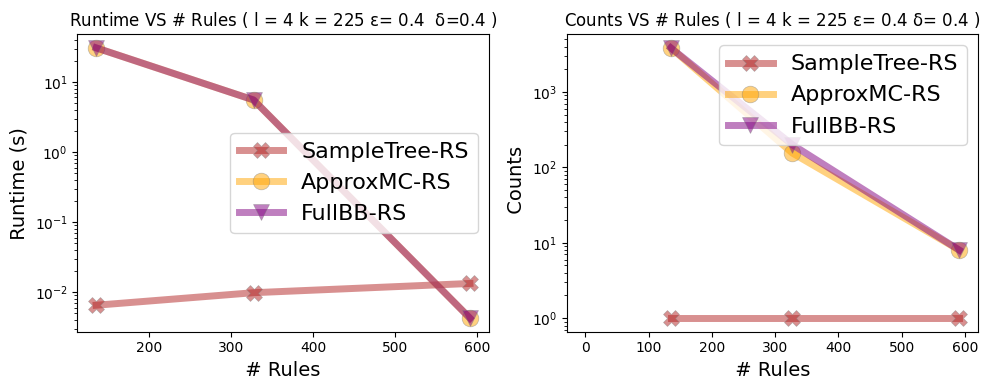

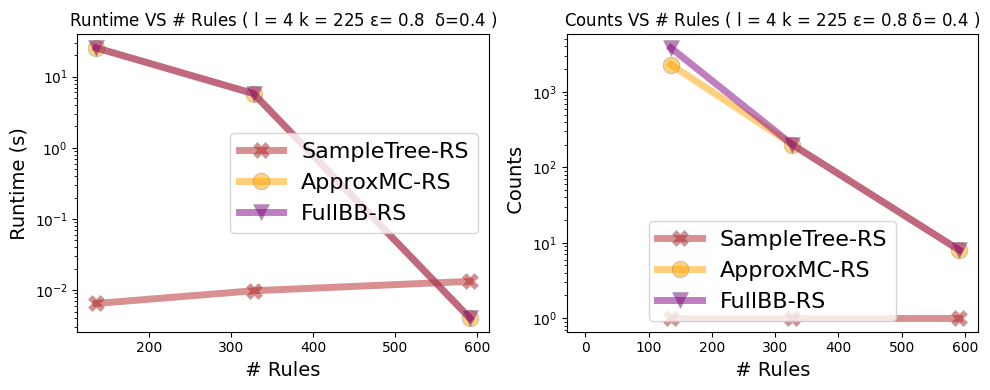

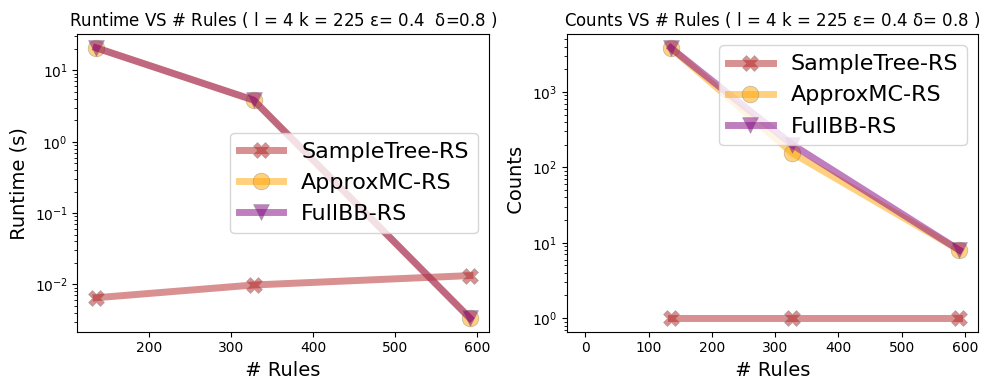

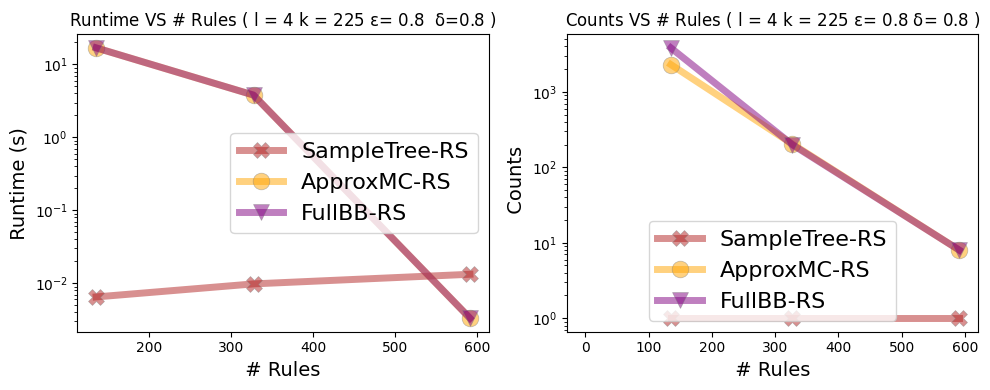

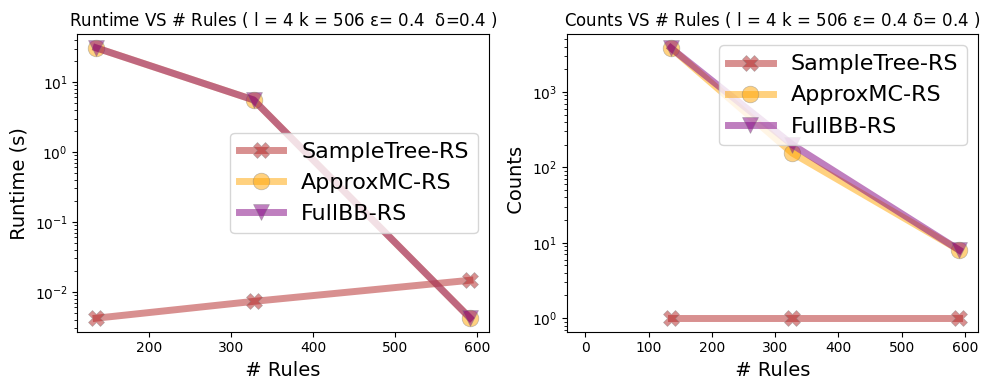

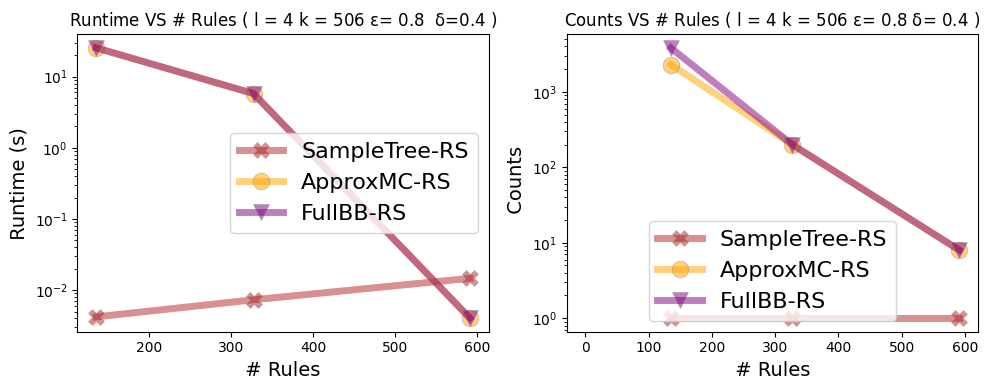

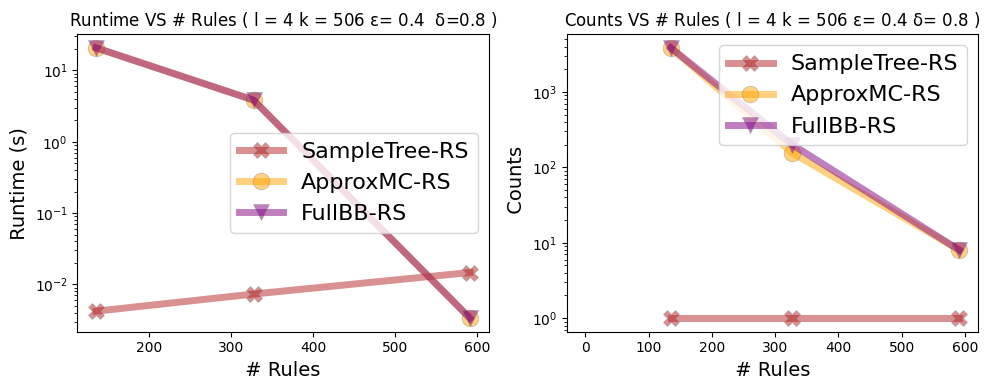

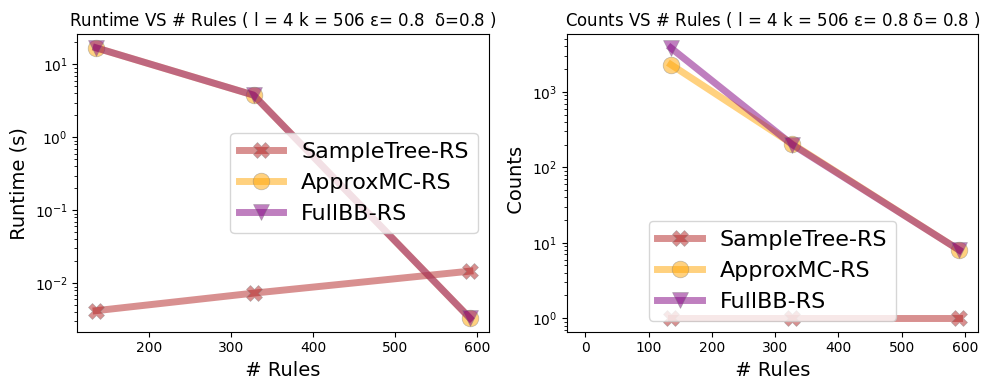

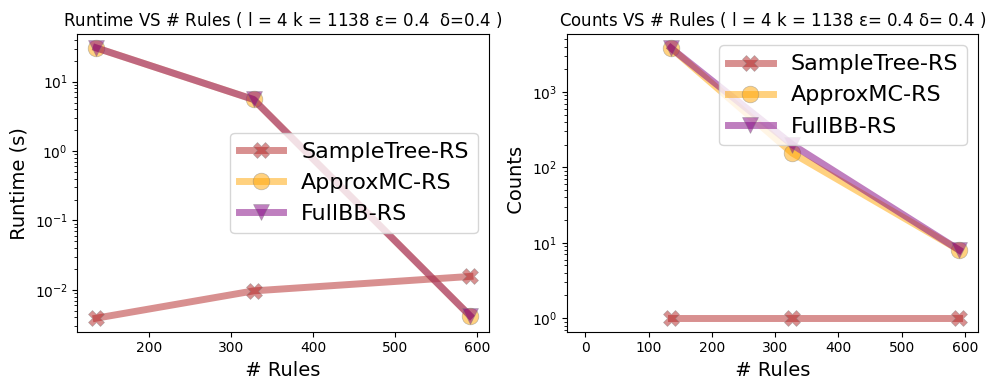

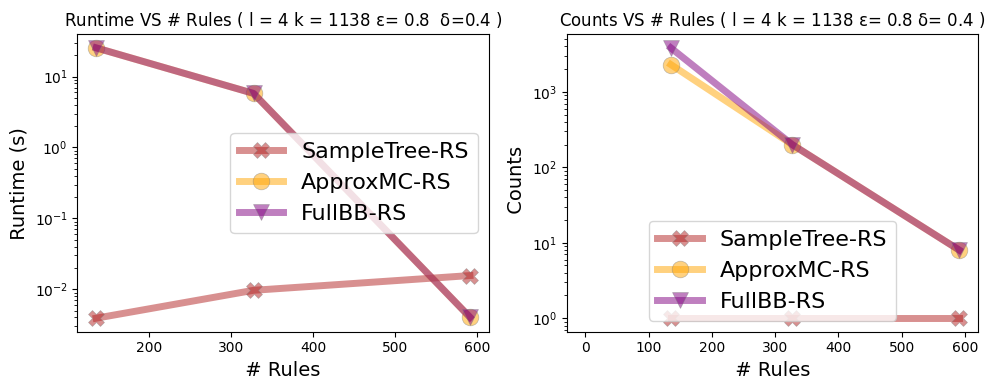

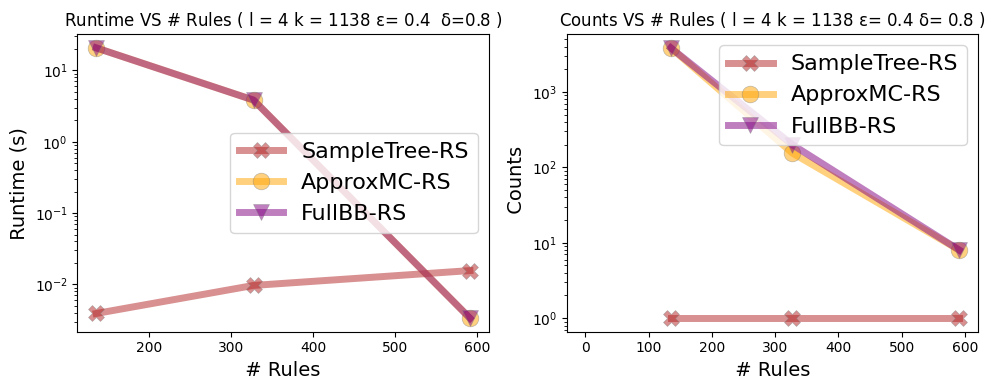

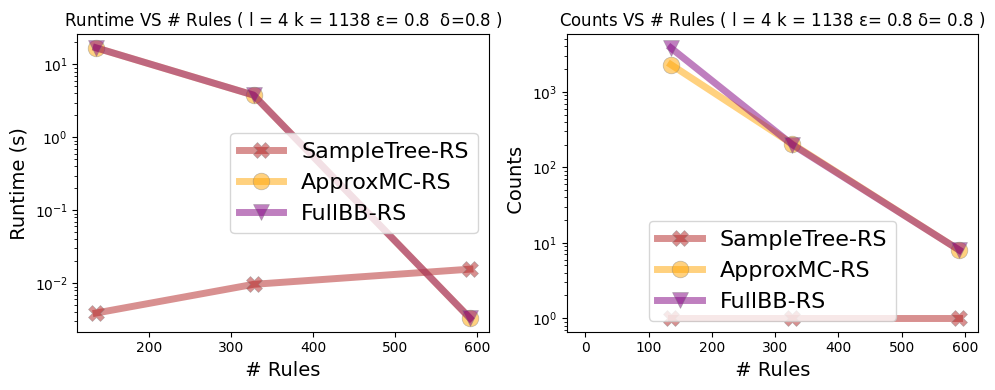

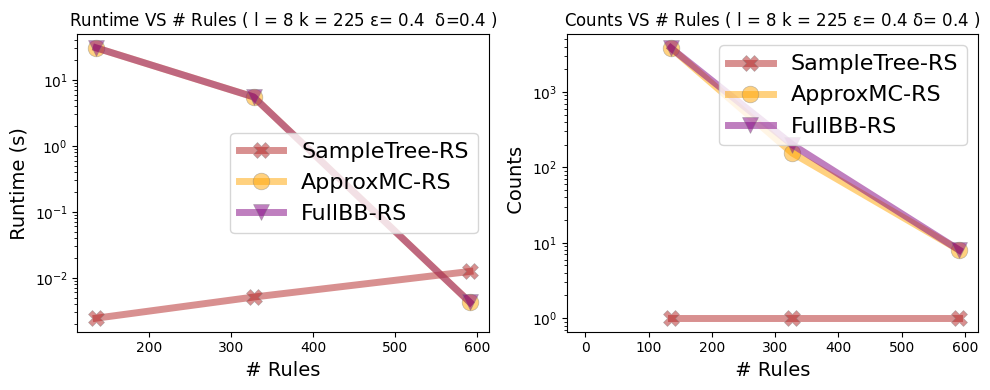

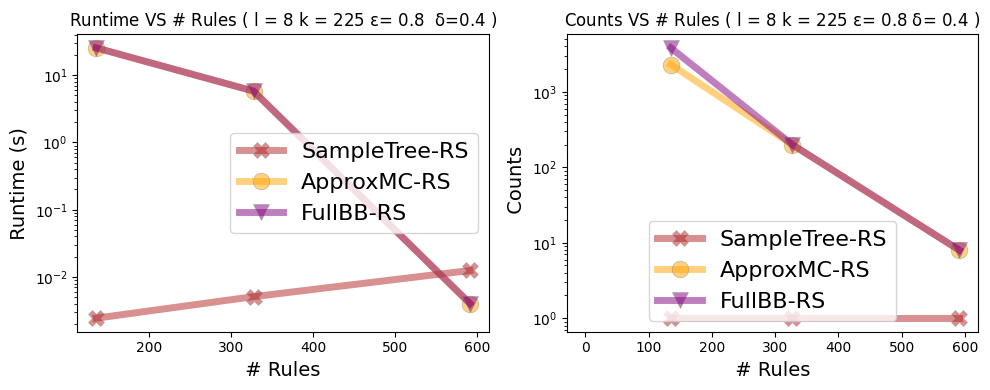

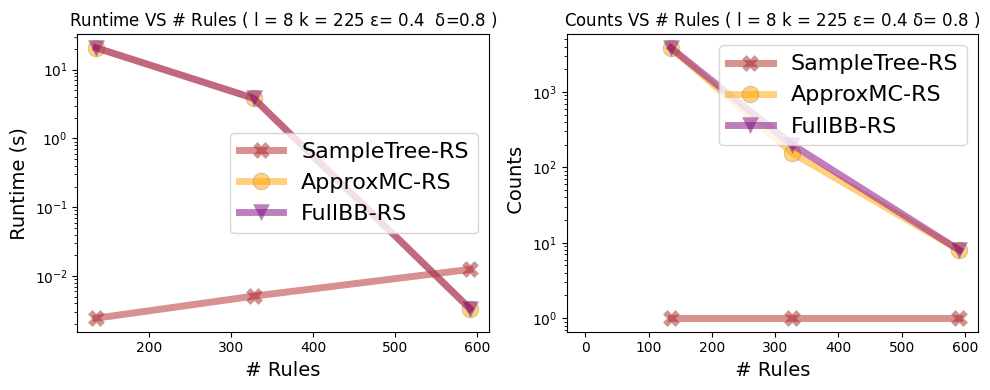

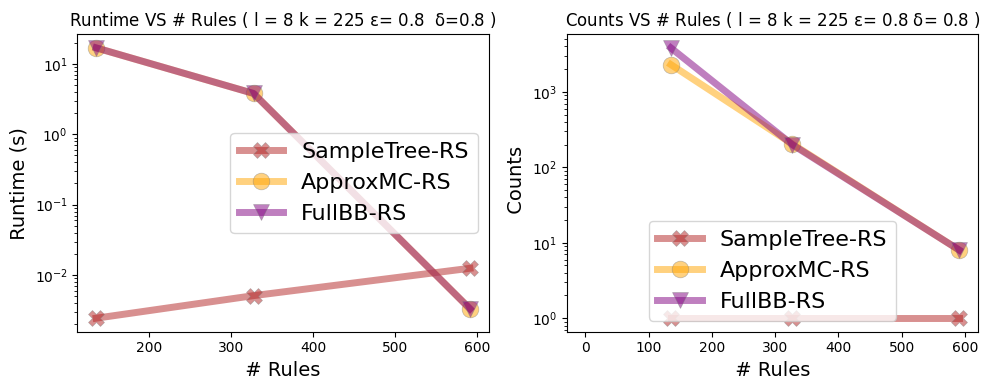

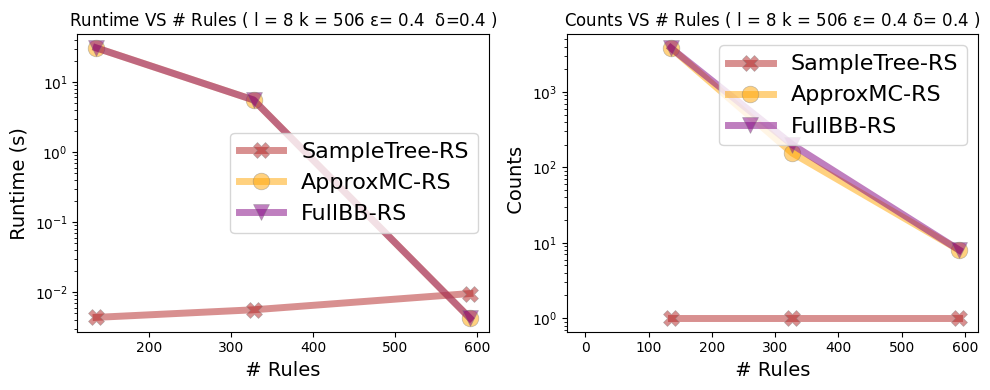

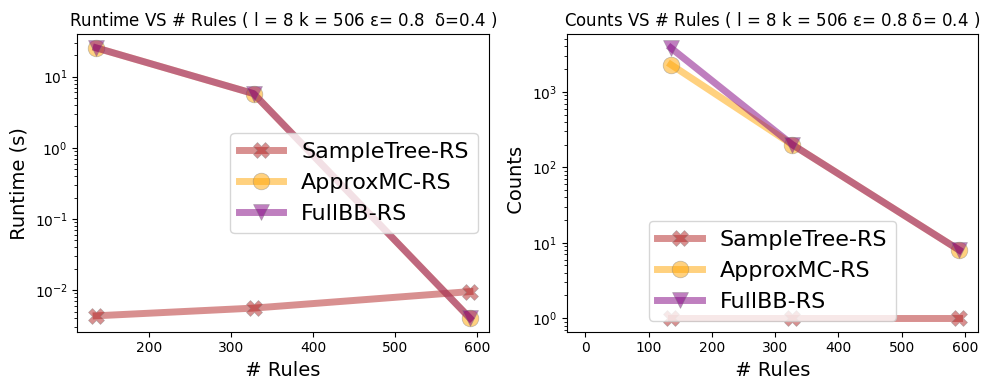

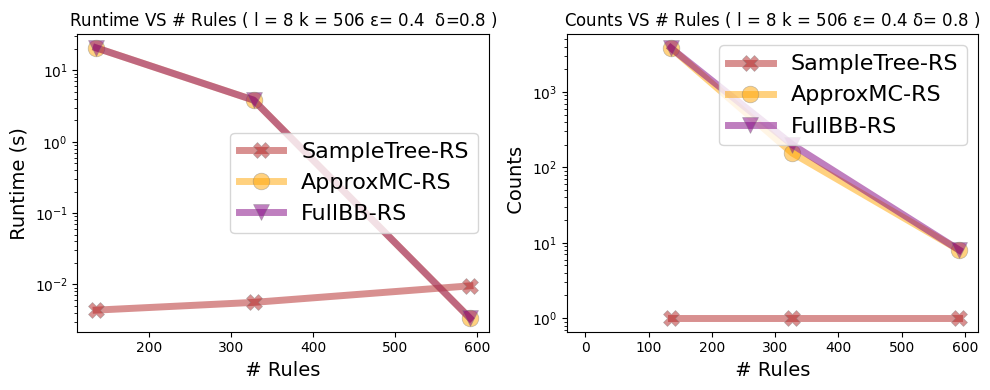

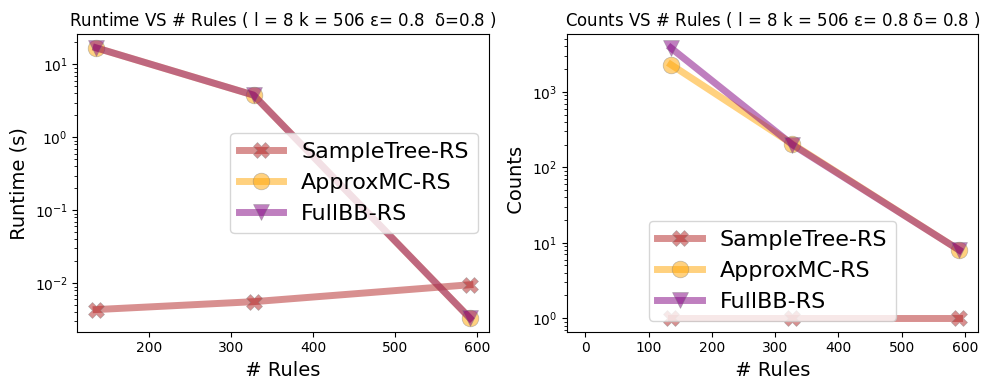

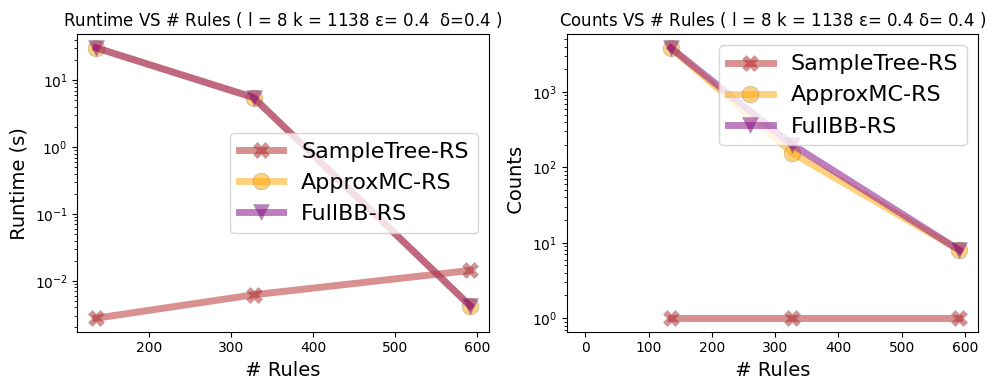

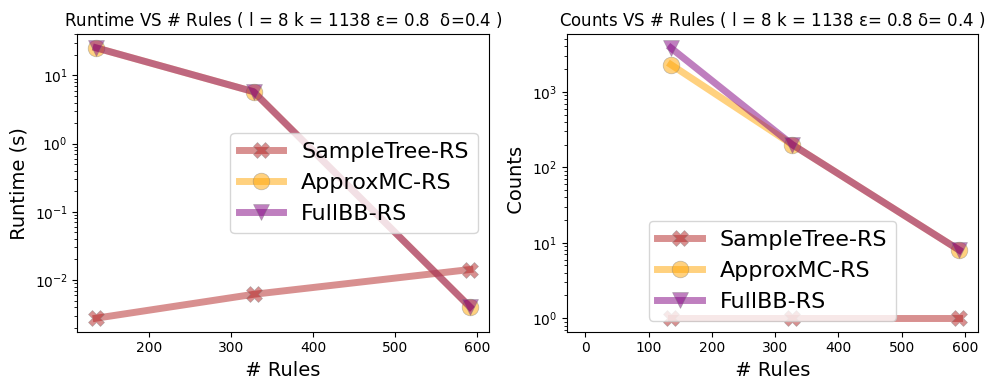

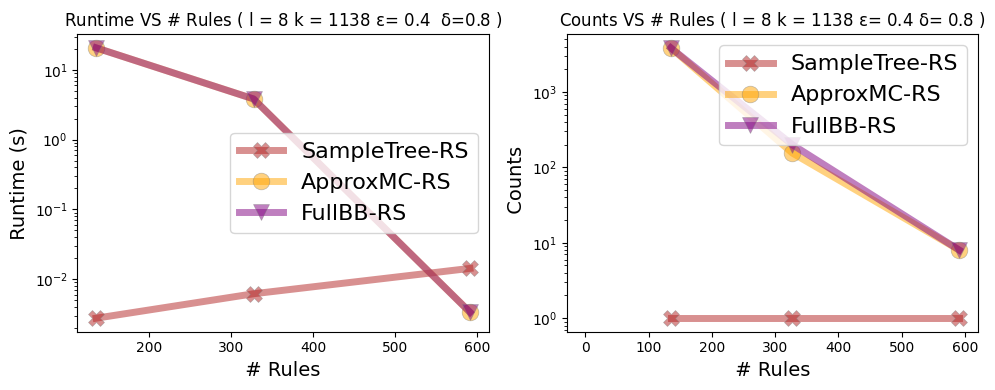

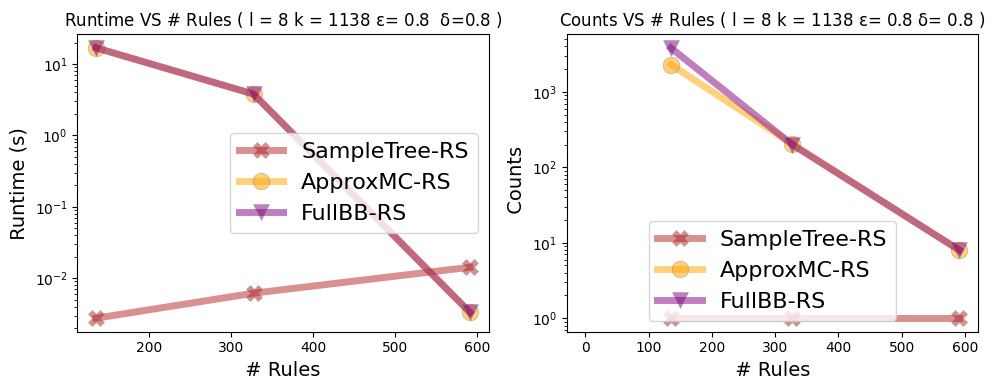

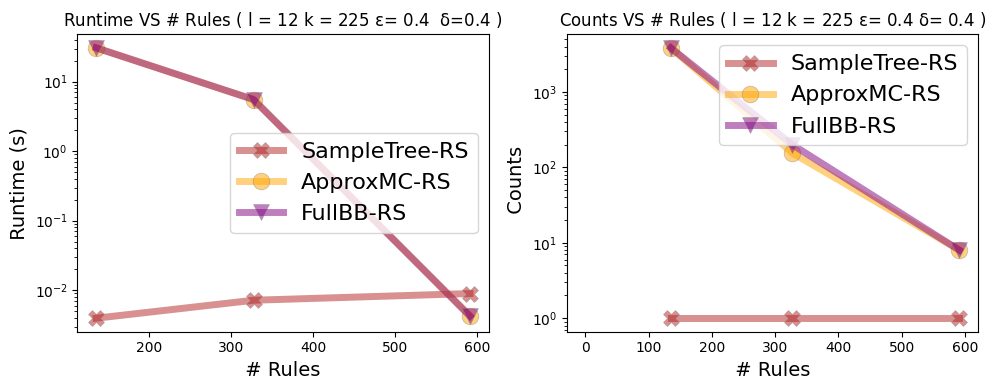

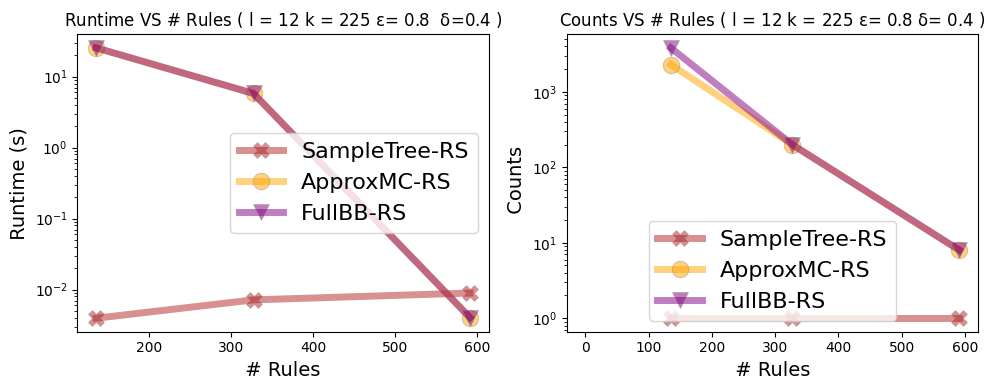

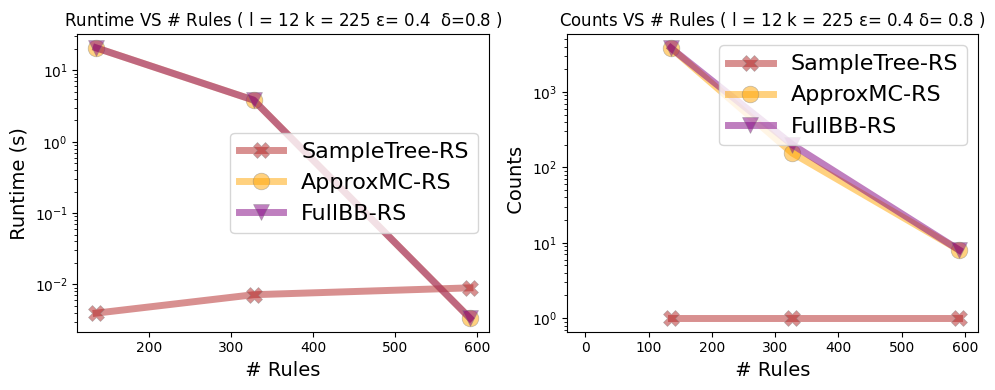

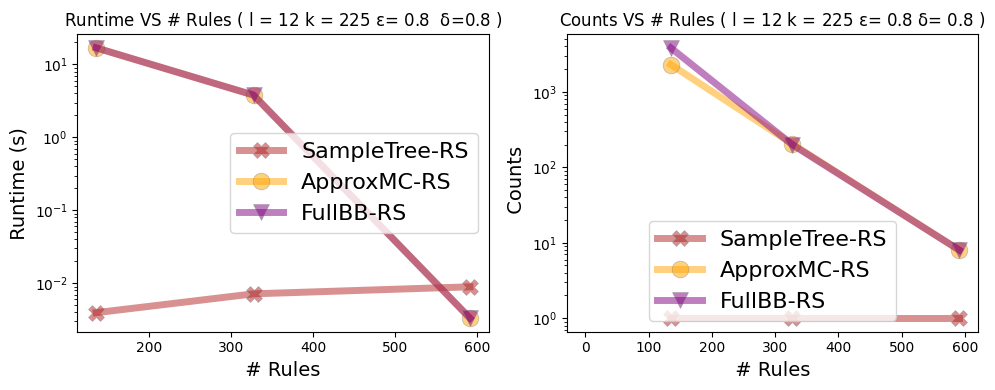

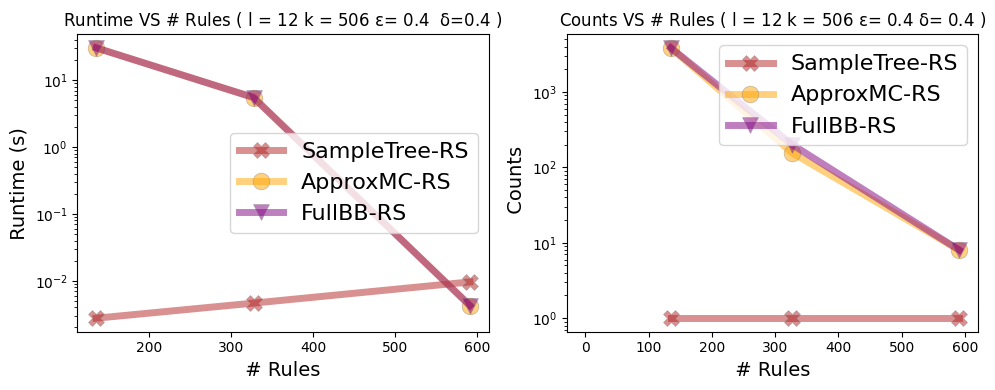

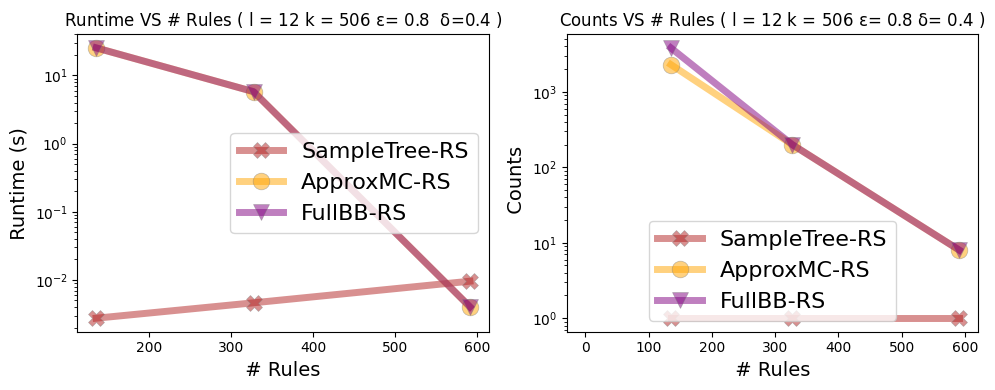

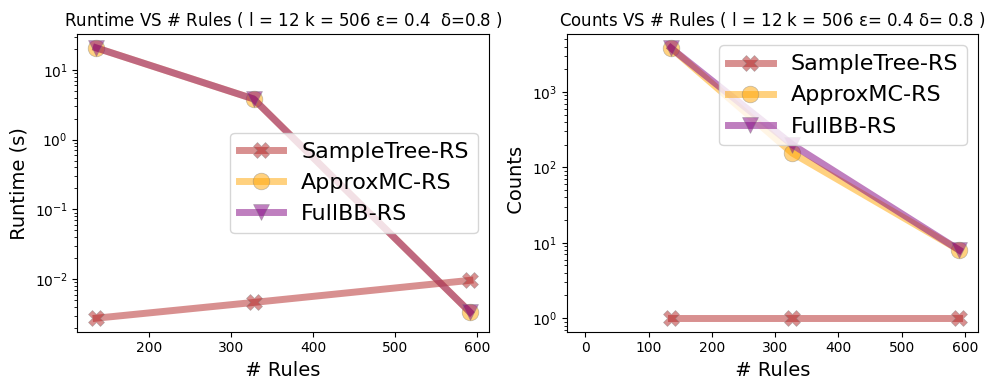

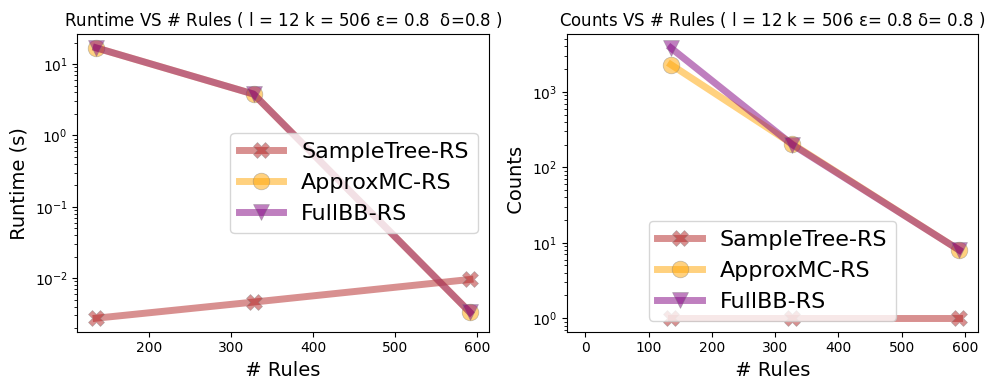

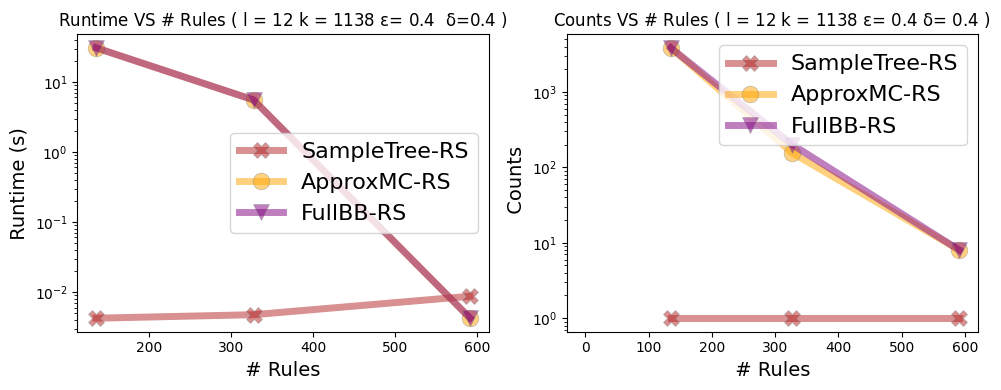

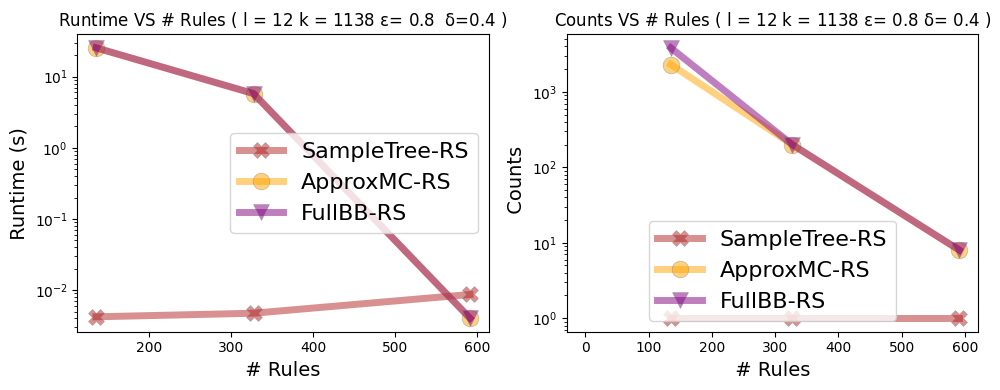

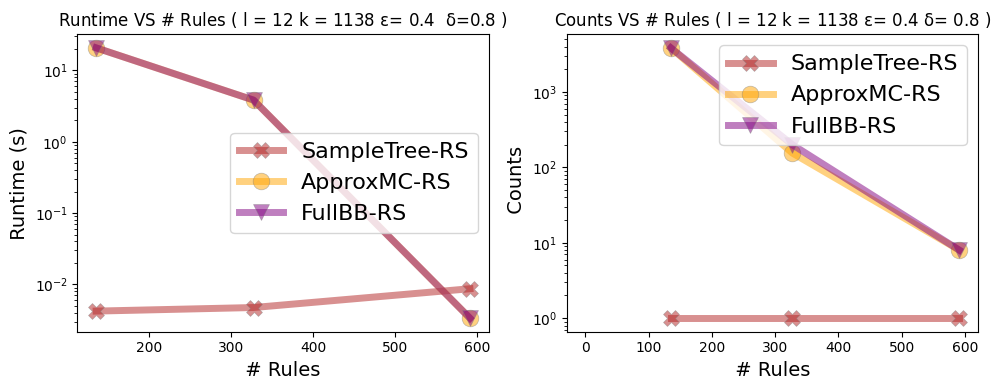

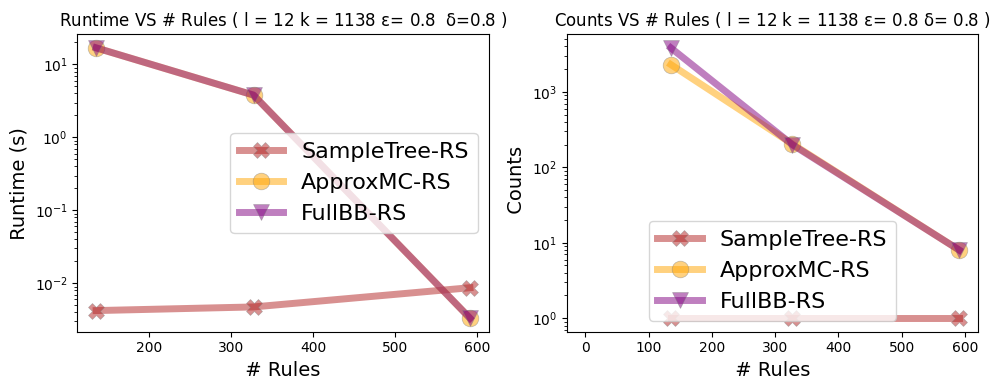

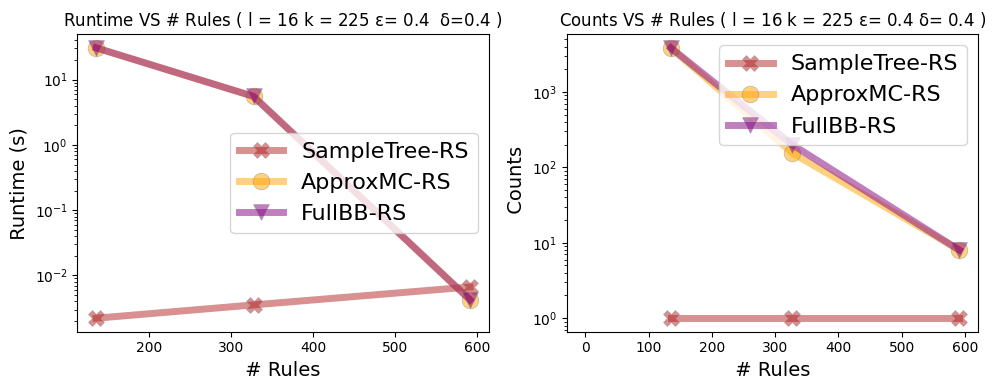

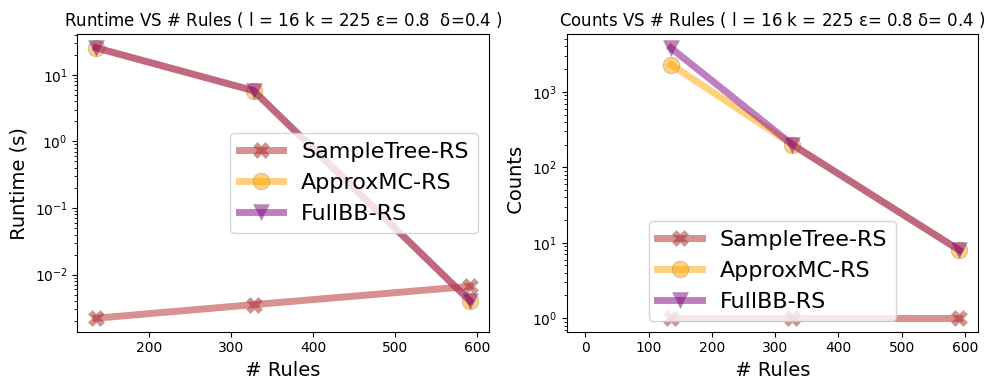

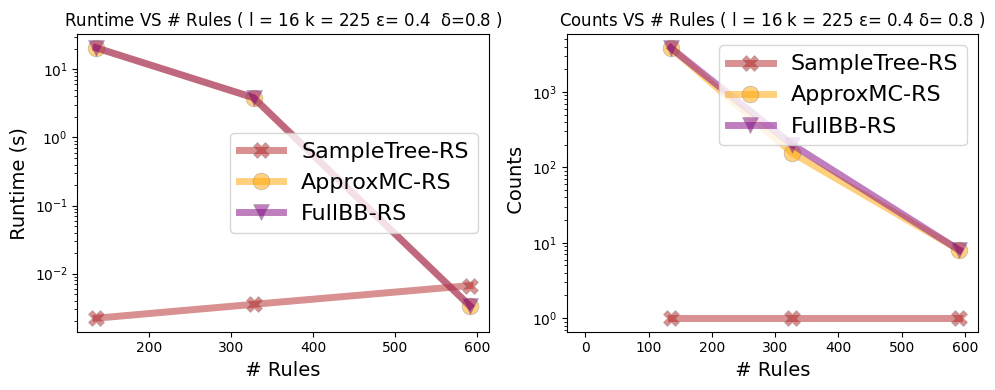

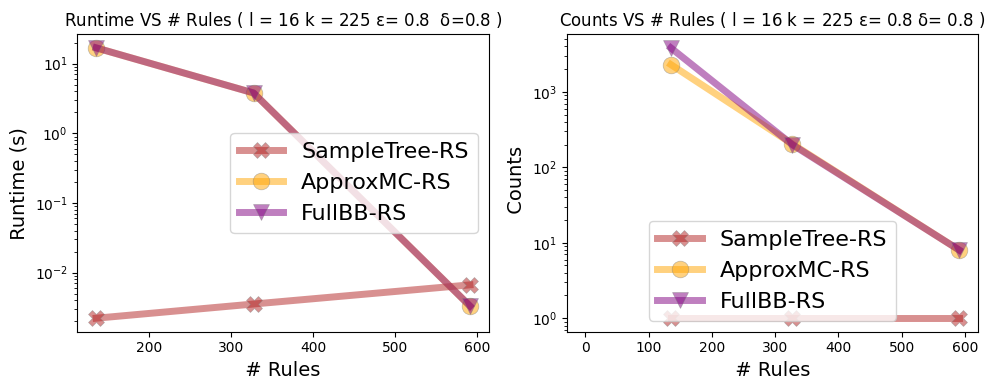

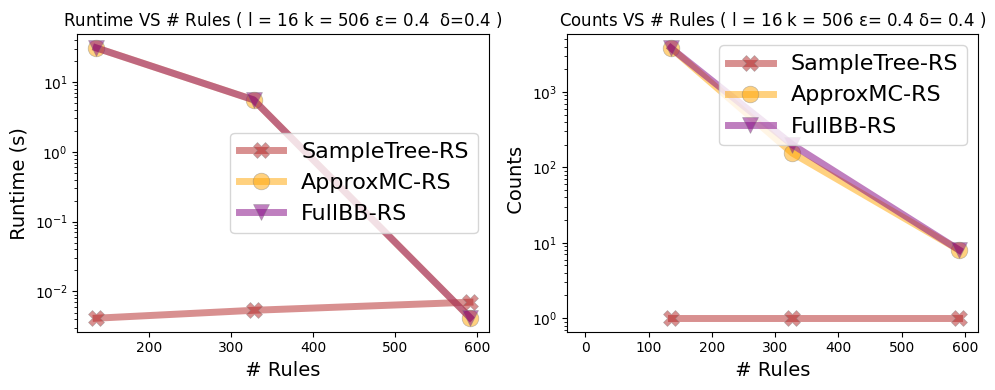

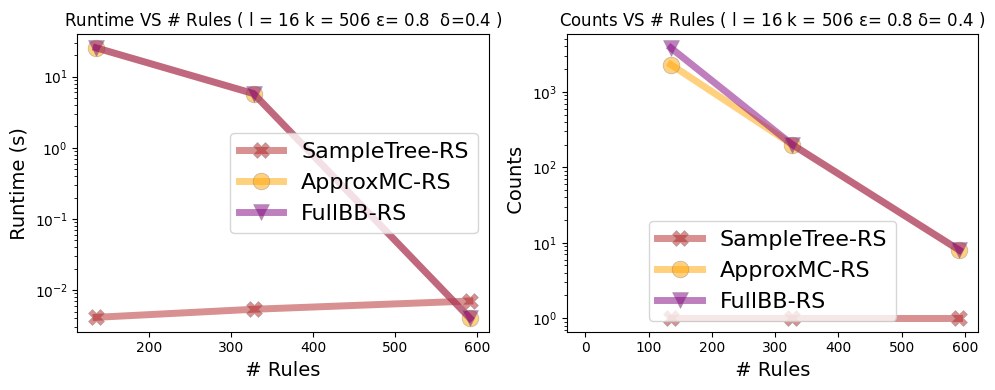

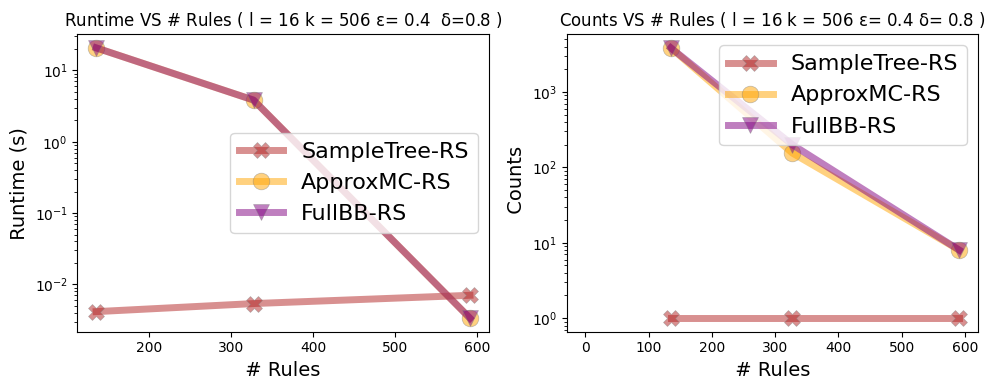

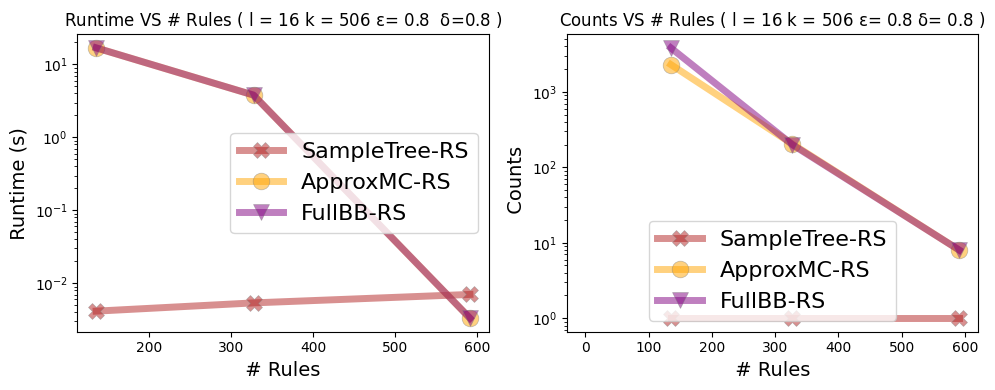

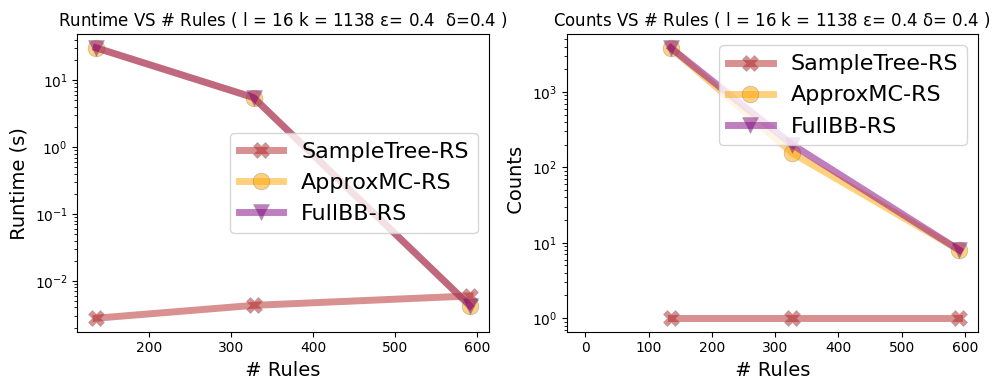

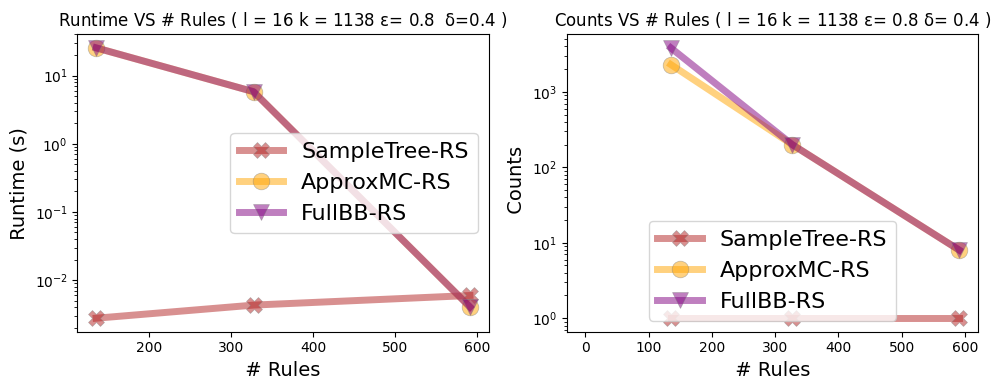

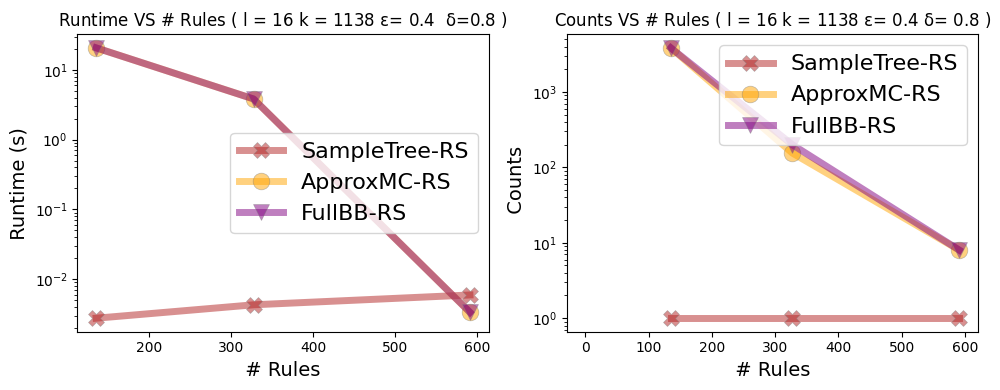

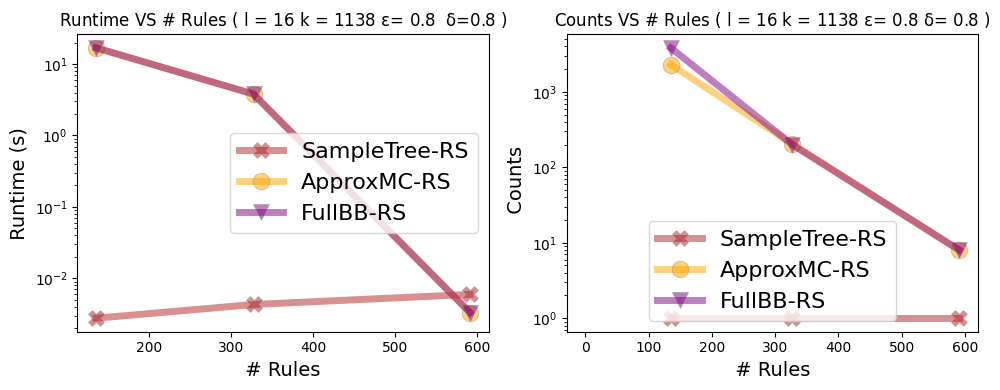

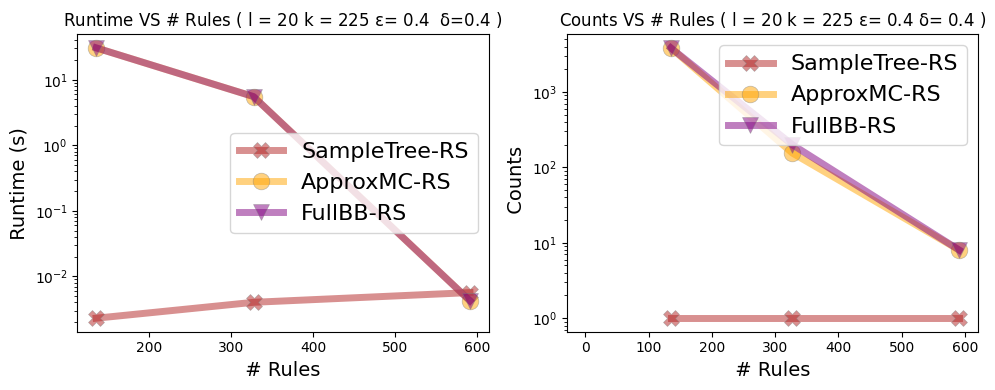

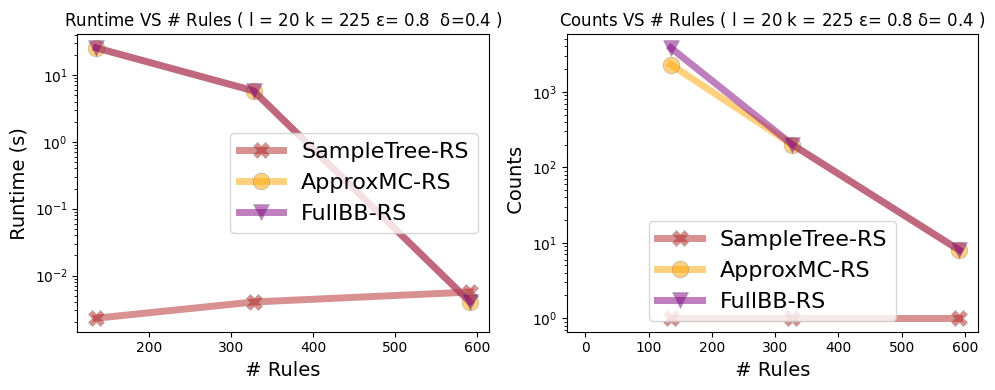

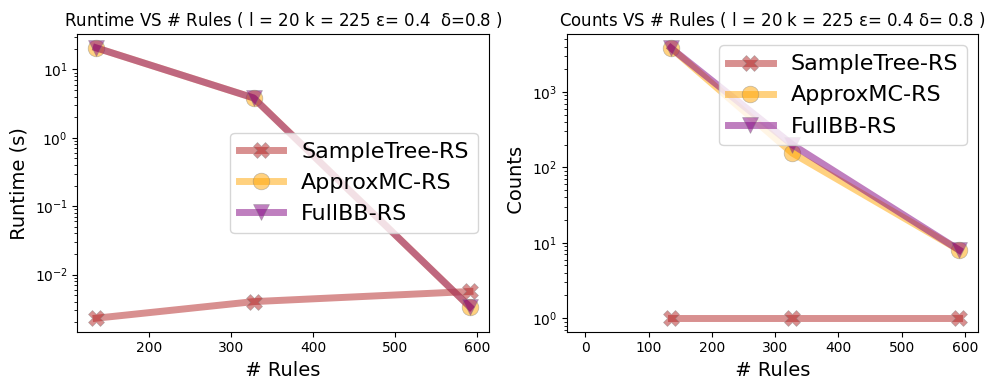

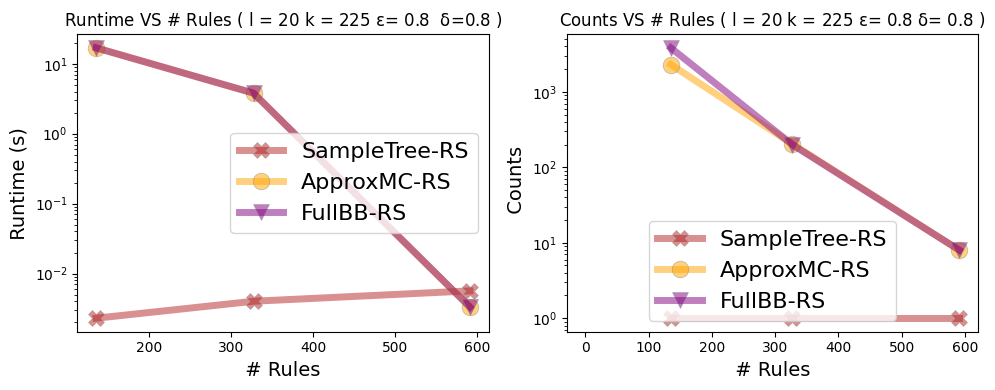

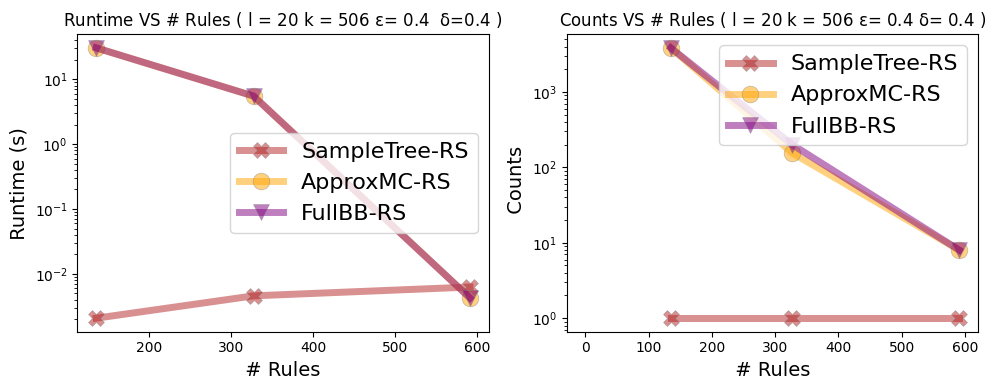

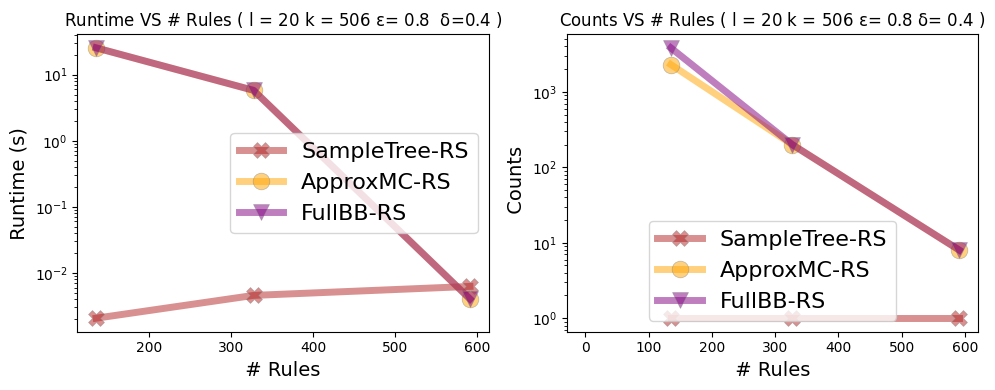

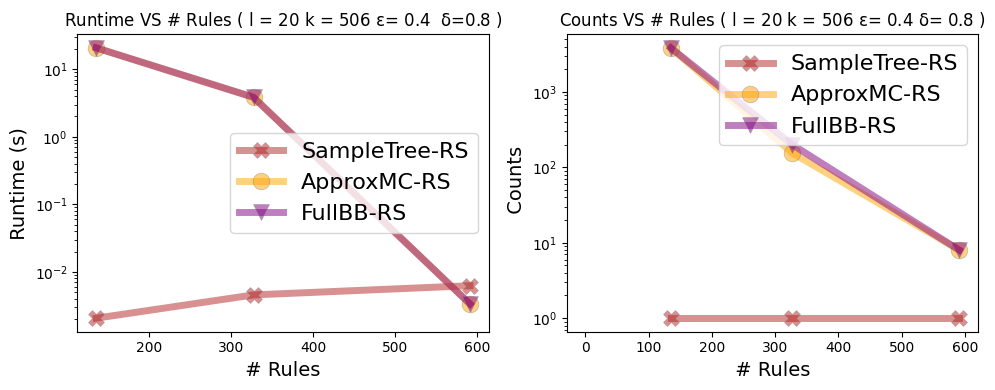

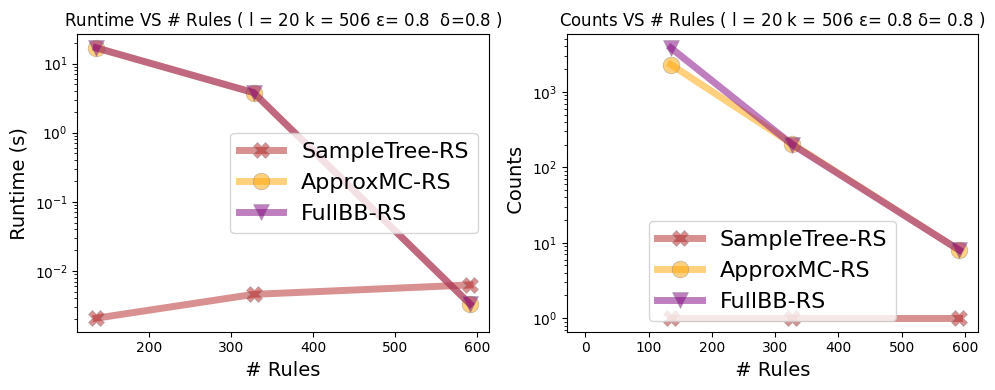

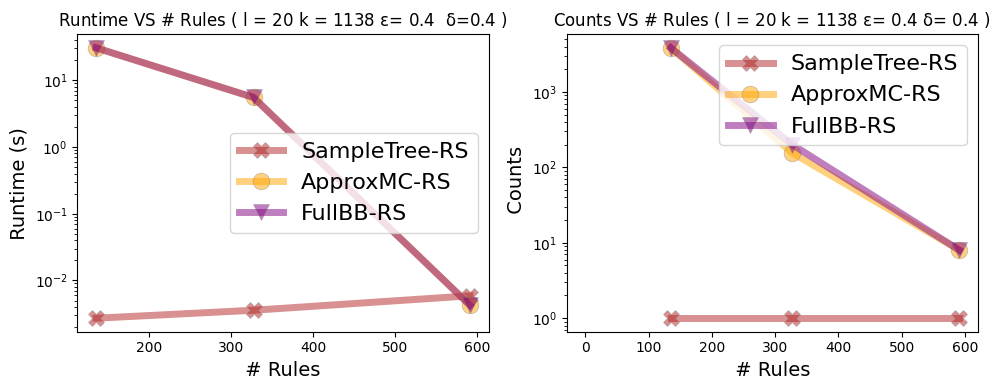

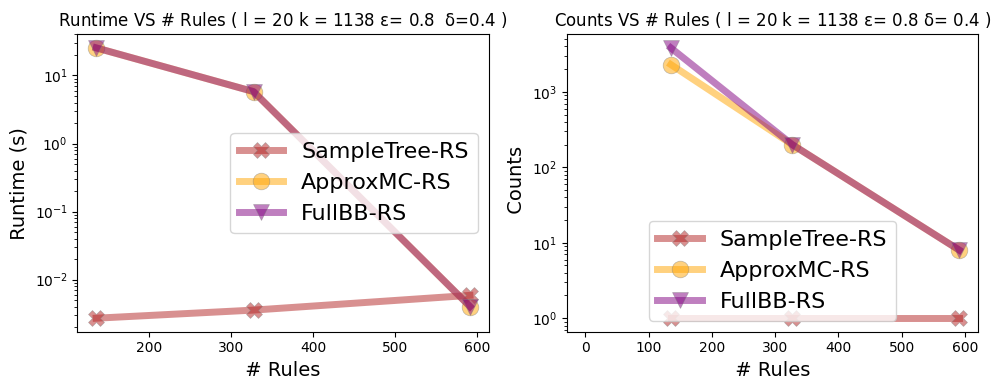

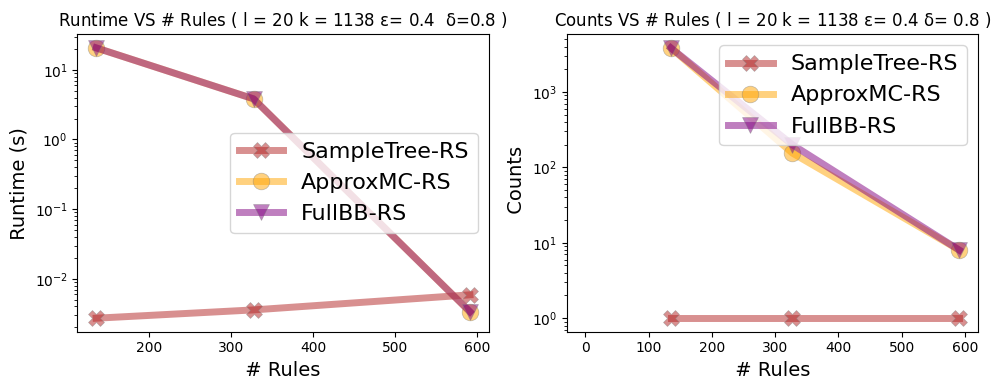

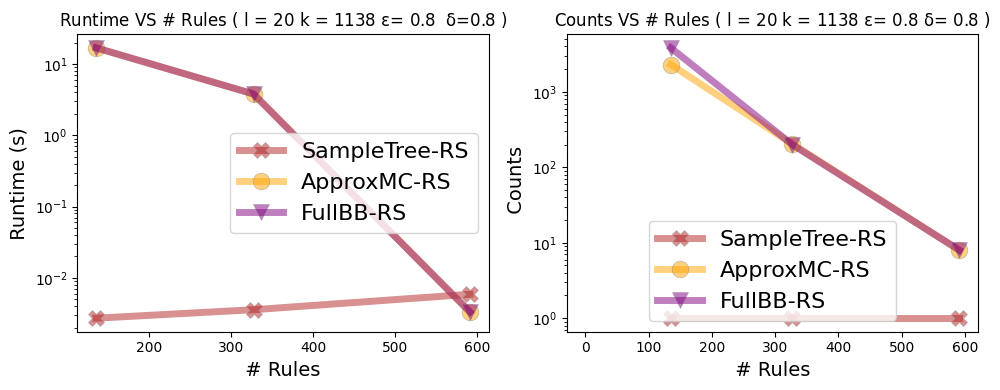

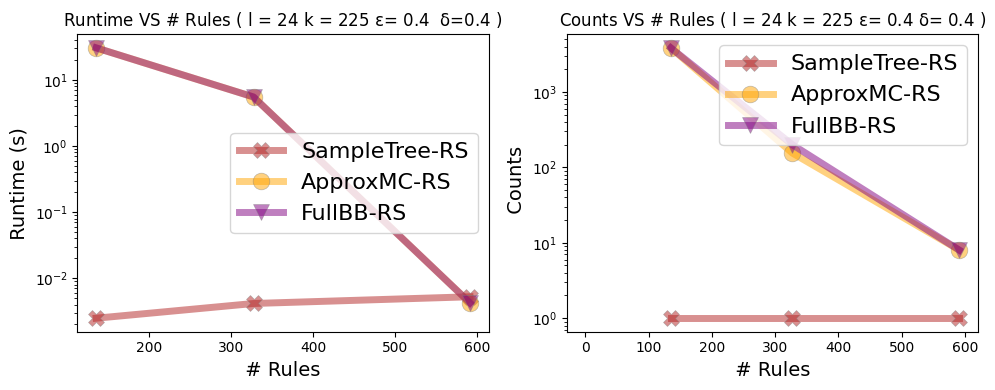

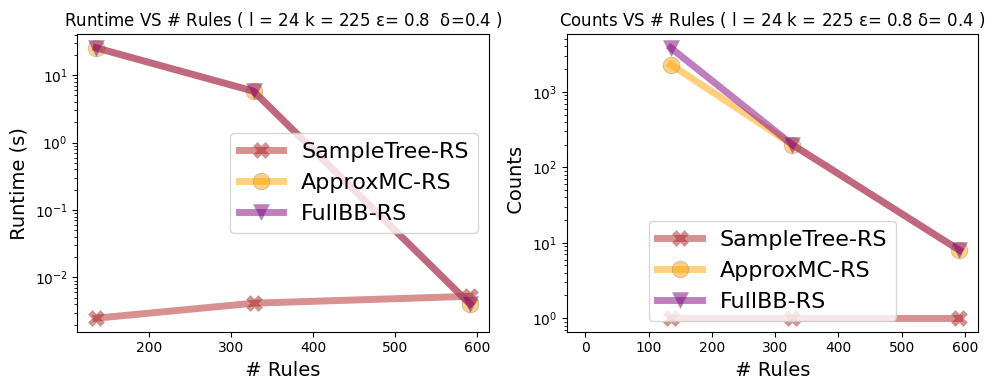

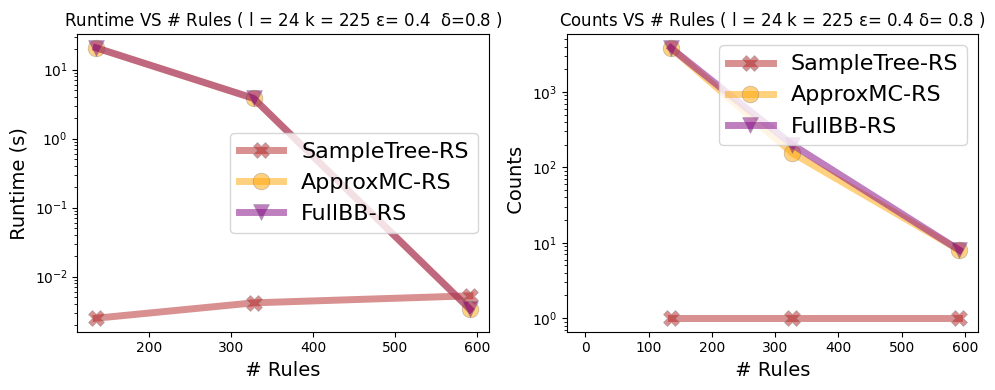

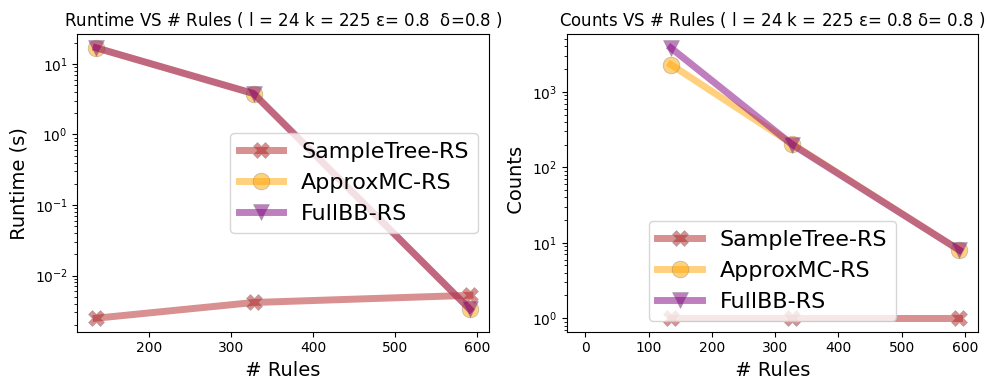

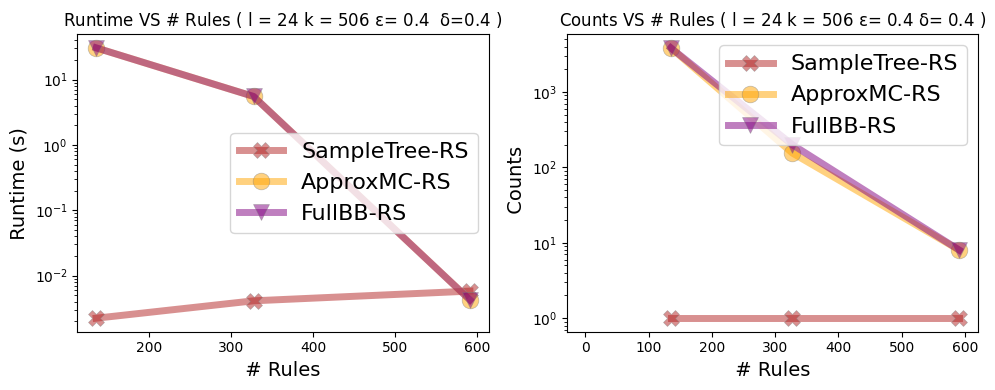

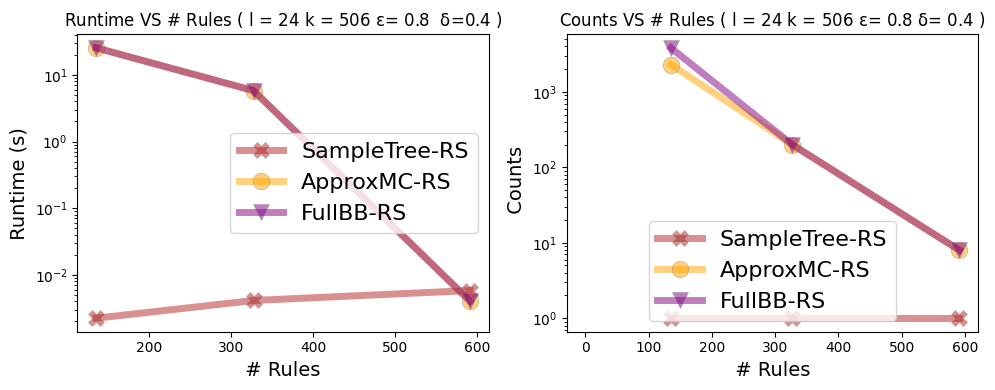

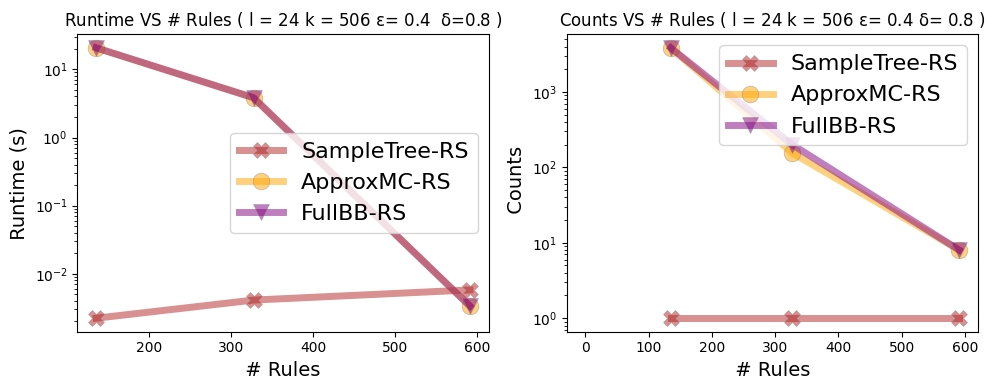

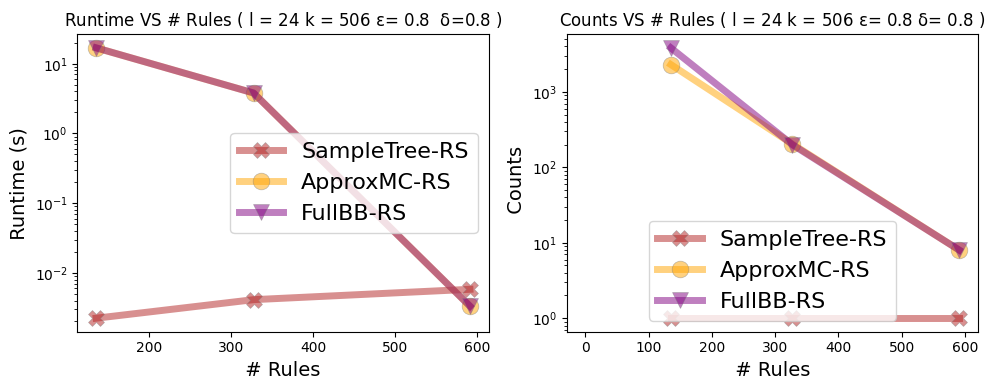

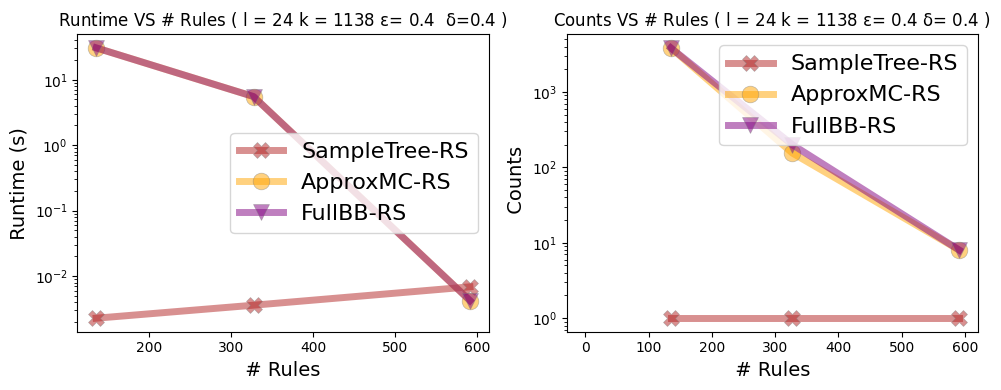

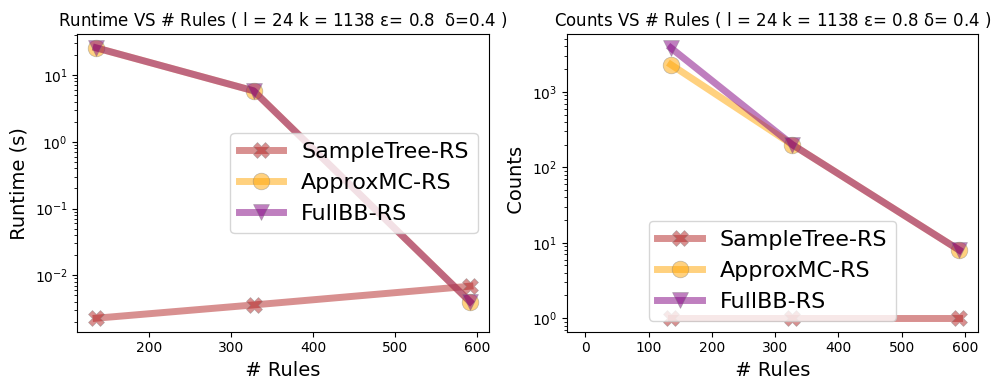

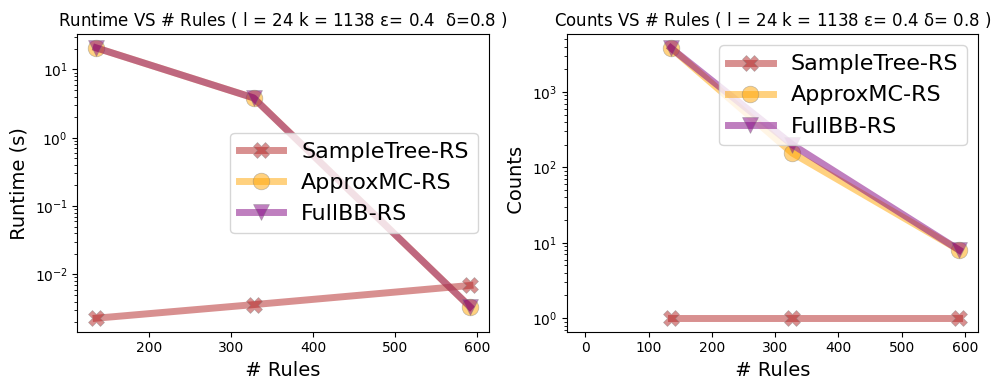

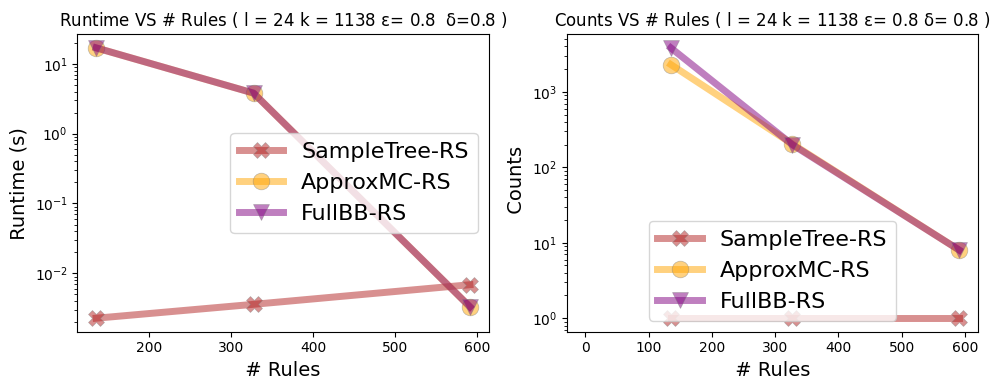

In [32]:
from pylab import plot, show, savefig, xlim, figure, ylim, legend, boxplot, setp, axes
import matplotlib.pyplot as plt
import matplotlib as mpl

dataset = "sfq"


for l in [4, 8, 12, 16, 20, 24]: 
    for k in  [225, 506, 1138]:
        #
        for delta in [0.4, 0.8]: 
            for eps in [0.4, 0.8]:
                #
                #
                n_rules = 591
                times = read_pickle(  "times_by_rules_" + dataset + "_" + str(n_rules) + "_" + str(l) + "_" + str(k)  )[0]
                counts = read_pickle(  "counts_by_rules_" + dataset + "_" + str(n_rules) + "_" + str(l) + "_" + str(k)  )[0]

                times_MC = [] 
                counts_MC = [] 

                times_GT = [] 
                counts_GT = []

                #for n_rules in all_n_rules: 
                n_rules = 135

                times_MC = read_pickle(  "all_averages_times_MC_" + dataset + "_" + str(n_rules) + "_" + str(eps) + "_" + str(delta)  )[0]

                    #"times_MC.append(this_times_MC[0]) 

                cnts_MC = read_pickle(  "all_averages_counts_MC_" + dataset + "__" +  str(n_rules) + "_" + str(eps) + "_" + str(delta)   )[0]

                   # counts_MC.append(this_cnts_MC[0]) 

                times_GT = read_pickle(  "all_averages_times_GT_" + dataset + "_" +  str(n_rules) + "_" + str(eps) + "_" + str(delta)    )[0] 

                 #   times_GT.append(this_times_GT[0]) 

                cnts_GT = read_pickle(  "all_averages_counts_GT_" + dataset + "_" +  str(n_rules) + "_" + str(eps) + "_" + str(delta)  )[0] 


                #plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])
                mpl.rcParams['axes.facecolor'] = 'white'
                mpl.rcParams['grid.color'] = 'lightgray'
                mpl.rcParams["mathtext.default"] = "regular"
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
                # Plot the first data on the first subplot
                #ax1.plot([61 , 77, 104], y1, color='red')
                #ax1.set_title('Plot 1')

                #all_n_rules = [61, 77, 104, 151, 262, 312]
                #all_n_rules = [41, 97, 159, 317]
                all_n_rules = [591, 327, 135][::-1]
                x = all_n_rules

                #print(times_MC)

                ax1.plot(x, times,  marker='X', color = "firebrick" , label = "SampleTree-RS", linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

                ax1.plot(x, times_MC, marker='o', color = "orange" ,  label = "ApproxMC-RS", linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

                #plt.plot(alllent_sequence, all_naive_se_times_ha, marker='P', color = "green" , linewidth=3 , markersize = 10 ,markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8) 
                ax1.plot(x, times_GT, marker='v', 
                        color = "purple", label = "FullBB-RS",   linewidth=5 , markersize = 12 ,  markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 


                ax1.legend(fontsize = 16)

                ax1.set_title('Runtime VS # Rules ( l = ' + str(l) + " k = " + str(k) + " " + r"$\epsilon$= " + str(eps) +  " " + r" $\delta$=" + str(delta) +  " )" , fontsize = 12)

                ax1.set_xlabel(" # Rules ", fontsize = 14 )

                ax1.set_ylabel(" Runtime (s) " , fontsize = 14 ) 

                ax1.set_yscale('log')  # Set y-axis to logarithmic scale


                ax2.plot(x, counts,  marker='X', color = "firebrick" , label = "SampleTree-RS", linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

                ax2.plot(x, cnts_MC, marker='o', color = "orange" , label = "ApproxMC-RS",  linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

                #plt.plot(alllent_sequence, all_naive_se_times_ha, marker='P', color = "green" , linewidth=3 , markersize = 10 ,markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8) 
                ax2.plot(x, cnts_GT, marker='v', 
                        color = "purple",  label = "FullBB-RS",  linewidth=5 , markersize = 12 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.5) 

                ax2.legend(fontsize = 16)        

                ax2.set_title('Counts VS # Rules ( l = ' + str(l) + " k = " + str(k) + r" $\epsilon$=" +  " " + str(eps) + r" $\delta$=" + " " + str(delta) +  " )" , fontsize = 12  )


                ax2.set_xlabel(" # Rules ", fontsize = 14 )

                ax2.set_ylabel(" Counts" , fontsize = 14 ) 

                ax2.set_yscale('log')  # Set y-axis to logarithmic scale


                hB, = plot([1,1],'firebrick' , marker='X', linewidth=3 , markersize = 10, markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
                hHP, = plot([1,1], "orange", marker='o',  linewidth=3 , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey"  , alpha = 0.8)
                hS, = plot([1,1],'purple' , marker='v' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
                #   hD, = plot([1,1],'salmon' , marker='D' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
                #   hF, = plot([1,1], 'brown' , marker='P' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
                #legend(( hB, hHP, hS,), ( "SampleTree-RS" , "ApproxMC-RS",   "FullBB-RS") ,loc='upper center', bbox_to_anchor=(-1, 1.25 ), ncol=3, fancybox=False, shadow=False, borderaxespad=0, fontsize = 14 )
                #legend(( hB, hHP, hS, hD, hF), ( "Viterbi" , "Dijkstra",   "DijkstraBound", "BidirectionalDijkstra" , "BidirectionalDijkstraBound" ) ,loc='upper center', bbox_to_anchor=(0.5, 1.21 ), ncol=3, fancybox=True, shadow=True, borderaxespad=0 )
                hB.set_visible(False)
                hS.set_visible(False)
                hHP.set_visible(False)


                # Adjust spacing between subplots
                plt.tight_layout()


                plt.savefig("sample_tree_by_rules_" + dataset + "_" + str(l) + "_" + str(k) + "_log.pdf") 

                # Display the plots
                plt.show()


In [ ]:
times

In [ ]:
x

In [ ]:
times_MC